In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, jaccard_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
import mlsmote
from skmultilearn.problem_transform import BinaryRelevance
import json
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
from tqdm import tqdm
from inspect import signature
# import precision and recall
from sklearn.metrics import precision_score, recall_score
from tensorflow.estimator import DNNClassifier

In [2]:
# Load the dataset
data = pd.read_csv('ai4i2020.csv',index_col=None)


In [3]:
no_data_entries = data.shape[0]
repetition_class_ratio= data[['TWF','HDF','PWF','OSF','RNF']].sum(axis=0)/no_data_entries
print(repetition_class_ratio)

TWF    0.0046
HDF    0.0115
PWF    0.0095
OSF    0.0098
RNF    0.0019
dtype: float64


In [4]:
non_failure_samples_no= no_data_entries-data[["Machine failure"]].sum(axis=0).values[0]
print(non_failure_samples_no)

9661


In [5]:
classifiers = [
    XGBClassifier,
    LGBMClassifier,
    CatBoostClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    LogisticRegression,
    SVC,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    MLPClassifier
]

hyperparameters = [
    { 
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.1, 0.5, 1.0],
        'n_estimators': [50, 100, 200],
        'gamma': [0.0, 0.1, 0.5],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0],
        'tree_method': ['gpu_hist'],  # Use GPU for XGBoost
        'gpu_id': [0]  # Set GPU ID to 0
    },
    {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.5, 1.0],
        'n_estimators': [50, 100, 200],
        'num_leaves': [31, 62, 127],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0],
        'reg_lambda': [0.0, 0.1, 0.5],
        'device': ['gpu'],  # Use GPU for LightGBM
        'gpu_device_id': [0],  # Set GPU ID to 0
        'verbose': [-1],  # Disable text information
        'silent': [True]  # Disable text information (alternative)
    },
    {
        'depth': [3, 5, 7],
        'learning_rate': [0.1, 0.5, 1.0],
        'n_estimators': [50, 100, 200],
        'l2_leaf_reg': [0.0, 0.1, 0.5],
        'task_type': ['GPU'],  # Use GPU for CatBoost
        'verbose': [False]  # Disable text information
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10]
    },
    {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1.0],
        'max_depth': [3, 5, 7],
        'subsample': [0.5, 0.8, 1.0]
    },
    {
        'C': [0.1, 1.0, 10.0]
    },
    {
        'kernel': ['rbf', 'linear'],
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 'auto']
    },
    {
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10]
    },
    {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance']
    },
    {
        'hidden_layer_sizes': [(50, 50), (100, 100), (200, 200)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'invscaling']
    }
]

In [6]:

# Encode categorical feature
type_dict = {"L": 1, "M": 2, "H": 3}
data['Type'] = data['Type'].map(type_dict)

# Separate features and labels
X = data.drop(['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
y = data[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

repetition_class_ratio_before_da= y_train.sum(axis=0)/y_train.shape[0]
print("before MLSMOTE \n", repetition_class_ratio_before_da)


# Infer the categorical feature from the data columns
categorical_features = [i for i, col in enumerate(X.columns) if col == 'Type']

# Create an instance of MLSMOTE
mlsmote = mlsmote.MLSMOTE(categorical_features=categorical_features,input_columns=X_train.columns, label_columns=y_train.columns,random_state=77)

# Resample the data using MLSMOTE
X_train_res, y_train_res = mlsmote.fit_resample(X_train, y_train)   

# Convert X_train_res and y_train_res to DataFrames
X_train = pd.DataFrame(X_train_res, columns=X_train.columns)
y_train = pd.DataFrame(y_train_res, columns=y_train.columns)


repetition_class_ratio_after_da= y_train.sum(axis=0)/y_train.shape[0]
print("after MLSMOTE \n", repetition_class_ratio_after_da)




# Standardize the features
scaler = StandardScaler()
# scaler = MinMaxScaler()

# Scale the continuous features
X_train_res_continuous = scaler.fit_transform(X_train.drop('Type', axis=1))
X_test_continuous = scaler.transform(X_test.drop('Type', axis=1))

# Concatenate the categorical feature with the scaled continuous features
X_train = np.concatenate((X_train[['Type']], X_train_res_continuous), axis=1)
X_test = np.concatenate((X_test[['Type']], X_test_continuous), axis=1)



best_score = 0
best_params = None
best_classifier = None

results = []
for classifier, hyperparameter in zip(classifiers, hyperparameters):
    hyperparameter_combinations = [dict(zip(hyperparameter.keys(), v)) for v in product(*hyperparameter.values())]
    for hyperparameter_combination in tqdm(hyperparameter_combinations, desc=f"Training {classifier.__name__}"):
        clf_params = hyperparameter_combination.copy()
        if 'random_state' in signature(classifier).parameters:
            clf_params['random_state'] = 77
        clf = BinaryRelevance(classifier(**clf_params))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        micro_f1 = f1_score(y_test, y_pred, average='micro')
        jaccard_sim = jaccard_score(y_test, y_pred, average='micro')
        precision = precision_score(y_test, y_pred, average='micro')
        recall = recall_score(y_test, y_pred, average='micro')
        y_test_non_failure = ~np.any(y_test, axis=1)
        y_test_stack = np.hstack((np.array(y_test), np.array(y_test_non_failure).reshape(-1, 1)))
        y_pred_dense = y_pred.toarray()
        y_pred_non_failure = ~np.any(y_pred_dense, axis=1)
        y_pred_dense = np.hstack((y_pred_dense, y_pred_non_failure.reshape(-1, 1)))
        # accuracy 
        accuracy = np.mean(np.all(y_test_stack == y_pred_dense, axis=1))
        score = micro_f1 * jaccard_sim * accuracy
        print(f"Accuracy: {accuracy:.4f}, Micro F1: {micro_f1:.4f}, Jaccard Similarity: {jaccard_sim:.4f}, Score: {score:.6f}")
        results.append({
            'classifier': classifier.__name__,
            'hyperparameters': hyperparameter_combination,
            'micro_f1': micro_f1,
            'jaccard_sim': jaccard_sim,
            'precision': precision,
            'accuracy': accuracy,
            'recall': recall,
            'score': score
        })

with open('results.json', 'w') as f:
    json.dump(results, f, indent=4)



before MLSMOTE 
 TWF    0.004625
HDF    0.011625
PWF    0.010375
OSF    0.010000
RNF    0.001875
dtype: float64
after MLSMOTE 
 TWF    0.009190
HDF    0.011550
PWF    0.010308
OSF    0.009935
RNF    0.003726
dtype: float64


Training XGBClassifier:   0%|          | 1/972 [00:02<34:09,  2.11s/it]

Accuracy: 0.9790, Micro F1: 0.5376, Jaccard Similarity: 0.3676, Score: 0.193509


Training XGBClassifier:   0%|          | 2/972 [00:02<18:00,  1.11s/it]

Accuracy: 0.9825, Micro F1: 0.6400, Jaccard Similarity: 0.4706, Score: 0.295906


Training XGBClassifier:   0%|          | 3/972 [00:02<12:36,  1.28it/s]

Accuracy: 0.9865, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443925


Training XGBClassifier:   0%|          | 4/972 [00:03<10:07,  1.59it/s]

Accuracy: 0.9785, Micro F1: 0.5217, Jaccard Similarity: 0.3529, Score: 0.180184


Training XGBClassifier:   1%|          | 5/972 [00:03<09:35,  1.68it/s]

Accuracy: 0.9820, Micro F1: 0.6337, Jaccard Similarity: 0.4638, Score: 0.288583


Training XGBClassifier:   1%|          | 6/972 [00:04<08:35,  1.87it/s]

Accuracy: 0.9860, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450485


Training XGBClassifier:   1%|          | 7/972 [00:04<07:46,  2.07it/s]

Accuracy: 0.9785, Micro F1: 0.5217, Jaccard Similarity: 0.3529, Score: 0.180184


Training XGBClassifier:   1%|          | 8/972 [00:05<07:15,  2.21it/s]

Accuracy: 0.9815, Micro F1: 0.6275, Jaccard Similarity: 0.4571, Score: 0.281528


Training XGBClassifier:   1%|          | 9/972 [00:05<06:52,  2.33it/s]

Accuracy: 0.9865, Micro F1: 0.7652, Jaccard Similarity: 0.6197, Score: 0.467817


Training XGBClassifier:   1%|          | 10/972 [00:05<06:39,  2.41it/s]

Accuracy: 0.9790, Micro F1: 0.5376, Jaccard Similarity: 0.3676, Score: 0.193509


Training XGBClassifier:   1%|          | 11/972 [00:06<06:50,  2.34it/s]

Accuracy: 0.9820, Micro F1: 0.6263, Jaccard Similarity: 0.4559, Score: 0.280363


Training XGBClassifier:   1%|          | 12/972 [00:06<06:39,  2.40it/s]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training XGBClassifier:   1%|▏         | 13/972 [00:07<06:30,  2.46it/s]

Accuracy: 0.9785, Micro F1: 0.5217, Jaccard Similarity: 0.3529, Score: 0.180184


Training XGBClassifier:   1%|▏         | 14/972 [00:07<06:25,  2.49it/s]

Accuracy: 0.9820, Micro F1: 0.6337, Jaccard Similarity: 0.4638, Score: 0.288583


Training XGBClassifier:   2%|▏         | 15/972 [00:07<06:25,  2.48it/s]

Accuracy: 0.9855, Micro F1: 0.7478, Jaccard Similarity: 0.5972, Score: 0.440142


Training XGBClassifier:   2%|▏         | 16/972 [00:08<06:18,  2.53it/s]

Accuracy: 0.9785, Micro F1: 0.5217, Jaccard Similarity: 0.3529, Score: 0.180184


Training XGBClassifier:   2%|▏         | 17/972 [00:08<06:15,  2.54it/s]

Accuracy: 0.9815, Micro F1: 0.6275, Jaccard Similarity: 0.4571, Score: 0.281528


Training XGBClassifier:   2%|▏         | 18/972 [00:08<06:12,  2.56it/s]

Accuracy: 0.9865, Micro F1: 0.7652, Jaccard Similarity: 0.6197, Score: 0.467817


Training XGBClassifier:   2%|▏         | 19/972 [00:09<06:05,  2.61it/s]

Accuracy: 0.9795, Micro F1: 0.5532, Jaccard Similarity: 0.3824, Score: 0.207178


Training XGBClassifier:   2%|▏         | 20/972 [00:09<06:05,  2.60it/s]

Accuracy: 0.9830, Micro F1: 0.6535, Jaccard Similarity: 0.4853, Score: 0.311732


Training XGBClassifier:   2%|▏         | 21/972 [00:10<06:02,  2.62it/s]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training XGBClassifier:   2%|▏         | 22/972 [00:10<06:08,  2.57it/s]

Accuracy: 0.9795, Micro F1: 0.5376, Jaccard Similarity: 0.3676, Score: 0.193608


Training XGBClassifier:   2%|▏         | 23/972 [00:10<06:08,  2.58it/s]

Accuracy: 0.9820, Micro F1: 0.6337, Jaccard Similarity: 0.4638, Score: 0.288583


Training XGBClassifier:   2%|▏         | 24/972 [00:11<06:06,  2.58it/s]

Accuracy: 0.9865, Micro F1: 0.7652, Jaccard Similarity: 0.6197, Score: 0.467817


Training XGBClassifier:   3%|▎         | 25/972 [00:11<06:07,  2.57it/s]

Accuracy: 0.9785, Micro F1: 0.5217, Jaccard Similarity: 0.3529, Score: 0.180184


Training XGBClassifier:   3%|▎         | 26/972 [00:12<06:05,  2.59it/s]

Accuracy: 0.9815, Micro F1: 0.6275, Jaccard Similarity: 0.4571, Score: 0.281528


Training XGBClassifier:   3%|▎         | 27/972 [00:12<06:06,  2.58it/s]

Accuracy: 0.9865, Micro F1: 0.7652, Jaccard Similarity: 0.6197, Score: 0.467817


Training XGBClassifier:   3%|▎         | 28/972 [00:13<07:48,  2.02it/s]

Accuracy: 0.9860, Micro F1: 0.7434, Jaccard Similarity: 0.5915, Score: 0.433579


Training XGBClassifier:   3%|▎         | 29/972 [00:13<09:05,  1.73it/s]

Accuracy: 0.9865, Micro F1: 0.7455, Jaccard Similarity: 0.5942, Score: 0.436971


Training XGBClassifier:   3%|▎         | 30/972 [00:14<09:54,  1.59it/s]

Accuracy: 0.9855, Micro F1: 0.7478, Jaccard Similarity: 0.5972, Score: 0.440142


Training XGBClassifier:   3%|▎         | 31/972 [00:15<10:40,  1.47it/s]

Accuracy: 0.9845, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383463


Training XGBClassifier:   3%|▎         | 32/972 [00:17<16:04,  1.03s/it]

Accuracy: 0.9855, Micro F1: 0.7368, Jaccard Similarity: 0.5833, Score: 0.423592


Training XGBClassifier:   3%|▎         | 33/972 [00:19<20:55,  1.34s/it]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:   3%|▎         | 34/972 [00:20<19:11,  1.23s/it]

Accuracy: 0.9850, Micro F1: 0.7207, Jaccard Similarity: 0.5634, Score: 0.399949


Training XGBClassifier:   4%|▎         | 35/972 [00:21<17:37,  1.13s/it]

Accuracy: 0.9865, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450714


Training XGBClassifier:   4%|▎         | 36/972 [00:22<16:22,  1.05s/it]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:   4%|▍         | 37/972 [00:23<15:44,  1.01s/it]

Accuracy: 0.9855, Micro F1: 0.7321, Jaccard Similarity: 0.5775, Score: 0.416656


Training XGBClassifier:   4%|▍         | 38/972 [00:23<15:12,  1.02it/s]

Accuracy: 0.9865, Micro F1: 0.7455, Jaccard Similarity: 0.5942, Score: 0.436971


Training XGBClassifier:   4%|▍         | 39/972 [00:24<14:54,  1.04it/s]

Accuracy: 0.9855, Micro F1: 0.7478, Jaccard Similarity: 0.5972, Score: 0.440142


Training XGBClassifier:   4%|▍         | 40/972 [00:25<14:40,  1.06it/s]

Accuracy: 0.9845, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383463


Training XGBClassifier:   4%|▍         | 41/972 [00:26<14:37,  1.06it/s]

Accuracy: 0.9865, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450714


Training XGBClassifier:   4%|▍         | 42/972 [00:27<14:38,  1.06it/s]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:   4%|▍         | 43/972 [00:29<17:15,  1.11s/it]

Accuracy: 0.9850, Micro F1: 0.7207, Jaccard Similarity: 0.5634, Score: 0.399949


Training XGBClassifier:   5%|▍         | 44/972 [00:30<16:21,  1.06s/it]

Accuracy: 0.9865, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450714


Training XGBClassifier:   5%|▍         | 45/972 [00:30<15:07,  1.02it/s]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training XGBClassifier:   5%|▍         | 46/972 [00:31<14:12,  1.09it/s]

Accuracy: 0.9865, Micro F1: 0.7455, Jaccard Similarity: 0.5942, Score: 0.436971


Training XGBClassifier:   5%|▍         | 47/972 [00:32<13:31,  1.14it/s]

Accuracy: 0.9870, Micro F1: 0.7477, Jaccard Similarity: 0.5970, Score: 0.440564


Training XGBClassifier:   5%|▍         | 48/972 [00:33<12:56,  1.19it/s]

Accuracy: 0.9860, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443700


Training XGBClassifier:   5%|▌         | 49/972 [00:33<12:38,  1.22it/s]

Accuracy: 0.9850, Micro F1: 0.7207, Jaccard Similarity: 0.5634, Score: 0.399949


Training XGBClassifier:   5%|▌         | 50/972 [00:34<12:22,  1.24it/s]

Accuracy: 0.9870, Micro F1: 0.7652, Jaccard Similarity: 0.6197, Score: 0.468054


Training XGBClassifier:   5%|▌         | 51/972 [00:35<12:07,  1.27it/s]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training XGBClassifier:   5%|▌         | 52/972 [00:36<11:53,  1.29it/s]

Accuracy: 0.9845, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383463


Training XGBClassifier:   5%|▌         | 53/972 [00:37<11:49,  1.29it/s]

Accuracy: 0.9860, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450485


Training XGBClassifier:   6%|▌         | 54/972 [00:37<11:43,  1.30it/s]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:   6%|▌         | 55/972 [00:39<14:32,  1.05it/s]

Accuracy: 0.9845, Micro F1: 0.7241, Jaccard Similarity: 0.5676, Score: 0.404627


Training XGBClassifier:   6%|▌         | 56/972 [00:40<16:16,  1.07s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training XGBClassifier:   6%|▌         | 57/972 [00:41<17:31,  1.15s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training XGBClassifier:   6%|▌         | 58/972 [00:43<18:13,  1.20s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training XGBClassifier:   6%|▌         | 59/972 [00:44<19:04,  1.25s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training XGBClassifier:   6%|▌         | 60/972 [00:45<19:17,  1.27s/it]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:   6%|▋         | 61/972 [00:47<19:22,  1.28s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:   6%|▋         | 62/972 [00:48<19:32,  1.29s/it]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:   6%|▋         | 63/972 [00:49<19:47,  1.31s/it]

Accuracy: 0.9870, Micro F1: 0.7869, Jaccard Similarity: 0.6486, Score: 0.503777


Training XGBClassifier:   7%|▋         | 64/972 [00:51<20:03,  1.33s/it]

Accuracy: 0.9850, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430152


Training XGBClassifier:   7%|▋         | 65/972 [00:52<20:02,  1.33s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:   7%|▋         | 66/972 [00:53<19:43,  1.31s/it]

Accuracy: 0.9860, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463583


Training XGBClassifier:   7%|▋         | 67/972 [00:55<19:39,  1.30s/it]

Accuracy: 0.9835, Micro F1: 0.7227, Jaccard Similarity: 0.5658, Score: 0.402143


Training XGBClassifier:   7%|▋         | 68/972 [00:56<19:39,  1.30s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:   7%|▋         | 69/972 [00:57<19:43,  1.31s/it]

Accuracy: 0.9855, Micro F1: 0.7642, Jaccard Similarity: 0.6184, Score: 0.465762


Training XGBClassifier:   7%|▋         | 70/972 [00:58<19:39,  1.31s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training XGBClassifier:   7%|▋         | 71/972 [01:00<19:23,  1.29s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:   7%|▋         | 72/972 [01:01<18:54,  1.26s/it]

Accuracy: 0.9870, Micro F1: 0.7869, Jaccard Similarity: 0.6486, Score: 0.503777


Training XGBClassifier:   8%|▊         | 73/972 [01:02<18:50,  1.26s/it]

Accuracy: 0.9850, Micro F1: 0.7350, Jaccard Similarity: 0.5811, Score: 0.420713


Training XGBClassifier:   8%|▊         | 74/972 [01:03<18:45,  1.25s/it]

Accuracy: 0.9860, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463583


Training XGBClassifier:   8%|▊         | 75/972 [01:05<18:30,  1.24s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:   8%|▊         | 76/972 [01:06<18:29,  1.24s/it]

Accuracy: 0.9845, Micro F1: 0.7350, Jaccard Similarity: 0.5811, Score: 0.420499


Training XGBClassifier:   8%|▊         | 77/972 [01:07<18:35,  1.25s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:   8%|▊         | 78/972 [01:08<18:53,  1.27s/it]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:   8%|▊         | 79/972 [01:10<18:18,  1.23s/it]

Accuracy: 0.9860, Micro F1: 0.7478, Jaccard Similarity: 0.5972, Score: 0.440366


Training XGBClassifier:   8%|▊         | 80/972 [01:11<17:42,  1.19s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training XGBClassifier:   8%|▊         | 81/972 [01:12<16:58,  1.14s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training XGBClassifier:   8%|▊         | 82/972 [01:12<13:50,  1.07it/s]

Accuracy: 0.9845, Micro F1: 0.7241, Jaccard Similarity: 0.5676, Score: 0.404627


Training XGBClassifier:   9%|▊         | 83/972 [01:13<11:47,  1.26it/s]

Accuracy: 0.9855, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443475


Training XGBClassifier:   9%|▊         | 84/972 [01:13<10:16,  1.44it/s]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training XGBClassifier:   9%|▊         | 85/972 [01:14<09:17,  1.59it/s]

Accuracy: 0.9835, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393613


Training XGBClassifier:   9%|▉         | 86/972 [01:14<08:40,  1.70it/s]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training XGBClassifier:   9%|▉         | 87/972 [01:15<08:10,  1.80it/s]

Accuracy: 0.9865, Micro F1: 0.7731, Jaccard Similarity: 0.6301, Score: 0.480588


Training XGBClassifier:   9%|▉         | 88/972 [01:15<07:55,  1.86it/s]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:   9%|▉         | 89/972 [01:16<07:45,  1.90it/s]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training XGBClassifier:   9%|▉         | 90/972 [01:16<07:41,  1.91it/s]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:   9%|▉         | 91/972 [01:17<07:41,  1.91it/s]

Accuracy: 0.9830, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378481


Training XGBClassifier:   9%|▉         | 92/972 [01:17<07:41,  1.91it/s]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  10%|▉         | 93/972 [01:18<07:49,  1.87it/s]

Accuracy: 0.9860, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446996


Training XGBClassifier:  10%|▉         | 94/972 [01:18<07:43,  1.89it/s]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  10%|▉         | 95/972 [01:19<07:36,  1.92it/s]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  10%|▉         | 96/972 [01:19<07:28,  1.95it/s]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training XGBClassifier:  10%|▉         | 97/972 [01:20<07:15,  2.01it/s]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training XGBClassifier:  10%|█         | 98/972 [01:20<07:04,  2.06it/s]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training XGBClassifier:  10%|█         | 99/972 [01:21<06:52,  2.11it/s]

Accuracy: 0.9850, Micro F1: 0.7581, Jaccard Similarity: 0.6104, Score: 0.455774


Training XGBClassifier:  10%|█         | 100/972 [01:21<06:51,  2.12it/s]

Accuracy: 0.9825, Micro F1: 0.6897, Jaccard Similarity: 0.5263, Score: 0.356624


Training XGBClassifier:  10%|█         | 101/972 [01:22<07:03,  2.06it/s]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  10%|█         | 102/972 [01:22<07:05,  2.05it/s]

Accuracy: 0.9855, Micro F1: 0.7321, Jaccard Similarity: 0.5775, Score: 0.416656


Training XGBClassifier:  11%|█         | 103/972 [01:23<07:13,  2.00it/s]

Accuracy: 0.9850, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430152


Training XGBClassifier:  11%|█         | 104/972 [01:23<07:11,  2.01it/s]

Accuracy: 0.9855, Micro F1: 0.7581, Jaccard Similarity: 0.6104, Score: 0.456005


Training XGBClassifier:  11%|█         | 105/972 [01:23<07:05,  2.04it/s]

Accuracy: 0.9840, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417768


Training XGBClassifier:  11%|█         | 106/972 [01:24<06:58,  2.07it/s]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training XGBClassifier:  11%|█         | 107/972 [01:24<06:42,  2.15it/s]

Accuracy: 0.9860, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446996


Training XGBClassifier:  11%|█         | 108/972 [01:25<06:35,  2.19it/s]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  11%|█         | 109/972 [01:26<08:11,  1.76it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  11%|█▏        | 110/972 [01:26<09:12,  1.56it/s]

Accuracy: 0.9855, Micro F1: 0.7478, Jaccard Similarity: 0.5972, Score: 0.440142


Training XGBClassifier:  11%|█▏        | 111/972 [01:27<09:45,  1.47it/s]

Accuracy: 0.9855, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443475


Training XGBClassifier:  12%|█▏        | 112/972 [01:28<10:11,  1.41it/s]

Accuracy: 0.9855, Micro F1: 0.7478, Jaccard Similarity: 0.5972, Score: 0.440142


Training XGBClassifier:  12%|█▏        | 113/972 [01:29<10:33,  1.36it/s]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  12%|█▏        | 114/972 [01:30<10:40,  1.34it/s]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  12%|█▏        | 115/972 [01:30<10:52,  1.31it/s]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training XGBClassifier:  12%|█▏        | 116/972 [01:31<10:44,  1.33it/s]

Accuracy: 0.9845, Micro F1: 0.7480, Jaccard Similarity: 0.5974, Score: 0.439912


Training XGBClassifier:  12%|█▏        | 117/972 [01:32<10:34,  1.35it/s]

Accuracy: 0.9845, Micro F1: 0.7480, Jaccard Similarity: 0.5974, Score: 0.439912


Training XGBClassifier:  12%|█▏        | 118/972 [01:33<10:46,  1.32it/s]

Accuracy: 0.9810, Micro F1: 0.6833, Jaccard Similarity: 0.5190, Score: 0.347903


Training XGBClassifier:  12%|█▏        | 119/972 [01:33<10:44,  1.32it/s]

Accuracy: 0.9825, Micro F1: 0.6891, Jaccard Similarity: 0.5256, Score: 0.355868


Training XGBClassifier:  12%|█▏        | 120/972 [01:34<10:41,  1.33it/s]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training XGBClassifier:  12%|█▏        | 121/972 [01:35<10:38,  1.33it/s]

Accuracy: 0.9840, Micro F1: 0.7227, Jaccard Similarity: 0.5658, Score: 0.402348


Training XGBClassifier:  13%|█▎        | 122/972 [01:36<10:35,  1.34it/s]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  13%|█▎        | 123/972 [01:36<10:35,  1.34it/s]

Accuracy: 0.9845, Micro F1: 0.7438, Jaccard Similarity: 0.5921, Score: 0.433583


Training XGBClassifier:  13%|█▎        | 124/972 [01:37<10:12,  1.38it/s]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training XGBClassifier:  13%|█▎        | 125/972 [01:38<09:58,  1.41it/s]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training XGBClassifier:  13%|█▎        | 126/972 [01:38<09:42,  1.45it/s]

Accuracy: 0.9850, Micro F1: 0.7581, Jaccard Similarity: 0.6104, Score: 0.455774


Training XGBClassifier:  13%|█▎        | 127/972 [01:39<10:12,  1.38it/s]

Accuracy: 0.9815, Micro F1: 0.6783, Jaccard Similarity: 0.5132, Score: 0.341616


Training XGBClassifier:  13%|█▎        | 128/972 [01:40<10:21,  1.36it/s]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training XGBClassifier:  13%|█▎        | 129/972 [01:41<10:15,  1.37it/s]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training XGBClassifier:  13%|█▎        | 130/972 [01:41<10:23,  1.35it/s]

Accuracy: 0.9845, Micro F1: 0.7350, Jaccard Similarity: 0.5811, Score: 0.420499


Training XGBClassifier:  13%|█▎        | 131/972 [01:42<10:12,  1.37it/s]

Accuracy: 0.9865, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476323


Training XGBClassifier:  14%|█▎        | 132/972 [01:43<09:59,  1.40it/s]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  14%|█▎        | 133/972 [01:43<09:31,  1.47it/s]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training XGBClassifier:  14%|█▍        | 134/972 [01:44<09:06,  1.53it/s]

Accuracy: 0.9860, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446996


Training XGBClassifier:  14%|█▍        | 135/972 [01:45<08:46,  1.59it/s]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  14%|█▍        | 136/972 [01:46<11:46,  1.18it/s]

Accuracy: 0.9825, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378289


Training XGBClassifier:  14%|█▍        | 137/972 [01:47<13:25,  1.04it/s]

Accuracy: 0.9840, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417768


Training XGBClassifier:  14%|█▍        | 138/972 [01:48<14:21,  1.03s/it]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  14%|█▍        | 139/972 [01:50<15:05,  1.09s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training XGBClassifier:  14%|█▍        | 140/972 [01:51<15:42,  1.13s/it]

Accuracy: 0.9840, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417768


Training XGBClassifier:  15%|█▍        | 141/972 [01:52<15:57,  1.15s/it]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  15%|█▍        | 142/972 [01:53<15:40,  1.13s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  15%|█▍        | 143/972 [01:54<15:26,  1.12s/it]

Accuracy: 0.9850, Micro F1: 0.7581, Jaccard Similarity: 0.6104, Score: 0.455774


Training XGBClassifier:  15%|█▍        | 144/972 [01:55<15:13,  1.10s/it]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  15%|█▍        | 145/972 [01:56<15:56,  1.16s/it]

Accuracy: 0.9810, Micro F1: 0.6833, Jaccard Similarity: 0.5190, Score: 0.347903


Training XGBClassifier:  15%|█▌        | 146/972 [01:58<16:12,  1.18s/it]

Accuracy: 0.9825, Micro F1: 0.7000, Jaccard Similarity: 0.5385, Score: 0.370327


Training XGBClassifier:  15%|█▌        | 147/972 [01:59<16:15,  1.18s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training XGBClassifier:  15%|█▌        | 148/972 [02:00<16:06,  1.17s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training XGBClassifier:  15%|█▌        | 149/972 [02:01<16:03,  1.17s/it]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  15%|█▌        | 150/972 [02:02<15:56,  1.16s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  16%|█▌        | 151/972 [02:03<15:02,  1.10s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training XGBClassifier:  16%|█▌        | 152/972 [02:04<14:26,  1.06s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training XGBClassifier:  16%|█▌        | 153/972 [02:05<13:52,  1.02s/it]

Accuracy: 0.9850, Micro F1: 0.7581, Jaccard Similarity: 0.6104, Score: 0.455774


Training XGBClassifier:  16%|█▌        | 154/972 [02:06<14:29,  1.06s/it]

Accuracy: 0.9810, Micro F1: 0.6885, Jaccard Similarity: 0.5250, Score: 0.354607


Training XGBClassifier:  16%|█▌        | 155/972 [02:08<14:48,  1.09s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training XGBClassifier:  16%|█▌        | 156/972 [02:09<14:47,  1.09s/it]

Accuracy: 0.9855, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446769


Training XGBClassifier:  16%|█▌        | 157/972 [02:10<14:42,  1.08s/it]

Accuracy: 0.9850, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430152


Training XGBClassifier:  16%|█▋        | 158/972 [02:11<14:36,  1.08s/it]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  16%|█▋        | 159/972 [02:12<14:21,  1.06s/it]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  16%|█▋        | 160/972 [02:13<13:42,  1.01s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training XGBClassifier:  17%|█▋        | 161/972 [02:14<13:16,  1.02it/s]

Accuracy: 0.9860, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446996


Training XGBClassifier:  17%|█▋        | 162/972 [02:14<12:54,  1.05it/s]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  17%|█▋        | 163/972 [02:15<11:01,  1.22it/s]

Accuracy: 0.9780, Micro F1: 0.6615, Jaccard Similarity: 0.4943, Score: 0.319774


Training XGBClassifier:  17%|█▋        | 164/972 [02:16<09:55,  1.36it/s]

Accuracy: 0.9805, Micro F1: 0.6721, Jaccard Similarity: 0.5062, Score: 0.333580


Training XGBClassifier:  17%|█▋        | 165/972 [02:16<09:03,  1.49it/s]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training XGBClassifier:  17%|█▋        | 166/972 [02:17<08:28,  1.59it/s]

Accuracy: 0.9835, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408727


Training XGBClassifier:  17%|█▋        | 167/972 [02:17<08:10,  1.64it/s]

Accuracy: 0.9835, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408727


Training XGBClassifier:  17%|█▋        | 168/972 [02:18<07:44,  1.73it/s]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  17%|█▋        | 169/972 [02:18<07:22,  1.82it/s]

Accuracy: 0.9805, Micro F1: 0.6977, Jaccard Similarity: 0.5357, Score: 0.366466


Training XGBClassifier:  17%|█▋        | 170/972 [02:19<07:02,  1.90it/s]

Accuracy: 0.9855, Micro F1: 0.7642, Jaccard Similarity: 0.6184, Score: 0.465762


Training XGBClassifier:  18%|█▊        | 171/972 [02:19<06:46,  1.97it/s]

Accuracy: 0.9850, Micro F1: 0.7581, Jaccard Similarity: 0.6104, Score: 0.455774


Training XGBClassifier:  18%|█▊        | 172/972 [02:20<06:48,  1.96it/s]

Accuracy: 0.9775, Micro F1: 0.6466, Jaccard Similarity: 0.4778, Score: 0.301988


Training XGBClassifier:  18%|█▊        | 173/972 [02:20<06:53,  1.93it/s]

Accuracy: 0.9805, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340205


Training XGBClassifier:  18%|█▊        | 174/972 [02:21<06:49,  1.95it/s]

Accuracy: 0.9830, Micro F1: 0.7213, Jaccard Similarity: 0.5641, Score: 0.399976


Training XGBClassifier:  18%|█▊        | 175/972 [02:21<06:53,  1.93it/s]

Accuracy: 0.9800, Micro F1: 0.6825, Jaccard Similarity: 0.5181, Score: 0.346533


Training XGBClassifier:  18%|█▊        | 176/972 [02:22<06:53,  1.92it/s]

Accuracy: 0.9825, Micro F1: 0.7154, Jaccard Similarity: 0.5570, Score: 0.391504


Training XGBClassifier:  18%|█▊        | 177/972 [02:22<06:58,  1.90it/s]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  18%|█▊        | 178/972 [02:23<06:46,  1.95it/s]

Accuracy: 0.9820, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.389683


Training XGBClassifier:  18%|█▊        | 179/972 [02:23<06:30,  2.03it/s]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  19%|█▊        | 180/972 [02:24<06:18,  2.09it/s]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  19%|█▊        | 181/972 [02:24<06:21,  2.07it/s]

Accuracy: 0.9790, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326333


Training XGBClassifier:  19%|█▊        | 182/972 [02:25<06:30,  2.02it/s]

Accuracy: 0.9790, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326333


Training XGBClassifier:  19%|█▉        | 183/972 [02:25<06:34,  2.00it/s]

Accuracy: 0.9830, Micro F1: 0.7213, Jaccard Similarity: 0.5641, Score: 0.399976


Training XGBClassifier:  19%|█▉        | 184/972 [02:26<06:29,  2.02it/s]

Accuracy: 0.9850, Micro F1: 0.7581, Jaccard Similarity: 0.6104, Score: 0.455774


Training XGBClassifier:  19%|█▉        | 185/972 [02:26<06:27,  2.03it/s]

Accuracy: 0.9825, Micro F1: 0.7328, Jaccard Similarity: 0.5783, Score: 0.416386


Training XGBClassifier:  19%|█▉        | 186/972 [02:27<06:18,  2.07it/s]

Accuracy: 0.9830, Micro F1: 0.7302, Jaccard Similarity: 0.5750, Score: 0.412704


Training XGBClassifier:  19%|█▉        | 187/972 [02:27<06:03,  2.16it/s]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  19%|█▉        | 188/972 [02:27<05:48,  2.25it/s]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training XGBClassifier:  19%|█▉        | 189/972 [02:28<05:41,  2.29it/s]

Accuracy: 0.9850, Micro F1: 0.7656, Jaccard Similarity: 0.6203, Score: 0.467758


Training XGBClassifier:  20%|█▉        | 190/972 [02:29<07:13,  1.81it/s]

Accuracy: 0.9780, Micro F1: 0.6508, Jaccard Similarity: 0.4824, Score: 0.307006


Training XGBClassifier:  20%|█▉        | 191/972 [02:29<08:01,  1.62it/s]

Accuracy: 0.9835, Micro F1: 0.7179, Jaccard Similarity: 0.5600, Score: 0.395417


Training XGBClassifier:  20%|█▉        | 192/972 [02:30<08:36,  1.51it/s]

Accuracy: 0.9840, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417768


Training XGBClassifier:  20%|█▉        | 193/972 [02:31<08:58,  1.45it/s]

Accuracy: 0.9820, Micro F1: 0.6942, Jaccard Similarity: 0.5316, Score: 0.362433


Training XGBClassifier:  20%|█▉        | 194/972 [02:32<09:17,  1.39it/s]

Accuracy: 0.9825, Micro F1: 0.7154, Jaccard Similarity: 0.5570, Score: 0.391504


Training XGBClassifier:  20%|██        | 195/972 [02:32<09:26,  1.37it/s]

Accuracy: 0.9850, Micro F1: 0.7581, Jaccard Similarity: 0.6104, Score: 0.455774


Training XGBClassifier:  20%|██        | 196/972 [02:33<09:19,  1.39it/s]

Accuracy: 0.9835, Micro F1: 0.7402, Jaccard Similarity: 0.5875, Score: 0.427668


Training XGBClassifier:  20%|██        | 197/972 [02:34<09:28,  1.36it/s]

Accuracy: 0.9855, Micro F1: 0.7680, Jaccard Similarity: 0.6234, Score: 0.471811


Training XGBClassifier:  20%|██        | 198/972 [02:35<09:12,  1.40it/s]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  20%|██        | 199/972 [02:35<09:26,  1.37it/s]

Accuracy: 0.9795, Micro F1: 0.6822, Jaccard Similarity: 0.5176, Score: 0.345885


Training XGBClassifier:  21%|██        | 200/972 [02:36<09:30,  1.35it/s]

Accuracy: 0.9815, Micro F1: 0.6833, Jaccard Similarity: 0.5190, Score: 0.348080


Training XGBClassifier:  21%|██        | 201/972 [02:37<09:29,  1.35it/s]

Accuracy: 0.9835, Micro F1: 0.7213, Jaccard Similarity: 0.5641, Score: 0.400180


Training XGBClassifier:  21%|██        | 202/972 [02:38<09:22,  1.37it/s]

Accuracy: 0.9830, Micro F1: 0.7213, Jaccard Similarity: 0.5641, Score: 0.399976


Training XGBClassifier:  21%|██        | 203/972 [02:38<09:31,  1.34it/s]

Accuracy: 0.9820, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.389683


Training XGBClassifier:  21%|██        | 204/972 [02:39<09:32,  1.34it/s]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  21%|██        | 205/972 [02:40<09:00,  1.42it/s]

Accuracy: 0.9820, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.389683


Training XGBClassifier:  21%|██        | 206/972 [02:40<08:38,  1.48it/s]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  21%|██▏       | 207/972 [02:41<08:11,  1.56it/s]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  21%|██▏       | 208/972 [02:42<08:30,  1.50it/s]

Accuracy: 0.9825, Micro F1: 0.7154, Jaccard Similarity: 0.5570, Score: 0.391504


Training XGBClassifier:  22%|██▏       | 209/972 [02:42<08:46,  1.45it/s]

Accuracy: 0.9810, Micro F1: 0.6984, Jaccard Similarity: 0.5366, Score: 0.367638


Training XGBClassifier:  22%|██▏       | 210/972 [02:43<08:44,  1.45it/s]

Accuracy: 0.9845, Micro F1: 0.7480, Jaccard Similarity: 0.5974, Score: 0.439912


Training XGBClassifier:  22%|██▏       | 211/972 [02:44<08:54,  1.42it/s]

Accuracy: 0.9840, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.442800


Training XGBClassifier:  22%|██▏       | 212/972 [02:44<08:44,  1.45it/s]

Accuracy: 0.9835, Micro F1: 0.7442, Jaccard Similarity: 0.5926, Score: 0.433723


Training XGBClassifier:  22%|██▏       | 213/972 [02:45<08:32,  1.48it/s]

Accuracy: 0.9825, Micro F1: 0.7200, Jaccard Similarity: 0.5625, Score: 0.397912


Training XGBClassifier:  22%|██▏       | 214/972 [02:46<08:11,  1.54it/s]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  22%|██▏       | 215/972 [02:46<07:52,  1.60it/s]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training XGBClassifier:  22%|██▏       | 216/972 [02:47<07:46,  1.62it/s]

Accuracy: 0.9850, Micro F1: 0.7656, Jaccard Similarity: 0.6203, Score: 0.467758


Training XGBClassifier:  22%|██▏       | 217/972 [02:48<10:20,  1.22it/s]

Accuracy: 0.9785, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326167


Training XGBClassifier:  22%|██▏       | 218/972 [02:49<11:50,  1.06it/s]

Accuracy: 0.9820, Micro F1: 0.6897, Jaccard Similarity: 0.5263, Score: 0.356443


Training XGBClassifier:  23%|██▎       | 219/972 [02:50<12:41,  1.01s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training XGBClassifier:  23%|██▎       | 220/972 [02:52<13:20,  1.06s/it]

Accuracy: 0.9805, Micro F1: 0.6721, Jaccard Similarity: 0.5062, Score: 0.333580


Training XGBClassifier:  23%|██▎       | 221/972 [02:53<13:54,  1.11s/it]

Accuracy: 0.9830, Micro F1: 0.7258, Jaccard Similarity: 0.5696, Score: 0.406406


Training XGBClassifier:  23%|██▎       | 222/972 [02:54<13:58,  1.12s/it]

Accuracy: 0.9835, Micro F1: 0.7317, Jaccard Similarity: 0.5769, Score: 0.415174


Training XGBClassifier:  23%|██▎       | 223/972 [02:55<13:37,  1.09s/it]

Accuracy: 0.9840, Micro F1: 0.7460, Jaccard Similarity: 0.5949, Score: 0.436740


Training XGBClassifier:  23%|██▎       | 224/972 [02:56<13:19,  1.07s/it]

Accuracy: 0.9855, Micro F1: 0.7680, Jaccard Similarity: 0.6234, Score: 0.471811


Training XGBClassifier:  23%|██▎       | 225/972 [02:57<12:49,  1.03s/it]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  23%|██▎       | 226/972 [02:58<13:53,  1.12s/it]

Accuracy: 0.9810, Micro F1: 0.6880, Jaccard Similarity: 0.5244, Score: 0.353926


Training XGBClassifier:  23%|██▎       | 227/972 [03:00<14:07,  1.14s/it]

Accuracy: 0.9805, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340205


Training XGBClassifier:  23%|██▎       | 228/972 [03:01<14:14,  1.15s/it]

Accuracy: 0.9840, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417768


Training XGBClassifier:  24%|██▎       | 229/972 [03:02<14:10,  1.14s/it]

Accuracy: 0.9820, Micro F1: 0.7097, Jaccard Similarity: 0.5500, Score: 0.383297


Training XGBClassifier:  24%|██▎       | 230/972 [03:03<13:58,  1.13s/it]

Accuracy: 0.9820, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.389683


Training XGBClassifier:  24%|██▍       | 231/972 [03:04<13:43,  1.11s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training XGBClassifier:  24%|██▍       | 232/972 [03:05<13:01,  1.06s/it]

Accuracy: 0.9820, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.389683


Training XGBClassifier:  24%|██▍       | 233/972 [03:06<12:31,  1.02s/it]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  24%|██▍       | 234/972 [03:07<12:02,  1.02it/s]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  24%|██▍       | 235/972 [03:08<12:34,  1.02s/it]

Accuracy: 0.9805, Micro F1: 0.6880, Jaccard Similarity: 0.5244, Score: 0.353745


Training XGBClassifier:  24%|██▍       | 236/972 [03:09<12:51,  1.05s/it]

Accuracy: 0.9790, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326333


Training XGBClassifier:  24%|██▍       | 237/972 [03:10<12:44,  1.04s/it]

Accuracy: 0.9835, Micro F1: 0.7302, Jaccard Similarity: 0.5750, Score: 0.412914


Training XGBClassifier:  24%|██▍       | 238/972 [03:11<12:34,  1.03s/it]

Accuracy: 0.9820, Micro F1: 0.7188, Jaccard Similarity: 0.5610, Score: 0.395944


Training XGBClassifier:  25%|██▍       | 239/972 [03:12<12:25,  1.02s/it]

Accuracy: 0.9835, Micro F1: 0.7402, Jaccard Similarity: 0.5875, Score: 0.427668


Training XGBClassifier:  25%|██▍       | 240/972 [03:13<12:10,  1.00it/s]

Accuracy: 0.9835, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421486


Training XGBClassifier:  25%|██▍       | 241/972 [03:14<11:53,  1.02it/s]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  25%|██▍       | 242/972 [03:15<11:32,  1.05it/s]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training XGBClassifier:  25%|██▌       | 243/972 [03:16<11:17,  1.08it/s]

Accuracy: 0.9850, Micro F1: 0.7656, Jaccard Similarity: 0.6203, Score: 0.467758


Training XGBClassifier:  25%|██▌       | 244/972 [03:16<10:43,  1.13it/s]

Accuracy: 0.9810, Micro F1: 0.5833, Jaccard Similarity: 0.4118, Score: 0.235632


Training XGBClassifier:  25%|██▌       | 245/972 [03:17<09:58,  1.21it/s]

Accuracy: 0.9860, Micro F1: 0.7290, Jaccard Similarity: 0.5735, Score: 0.412234


Training XGBClassifier:  25%|██▌       | 246/972 [03:18<09:22,  1.29it/s]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training XGBClassifier:  25%|██▌       | 247/972 [03:18<08:54,  1.36it/s]

Accuracy: 0.9835, Micro F1: 0.6535, Jaccard Similarity: 0.4853, Score: 0.311890


Training XGBClassifier:  26%|██▌       | 248/972 [03:19<08:43,  1.38it/s]

Accuracy: 0.9850, Micro F1: 0.7257, Jaccard Similarity: 0.5694, Score: 0.407027


Training XGBClassifier:  26%|██▌       | 249/972 [03:20<08:30,  1.42it/s]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training XGBClassifier:  26%|██▌       | 250/972 [03:20<08:20,  1.44it/s]

Accuracy: 0.9840, Micro F1: 0.6535, Jaccard Similarity: 0.4853, Score: 0.312049


Training XGBClassifier:  26%|██▌       | 251/972 [03:21<08:17,  1.45it/s]

Accuracy: 0.9860, Micro F1: 0.7387, Jaccard Similarity: 0.5857, Score: 0.426632


Training XGBClassifier:  26%|██▌       | 252/972 [03:22<08:15,  1.45it/s]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  26%|██▌       | 253/972 [03:22<07:49,  1.53it/s]

Accuracy: 0.9810, Micro F1: 0.5979, Jaccard Similarity: 0.4265, Score: 0.250158


Training XGBClassifier:  26%|██▌       | 254/972 [03:23<07:32,  1.59it/s]

Accuracy: 0.9860, Micro F1: 0.7290, Jaccard Similarity: 0.5735, Score: 0.412234


Training XGBClassifier:  26%|██▌       | 255/972 [03:24<07:20,  1.63it/s]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training XGBClassifier:  26%|██▋       | 256/972 [03:24<07:17,  1.64it/s]

Accuracy: 0.9825, Micro F1: 0.6263, Jaccard Similarity: 0.4559, Score: 0.280506


Training XGBClassifier:  26%|██▋       | 257/972 [03:25<07:19,  1.63it/s]

Accuracy: 0.9860, Micro F1: 0.7387, Jaccard Similarity: 0.5857, Score: 0.426632


Training XGBClassifier:  27%|██▋       | 258/972 [03:25<07:25,  1.60it/s]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training XGBClassifier:  27%|██▋       | 259/972 [03:26<07:41,  1.54it/s]

Accuracy: 0.9830, Micro F1: 0.6400, Jaccard Similarity: 0.4706, Score: 0.296056


Training XGBClassifier:  27%|██▋       | 260/972 [03:27<07:46,  1.53it/s]

Accuracy: 0.9860, Micro F1: 0.7387, Jaccard Similarity: 0.5857, Score: 0.426632


Training XGBClassifier:  27%|██▋       | 261/972 [03:27<07:45,  1.53it/s]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  27%|██▋       | 262/972 [03:28<07:16,  1.63it/s]

Accuracy: 0.9805, Micro F1: 0.5833, Jaccard Similarity: 0.4118, Score: 0.235512


Training XGBClassifier:  27%|██▋       | 263/972 [03:28<07:01,  1.68it/s]

Accuracy: 0.9860, Micro F1: 0.7290, Jaccard Similarity: 0.5735, Score: 0.412234


Training XGBClassifier:  27%|██▋       | 264/972 [03:29<06:55,  1.71it/s]

Accuracy: 0.9870, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.478905


Training XGBClassifier:  27%|██▋       | 265/972 [03:30<06:51,  1.72it/s]

Accuracy: 0.9835, Micro F1: 0.6535, Jaccard Similarity: 0.4853, Score: 0.311890


Training XGBClassifier:  27%|██▋       | 266/972 [03:30<07:05,  1.66it/s]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training XGBClassifier:  27%|██▋       | 267/972 [03:31<07:08,  1.64it/s]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  28%|██▊       | 268/972 [03:31<07:04,  1.66it/s]

Accuracy: 0.9840, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.328000


Training XGBClassifier:  28%|██▊       | 269/972 [03:32<07:03,  1.66it/s]

Accuracy: 0.9860, Micro F1: 0.7387, Jaccard Similarity: 0.5857, Score: 0.426632


Training XGBClassifier:  28%|██▊       | 270/972 [03:33<07:10,  1.63it/s]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  28%|██▊       | 271/972 [03:34<08:44,  1.34it/s]

Accuracy: 0.9865, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443925


Training XGBClassifier:  28%|██▊       | 272/972 [03:35<09:58,  1.17it/s]

Accuracy: 0.9885, Micro F1: 0.7857, Jaccard Similarity: 0.6471, Score: 0.502557


Training XGBClassifier:  28%|██▊       | 273/972 [03:36<10:33,  1.10it/s]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training XGBClassifier:  28%|██▊       | 274/972 [03:37<11:18,  1.03it/s]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training XGBClassifier:  28%|██▊       | 275/972 [03:38<11:48,  1.02s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training XGBClassifier:  28%|██▊       | 276/972 [03:39<12:53,  1.11s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training XGBClassifier:  28%|██▊       | 277/972 [03:41<12:59,  1.12s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training XGBClassifier:  29%|██▊       | 278/972 [03:42<13:01,  1.13s/it]

Accuracy: 0.9870, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474519


Training XGBClassifier:  29%|██▊       | 279/972 [03:43<12:56,  1.12s/it]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:  29%|██▉       | 280/972 [03:44<12:28,  1.08s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training XGBClassifier:  29%|██▉       | 281/972 [03:45<12:13,  1.06s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training XGBClassifier:  29%|██▉       | 282/972 [03:46<11:56,  1.04s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training XGBClassifier:  29%|██▉       | 283/972 [03:47<12:07,  1.06s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training XGBClassifier:  29%|██▉       | 284/972 [03:48<12:14,  1.07s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  29%|██▉       | 285/972 [03:49<12:17,  1.07s/it]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:  29%|██▉       | 286/972 [03:50<12:19,  1.08s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training XGBClassifier:  30%|██▉       | 287/972 [03:51<12:21,  1.08s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training XGBClassifier:  30%|██▉       | 288/972 [03:53<12:58,  1.14s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training XGBClassifier:  30%|██▉       | 289/972 [03:54<12:14,  1.07s/it]

Accuracy: 0.9865, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450714


Training XGBClassifier:  30%|██▉       | 290/972 [03:55<12:09,  1.07s/it]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training XGBClassifier:  30%|██▉       | 291/972 [03:56<11:43,  1.03s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training XGBClassifier:  30%|███       | 292/972 [03:57<11:33,  1.02s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training XGBClassifier:  30%|███       | 293/972 [03:58<11:57,  1.06s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training XGBClassifier:  30%|███       | 294/972 [03:59<11:42,  1.04s/it]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  30%|███       | 295/972 [04:00<11:50,  1.05s/it]

Accuracy: 0.9890, Micro F1: 0.7965, Jaccard Similarity: 0.6618, Score: 0.521271


Training XGBClassifier:  30%|███       | 296/972 [04:01<11:49,  1.05s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training XGBClassifier:  31%|███       | 297/972 [04:02<11:26,  1.02s/it]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  31%|███       | 298/972 [04:04<13:59,  1.25s/it]

Accuracy: 0.9860, Micro F1: 0.7478, Jaccard Similarity: 0.5972, Score: 0.440366


Training XGBClassifier:  31%|███       | 299/972 [04:06<16:34,  1.48s/it]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training XGBClassifier:  31%|███       | 300/972 [04:07<17:18,  1.55s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  31%|███       | 301/972 [04:09<18:42,  1.67s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training XGBClassifier:  31%|███       | 302/972 [04:11<19:30,  1.75s/it]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  31%|███       | 303/972 [04:13<19:58,  1.79s/it]

Accuracy: 0.9865, Micro F1: 0.7731, Jaccard Similarity: 0.6301, Score: 0.480588


Training XGBClassifier:  31%|███▏      | 304/972 [04:15<20:04,  1.80s/it]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training XGBClassifier:  31%|███▏      | 305/972 [04:17<20:18,  1.83s/it]

Accuracy: 0.9870, Micro F1: 0.7731, Jaccard Similarity: 0.6301, Score: 0.480832


Training XGBClassifier:  31%|███▏      | 306/972 [04:19<20:13,  1.82s/it]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  32%|███▏      | 307/972 [04:20<19:48,  1.79s/it]

Accuracy: 0.9865, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450714


Training XGBClassifier:  32%|███▏      | 308/972 [04:22<19:30,  1.76s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training XGBClassifier:  32%|███▏      | 309/972 [04:24<19:05,  1.73s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  32%|███▏      | 310/972 [04:25<19:24,  1.76s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training XGBClassifier:  32%|███▏      | 311/972 [04:27<19:35,  1.78s/it]

Accuracy: 0.9865, Micro F1: 0.7731, Jaccard Similarity: 0.6301, Score: 0.480588


Training XGBClassifier:  32%|███▏      | 312/972 [04:29<19:35,  1.78s/it]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  32%|███▏      | 313/972 [04:31<18:48,  1.71s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training XGBClassifier:  32%|███▏      | 314/972 [04:32<18:25,  1.68s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training XGBClassifier:  32%|███▏      | 315/972 [04:34<17:49,  1.63s/it]

Accuracy: 0.9870, Micro F1: 0.7869, Jaccard Similarity: 0.6486, Score: 0.503777


Training XGBClassifier:  33%|███▎      | 316/972 [04:35<17:18,  1.58s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training XGBClassifier:  33%|███▎      | 317/972 [04:37<17:09,  1.57s/it]

Accuracy: 0.9865, Micro F1: 0.7731, Jaccard Similarity: 0.6301, Score: 0.480588


Training XGBClassifier:  33%|███▎      | 318/972 [04:38<17:41,  1.62s/it]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  33%|███▎      | 319/972 [04:40<17:17,  1.59s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training XGBClassifier:  33%|███▎      | 320/972 [04:42<17:04,  1.57s/it]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  33%|███▎      | 321/972 [04:43<16:42,  1.54s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  33%|███▎      | 322/972 [04:44<15:53,  1.47s/it]

Accuracy: 0.9885, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508953


Training XGBClassifier:  33%|███▎      | 323/972 [04:46<15:10,  1.40s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training XGBClassifier:  33%|███▎      | 324/972 [04:47<14:34,  1.35s/it]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  33%|███▎      | 325/972 [04:47<12:01,  1.11s/it]

Accuracy: 0.9840, Micro F1: 0.7130, Jaccard Similarity: 0.5541, Score: 0.388744


Training XGBClassifier:  34%|███▎      | 326/972 [04:48<10:14,  1.05it/s]

Accuracy: 0.9810, Micro F1: 0.6885, Jaccard Similarity: 0.5250, Score: 0.354607


Training XGBClassifier:  34%|███▎      | 327/972 [04:48<09:06,  1.18it/s]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  34%|███▎      | 328/972 [04:49<08:25,  1.27it/s]

Accuracy: 0.9850, Micro F1: 0.7350, Jaccard Similarity: 0.5811, Score: 0.420713


Training XGBClassifier:  34%|███▍      | 329/972 [04:50<08:04,  1.33it/s]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training XGBClassifier:  34%|███▍      | 330/972 [04:50<07:36,  1.41it/s]

Accuracy: 0.9850, Micro F1: 0.7619, Jaccard Similarity: 0.6154, Score: 0.461832


Training XGBClassifier:  34%|███▍      | 331/972 [04:51<07:20,  1.46it/s]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  34%|███▍      | 332/972 [04:52<07:06,  1.50it/s]

Accuracy: 0.9845, Micro F1: 0.7438, Jaccard Similarity: 0.5921, Score: 0.433583


Training XGBClassifier:  34%|███▍      | 333/972 [04:52<06:53,  1.55it/s]

Accuracy: 0.9860, Micro F1: 0.7742, Jaccard Similarity: 0.6316, Score: 0.482119


Training XGBClassifier:  34%|███▍      | 334/972 [04:53<06:43,  1.58it/s]

Accuracy: 0.9845, Micro F1: 0.7304, Jaccard Similarity: 0.5753, Score: 0.413736


Training XGBClassifier:  34%|███▍      | 335/972 [04:53<06:41,  1.59it/s]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training XGBClassifier:  35%|███▍      | 336/972 [04:54<06:34,  1.61it/s]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training XGBClassifier:  35%|███▍      | 337/972 [04:55<06:47,  1.56it/s]

Accuracy: 0.9860, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446996


Training XGBClassifier:  35%|███▍      | 338/972 [04:55<06:46,  1.56it/s]

Accuracy: 0.9860, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453475


Training XGBClassifier:  35%|███▍      | 339/972 [04:56<06:42,  1.57it/s]

Accuracy: 0.9860, Micro F1: 0.7742, Jaccard Similarity: 0.6316, Score: 0.482119


Training XGBClassifier:  35%|███▍      | 340/972 [04:57<06:33,  1.61it/s]

Accuracy: 0.9870, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474519


Training XGBClassifier:  35%|███▌      | 341/972 [04:57<06:17,  1.67it/s]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:  35%|███▌      | 342/972 [04:58<06:13,  1.69it/s]

Accuracy: 0.9860, Micro F1: 0.7778, Jaccard Similarity: 0.6364, Score: 0.488020


Training XGBClassifier:  35%|███▌      | 343/972 [04:58<06:09,  1.70it/s]

Accuracy: 0.9820, Micro F1: 0.7000, Jaccard Similarity: 0.5385, Score: 0.370138


Training XGBClassifier:  35%|███▌      | 344/972 [04:59<06:04,  1.72it/s]

Accuracy: 0.9850, Micro F1: 0.7350, Jaccard Similarity: 0.5811, Score: 0.420713


Training XGBClassifier:  35%|███▌      | 345/972 [04:59<05:58,  1.75it/s]

Accuracy: 0.9835, Micro F1: 0.7302, Jaccard Similarity: 0.5750, Score: 0.412914


Training XGBClassifier:  36%|███▌      | 346/972 [05:00<06:07,  1.71it/s]

Accuracy: 0.9855, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446769


Training XGBClassifier:  36%|███▌      | 347/972 [05:01<05:58,  1.74it/s]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training XGBClassifier:  36%|███▌      | 348/972 [05:01<05:54,  1.76it/s]

Accuracy: 0.9870, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486996


Training XGBClassifier:  36%|███▌      | 349/972 [05:02<05:50,  1.78it/s]

Accuracy: 0.9865, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450714


Training XGBClassifier:  36%|███▌      | 350/972 [05:02<05:33,  1.86it/s]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training XGBClassifier:  36%|███▌      | 351/972 [05:03<05:19,  1.94it/s]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training XGBClassifier:  36%|███▌      | 352/972 [05:04<07:15,  1.42it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  36%|███▋      | 353/972 [05:05<07:50,  1.31it/s]

Accuracy: 0.9815, Micro F1: 0.6942, Jaccard Similarity: 0.5316, Score: 0.362248


Training XGBClassifier:  36%|███▋      | 354/972 [05:06<08:17,  1.24it/s]

Accuracy: 0.9865, Micro F1: 0.7731, Jaccard Similarity: 0.6301, Score: 0.480588


Training XGBClassifier:  37%|███▋      | 355/972 [05:07<08:39,  1.19it/s]

Accuracy: 0.9845, Micro F1: 0.7350, Jaccard Similarity: 0.5811, Score: 0.420499


Training XGBClassifier:  37%|███▋      | 356/972 [05:07<08:58,  1.14it/s]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training XGBClassifier:  37%|███▋      | 357/972 [05:08<08:57,  1.14it/s]

Accuracy: 0.9855, Micro F1: 0.7680, Jaccard Similarity: 0.6234, Score: 0.471811


Training XGBClassifier:  37%|███▋      | 358/972 [05:09<08:51,  1.16it/s]

Accuracy: 0.9865, Micro F1: 0.7652, Jaccard Similarity: 0.6197, Score: 0.467817


Training XGBClassifier:  37%|███▋      | 359/972 [05:10<09:00,  1.13it/s]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  37%|███▋      | 360/972 [05:11<08:47,  1.16it/s]

Accuracy: 0.9860, Micro F1: 0.7742, Jaccard Similarity: 0.6316, Score: 0.482119


Training XGBClassifier:  37%|███▋      | 361/972 [05:12<08:45,  1.16it/s]

Accuracy: 0.9820, Micro F1: 0.6897, Jaccard Similarity: 0.5263, Score: 0.356443


Training XGBClassifier:  37%|███▋      | 362/972 [05:13<08:51,  1.15it/s]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training XGBClassifier:  37%|███▋      | 363/972 [05:14<08:42,  1.16it/s]

Accuracy: 0.9855, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446769


Training XGBClassifier:  37%|███▋      | 364/972 [05:14<08:48,  1.15it/s]

Accuracy: 0.9860, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463583


Training XGBClassifier:  38%|███▊      | 365/972 [05:15<08:58,  1.13it/s]

Accuracy: 0.9875, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.498034


Training XGBClassifier:  38%|███▊      | 366/972 [05:16<08:53,  1.14it/s]

Accuracy: 0.9865, Micro F1: 0.7805, Jaccard Similarity: 0.6400, Score: 0.492769


Training XGBClassifier:  38%|███▊      | 367/972 [05:17<08:24,  1.20it/s]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training XGBClassifier:  38%|███▊      | 368/972 [05:18<07:59,  1.26it/s]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:  38%|███▊      | 369/972 [05:18<07:50,  1.28it/s]

Accuracy: 0.9860, Micro F1: 0.7778, Jaccard Similarity: 0.6364, Score: 0.488020


Training XGBClassifier:  38%|███▊      | 370/972 [05:19<07:55,  1.27it/s]

Accuracy: 0.9835, Micro F1: 0.7227, Jaccard Similarity: 0.5658, Score: 0.402143


Training XGBClassifier:  38%|███▊      | 371/972 [05:20<07:54,  1.27it/s]

Accuracy: 0.9840, Micro F1: 0.7130, Jaccard Similarity: 0.5541, Score: 0.388744


Training XGBClassifier:  38%|███▊      | 372/972 [05:21<07:56,  1.26it/s]

Accuracy: 0.9830, Micro F1: 0.7258, Jaccard Similarity: 0.5696, Score: 0.406406


Training XGBClassifier:  38%|███▊      | 373/972 [05:22<07:48,  1.28it/s]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  38%|███▊      | 374/972 [05:22<07:42,  1.29it/s]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training XGBClassifier:  39%|███▊      | 375/972 [05:23<07:31,  1.32it/s]

Accuracy: 0.9860, Micro F1: 0.7642, Jaccard Similarity: 0.6184, Score: 0.465998


Training XGBClassifier:  39%|███▊      | 376/972 [05:24<07:13,  1.37it/s]

Accuracy: 0.9865, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450714


Training XGBClassifier:  39%|███▉      | 377/972 [05:24<07:00,  1.42it/s]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training XGBClassifier:  39%|███▉      | 378/972 [05:25<06:49,  1.45it/s]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training XGBClassifier:  39%|███▉      | 379/972 [05:26<09:11,  1.08it/s]

Accuracy: 0.9820, Micro F1: 0.7000, Jaccard Similarity: 0.5385, Score: 0.370138


Training XGBClassifier:  39%|███▉      | 380/972 [05:28<10:28,  1.06s/it]

Accuracy: 0.9825, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378289


Training XGBClassifier:  39%|███▉      | 381/972 [05:29<11:05,  1.13s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  39%|███▉      | 382/972 [05:30<11:49,  1.20s/it]

Accuracy: 0.9840, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417768


Training XGBClassifier:  39%|███▉      | 383/972 [05:32<12:43,  1.30s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  40%|███▉      | 384/972 [05:33<12:49,  1.31s/it]

Accuracy: 0.9845, Micro F1: 0.7520, Jaccard Similarity: 0.6026, Score: 0.446105


Training XGBClassifier:  40%|███▉      | 385/972 [05:34<12:18,  1.26s/it]

Accuracy: 0.9865, Micro F1: 0.7652, Jaccard Similarity: 0.6197, Score: 0.467817


Training XGBClassifier:  40%|███▉      | 386/972 [05:36<12:01,  1.23s/it]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  40%|███▉      | 387/972 [05:37<11:35,  1.19s/it]

Accuracy: 0.9860, Micro F1: 0.7742, Jaccard Similarity: 0.6316, Score: 0.482119


Training XGBClassifier:  40%|███▉      | 388/972 [05:38<12:01,  1.24s/it]

Accuracy: 0.9825, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378289


Training XGBClassifier:  40%|████      | 389/972 [05:39<12:17,  1.27s/it]

Accuracy: 0.9855, Micro F1: 0.7478, Jaccard Similarity: 0.5972, Score: 0.440142


Training XGBClassifier:  40%|████      | 390/972 [05:41<12:13,  1.26s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training XGBClassifier:  40%|████      | 391/972 [05:42<12:11,  1.26s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training XGBClassifier:  40%|████      | 392/972 [05:43<12:14,  1.27s/it]

Accuracy: 0.9850, Micro F1: 0.7438, Jaccard Similarity: 0.5921, Score: 0.433803


Training XGBClassifier:  40%|████      | 393/972 [05:44<11:59,  1.24s/it]

Accuracy: 0.9870, Micro F1: 0.7869, Jaccard Similarity: 0.6486, Score: 0.503777


Training XGBClassifier:  41%|████      | 394/972 [05:45<11:15,  1.17s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training XGBClassifier:  41%|████      | 395/972 [05:46<10:40,  1.11s/it]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:  41%|████      | 396/972 [05:47<10:14,  1.07s/it]

Accuracy: 0.9860, Micro F1: 0.7778, Jaccard Similarity: 0.6364, Score: 0.488020


Training XGBClassifier:  41%|████      | 397/972 [05:49<10:37,  1.11s/it]

Accuracy: 0.9835, Micro F1: 0.7179, Jaccard Similarity: 0.5600, Score: 0.395417


Training XGBClassifier:  41%|████      | 398/972 [05:50<10:53,  1.14s/it]

Accuracy: 0.9840, Micro F1: 0.7241, Jaccard Similarity: 0.5676, Score: 0.404421


Training XGBClassifier:  41%|████      | 399/972 [05:51<11:00,  1.15s/it]

Accuracy: 0.9845, Micro F1: 0.7520, Jaccard Similarity: 0.6026, Score: 0.446105


Training XGBClassifier:  41%|████      | 400/972 [05:52<10:51,  1.14s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  41%|████▏     | 401/972 [05:53<11:11,  1.18s/it]

Accuracy: 0.9845, Micro F1: 0.7480, Jaccard Similarity: 0.5974, Score: 0.439912


Training XGBClassifier:  41%|████▏     | 402/972 [05:54<10:53,  1.15s/it]

Accuracy: 0.9855, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449810


Training XGBClassifier:  41%|████▏     | 403/972 [05:55<10:13,  1.08s/it]

Accuracy: 0.9865, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450714


Training XGBClassifier:  42%|████▏     | 404/972 [05:56<09:55,  1.05s/it]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training XGBClassifier:  42%|████▏     | 405/972 [05:57<09:36,  1.02s/it]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training XGBClassifier:  42%|████▏     | 406/972 [05:58<08:28,  1.11it/s]

Accuracy: 0.9750, Micro F1: 0.6061, Jaccard Similarity: 0.4348, Score: 0.256917


Training XGBClassifier:  42%|████▏     | 407/972 [05:58<07:34,  1.24it/s]

Accuracy: 0.9840, Micro F1: 0.7241, Jaccard Similarity: 0.5676, Score: 0.404421


Training XGBClassifier:  42%|████▏     | 408/972 [05:59<06:55,  1.36it/s]

Accuracy: 0.9840, Micro F1: 0.7419, Jaccard Similarity: 0.5897, Score: 0.430551


Training XGBClassifier:  42%|████▏     | 409/972 [06:00<06:45,  1.39it/s]

Accuracy: 0.9845, Micro F1: 0.7438, Jaccard Similarity: 0.5921, Score: 0.433583


Training XGBClassifier:  42%|████▏     | 410/972 [06:00<06:28,  1.45it/s]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  42%|████▏     | 411/972 [06:01<06:12,  1.50it/s]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  42%|████▏     | 412/972 [06:02<06:01,  1.55it/s]

Accuracy: 0.9835, Micro F1: 0.7179, Jaccard Similarity: 0.5600, Score: 0.395417


Training XGBClassifier:  42%|████▏     | 413/972 [06:02<05:54,  1.58it/s]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training XGBClassifier:  43%|████▎     | 414/972 [06:03<05:42,  1.63it/s]

Accuracy: 0.9845, Micro F1: 0.7520, Jaccard Similarity: 0.6026, Score: 0.446105


Training XGBClassifier:  43%|████▎     | 415/972 [06:03<05:37,  1.65it/s]

Accuracy: 0.9780, Micro F1: 0.6615, Jaccard Similarity: 0.4943, Score: 0.319774


Training XGBClassifier:  43%|████▎     | 416/972 [06:04<05:33,  1.67it/s]

Accuracy: 0.9785, Micro F1: 0.6560, Jaccard Similarity: 0.4881, Score: 0.313306


Training XGBClassifier:  43%|████▎     | 417/972 [06:04<05:26,  1.70it/s]

Accuracy: 0.9805, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360165


Training XGBClassifier:  43%|████▎     | 418/972 [06:05<05:59,  1.54it/s]

Accuracy: 0.9805, Micro F1: 0.6721, Jaccard Similarity: 0.5062, Score: 0.333580


Training XGBClassifier:  43%|████▎     | 419/972 [06:06<05:50,  1.58it/s]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  43%|████▎     | 420/972 [06:06<05:46,  1.59it/s]

Accuracy: 0.9835, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421486


Training XGBClassifier:  43%|████▎     | 421/972 [06:07<05:30,  1.67it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  43%|████▎     | 422/972 [06:07<05:10,  1.77it/s]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  44%|████▎     | 423/972 [06:08<04:51,  1.89it/s]

Accuracy: 0.9830, Micro F1: 0.7328, Jaccard Similarity: 0.5783, Score: 0.416597


Training XGBClassifier:  44%|████▎     | 424/972 [06:08<04:55,  1.86it/s]

Accuracy: 0.9775, Micro F1: 0.6400, Jaccard Similarity: 0.4706, Score: 0.294400


Training XGBClassifier:  44%|████▎     | 425/972 [06:09<04:58,  1.83it/s]

Accuracy: 0.9815, Micro F1: 0.6833, Jaccard Similarity: 0.5190, Score: 0.348080


Training XGBClassifier:  44%|████▍     | 426/972 [06:10<04:53,  1.86it/s]

Accuracy: 0.9805, Micro F1: 0.6825, Jaccard Similarity: 0.5181, Score: 0.346710


Training XGBClassifier:  44%|████▍     | 427/972 [06:10<04:52,  1.86it/s]

Accuracy: 0.9815, Micro F1: 0.7132, Jaccard Similarity: 0.5542, Score: 0.387943


Training XGBClassifier:  44%|████▍     | 428/972 [06:11<04:52,  1.86it/s]

Accuracy: 0.9845, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443025


Training XGBClassifier:  44%|████▍     | 429/972 [06:11<04:50,  1.87it/s]

Accuracy: 0.9840, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417768


Training XGBClassifier:  44%|████▍     | 430/972 [06:12<04:44,  1.90it/s]

Accuracy: 0.9830, Micro F1: 0.7258, Jaccard Similarity: 0.5696, Score: 0.406406


Training XGBClassifier:  44%|████▍     | 431/972 [06:12<04:36,  1.95it/s]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training XGBClassifier:  44%|████▍     | 432/972 [06:13<04:30,  2.00it/s]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  45%|████▍     | 433/972 [06:14<05:39,  1.59it/s]

Accuracy: 0.9805, Micro F1: 0.6720, Jaccard Similarity: 0.5060, Score: 0.333417


Training XGBClassifier:  45%|████▍     | 434/972 [06:14<06:18,  1.42it/s]

Accuracy: 0.9825, Micro F1: 0.7009, Jaccard Similarity: 0.5395, Score: 0.371476


Training XGBClassifier:  45%|████▍     | 435/972 [06:15<06:53,  1.30it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  45%|████▍     | 436/972 [06:16<07:07,  1.25it/s]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training XGBClassifier:  45%|████▍     | 437/972 [06:17<07:13,  1.23it/s]

Accuracy: 0.9840, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417768


Training XGBClassifier:  45%|████▌     | 438/972 [06:18<07:17,  1.22it/s]

Accuracy: 0.9825, Micro F1: 0.7200, Jaccard Similarity: 0.5625, Score: 0.397912


Training XGBClassifier:  45%|████▌     | 439/972 [06:19<07:13,  1.23it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  45%|████▌     | 440/972 [06:19<06:57,  1.27it/s]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training XGBClassifier:  45%|████▌     | 441/972 [06:20<06:49,  1.30it/s]

Accuracy: 0.9845, Micro F1: 0.7520, Jaccard Similarity: 0.6026, Score: 0.446105


Training XGBClassifier:  45%|████▌     | 442/972 [06:21<07:02,  1.25it/s]

Accuracy: 0.9785, Micro F1: 0.6560, Jaccard Similarity: 0.4881, Score: 0.313306


Training XGBClassifier:  46%|████▌     | 443/972 [06:22<07:10,  1.23it/s]

Accuracy: 0.9795, Micro F1: 0.6612, Jaccard Similarity: 0.4938, Score: 0.319804


Training XGBClassifier:  46%|████▌     | 444/972 [06:23<07:24,  1.19it/s]

Accuracy: 0.9820, Micro F1: 0.7097, Jaccard Similarity: 0.5500, Score: 0.383297


Training XGBClassifier:  46%|████▌     | 445/972 [06:24<07:22,  1.19it/s]

Accuracy: 0.9820, Micro F1: 0.7049, Jaccard Similarity: 0.5443, Score: 0.376783


Training XGBClassifier:  46%|████▌     | 446/972 [06:24<07:13,  1.21it/s]

Accuracy: 0.9845, Micro F1: 0.7438, Jaccard Similarity: 0.5921, Score: 0.433583


Training XGBClassifier:  46%|████▌     | 447/972 [06:25<07:08,  1.22it/s]

Accuracy: 0.9835, Micro F1: 0.7317, Jaccard Similarity: 0.5769, Score: 0.415174


Training XGBClassifier:  46%|████▌     | 448/972 [06:26<06:51,  1.27it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  46%|████▌     | 449/972 [06:27<06:30,  1.34it/s]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  46%|████▋     | 450/972 [06:27<06:14,  1.39it/s]

Accuracy: 0.9830, Micro F1: 0.7328, Jaccard Similarity: 0.5783, Score: 0.416597


Training XGBClassifier:  46%|████▋     | 451/972 [06:28<06:27,  1.34it/s]

Accuracy: 0.9790, Micro F1: 0.6719, Jaccard Similarity: 0.5059, Score: 0.332752


Training XGBClassifier:  47%|████▋     | 452/972 [06:29<06:32,  1.32it/s]

Accuracy: 0.9805, Micro F1: 0.6875, Jaccard Similarity: 0.5238, Score: 0.353097


Training XGBClassifier:  47%|████▋     | 453/972 [06:30<06:29,  1.33it/s]

Accuracy: 0.9805, Micro F1: 0.6829, Jaccard Similarity: 0.5185, Score: 0.347205


Training XGBClassifier:  47%|████▋     | 454/972 [06:30<06:26,  1.34it/s]

Accuracy: 0.9825, Micro F1: 0.7154, Jaccard Similarity: 0.5570, Score: 0.391504


Training XGBClassifier:  47%|████▋     | 455/972 [06:31<06:20,  1.36it/s]

Accuracy: 0.9850, Micro F1: 0.7619, Jaccard Similarity: 0.6154, Score: 0.461832


Training XGBClassifier:  47%|████▋     | 456/972 [06:32<06:13,  1.38it/s]

Accuracy: 0.9845, Micro F1: 0.7480, Jaccard Similarity: 0.5974, Score: 0.439912


Training XGBClassifier:  47%|████▋     | 457/972 [06:32<06:00,  1.43it/s]

Accuracy: 0.9830, Micro F1: 0.7258, Jaccard Similarity: 0.5696, Score: 0.406406


Training XGBClassifier:  47%|████▋     | 458/972 [06:33<05:54,  1.45it/s]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training XGBClassifier:  47%|████▋     | 459/972 [06:34<05:44,  1.49it/s]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  47%|████▋     | 460/972 [06:35<07:37,  1.12it/s]

Accuracy: 0.9800, Micro F1: 0.6720, Jaccard Similarity: 0.5060, Score: 0.333247


Training XGBClassifier:  47%|████▋     | 461/972 [06:36<08:29,  1.00it/s]

Accuracy: 0.9815, Micro F1: 0.6891, Jaccard Similarity: 0.5256, Score: 0.355506


Training XGBClassifier:  48%|████▊     | 462/972 [06:37<08:54,  1.05s/it]

Accuracy: 0.9825, Micro F1: 0.7107, Jaccard Similarity: 0.5513, Score: 0.384963


Training XGBClassifier:  48%|████▊     | 463/972 [06:39<09:20,  1.10s/it]

Accuracy: 0.9840, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417768


Training XGBClassifier:  48%|████▊     | 464/972 [06:40<09:50,  1.16s/it]

Accuracy: 0.9825, Micro F1: 0.7107, Jaccard Similarity: 0.5513, Score: 0.384963


Training XGBClassifier:  48%|████▊     | 465/972 [06:41<09:52,  1.17s/it]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training XGBClassifier:  48%|████▊     | 466/972 [06:42<09:35,  1.14s/it]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  48%|████▊     | 467/972 [06:43<09:19,  1.11s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training XGBClassifier:  48%|████▊     | 468/972 [06:44<08:59,  1.07s/it]

Accuracy: 0.9845, Micro F1: 0.7520, Jaccard Similarity: 0.6026, Score: 0.446105


Training XGBClassifier:  48%|████▊     | 469/972 [06:46<09:33,  1.14s/it]

Accuracy: 0.9805, Micro F1: 0.6829, Jaccard Similarity: 0.5185, Score: 0.347205


Training XGBClassifier:  48%|████▊     | 470/972 [06:47<09:50,  1.18s/it]

Accuracy: 0.9795, Micro F1: 0.6612, Jaccard Similarity: 0.4938, Score: 0.319804


Training XGBClassifier:  48%|████▊     | 471/972 [06:48<09:46,  1.17s/it]

Accuracy: 0.9805, Micro F1: 0.6777, Jaccard Similarity: 0.5125, Score: 0.340541


Training XGBClassifier:  49%|████▊     | 472/972 [06:49<09:40,  1.16s/it]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  49%|████▊     | 473/972 [06:50<09:35,  1.15s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  49%|████▉     | 474/972 [06:51<09:33,  1.15s/it]

Accuracy: 0.9825, Micro F1: 0.7154, Jaccard Similarity: 0.5570, Score: 0.391504


Training XGBClassifier:  49%|████▉     | 475/972 [06:52<09:09,  1.11s/it]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  49%|████▉     | 476/972 [06:53<08:45,  1.06s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  49%|████▉     | 477/972 [06:54<08:27,  1.03s/it]

Accuracy: 0.9830, Micro F1: 0.7328, Jaccard Similarity: 0.5783, Score: 0.416597


Training XGBClassifier:  49%|████▉     | 478/972 [06:55<08:46,  1.07s/it]

Accuracy: 0.9790, Micro F1: 0.6613, Jaccard Similarity: 0.4940, Score: 0.319802


Training XGBClassifier:  49%|████▉     | 479/972 [06:57<08:59,  1.09s/it]

Accuracy: 0.9785, Micro F1: 0.6718, Jaccard Similarity: 0.5057, Score: 0.332434


Training XGBClassifier:  49%|████▉     | 480/972 [06:58<08:54,  1.09s/it]

Accuracy: 0.9790, Micro F1: 0.6557, Jaccard Similarity: 0.4878, Score: 0.313155


Training XGBClassifier:  49%|████▉     | 481/972 [06:59<08:44,  1.07s/it]

Accuracy: 0.9830, Micro F1: 0.7302, Jaccard Similarity: 0.5750, Score: 0.412704


Training XGBClassifier:  50%|████▉     | 482/972 [07:00<08:46,  1.08s/it]

Accuracy: 0.9845, Micro F1: 0.7460, Jaccard Similarity: 0.5949, Score: 0.436962


Training XGBClassifier:  50%|████▉     | 483/972 [07:01<08:40,  1.06s/it]

Accuracy: 0.9845, Micro F1: 0.7438, Jaccard Similarity: 0.5921, Score: 0.433583


Training XGBClassifier:  50%|████▉     | 484/972 [07:02<08:20,  1.03s/it]

Accuracy: 0.9830, Micro F1: 0.7258, Jaccard Similarity: 0.5696, Score: 0.406406


Training XGBClassifier:  50%|████▉     | 485/972 [07:03<08:11,  1.01s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training XGBClassifier:  50%|█████     | 486/972 [07:04<07:52,  1.03it/s]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  50%|█████     | 487/972 [07:04<07:23,  1.09it/s]

Accuracy: 0.9805, Micro F1: 0.5684, Jaccard Similarity: 0.3971, Score: 0.221296


Training XGBClassifier:  50%|█████     | 488/972 [07:05<07:02,  1.15it/s]

Accuracy: 0.9860, Micro F1: 0.7290, Jaccard Similarity: 0.5735, Score: 0.412234


Training XGBClassifier:  50%|█████     | 489/972 [07:06<06:42,  1.20it/s]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training XGBClassifier:  50%|█████     | 490/972 [07:07<06:50,  1.18it/s]

Accuracy: 0.9810, Micro F1: 0.5773, Jaccard Similarity: 0.4058, Score: 0.229823


Training XGBClassifier:  51%|█████     | 491/972 [07:08<06:53,  1.16it/s]

Accuracy: 0.9850, Micro F1: 0.7207, Jaccard Similarity: 0.5634, Score: 0.399949


Training XGBClassifier:  51%|█████     | 492/972 [07:09<06:53,  1.16it/s]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  51%|█████     | 493/972 [07:09<07:05,  1.13it/s]

Accuracy: 0.9825, Micro F1: 0.6122, Jaccard Similarity: 0.4412, Score: 0.265381


Training XGBClassifier:  51%|█████     | 494/972 [07:10<07:08,  1.12it/s]

Accuracy: 0.9890, Micro F1: 0.7965, Jaccard Similarity: 0.6618, Score: 0.521271


Training XGBClassifier:  51%|█████     | 495/972 [07:11<07:12,  1.10it/s]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training XGBClassifier:  51%|█████     | 496/972 [07:12<06:41,  1.19it/s]

Accuracy: 0.9800, Micro F1: 0.5532, Jaccard Similarity: 0.3824, Score: 0.207284


Training XGBClassifier:  51%|█████     | 497/972 [07:13<06:23,  1.24it/s]

Accuracy: 0.9850, Micro F1: 0.7048, Jaccard Similarity: 0.5441, Score: 0.377721


Training XGBClassifier:  51%|█████     | 498/972 [07:13<06:09,  1.28it/s]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training XGBClassifier:  51%|█████▏    | 499/972 [07:14<06:16,  1.26it/s]

Accuracy: 0.9810, Micro F1: 0.6000, Jaccard Similarity: 0.4286, Score: 0.252257


Training XGBClassifier:  51%|█████▏    | 500/972 [07:15<06:22,  1.23it/s]

Accuracy: 0.9860, Micro F1: 0.7434, Jaccard Similarity: 0.5915, Score: 0.433579


Training XGBClassifier:  52%|█████▏    | 501/972 [07:16<06:25,  1.22it/s]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training XGBClassifier:  52%|█████▏    | 502/972 [07:17<06:30,  1.20it/s]

Accuracy: 0.9820, Micro F1: 0.5979, Jaccard Similarity: 0.4265, Score: 0.250413


Training XGBClassifier:  52%|█████▏    | 503/972 [07:18<06:37,  1.18it/s]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training XGBClassifier:  52%|█████▏    | 504/972 [07:19<06:46,  1.15it/s]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training XGBClassifier:  52%|█████▏    | 505/972 [07:19<06:16,  1.24it/s]

Accuracy: 0.9805, Micro F1: 0.5833, Jaccard Similarity: 0.4118, Score: 0.235512


Training XGBClassifier:  52%|█████▏    | 506/972 [07:20<05:51,  1.32it/s]

Accuracy: 0.9865, Micro F1: 0.7407, Jaccard Similarity: 0.5882, Score: 0.429847


Training XGBClassifier:  52%|█████▏    | 507/972 [07:21<05:39,  1.37it/s]

Accuracy: 0.9865, Micro F1: 0.7652, Jaccard Similarity: 0.6197, Score: 0.467817


Training XGBClassifier:  52%|█████▏    | 508/972 [07:21<05:39,  1.37it/s]

Accuracy: 0.9820, Micro F1: 0.6200, Jaccard Similarity: 0.4493, Score: 0.273537


Training XGBClassifier:  52%|█████▏    | 509/972 [07:22<05:44,  1.35it/s]

Accuracy: 0.9860, Micro F1: 0.7434, Jaccard Similarity: 0.5915, Score: 0.433579


Training XGBClassifier:  52%|█████▏    | 510/972 [07:23<05:49,  1.32it/s]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:  53%|█████▎    | 511/972 [07:24<05:52,  1.31it/s]

Accuracy: 0.9840, Micro F1: 0.6535, Jaccard Similarity: 0.4853, Score: 0.312049


Training XGBClassifier:  53%|█████▎    | 512/972 [07:24<05:53,  1.30it/s]

Accuracy: 0.9885, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.515189


Training XGBClassifier:  53%|█████▎    | 513/972 [07:25<05:59,  1.28it/s]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training XGBClassifier:  53%|█████▎    | 514/972 [07:27<07:01,  1.09it/s]

Accuracy: 0.9860, Micro F1: 0.7434, Jaccard Similarity: 0.5915, Score: 0.433579


Training XGBClassifier:  53%|█████▎    | 515/972 [07:28<07:44,  1.02s/it]

Accuracy: 0.9865, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450714


Training XGBClassifier:  53%|█████▎    | 516/972 [07:29<08:10,  1.08s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training XGBClassifier:  53%|█████▎    | 517/972 [07:31<09:26,  1.24s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training XGBClassifier:  53%|█████▎    | 518/972 [07:32<09:45,  1.29s/it]

Accuracy: 0.9875, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.479148


Training XGBClassifier:  53%|█████▎    | 519/972 [07:33<10:03,  1.33s/it]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  53%|█████▎    | 520/972 [07:35<10:28,  1.39s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training XGBClassifier:  54%|█████▎    | 521/972 [07:36<10:36,  1.41s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  54%|█████▎    | 522/972 [07:38<10:48,  1.44s/it]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  54%|█████▍    | 523/972 [07:39<10:10,  1.36s/it]

Accuracy: 0.9860, Micro F1: 0.7478, Jaccard Similarity: 0.5972, Score: 0.440366


Training XGBClassifier:  54%|█████▍    | 524/972 [07:40<09:45,  1.31s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training XGBClassifier:  54%|█████▍    | 525/972 [07:41<09:23,  1.26s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training XGBClassifier:  54%|█████▍    | 526/972 [07:43<09:41,  1.30s/it]

Accuracy: 0.9870, Micro F1: 0.7652, Jaccard Similarity: 0.6197, Score: 0.468054


Training XGBClassifier:  54%|█████▍    | 527/972 [07:44<09:51,  1.33s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training XGBClassifier:  54%|█████▍    | 528/972 [07:46<09:55,  1.34s/it]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:  54%|█████▍    | 529/972 [07:47<10:13,  1.38s/it]

Accuracy: 0.9885, Micro F1: 0.7857, Jaccard Similarity: 0.6471, Score: 0.502557


Training XGBClassifier:  55%|█████▍    | 530/972 [07:49<10:16,  1.40s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training XGBClassifier:  55%|█████▍    | 531/972 [07:50<10:23,  1.41s/it]

Accuracy: 0.9870, Micro F1: 0.7869, Jaccard Similarity: 0.6486, Score: 0.503777


Training XGBClassifier:  55%|█████▍    | 532/972 [07:51<09:28,  1.29s/it]

Accuracy: 0.9860, Micro F1: 0.7434, Jaccard Similarity: 0.5915, Score: 0.433579


Training XGBClassifier:  55%|█████▍    | 533/972 [07:52<08:52,  1.21s/it]

Accuracy: 0.9885, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508953


Training XGBClassifier:  55%|█████▍    | 534/972 [07:53<08:30,  1.17s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  55%|█████▌    | 535/972 [07:54<08:26,  1.16s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training XGBClassifier:  55%|█████▌    | 536/972 [07:55<08:35,  1.18s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training XGBClassifier:  55%|█████▌    | 537/972 [07:57<08:33,  1.18s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  55%|█████▌    | 538/972 [07:58<08:28,  1.17s/it]

Accuracy: 0.9895, Micro F1: 0.8036, Jaccard Similarity: 0.6716, Score: 0.534045


Training XGBClassifier:  55%|█████▌    | 539/972 [07:59<08:21,  1.16s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training XGBClassifier:  56%|█████▌    | 540/972 [08:00<08:10,  1.14s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training XGBClassifier:  56%|█████▌    | 541/972 [08:02<10:43,  1.49s/it]

Accuracy: 0.9855, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446769


Training XGBClassifier:  56%|█████▌    | 542/972 [08:05<12:23,  1.73s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  56%|█████▌    | 543/972 [08:07<12:55,  1.81s/it]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  56%|█████▌    | 544/972 [08:09<13:59,  1.96s/it]

Accuracy: 0.9885, Micro F1: 0.7965, Jaccard Similarity: 0.6618, Score: 0.521008


Training XGBClassifier:  56%|█████▌    | 545/972 [08:11<14:38,  2.06s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training XGBClassifier:  56%|█████▌    | 546/972 [08:13<14:46,  2.08s/it]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  56%|█████▋    | 547/972 [08:16<15:13,  2.15s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training XGBClassifier:  56%|█████▋    | 548/972 [08:18<15:31,  2.20s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  56%|█████▋    | 549/972 [08:20<15:37,  2.22s/it]

Accuracy: 0.9855, Micro F1: 0.7642, Jaccard Similarity: 0.6184, Score: 0.465762


Training XGBClassifier:  57%|█████▋    | 550/972 [08:22<14:48,  2.11s/it]

Accuracy: 0.9850, Micro F1: 0.7304, Jaccard Similarity: 0.5753, Score: 0.413946


Training XGBClassifier:  57%|█████▋    | 551/972 [08:24<14:21,  2.05s/it]

Accuracy: 0.9865, Micro F1: 0.7731, Jaccard Similarity: 0.6301, Score: 0.480588


Training XGBClassifier:  57%|█████▋    | 552/972 [08:26<13:50,  1.98s/it]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  57%|█████▋    | 553/972 [08:28<14:11,  2.03s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training XGBClassifier:  57%|█████▋    | 554/972 [08:30<14:21,  2.06s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  57%|█████▋    | 555/972 [08:32<14:18,  2.06s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  57%|█████▋    | 556/972 [08:34<14:07,  2.04s/it]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training XGBClassifier:  57%|█████▋    | 557/972 [08:36<13:44,  1.99s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training XGBClassifier:  57%|█████▋    | 558/972 [08:38<13:16,  1.92s/it]

Accuracy: 0.9870, Micro F1: 0.7869, Jaccard Similarity: 0.6486, Score: 0.503777


Training XGBClassifier:  58%|█████▊    | 559/972 [08:39<12:40,  1.84s/it]

Accuracy: 0.9850, Micro F1: 0.7350, Jaccard Similarity: 0.5811, Score: 0.420713


Training XGBClassifier:  58%|█████▊    | 560/972 [08:41<12:09,  1.77s/it]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  58%|█████▊    | 561/972 [08:43<11:47,  1.72s/it]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  58%|█████▊    | 562/972 [08:44<11:45,  1.72s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training XGBClassifier:  58%|█████▊    | 563/972 [08:46<11:37,  1.71s/it]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:  58%|█████▊    | 564/972 [08:48<11:22,  1.67s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training XGBClassifier:  58%|█████▊    | 565/972 [08:49<10:53,  1.60s/it]

Accuracy: 0.9890, Micro F1: 0.7965, Jaccard Similarity: 0.6618, Score: 0.521271


Training XGBClassifier:  58%|█████▊    | 566/972 [08:50<10:32,  1.56s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training XGBClassifier:  58%|█████▊    | 567/972 [08:52<10:14,  1.52s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training XGBClassifier:  58%|█████▊    | 568/972 [08:53<08:33,  1.27s/it]

Accuracy: 0.9820, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327333


Training XGBClassifier:  59%|█████▊    | 569/972 [08:53<07:24,  1.10s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  59%|█████▊    | 570/972 [08:54<06:36,  1.01it/s]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training XGBClassifier:  59%|█████▊    | 571/972 [08:55<06:17,  1.06it/s]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  59%|█████▉    | 572/972 [08:56<05:59,  1.11it/s]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  59%|█████▉    | 573/972 [08:56<05:39,  1.18it/s]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  59%|█████▉    | 574/972 [08:57<05:28,  1.21it/s]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training XGBClassifier:  59%|█████▉    | 575/972 [08:58<05:19,  1.24it/s]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training XGBClassifier:  59%|█████▉    | 576/972 [08:59<05:09,  1.28it/s]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training XGBClassifier:  59%|█████▉    | 577/972 [08:59<04:56,  1.33it/s]

Accuracy: 0.9845, Micro F1: 0.7207, Jaccard Similarity: 0.5634, Score: 0.399746


Training XGBClassifier:  59%|█████▉    | 578/972 [09:00<04:48,  1.37it/s]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training XGBClassifier:  60%|█████▉    | 579/972 [09:01<04:40,  1.40it/s]

Accuracy: 0.9845, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424444


Training XGBClassifier:  60%|█████▉    | 580/972 [09:01<04:50,  1.35it/s]

Accuracy: 0.9845, Micro F1: 0.7304, Jaccard Similarity: 0.5753, Score: 0.413736


Training XGBClassifier:  60%|█████▉    | 581/972 [09:02<04:50,  1.35it/s]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  60%|█████▉    | 582/972 [09:03<04:51,  1.34it/s]

Accuracy: 0.9845, Micro F1: 0.7480, Jaccard Similarity: 0.5974, Score: 0.439912


Training XGBClassifier:  60%|█████▉    | 583/972 [09:04<04:51,  1.33it/s]

Accuracy: 0.9875, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461666


Training XGBClassifier:  60%|██████    | 584/972 [09:04<04:41,  1.38it/s]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  60%|██████    | 585/972 [09:05<04:32,  1.42it/s]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  60%|██████    | 586/972 [09:06<04:23,  1.47it/s]

Accuracy: 0.9810, Micro F1: 0.6833, Jaccard Similarity: 0.5190, Score: 0.347903


Training XGBClassifier:  60%|██████    | 587/972 [09:06<04:17,  1.50it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  60%|██████    | 588/972 [09:07<04:11,  1.53it/s]

Accuracy: 0.9840, Micro F1: 0.7419, Jaccard Similarity: 0.5897, Score: 0.430551


Training XGBClassifier:  61%|██████    | 589/972 [09:08<04:10,  1.53it/s]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  61%|██████    | 590/972 [09:08<04:11,  1.52it/s]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training XGBClassifier:  61%|██████    | 591/972 [09:09<04:08,  1.53it/s]

Accuracy: 0.9835, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421486


Training XGBClassifier:  61%|██████    | 592/972 [09:10<04:02,  1.57it/s]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training XGBClassifier:  61%|██████    | 593/972 [09:10<03:51,  1.64it/s]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  61%|██████    | 594/972 [09:11<03:41,  1.70it/s]

Accuracy: 0.9870, Micro F1: 0.7869, Jaccard Similarity: 0.6486, Score: 0.503777


Training XGBClassifier:  61%|██████    | 595/972 [09:12<04:37,  1.36it/s]

Accuracy: 0.9830, Micro F1: 0.6903, Jaccard Similarity: 0.5270, Score: 0.357604


Training XGBClassifier:  61%|██████▏   | 596/972 [09:13<05:18,  1.18it/s]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training XGBClassifier:  61%|██████▏   | 597/972 [09:14<05:29,  1.14it/s]

Accuracy: 0.9840, Micro F1: 0.7179, Jaccard Similarity: 0.5600, Score: 0.395618


Training XGBClassifier:  62%|██████▏   | 598/972 [09:15<05:50,  1.07it/s]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training XGBClassifier:  62%|██████▏   | 599/972 [09:16<06:07,  1.02it/s]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  62%|██████▏   | 600/972 [09:17<06:10,  1.00it/s]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  62%|██████▏   | 601/972 [09:18<06:12,  1.00s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  62%|██████▏   | 602/972 [09:19<06:05,  1.01it/s]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  62%|██████▏   | 603/972 [09:20<05:55,  1.04it/s]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training XGBClassifier:  62%|██████▏   | 604/972 [09:21<05:56,  1.03it/s]

Accuracy: 0.9815, Micro F1: 0.6891, Jaccard Similarity: 0.5256, Score: 0.355506


Training XGBClassifier:  62%|██████▏   | 605/972 [09:22<06:11,  1.01s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training XGBClassifier:  62%|██████▏   | 606/972 [09:23<06:01,  1.01it/s]

Accuracy: 0.9850, Micro F1: 0.7438, Jaccard Similarity: 0.5921, Score: 0.433803


Training XGBClassifier:  62%|██████▏   | 607/972 [09:24<06:05,  1.00s/it]

Accuracy: 0.9850, Micro F1: 0.7368, Jaccard Similarity: 0.5833, Score: 0.423377


Training XGBClassifier:  63%|██████▎   | 608/972 [09:25<06:01,  1.01it/s]

Accuracy: 0.9855, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446769


Training XGBClassifier:  63%|██████▎   | 609/972 [09:26<05:55,  1.02it/s]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  63%|██████▎   | 610/972 [09:27<05:43,  1.05it/s]

Accuracy: 0.9875, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.479148


Training XGBClassifier:  63%|██████▎   | 611/972 [09:28<05:32,  1.09it/s]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  63%|██████▎   | 612/972 [09:28<05:16,  1.14it/s]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  63%|██████▎   | 613/972 [09:29<05:16,  1.13it/s]

Accuracy: 0.9820, Micro F1: 0.7049, Jaccard Similarity: 0.5443, Score: 0.376783


Training XGBClassifier:  63%|██████▎   | 614/972 [09:30<05:14,  1.14it/s]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training XGBClassifier:  63%|██████▎   | 615/972 [09:31<05:11,  1.15it/s]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  63%|██████▎   | 616/972 [09:32<05:09,  1.15it/s]

Accuracy: 0.9855, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446769


Training XGBClassifier:  63%|██████▎   | 617/972 [09:33<05:03,  1.17it/s]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training XGBClassifier:  64%|██████▎   | 618/972 [09:33<05:04,  1.16it/s]

Accuracy: 0.9855, Micro F1: 0.7642, Jaccard Similarity: 0.6184, Score: 0.465762


Training XGBClassifier:  64%|██████▎   | 619/972 [09:34<04:54,  1.20it/s]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training XGBClassifier:  64%|██████▍   | 620/972 [09:35<04:42,  1.25it/s]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  64%|██████▍   | 621/972 [09:36<04:36,  1.27it/s]

Accuracy: 0.9870, Micro F1: 0.7869, Jaccard Similarity: 0.6486, Score: 0.503777


Training XGBClassifier:  64%|██████▍   | 622/972 [09:37<06:04,  1.04s/it]

Accuracy: 0.9820, Micro F1: 0.6783, Jaccard Similarity: 0.5132, Score: 0.341790


Training XGBClassifier:  64%|██████▍   | 623/972 [09:39<06:53,  1.18s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  64%|██████▍   | 624/972 [09:40<07:13,  1.25s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training XGBClassifier:  64%|██████▍   | 625/972 [09:42<07:49,  1.35s/it]

Accuracy: 0.9845, Micro F1: 0.7350, Jaccard Similarity: 0.5811, Score: 0.420499


Training XGBClassifier:  64%|██████▍   | 626/972 [09:43<08:04,  1.40s/it]

Accuracy: 0.9860, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463583


Training XGBClassifier:  65%|██████▍   | 627/972 [09:45<08:09,  1.42s/it]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  65%|██████▍   | 628/972 [09:46<08:02,  1.40s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training XGBClassifier:  65%|██████▍   | 629/972 [09:48<07:56,  1.39s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  65%|██████▍   | 630/972 [09:49<07:36,  1.33s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training XGBClassifier:  65%|██████▍   | 631/972 [09:50<07:49,  1.38s/it]

Accuracy: 0.9845, Micro F1: 0.7350, Jaccard Similarity: 0.5811, Score: 0.420499


Training XGBClassifier:  65%|██████▌   | 632/972 [09:52<07:54,  1.39s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  65%|██████▌   | 633/972 [09:53<07:49,  1.39s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training XGBClassifier:  65%|██████▌   | 634/972 [09:54<07:49,  1.39s/it]

Accuracy: 0.9850, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430152


Training XGBClassifier:  65%|██████▌   | 635/972 [09:56<07:50,  1.40s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  65%|██████▌   | 636/972 [09:57<07:58,  1.42s/it]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  66%|██████▌   | 637/972 [09:59<07:27,  1.34s/it]

Accuracy: 0.9875, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.479148


Training XGBClassifier:  66%|██████▌   | 638/972 [10:00<07:06,  1.28s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  66%|██████▌   | 639/972 [10:01<06:52,  1.24s/it]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  66%|██████▌   | 640/972 [10:02<06:57,  1.26s/it]

Accuracy: 0.9840, Micro F1: 0.7227, Jaccard Similarity: 0.5658, Score: 0.402348


Training XGBClassifier:  66%|██████▌   | 641/972 [10:03<06:57,  1.26s/it]

Accuracy: 0.9850, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430152


Training XGBClassifier:  66%|██████▌   | 642/972 [10:05<06:51,  1.25s/it]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  66%|██████▌   | 643/972 [10:06<06:49,  1.24s/it]

Accuracy: 0.9825, Micro F1: 0.7154, Jaccard Similarity: 0.5570, Score: 0.391504


Training XGBClassifier:  66%|██████▋   | 644/972 [10:07<06:59,  1.28s/it]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  66%|██████▋   | 645/972 [10:08<06:43,  1.23s/it]

Accuracy: 0.9835, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421486


Training XGBClassifier:  66%|██████▋   | 646/972 [10:09<06:27,  1.19s/it]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training XGBClassifier:  67%|██████▋   | 647/972 [10:10<06:14,  1.15s/it]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  67%|██████▋   | 648/972 [10:11<06:01,  1.12s/it]

Accuracy: 0.9870, Micro F1: 0.7869, Jaccard Similarity: 0.6486, Score: 0.503777


Training XGBClassifier:  67%|██████▋   | 649/972 [10:12<05:18,  1.02it/s]

Accuracy: 0.9765, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.269740


Training XGBClassifier:  67%|██████▋   | 650/972 [10:13<04:46,  1.13it/s]

Accuracy: 0.9820, Micro F1: 0.7000, Jaccard Similarity: 0.5385, Score: 0.370138


Training XGBClassifier:  67%|██████▋   | 651/972 [10:13<04:23,  1.22it/s]

Accuracy: 0.9810, Micro F1: 0.7031, Jaccard Similarity: 0.5422, Score: 0.373969


Training XGBClassifier:  67%|██████▋   | 652/972 [10:14<04:13,  1.26it/s]

Accuracy: 0.9820, Micro F1: 0.7000, Jaccard Similarity: 0.5385, Score: 0.370138


Training XGBClassifier:  67%|██████▋   | 653/972 [10:15<04:03,  1.31it/s]

Accuracy: 0.9845, Micro F1: 0.7304, Jaccard Similarity: 0.5753, Score: 0.413736


Training XGBClassifier:  67%|██████▋   | 654/972 [10:16<03:52,  1.37it/s]

Accuracy: 0.9825, Micro F1: 0.7200, Jaccard Similarity: 0.5625, Score: 0.397912


Training XGBClassifier:  67%|██████▋   | 655/972 [10:16<03:48,  1.39it/s]

Accuracy: 0.9865, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457343


Training XGBClassifier:  67%|██████▋   | 656/972 [10:17<03:41,  1.43it/s]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  68%|██████▊   | 657/972 [10:18<03:35,  1.46it/s]

Accuracy: 0.9870, Micro F1: 0.7937, Jaccard Similarity: 0.6579, Score: 0.515351


Training XGBClassifier:  68%|██████▊   | 658/972 [10:18<03:31,  1.48it/s]

Accuracy: 0.9815, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360532


Training XGBClassifier:  68%|██████▊   | 659/972 [10:19<03:26,  1.51it/s]

Accuracy: 0.9805, Micro F1: 0.6772, Jaccard Similarity: 0.5119, Score: 0.339885


Training XGBClassifier:  68%|██████▊   | 660/972 [10:19<03:20,  1.55it/s]

Accuracy: 0.9810, Micro F1: 0.6833, Jaccard Similarity: 0.5190, Score: 0.347903


Training XGBClassifier:  68%|██████▊   | 661/972 [10:20<03:22,  1.54it/s]

Accuracy: 0.9825, Micro F1: 0.7107, Jaccard Similarity: 0.5513, Score: 0.384963


Training XGBClassifier:  68%|██████▊   | 662/972 [10:21<03:21,  1.54it/s]

Accuracy: 0.9850, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430152


Training XGBClassifier:  68%|██████▊   | 663/972 [10:21<03:21,  1.54it/s]

Accuracy: 0.9835, Micro F1: 0.7402, Jaccard Similarity: 0.5875, Score: 0.427668


Training XGBClassifier:  68%|██████▊   | 664/972 [10:22<03:23,  1.52it/s]

Accuracy: 0.9850, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430152


Training XGBClassifier:  68%|██████▊   | 665/972 [10:23<03:15,  1.57it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  69%|██████▊   | 666/972 [10:23<03:05,  1.65it/s]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  69%|██████▊   | 667/972 [10:24<03:07,  1.63it/s]

Accuracy: 0.9775, Micro F1: 0.6290, Jaccard Similarity: 0.4588, Score: 0.282121


Training XGBClassifier:  69%|██████▊   | 668/972 [10:24<03:07,  1.62it/s]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training XGBClassifier:  69%|██████▉   | 669/972 [10:25<03:03,  1.65it/s]

Accuracy: 0.9820, Micro F1: 0.7049, Jaccard Similarity: 0.5443, Score: 0.376783


Training XGBClassifier:  69%|██████▉   | 670/972 [10:26<03:03,  1.65it/s]

Accuracy: 0.9830, Micro F1: 0.7213, Jaccard Similarity: 0.5641, Score: 0.399976


Training XGBClassifier:  69%|██████▉   | 671/972 [10:26<03:04,  1.63it/s]

Accuracy: 0.9820, Micro F1: 0.7040, Jaccard Similarity: 0.5432, Score: 0.375536


Training XGBClassifier:  69%|██████▉   | 672/972 [10:27<02:59,  1.67it/s]

Accuracy: 0.9840, Micro F1: 0.7419, Jaccard Similarity: 0.5897, Score: 0.430551


Training XGBClassifier:  69%|██████▉   | 673/972 [10:27<02:57,  1.68it/s]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training XGBClassifier:  69%|██████▉   | 674/972 [10:28<02:52,  1.73it/s]

Accuracy: 0.9860, Micro F1: 0.7680, Jaccard Similarity: 0.6234, Score: 0.472051


Training XGBClassifier:  69%|██████▉   | 675/972 [10:28<02:44,  1.80it/s]

Accuracy: 0.9880, Micro F1: 0.8065, Jaccard Similarity: 0.6757, Score: 0.538361


Training XGBClassifier:  70%|██████▉   | 676/972 [10:29<03:25,  1.44it/s]

Accuracy: 0.9805, Micro F1: 0.6491, Jaccard Similarity: 0.4805, Score: 0.305834


Training XGBClassifier:  70%|██████▉   | 677/972 [10:30<03:45,  1.31it/s]

Accuracy: 0.9825, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378289


Training XGBClassifier:  70%|██████▉   | 678/972 [10:31<03:53,  1.26it/s]

Accuracy: 0.9800, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340031


Training XGBClassifier:  70%|██████▉   | 679/972 [10:32<04:06,  1.19it/s]

Accuracy: 0.9820, Micro F1: 0.6949, Jaccard Similarity: 0.5325, Score: 0.363359


Training XGBClassifier:  70%|██████▉   | 680/972 [10:33<04:14,  1.15it/s]

Accuracy: 0.9835, Micro F1: 0.7179, Jaccard Similarity: 0.5600, Score: 0.395417


Training XGBClassifier:  70%|███████   | 681/972 [10:34<04:13,  1.15it/s]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training XGBClassifier:  70%|███████   | 682/972 [10:35<04:09,  1.16it/s]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training XGBClassifier:  70%|███████   | 683/972 [10:36<04:09,  1.16it/s]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  70%|███████   | 684/972 [10:37<04:03,  1.18it/s]

Accuracy: 0.9870, Micro F1: 0.7937, Jaccard Similarity: 0.6579, Score: 0.515351


Training XGBClassifier:  70%|███████   | 685/972 [10:37<04:06,  1.16it/s]

Accuracy: 0.9830, Micro F1: 0.7009, Jaccard Similarity: 0.5395, Score: 0.371665


Training XGBClassifier:  71%|███████   | 686/972 [10:38<04:06,  1.16it/s]

Accuracy: 0.9795, Micro F1: 0.6772, Jaccard Similarity: 0.5119, Score: 0.339538


Training XGBClassifier:  71%|███████   | 687/972 [10:39<04:05,  1.16it/s]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training XGBClassifier:  71%|███████   | 688/972 [10:40<04:05,  1.16it/s]

Accuracy: 0.9825, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378289


Training XGBClassifier:  71%|███████   | 689/972 [10:41<04:05,  1.15it/s]

Accuracy: 0.9835, Micro F1: 0.7227, Jaccard Similarity: 0.5658, Score: 0.402143


Training XGBClassifier:  71%|███████   | 690/972 [10:42<04:01,  1.17it/s]

Accuracy: 0.9840, Micro F1: 0.7419, Jaccard Similarity: 0.5897, Score: 0.430551


Training XGBClassifier:  71%|███████   | 691/972 [10:43<03:57,  1.18it/s]

Accuracy: 0.9850, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430152


Training XGBClassifier:  71%|███████   | 692/972 [10:43<03:52,  1.20it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  71%|███████▏  | 693/972 [10:44<03:45,  1.24it/s]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  71%|███████▏  | 694/972 [10:45<03:49,  1.21it/s]

Accuracy: 0.9790, Micro F1: 0.6333, Jaccard Similarity: 0.4634, Score: 0.287333


Training XGBClassifier:  72%|███████▏  | 695/972 [10:46<03:49,  1.21it/s]

Accuracy: 0.9825, Micro F1: 0.7049, Jaccard Similarity: 0.5443, Score: 0.376975


Training XGBClassifier:  72%|███████▏  | 696/972 [10:47<03:44,  1.23it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  72%|███████▏  | 697/972 [10:47<03:40,  1.25it/s]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training XGBClassifier:  72%|███████▏  | 698/972 [10:48<03:37,  1.26it/s]

Accuracy: 0.9820, Micro F1: 0.6992, Jaccard Similarity: 0.5375, Score: 0.369048


Training XGBClassifier:  72%|███████▏  | 699/972 [10:49<03:30,  1.29it/s]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  72%|███████▏  | 700/972 [10:50<03:25,  1.32it/s]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training XGBClassifier:  72%|███████▏  | 701/972 [10:50<03:22,  1.34it/s]

Accuracy: 0.9860, Micro F1: 0.7680, Jaccard Similarity: 0.6234, Score: 0.472051


Training XGBClassifier:  72%|███████▏  | 702/972 [10:51<03:15,  1.38it/s]

Accuracy: 0.9880, Micro F1: 0.8065, Jaccard Similarity: 0.6757, Score: 0.538361


Training XGBClassifier:  72%|███████▏  | 703/972 [10:53<04:27,  1.01it/s]

Accuracy: 0.9805, Micro F1: 0.6609, Jaccard Similarity: 0.4935, Score: 0.319784


Training XGBClassifier:  72%|███████▏  | 704/972 [10:54<05:00,  1.12s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training XGBClassifier:  73%|███████▎  | 705/972 [10:55<05:10,  1.16s/it]

Accuracy: 0.9805, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360165


Training XGBClassifier:  73%|███████▎  | 706/972 [10:57<05:26,  1.23s/it]

Accuracy: 0.9810, Micro F1: 0.6780, Jaccard Similarity: 0.5128, Score: 0.341069


Training XGBClassifier:  73%|███████▎  | 707/972 [10:58<05:33,  1.26s/it]

Accuracy: 0.9850, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430152


Training XGBClassifier:  73%|███████▎  | 708/972 [10:59<05:33,  1.26s/it]

Accuracy: 0.9825, Micro F1: 0.7154, Jaccard Similarity: 0.5570, Score: 0.391504


Training XGBClassifier:  73%|███████▎  | 709/972 [11:00<05:24,  1.23s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training XGBClassifier:  73%|███████▎  | 710/972 [11:02<05:17,  1.21s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  73%|███████▎  | 711/972 [11:03<05:02,  1.16s/it]

Accuracy: 0.9870, Micro F1: 0.7937, Jaccard Similarity: 0.6579, Score: 0.515351


Training XGBClassifier:  73%|███████▎  | 712/972 [11:04<05:14,  1.21s/it]

Accuracy: 0.9825, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378289


Training XGBClassifier:  73%|███████▎  | 713/972 [11:05<05:22,  1.25s/it]

Accuracy: 0.9800, Micro F1: 0.6825, Jaccard Similarity: 0.5181, Score: 0.346533


Training XGBClassifier:  73%|███████▎  | 714/972 [11:07<05:22,  1.25s/it]

Accuracy: 0.9830, Micro F1: 0.7258, Jaccard Similarity: 0.5696, Score: 0.406406


Training XGBClassifier:  74%|███████▎  | 715/972 [11:08<05:20,  1.25s/it]

Accuracy: 0.9825, Micro F1: 0.7154, Jaccard Similarity: 0.5570, Score: 0.391504


Training XGBClassifier:  74%|███████▎  | 716/972 [11:09<05:19,  1.25s/it]

Accuracy: 0.9835, Micro F1: 0.7179, Jaccard Similarity: 0.5600, Score: 0.395417


Training XGBClassifier:  74%|███████▍  | 717/972 [11:10<05:17,  1.25s/it]

Accuracy: 0.9840, Micro F1: 0.7419, Jaccard Similarity: 0.5897, Score: 0.430551


Training XGBClassifier:  74%|███████▍  | 718/972 [11:11<05:02,  1.19s/it]

Accuracy: 0.9850, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430152


Training XGBClassifier:  74%|███████▍  | 719/972 [11:12<04:50,  1.15s/it]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  74%|███████▍  | 720/972 [11:13<04:39,  1.11s/it]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  74%|███████▍  | 721/972 [11:15<04:49,  1.15s/it]

Accuracy: 0.9785, Micro F1: 0.6452, Jaccard Similarity: 0.4762, Score: 0.300614


Training XGBClassifier:  74%|███████▍  | 722/972 [11:16<04:53,  1.18s/it]

Accuracy: 0.9810, Micro F1: 0.6984, Jaccard Similarity: 0.5366, Score: 0.367638


Training XGBClassifier:  74%|███████▍  | 723/972 [11:17<04:50,  1.17s/it]

Accuracy: 0.9825, Micro F1: 0.7009, Jaccard Similarity: 0.5395, Score: 0.371476


Training XGBClassifier:  74%|███████▍  | 724/972 [11:18<04:44,  1.15s/it]

Accuracy: 0.9825, Micro F1: 0.7107, Jaccard Similarity: 0.5513, Score: 0.384963


Training XGBClassifier:  75%|███████▍  | 725/972 [11:19<04:40,  1.14s/it]

Accuracy: 0.9815, Micro F1: 0.6880, Jaccard Similarity: 0.5244, Score: 0.354106


Training XGBClassifier:  75%|███████▍  | 726/972 [11:20<04:35,  1.12s/it]

Accuracy: 0.9845, Micro F1: 0.7480, Jaccard Similarity: 0.5974, Score: 0.439912


Training XGBClassifier:  75%|███████▍  | 727/972 [11:21<04:28,  1.10s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training XGBClassifier:  75%|███████▍  | 728/972 [11:22<04:25,  1.09s/it]

Accuracy: 0.9860, Micro F1: 0.7680, Jaccard Similarity: 0.6234, Score: 0.472051


Training XGBClassifier:  75%|███████▌  | 729/972 [11:23<04:21,  1.08s/it]

Accuracy: 0.9880, Micro F1: 0.8065, Jaccard Similarity: 0.6757, Score: 0.538361


Training XGBClassifier:  75%|███████▌  | 730/972 [11:24<04:08,  1.03s/it]

Accuracy: 0.9795, Micro F1: 0.5376, Jaccard Similarity: 0.3676, Score: 0.193608


Training XGBClassifier:  75%|███████▌  | 731/972 [11:25<03:55,  1.02it/s]

Accuracy: 0.9860, Micro F1: 0.7290, Jaccard Similarity: 0.5735, Score: 0.412234


Training XGBClassifier:  75%|███████▌  | 732/972 [11:26<03:42,  1.08it/s]

Accuracy: 0.9870, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.478905


Training XGBClassifier:  75%|███████▌  | 733/972 [11:27<03:49,  1.04it/s]

Accuracy: 0.9805, Micro F1: 0.5532, Jaccard Similarity: 0.3824, Score: 0.207390


Training XGBClassifier:  76%|███████▌  | 734/972 [11:28<03:52,  1.02it/s]

Accuracy: 0.9850, Micro F1: 0.7257, Jaccard Similarity: 0.5694, Score: 0.407027


Training XGBClassifier:  76%|███████▌  | 735/972 [11:29<03:51,  1.02it/s]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  76%|███████▌  | 736/972 [11:30<03:56,  1.00s/it]

Accuracy: 0.9800, Micro F1: 0.5567, Jaccard Similarity: 0.3857, Score: 0.210433


Training XGBClassifier:  76%|███████▌  | 737/972 [11:31<04:02,  1.03s/it]

Accuracy: 0.9895, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.540191


Training XGBClassifier:  76%|███████▌  | 738/972 [11:32<04:06,  1.05s/it]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training XGBClassifier:  76%|███████▌  | 739/972 [11:33<03:46,  1.03it/s]

Accuracy: 0.9805, Micro F1: 0.5684, Jaccard Similarity: 0.3971, Score: 0.221296


Training XGBClassifier:  76%|███████▌  | 740/972 [11:34<03:34,  1.08it/s]

Accuracy: 0.9870, Micro F1: 0.7523, Jaccard Similarity: 0.6029, Score: 0.447692


Training XGBClassifier:  76%|███████▌  | 741/972 [11:35<03:25,  1.13it/s]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training XGBClassifier:  76%|███████▋  | 742/972 [11:36<03:30,  1.09it/s]

Accuracy: 0.9795, Micro F1: 0.5376, Jaccard Similarity: 0.3676, Score: 0.193608


Training XGBClassifier:  76%|███████▋  | 743/972 [11:37<03:32,  1.08it/s]

Accuracy: 0.9860, Micro F1: 0.7387, Jaccard Similarity: 0.5857, Score: 0.426632


Training XGBClassifier:  77%|███████▋  | 744/972 [11:38<03:34,  1.06it/s]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training XGBClassifier:  77%|███████▋  | 745/972 [11:39<03:39,  1.04it/s]

Accuracy: 0.9810, Micro F1: 0.5684, Jaccard Similarity: 0.3971, Score: 0.221408


Training XGBClassifier:  77%|███████▋  | 746/972 [11:40<03:44,  1.01it/s]

Accuracy: 0.9895, Micro F1: 0.7965, Jaccard Similarity: 0.6618, Score: 0.521535


Training XGBClassifier:  77%|███████▋  | 747/972 [11:41<03:47,  1.01s/it]

Accuracy: 0.9875, Micro F1: 0.7967, Jaccard Similarity: 0.6622, Score: 0.520982


Training XGBClassifier:  77%|███████▋  | 748/972 [11:42<03:27,  1.08it/s]

Accuracy: 0.9800, Micro F1: 0.5684, Jaccard Similarity: 0.3971, Score: 0.221183


Training XGBClassifier:  77%|███████▋  | 749/972 [11:42<03:12,  1.16it/s]

Accuracy: 0.9870, Micro F1: 0.7523, Jaccard Similarity: 0.6029, Score: 0.447692


Training XGBClassifier:  77%|███████▋  | 750/972 [11:43<03:04,  1.20it/s]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training XGBClassifier:  77%|███████▋  | 751/972 [11:44<03:05,  1.19it/s]

Accuracy: 0.9800, Micro F1: 0.5859, Jaccard Similarity: 0.4143, Score: 0.237859


Training XGBClassifier:  77%|███████▋  | 752/972 [11:45<03:09,  1.16it/s]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training XGBClassifier:  77%|███████▋  | 753/972 [11:46<03:11,  1.15it/s]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:  78%|███████▊  | 754/972 [11:47<03:11,  1.14it/s]

Accuracy: 0.9830, Micro F1: 0.6263, Jaccard Similarity: 0.4559, Score: 0.280649


Training XGBClassifier:  78%|███████▊  | 755/972 [11:48<03:12,  1.13it/s]

Accuracy: 0.9875, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485597


Training XGBClassifier:  78%|███████▊  | 756/972 [11:48<03:13,  1.12it/s]

Accuracy: 0.9875, Micro F1: 0.7967, Jaccard Similarity: 0.6622, Score: 0.520982


Training XGBClassifier:  78%|███████▊  | 757/972 [11:50<03:43,  1.04s/it]

Accuracy: 0.9855, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409558


Training XGBClassifier:  78%|███████▊  | 758/972 [11:51<04:05,  1.14s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training XGBClassifier:  78%|███████▊  | 759/972 [11:53<04:19,  1.22s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training XGBClassifier:  78%|███████▊  | 760/972 [11:54<04:50,  1.37s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training XGBClassifier:  78%|███████▊  | 761/972 [11:56<05:04,  1.44s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training XGBClassifier:  78%|███████▊  | 762/972 [11:57<05:07,  1.47s/it]

Accuracy: 0.9870, Micro F1: 0.7869, Jaccard Similarity: 0.6486, Score: 0.503777


Training XGBClassifier:  78%|███████▊  | 763/972 [11:59<05:23,  1.55s/it]

Accuracy: 0.9875, Micro F1: 0.7636, Jaccard Similarity: 0.6176, Score: 0.465762


Training XGBClassifier:  79%|███████▊  | 764/972 [12:01<05:34,  1.61s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training XGBClassifier:  79%|███████▊  | 765/972 [12:03<05:40,  1.65s/it]

Accuracy: 0.9865, Micro F1: 0.7840, Jaccard Similarity: 0.6447, Score: 0.498650


Training XGBClassifier:  79%|███████▉  | 766/972 [12:04<05:17,  1.54s/it]

Accuracy: 0.9860, Micro F1: 0.7387, Jaccard Similarity: 0.5857, Score: 0.426632


Training XGBClassifier:  79%|███████▉  | 767/972 [12:05<05:01,  1.47s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training XGBClassifier:  79%|███████▉  | 768/972 [12:06<04:45,  1.40s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training XGBClassifier:  79%|███████▉  | 769/972 [12:08<04:52,  1.44s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training XGBClassifier:  79%|███████▉  | 770/972 [12:10<04:56,  1.47s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  79%|███████▉  | 771/972 [12:11<04:54,  1.47s/it]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:  79%|███████▉  | 772/972 [12:13<05:05,  1.53s/it]

Accuracy: 0.9870, Micro F1: 0.7523, Jaccard Similarity: 0.6029, Score: 0.447692


Training XGBClassifier:  80%|███████▉  | 773/972 [12:14<05:14,  1.58s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  80%|███████▉  | 774/972 [12:16<05:13,  1.58s/it]

Accuracy: 0.9870, Micro F1: 0.7869, Jaccard Similarity: 0.6486, Score: 0.503777


Training XGBClassifier:  80%|███████▉  | 775/972 [12:17<04:55,  1.50s/it]

Accuracy: 0.9865, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450714


Training XGBClassifier:  80%|███████▉  | 776/972 [12:18<04:34,  1.40s/it]

Accuracy: 0.9885, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508953


Training XGBClassifier:  80%|███████▉  | 777/972 [12:20<04:17,  1.32s/it]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  80%|████████  | 778/972 [12:21<04:14,  1.31s/it]

Accuracy: 0.9880, Micro F1: 0.7748, Jaccard Similarity: 0.6324, Score: 0.484052


Training XGBClassifier:  80%|████████  | 779/972 [12:22<04:12,  1.31s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training XGBClassifier:  80%|████████  | 780/972 [12:23<04:09,  1.30s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  80%|████████  | 781/972 [12:25<04:07,  1.30s/it]

Accuracy: 0.9890, Micro F1: 0.7965, Jaccard Similarity: 0.6618, Score: 0.521271


Training XGBClassifier:  80%|████████  | 782/972 [12:26<04:06,  1.30s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  81%|████████  | 783/972 [12:27<04:01,  1.28s/it]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:  81%|████████  | 784/972 [12:30<04:57,  1.58s/it]

Accuracy: 0.9860, Micro F1: 0.7478, Jaccard Similarity: 0.5972, Score: 0.440366


Training XGBClassifier:  81%|████████  | 785/972 [12:32<05:21,  1.72s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  81%|████████  | 786/972 [12:34<05:32,  1.79s/it]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  81%|████████  | 787/972 [12:36<06:12,  2.02s/it]

Accuracy: 0.9870, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472299


Training XGBClassifier:  81%|████████  | 788/972 [12:39<06:34,  2.15s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  81%|████████  | 789/972 [12:41<06:40,  2.19s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  81%|████████▏ | 790/972 [12:43<06:58,  2.30s/it]

Accuracy: 0.9870, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.478905


Training XGBClassifier:  81%|████████▏ | 791/972 [12:46<07:30,  2.49s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  81%|████████▏ | 792/972 [12:49<07:28,  2.49s/it]

Accuracy: 0.9865, Micro F1: 0.7805, Jaccard Similarity: 0.6400, Score: 0.492769


Training XGBClassifier:  82%|████████▏ | 793/972 [12:51<06:59,  2.34s/it]

Accuracy: 0.9845, Micro F1: 0.7241, Jaccard Similarity: 0.5676, Score: 0.404627


Training XGBClassifier:  82%|████████▏ | 794/972 [12:53<06:39,  2.24s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training XGBClassifier:  82%|████████▏ | 795/972 [12:55<06:21,  2.15s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  82%|████████▏ | 796/972 [12:57<06:31,  2.22s/it]

Accuracy: 0.9865, Micro F1: 0.7652, Jaccard Similarity: 0.6197, Score: 0.467817


Training XGBClassifier:  82%|████████▏ | 797/972 [13:00<06:35,  2.26s/it]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  82%|████████▏ | 798/972 [13:02<06:29,  2.24s/it]

Accuracy: 0.9875, Micro F1: 0.7899, Jaccard Similarity: 0.6528, Score: 0.509194


Training XGBClassifier:  82%|████████▏ | 799/972 [13:04<06:20,  2.20s/it]

Accuracy: 0.9880, Micro F1: 0.7748, Jaccard Similarity: 0.6324, Score: 0.484052


Training XGBClassifier:  82%|████████▏ | 800/972 [13:06<06:11,  2.16s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training XGBClassifier:  82%|████████▏ | 801/972 [13:08<05:56,  2.09s/it]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  83%|████████▎ | 802/972 [13:10<05:35,  1.97s/it]

Accuracy: 0.9860, Micro F1: 0.7544, Jaccard Similarity: 0.6056, Score: 0.450485


Training XGBClassifier:  83%|████████▎ | 803/972 [13:11<05:19,  1.89s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  83%|████████▎ | 804/972 [13:13<05:06,  1.82s/it]

Accuracy: 0.9865, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486750


Training XGBClassifier:  83%|████████▎ | 805/972 [13:15<05:04,  1.82s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training XGBClassifier:  83%|████████▎ | 806/972 [13:16<04:59,  1.81s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training XGBClassifier:  83%|████████▎ | 807/972 [13:18<04:51,  1.77s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  83%|████████▎ | 808/972 [13:20<04:42,  1.72s/it]

Accuracy: 0.9890, Micro F1: 0.7965, Jaccard Similarity: 0.6618, Score: 0.521271


Training XGBClassifier:  83%|████████▎ | 809/972 [13:21<04:36,  1.69s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  83%|████████▎ | 810/972 [13:23<04:25,  1.64s/it]

Accuracy: 0.9880, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526933


Training XGBClassifier:  83%|████████▎ | 811/972 [13:24<03:42,  1.38s/it]

Accuracy: 0.9825, Micro F1: 0.6897, Jaccard Similarity: 0.5263, Score: 0.356624


Training XGBClassifier:  84%|████████▎ | 812/972 [13:24<03:09,  1.19s/it]

Accuracy: 0.9845, Micro F1: 0.7438, Jaccard Similarity: 0.5921, Score: 0.433583


Training XGBClassifier:  84%|████████▎ | 813/972 [13:25<02:46,  1.05s/it]

Accuracy: 0.9860, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459807


Training XGBClassifier:  84%|████████▎ | 814/972 [13:26<02:39,  1.01s/it]

Accuracy: 0.9855, Micro F1: 0.7350, Jaccard Similarity: 0.5811, Score: 0.420926


Training XGBClassifier:  84%|████████▍ | 815/972 [13:27<02:31,  1.04it/s]

Accuracy: 0.9855, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446769


Training XGBClassifier:  84%|████████▍ | 816/972 [13:28<02:24,  1.08it/s]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training XGBClassifier:  84%|████████▍ | 817/972 [13:29<02:22,  1.09it/s]

Accuracy: 0.9840, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390476


Training XGBClassifier:  84%|████████▍ | 818/972 [13:30<02:18,  1.11it/s]

Accuracy: 0.9865, Micro F1: 0.7731, Jaccard Similarity: 0.6301, Score: 0.480588


Training XGBClassifier:  84%|████████▍ | 819/972 [13:30<02:15,  1.13it/s]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  84%|████████▍ | 820/972 [13:31<02:09,  1.17it/s]

Accuracy: 0.9800, Micro F1: 0.6306, Jaccard Similarity: 0.4605, Score: 0.284614


Training XGBClassifier:  84%|████████▍ | 821/972 [13:32<02:02,  1.23it/s]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  85%|████████▍ | 822/972 [13:33<01:58,  1.27it/s]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training XGBClassifier:  85%|████████▍ | 823/972 [13:33<02:02,  1.22it/s]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training XGBClassifier:  85%|████████▍ | 824/972 [13:34<02:02,  1.20it/s]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training XGBClassifier:  85%|████████▍ | 825/972 [13:35<02:00,  1.22it/s]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  85%|████████▍ | 826/972 [13:36<01:58,  1.23it/s]

Accuracy: 0.9850, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409351


Training XGBClassifier:  85%|████████▌ | 827/972 [13:37<01:55,  1.25it/s]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  85%|████████▌ | 828/972 [13:37<01:51,  1.29it/s]

Accuracy: 0.9855, Micro F1: 0.7642, Jaccard Similarity: 0.6184, Score: 0.465762


Training XGBClassifier:  85%|████████▌ | 829/972 [13:38<01:48,  1.32it/s]

Accuracy: 0.9825, Micro F1: 0.7009, Jaccard Similarity: 0.5395, Score: 0.371476


Training XGBClassifier:  85%|████████▌ | 830/972 [13:39<01:45,  1.35it/s]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training XGBClassifier:  85%|████████▌ | 831/972 [13:40<01:41,  1.39it/s]

Accuracy: 0.9845, Micro F1: 0.7438, Jaccard Similarity: 0.5921, Score: 0.433583


Training XGBClassifier:  86%|████████▌ | 832/972 [13:40<01:41,  1.38it/s]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training XGBClassifier:  86%|████████▌ | 833/972 [13:41<01:39,  1.40it/s]

Accuracy: 0.9850, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430152


Training XGBClassifier:  86%|████████▌ | 834/972 [13:42<01:37,  1.42it/s]

Accuracy: 0.9850, Micro F1: 0.7581, Jaccard Similarity: 0.6104, Score: 0.455774


Training XGBClassifier:  86%|████████▌ | 835/972 [13:42<01:35,  1.44it/s]

Accuracy: 0.9870, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.464053


Training XGBClassifier:  86%|████████▌ | 836/972 [13:43<01:32,  1.47it/s]

Accuracy: 0.9840, Micro F1: 0.7419, Jaccard Similarity: 0.5897, Score: 0.430551


Training XGBClassifier:  86%|████████▌ | 837/972 [13:44<01:30,  1.49it/s]

Accuracy: 0.9865, Micro F1: 0.7840, Jaccard Similarity: 0.6447, Score: 0.498650


Training XGBClassifier:  86%|████████▌ | 838/972 [13:45<01:51,  1.20it/s]

Accuracy: 0.9805, Micro F1: 0.6610, Jaccard Similarity: 0.4937, Score: 0.319961


Training XGBClassifier:  86%|████████▋ | 839/972 [13:46<02:01,  1.09it/s]

Accuracy: 0.9830, Micro F1: 0.7213, Jaccard Similarity: 0.5641, Score: 0.399976


Training XGBClassifier:  86%|████████▋ | 840/972 [13:47<02:05,  1.05it/s]

Accuracy: 0.9865, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457343


Training XGBClassifier:  87%|████████▋ | 841/972 [13:48<02:13,  1.02s/it]

Accuracy: 0.9850, Micro F1: 0.7368, Jaccard Similarity: 0.5833, Score: 0.423377


Training XGBClassifier:  87%|████████▋ | 842/972 [13:49<02:17,  1.06s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training XGBClassifier:  87%|████████▋ | 843/972 [13:50<02:17,  1.06s/it]

Accuracy: 0.9845, Micro F1: 0.7480, Jaccard Similarity: 0.5974, Score: 0.439912


Training XGBClassifier:  87%|████████▋ | 844/972 [13:51<02:16,  1.07s/it]

Accuracy: 0.9840, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390476


Training XGBClassifier:  87%|████████▋ | 845/972 [13:53<02:16,  1.08s/it]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  87%|████████▋ | 846/972 [13:54<02:13,  1.06s/it]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  87%|████████▋ | 847/972 [13:55<02:11,  1.05s/it]

Accuracy: 0.9790, Micro F1: 0.6140, Jaccard Similarity: 0.4430, Score: 0.266328


Training XGBClassifier:  87%|████████▋ | 848/972 [13:56<02:13,  1.07s/it]

Accuracy: 0.9840, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417768


Training XGBClassifier:  87%|████████▋ | 849/972 [13:57<02:12,  1.07s/it]

Accuracy: 0.9870, Micro F1: 0.7731, Jaccard Similarity: 0.6301, Score: 0.480832


Training XGBClassifier:  87%|████████▋ | 850/972 [13:58<02:13,  1.10s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training XGBClassifier:  88%|████████▊ | 851/972 [13:59<02:11,  1.09s/it]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  88%|████████▊ | 852/972 [14:00<02:08,  1.07s/it]

Accuracy: 0.9850, Micro F1: 0.7581, Jaccard Similarity: 0.6104, Score: 0.455774


Training XGBClassifier:  88%|████████▊ | 853/972 [14:01<02:02,  1.03s/it]

Accuracy: 0.9850, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409351


Training XGBClassifier:  88%|████████▊ | 854/972 [14:02<01:57,  1.01it/s]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  88%|████████▊ | 855/972 [14:03<01:52,  1.04it/s]

Accuracy: 0.9855, Micro F1: 0.7642, Jaccard Similarity: 0.6184, Score: 0.465762


Training XGBClassifier:  88%|████████▊ | 856/972 [14:04<01:51,  1.04it/s]

Accuracy: 0.9825, Micro F1: 0.6957, Jaccard Similarity: 0.5333, Score: 0.364522


Training XGBClassifier:  88%|████████▊ | 857/972 [14:05<01:51,  1.04it/s]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training XGBClassifier:  88%|████████▊ | 858/972 [14:06<01:47,  1.06it/s]

Accuracy: 0.9860, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463583


Training XGBClassifier:  88%|████████▊ | 859/972 [14:07<01:46,  1.06it/s]

Accuracy: 0.9855, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446769


Training XGBClassifier:  88%|████████▊ | 860/972 [14:07<01:43,  1.09it/s]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training XGBClassifier:  89%|████████▊ | 861/972 [14:08<01:40,  1.11it/s]

Accuracy: 0.9845, Micro F1: 0.7520, Jaccard Similarity: 0.6026, Score: 0.446105


Training XGBClassifier:  89%|████████▊ | 862/972 [14:09<01:37,  1.13it/s]

Accuracy: 0.9870, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.464053


Training XGBClassifier:  89%|████████▉ | 863/972 [14:10<01:33,  1.17it/s]

Accuracy: 0.9840, Micro F1: 0.7419, Jaccard Similarity: 0.5897, Score: 0.430551


Training XGBClassifier:  89%|████████▉ | 864/972 [14:11<01:29,  1.20it/s]

Accuracy: 0.9865, Micro F1: 0.7840, Jaccard Similarity: 0.6447, Score: 0.498650


Training XGBClassifier:  89%|████████▉ | 865/972 [14:12<01:57,  1.10s/it]

Accuracy: 0.9820, Micro F1: 0.6949, Jaccard Similarity: 0.5325, Score: 0.363359


Training XGBClassifier:  89%|████████▉ | 866/972 [14:14<02:11,  1.24s/it]

Accuracy: 0.9840, Micro F1: 0.7419, Jaccard Similarity: 0.5897, Score: 0.430551


Training XGBClassifier:  89%|████████▉ | 867/972 [14:15<02:17,  1.31s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training XGBClassifier:  89%|████████▉ | 868/972 [14:17<02:27,  1.42s/it]

Accuracy: 0.9845, Micro F1: 0.7304, Jaccard Similarity: 0.5753, Score: 0.413736


Training XGBClassifier:  89%|████████▉ | 869/972 [14:19<02:31,  1.47s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training XGBClassifier:  90%|████████▉ | 870/972 [14:20<02:30,  1.48s/it]

Accuracy: 0.9855, Micro F1: 0.7642, Jaccard Similarity: 0.6184, Score: 0.465762


Training XGBClassifier:  90%|████████▉ | 871/972 [14:22<02:26,  1.45s/it]

Accuracy: 0.9840, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390476


Training XGBClassifier:  90%|████████▉ | 872/972 [14:23<02:24,  1.45s/it]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  90%|████████▉ | 873/972 [14:24<02:20,  1.42s/it]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  90%|████████▉ | 874/972 [14:26<02:23,  1.46s/it]

Accuracy: 0.9810, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327000


Training XGBClassifier:  90%|█████████ | 875/972 [14:27<02:23,  1.48s/it]

Accuracy: 0.9860, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463583


Training XGBClassifier:  90%|█████████ | 876/972 [14:29<02:20,  1.46s/it]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  90%|█████████ | 877/972 [14:30<02:19,  1.46s/it]

Accuracy: 0.9865, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454416


Training XGBClassifier:  90%|█████████ | 878/972 [14:32<02:16,  1.45s/it]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  90%|█████████ | 879/972 [14:33<02:13,  1.44s/it]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  91%|█████████ | 880/972 [14:34<02:06,  1.38s/it]

Accuracy: 0.9850, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409351


Training XGBClassifier:  91%|█████████ | 881/972 [14:36<02:01,  1.33s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training XGBClassifier:  91%|█████████ | 882/972 [14:37<01:55,  1.29s/it]

Accuracy: 0.9855, Micro F1: 0.7642, Jaccard Similarity: 0.6184, Score: 0.465762


Training XGBClassifier:  91%|█████████ | 883/972 [14:38<01:57,  1.32s/it]

Accuracy: 0.9835, Micro F1: 0.7080, Jaccard Similarity: 0.5479, Score: 0.381525


Training XGBClassifier:  91%|█████████ | 884/972 [14:40<01:57,  1.34s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training XGBClassifier:  91%|█████████ | 885/972 [14:41<01:55,  1.33s/it]

Accuracy: 0.9860, Micro F1: 0.7667, Jaccard Similarity: 0.6216, Score: 0.469905


Training XGBClassifier:  91%|█████████ | 886/972 [14:42<01:53,  1.32s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training XGBClassifier:  91%|█████████▏| 887/972 [14:43<01:51,  1.31s/it]

Accuracy: 0.9835, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408727


Training XGBClassifier:  91%|█████████▏| 888/972 [14:45<01:48,  1.29s/it]

Accuracy: 0.9845, Micro F1: 0.7559, Jaccard Similarity: 0.6076, Score: 0.452165


Training XGBClassifier:  91%|█████████▏| 889/972 [14:46<01:44,  1.26s/it]

Accuracy: 0.9870, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.464053


Training XGBClassifier:  92%|█████████▏| 890/972 [14:47<01:40,  1.23s/it]

Accuracy: 0.9840, Micro F1: 0.7419, Jaccard Similarity: 0.5897, Score: 0.430551


Training XGBClassifier:  92%|█████████▏| 891/972 [14:48<01:35,  1.18s/it]

Accuracy: 0.9865, Micro F1: 0.7840, Jaccard Similarity: 0.6447, Score: 0.498650


Training XGBClassifier:  92%|█████████▏| 892/972 [14:49<01:23,  1.05s/it]

Accuracy: 0.9770, Micro F1: 0.6299, Jaccard Similarity: 0.4598, Score: 0.282958


Training XGBClassifier:  92%|█████████▏| 893/972 [14:50<01:14,  1.06it/s]

Accuracy: 0.9825, Micro F1: 0.7000, Jaccard Similarity: 0.5385, Score: 0.370327


Training XGBClassifier:  92%|█████████▏| 894/972 [14:50<01:07,  1.15it/s]

Accuracy: 0.9820, Micro F1: 0.7188, Jaccard Similarity: 0.5610, Score: 0.395944


Training XGBClassifier:  92%|█████████▏| 895/972 [14:51<01:04,  1.19it/s]

Accuracy: 0.9815, Micro F1: 0.6942, Jaccard Similarity: 0.5316, Score: 0.362248


Training XGBClassifier:  92%|█████████▏| 896/972 [14:52<01:02,  1.22it/s]

Accuracy: 0.9855, Micro F1: 0.7478, Jaccard Similarity: 0.5972, Score: 0.440142


Training XGBClassifier:  92%|█████████▏| 897/972 [14:53<00:59,  1.26it/s]

Accuracy: 0.9830, Micro F1: 0.7385, Jaccard Similarity: 0.5854, Score: 0.424922


Training XGBClassifier:  92%|█████████▏| 898/972 [14:53<00:58,  1.27it/s]

Accuracy: 0.9845, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390675


Training XGBClassifier:  92%|█████████▏| 899/972 [14:54<00:56,  1.29it/s]

Accuracy: 0.9835, Micro F1: 0.7179, Jaccard Similarity: 0.5600, Score: 0.395417


Training XGBClassifier:  93%|█████████▎| 900/972 [14:55<00:54,  1.33it/s]

Accuracy: 0.9850, Micro F1: 0.7656, Jaccard Similarity: 0.6203, Score: 0.467758


Training XGBClassifier:  93%|█████████▎| 901/972 [14:55<00:52,  1.35it/s]

Accuracy: 0.9795, Micro F1: 0.6822, Jaccard Similarity: 0.5176, Score: 0.345885


Training XGBClassifier:  93%|█████████▎| 902/972 [14:56<00:51,  1.35it/s]

Accuracy: 0.9785, Micro F1: 0.6562, Jaccard Similarity: 0.4884, Score: 0.313604


Training XGBClassifier:  93%|█████████▎| 903/972 [14:57<00:49,  1.39it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  93%|█████████▎| 904/972 [14:58<00:49,  1.37it/s]

Accuracy: 0.9845, Micro F1: 0.7304, Jaccard Similarity: 0.5753, Score: 0.413736


Training XGBClassifier:  93%|█████████▎| 905/972 [14:58<00:48,  1.37it/s]

Accuracy: 0.9825, Micro F1: 0.7009, Jaccard Similarity: 0.5395, Score: 0.371476


Training XGBClassifier:  93%|█████████▎| 906/972 [14:59<00:47,  1.39it/s]

Accuracy: 0.9860, Micro F1: 0.7705, Jaccard Similarity: 0.6267, Score: 0.476082


Training XGBClassifier:  93%|█████████▎| 907/972 [15:00<00:46,  1.41it/s]

Accuracy: 0.9835, Micro F1: 0.7018, Jaccard Similarity: 0.5405, Score: 0.373068


Training XGBClassifier:  93%|█████████▎| 908/972 [15:00<00:43,  1.46it/s]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training XGBClassifier:  94%|█████████▎| 909/972 [15:01<00:42,  1.49it/s]

Accuracy: 0.9835, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421486


Training XGBClassifier:  94%|█████████▎| 910/972 [15:02<00:42,  1.47it/s]

Accuracy: 0.9780, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.287948


Training XGBClassifier:  94%|█████████▎| 911/972 [15:02<00:41,  1.46it/s]

Accuracy: 0.9800, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326667


Training XGBClassifier:  94%|█████████▍| 912/972 [15:03<00:40,  1.48it/s]

Accuracy: 0.9815, Micro F1: 0.6942, Jaccard Similarity: 0.5316, Score: 0.362248


Training XGBClassifier:  94%|█████████▍| 913/972 [15:04<00:39,  1.48it/s]

Accuracy: 0.9855, Micro F1: 0.7304, Jaccard Similarity: 0.5753, Score: 0.414157


Training XGBClassifier:  94%|█████████▍| 914/972 [15:04<00:39,  1.46it/s]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training XGBClassifier:  94%|█████████▍| 915/972 [15:05<00:37,  1.50it/s]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  94%|█████████▍| 916/972 [15:06<00:37,  1.51it/s]

Accuracy: 0.9835, Micro F1: 0.7200, Jaccard Similarity: 0.5625, Score: 0.398317


Training XGBClassifier:  94%|█████████▍| 917/972 [15:06<00:35,  1.55it/s]

Accuracy: 0.9835, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393613


Training XGBClassifier:  94%|█████████▍| 918/972 [15:07<00:33,  1.61it/s]

Accuracy: 0.9855, Micro F1: 0.7752, Jaccard Similarity: 0.6329, Score: 0.483515


Training XGBClassifier:  95%|█████████▍| 919/972 [15:08<00:40,  1.32it/s]

Accuracy: 0.9785, Micro F1: 0.6560, Jaccard Similarity: 0.4881, Score: 0.313306


Training XGBClassifier:  95%|█████████▍| 920/972 [15:09<00:43,  1.19it/s]

Accuracy: 0.9830, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378481


Training XGBClassifier:  95%|█████████▍| 921/972 [15:10<00:44,  1.15it/s]

Accuracy: 0.9810, Micro F1: 0.6885, Jaccard Similarity: 0.5250, Score: 0.354607


Training XGBClassifier:  95%|█████████▍| 922/972 [15:11<00:45,  1.09it/s]

Accuracy: 0.9805, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326833


Training XGBClassifier:  95%|█████████▍| 923/972 [15:12<00:45,  1.07it/s]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training XGBClassifier:  95%|█████████▌| 924/972 [15:13<00:45,  1.06it/s]

Accuracy: 0.9830, Micro F1: 0.7385, Jaccard Similarity: 0.5854, Score: 0.424922


Training XGBClassifier:  95%|█████████▌| 925/972 [15:14<00:43,  1.07it/s]

Accuracy: 0.9850, Micro F1: 0.7257, Jaccard Similarity: 0.5694, Score: 0.407027


Training XGBClassifier:  95%|█████████▌| 926/972 [15:15<00:42,  1.08it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  95%|█████████▌| 927/972 [15:16<00:40,  1.11it/s]

Accuracy: 0.9850, Micro F1: 0.7656, Jaccard Similarity: 0.6203, Score: 0.467758


Training XGBClassifier:  95%|█████████▌| 928/972 [15:17<00:41,  1.07it/s]

Accuracy: 0.9800, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326667


Training XGBClassifier:  96%|█████████▌| 929/972 [15:18<00:40,  1.07it/s]

Accuracy: 0.9775, Micro F1: 0.6512, Jaccard Similarity: 0.4828, Score: 0.307281


Training XGBClassifier:  96%|█████████▌| 930/972 [15:18<00:39,  1.07it/s]

Accuracy: 0.9830, Micro F1: 0.7213, Jaccard Similarity: 0.5641, Score: 0.399976


Training XGBClassifier:  96%|█████████▌| 931/972 [15:19<00:38,  1.06it/s]

Accuracy: 0.9845, Micro F1: 0.7304, Jaccard Similarity: 0.5753, Score: 0.413736


Training XGBClassifier:  96%|█████████▌| 932/972 [15:20<00:37,  1.06it/s]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  96%|█████████▌| 933/972 [15:21<00:36,  1.07it/s]

Accuracy: 0.9850, Micro F1: 0.7541, Jaccard Similarity: 0.6053, Score: 0.449582


Training XGBClassifier:  96%|█████████▌| 934/972 [15:22<00:34,  1.11it/s]

Accuracy: 0.9835, Micro F1: 0.7018, Jaccard Similarity: 0.5405, Score: 0.373068


Training XGBClassifier:  96%|█████████▌| 935/972 [15:23<00:31,  1.16it/s]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training XGBClassifier:  96%|█████████▋| 936/972 [15:24<00:30,  1.19it/s]

Accuracy: 0.9835, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421486


Training XGBClassifier:  96%|█████████▋| 937/972 [15:25<00:30,  1.15it/s]

Accuracy: 0.9790, Micro F1: 0.6333, Jaccard Similarity: 0.4634, Score: 0.287333


Training XGBClassifier:  97%|█████████▋| 938/972 [15:26<00:30,  1.12it/s]

Accuracy: 0.9815, Micro F1: 0.6885, Jaccard Similarity: 0.5250, Score: 0.354788


Training XGBClassifier:  97%|█████████▋| 939/972 [15:26<00:29,  1.13it/s]

Accuracy: 0.9815, Micro F1: 0.6942, Jaccard Similarity: 0.5316, Score: 0.362248


Training XGBClassifier:  97%|█████████▋| 940/972 [15:27<00:27,  1.15it/s]

Accuracy: 0.9850, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.418193


Training XGBClassifier:  97%|█████████▋| 941/972 [15:28<00:26,  1.15it/s]

Accuracy: 0.9855, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.446769


Training XGBClassifier:  97%|█████████▋| 942/972 [15:29<00:25,  1.17it/s]

Accuracy: 0.9865, Micro F1: 0.7731, Jaccard Similarity: 0.6301, Score: 0.480588


Training XGBClassifier:  97%|█████████▋| 943/972 [15:30<00:23,  1.21it/s]

Accuracy: 0.9835, Micro F1: 0.7200, Jaccard Similarity: 0.5625, Score: 0.398317


Training XGBClassifier:  97%|█████████▋| 944/972 [15:30<00:22,  1.23it/s]

Accuracy: 0.9835, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393613


Training XGBClassifier:  97%|█████████▋| 945/972 [15:31<00:21,  1.26it/s]

Accuracy: 0.9855, Micro F1: 0.7752, Jaccard Similarity: 0.6329, Score: 0.483515


Training XGBClassifier:  97%|█████████▋| 946/972 [15:33<00:26,  1.03s/it]

Accuracy: 0.9785, Micro F1: 0.6504, Jaccard Similarity: 0.4819, Score: 0.306710


Training XGBClassifier:  97%|█████████▋| 947/972 [15:34<00:28,  1.16s/it]

Accuracy: 0.9840, Micro F1: 0.7193, Jaccard Similarity: 0.5616, Score: 0.397526


Training XGBClassifier:  98%|█████████▊| 948/972 [15:36<00:28,  1.21s/it]

Accuracy: 0.9800, Micro F1: 0.6875, Jaccard Similarity: 0.5238, Score: 0.352917


Training XGBClassifier:  98%|█████████▊| 949/972 [15:37<00:29,  1.27s/it]

Accuracy: 0.9795, Micro F1: 0.6435, Jaccard Similarity: 0.4744, Score: 0.298982


Training XGBClassifier:  98%|█████████▊| 950/972 [15:38<00:29,  1.32s/it]

Accuracy: 0.9840, Micro F1: 0.7241, Jaccard Similarity: 0.5676, Score: 0.404421


Training XGBClassifier:  98%|█████████▊| 951/972 [15:40<00:27,  1.32s/it]

Accuracy: 0.9825, Micro F1: 0.7287, Jaccard Similarity: 0.5732, Score: 0.410350


Training XGBClassifier:  98%|█████████▊| 952/972 [15:41<00:25,  1.28s/it]

Accuracy: 0.9850, Micro F1: 0.7257, Jaccard Similarity: 0.5694, Score: 0.407027


Training XGBClassifier:  98%|█████████▊| 953/972 [15:42<00:23,  1.25s/it]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  98%|█████████▊| 954/972 [15:43<00:21,  1.20s/it]

Accuracy: 0.9850, Micro F1: 0.7656, Jaccard Similarity: 0.6203, Score: 0.467758


Training XGBClassifier:  98%|█████████▊| 955/972 [15:45<00:21,  1.26s/it]

Accuracy: 0.9795, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326500


Training XGBClassifier:  98%|█████████▊| 956/972 [15:46<00:20,  1.29s/it]

Accuracy: 0.9795, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326500


Training XGBClassifier:  98%|█████████▊| 957/972 [15:47<00:19,  1.30s/it]

Accuracy: 0.9810, Micro F1: 0.6885, Jaccard Similarity: 0.5250, Score: 0.354607


Training XGBClassifier:  99%|█████████▊| 958/972 [15:49<00:18,  1.30s/it]

Accuracy: 0.9845, Micro F1: 0.7350, Jaccard Similarity: 0.5811, Score: 0.420499


Training XGBClassifier:  99%|█████████▊| 959/972 [15:50<00:16,  1.30s/it]

Accuracy: 0.9830, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386711


Training XGBClassifier:  99%|█████████▉| 960/972 [15:51<00:15,  1.29s/it]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier:  99%|█████████▉| 961/972 [15:52<00:13,  1.24s/it]

Accuracy: 0.9835, Micro F1: 0.7018, Jaccard Similarity: 0.5405, Score: 0.373068


Training XGBClassifier:  99%|█████████▉| 962/972 [15:53<00:12,  1.20s/it]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training XGBClassifier:  99%|█████████▉| 963/972 [15:54<00:10,  1.16s/it]

Accuracy: 0.9835, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421486


Training XGBClassifier:  99%|█████████▉| 964/972 [15:56<00:09,  1.21s/it]

Accuracy: 0.9790, Micro F1: 0.6504, Jaccard Similarity: 0.4819, Score: 0.306866


Training XGBClassifier:  99%|█████████▉| 965/972 [15:57<00:08,  1.23s/it]

Accuracy: 0.9795, Micro F1: 0.6720, Jaccard Similarity: 0.5060, Score: 0.333077


Training XGBClassifier:  99%|█████████▉| 966/972 [15:58<00:07,  1.22s/it]

Accuracy: 0.9800, Micro F1: 0.6721, Jaccard Similarity: 0.5062, Score: 0.333410


Training XGBClassifier:  99%|█████████▉| 967/972 [15:59<00:06,  1.21s/it]

Accuracy: 0.9850, Micro F1: 0.7480, Jaccard Similarity: 0.5974, Score: 0.440135


Training XGBClassifier: 100%|█████████▉| 968/972 [16:01<00:04,  1.20s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training XGBClassifier: 100%|█████████▉| 969/972 [16:02<00:03,  1.18s/it]

Accuracy: 0.9855, Micro F1: 0.7603, Jaccard Similarity: 0.6133, Score: 0.459574


Training XGBClassifier: 100%|█████████▉| 970/972 [16:03<00:02,  1.15s/it]

Accuracy: 0.9835, Micro F1: 0.7200, Jaccard Similarity: 0.5625, Score: 0.398317


Training XGBClassifier: 100%|█████████▉| 971/972 [16:04<00:01,  1.14s/it]

Accuracy: 0.9835, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393613


Training XGBClassifier: 100%|██████████| 972/972 [16:05<00:00,  1.01it/s]


Accuracy: 0.9855, Micro F1: 0.7752, Jaccard Similarity: 0.6329, Score: 0.483515


Training LGBMClassifier:   0%|          | 1/2187 [00:01<1:06:38,  1.83s/it]

Accuracy: 0.9820, Micro F1: 0.6606, Jaccard Similarity: 0.4932, Score: 0.319887


Training LGBMClassifier:   0%|          | 2/2187 [00:02<49:22,  1.36s/it]  

Accuracy: 0.9835, Micro F1: 0.6852, Jaccard Similarity: 0.5211, Score: 0.351177


Training LGBMClassifier:   0%|          | 3/2187 [00:03<44:47,  1.23s/it]

Accuracy: 0.9855, Micro F1: 0.7222, Jaccard Similarity: 0.5652, Score: 0.402293


Training LGBMClassifier:   0%|          | 4/2187 [00:05<42:37,  1.17s/it]

Accuracy: 0.9870, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.478905


Training LGBMClassifier:   0%|          | 5/2187 [00:06<41:25,  1.14s/it]

Accuracy: 0.9870, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472299


Training LGBMClassifier:   0%|          | 6/2187 [00:07<40:14,  1.11s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   0%|          | 7/2187 [00:08<39:31,  1.09s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training LGBMClassifier:   0%|          | 8/2187 [00:09<38:35,  1.06s/it]

Accuracy: 0.9865, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461198


Training LGBMClassifier:   0%|          | 9/2187 [00:10<37:48,  1.04s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:   0%|          | 10/2187 [00:11<37:54,  1.04s/it]

Accuracy: 0.9820, Micro F1: 0.6606, Jaccard Similarity: 0.4932, Score: 0.319887


Training LGBMClassifier:   1%|          | 11/2187 [00:12<37:38,  1.04s/it]

Accuracy: 0.9835, Micro F1: 0.6852, Jaccard Similarity: 0.5211, Score: 0.351177


Training LGBMClassifier:   1%|          | 12/2187 [00:13<37:22,  1.03s/it]

Accuracy: 0.9855, Micro F1: 0.7222, Jaccard Similarity: 0.5652, Score: 0.402293


Training LGBMClassifier:   1%|          | 13/2187 [00:14<37:47,  1.04s/it]

Accuracy: 0.9870, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.478905


Training LGBMClassifier:   1%|          | 14/2187 [00:15<37:29,  1.04s/it]

Accuracy: 0.9870, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472299


Training LGBMClassifier:   1%|          | 15/2187 [00:16<37:13,  1.03s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   1%|          | 16/2187 [00:17<37:36,  1.04s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training LGBMClassifier:   1%|          | 17/2187 [00:18<37:36,  1.04s/it]

Accuracy: 0.9865, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461198


Training LGBMClassifier:   1%|          | 18/2187 [00:19<37:23,  1.03s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:   1%|          | 19/2187 [00:20<37:35,  1.04s/it]

Accuracy: 0.9820, Micro F1: 0.6606, Jaccard Similarity: 0.4932, Score: 0.319887


Training LGBMClassifier:   1%|          | 20/2187 [00:21<37:16,  1.03s/it]

Accuracy: 0.9835, Micro F1: 0.6852, Jaccard Similarity: 0.5211, Score: 0.351177


Training LGBMClassifier:   1%|          | 21/2187 [00:22<37:03,  1.03s/it]

Accuracy: 0.9855, Micro F1: 0.7222, Jaccard Similarity: 0.5652, Score: 0.402293


Training LGBMClassifier:   1%|          | 22/2187 [00:23<38:08,  1.06s/it]

Accuracy: 0.9870, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.478905


Training LGBMClassifier:   1%|          | 23/2187 [00:24<38:18,  1.06s/it]

Accuracy: 0.9870, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472299


Training LGBMClassifier:   1%|          | 24/2187 [00:25<38:25,  1.07s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   1%|          | 25/2187 [00:26<38:28,  1.07s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training LGBMClassifier:   1%|          | 26/2187 [00:27<38:02,  1.06s/it]

Accuracy: 0.9865, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461198


Training LGBMClassifier:   1%|          | 27/2187 [00:28<37:04,  1.03s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:   1%|▏         | 28/2187 [00:30<38:22,  1.07s/it]

Accuracy: 0.9820, Micro F1: 0.6606, Jaccard Similarity: 0.4932, Score: 0.319887


Training LGBMClassifier:   1%|▏         | 29/2187 [00:31<37:59,  1.06s/it]

Accuracy: 0.9835, Micro F1: 0.6852, Jaccard Similarity: 0.5211, Score: 0.351177


Training LGBMClassifier:   1%|▏         | 30/2187 [00:32<38:05,  1.06s/it]

Accuracy: 0.9855, Micro F1: 0.7222, Jaccard Similarity: 0.5652, Score: 0.402293


Training LGBMClassifier:   1%|▏         | 31/2187 [00:33<38:33,  1.07s/it]

Accuracy: 0.9870, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.478905


Training LGBMClassifier:   1%|▏         | 32/2187 [00:34<38:34,  1.07s/it]

Accuracy: 0.9870, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472299


Training LGBMClassifier:   2%|▏         | 33/2187 [00:35<38:40,  1.08s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   2%|▏         | 34/2187 [00:36<39:31,  1.10s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training LGBMClassifier:   2%|▏         | 35/2187 [00:37<39:03,  1.09s/it]

Accuracy: 0.9865, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461198


Training LGBMClassifier:   2%|▏         | 36/2187 [00:38<39:08,  1.09s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:   2%|▏         | 37/2187 [00:39<38:42,  1.08s/it]

Accuracy: 0.9820, Micro F1: 0.6606, Jaccard Similarity: 0.4932, Score: 0.319887


Training LGBMClassifier:   2%|▏         | 38/2187 [00:40<38:36,  1.08s/it]

Accuracy: 0.9835, Micro F1: 0.6852, Jaccard Similarity: 0.5211, Score: 0.351177


Training LGBMClassifier:   2%|▏         | 39/2187 [00:41<38:37,  1.08s/it]

Accuracy: 0.9855, Micro F1: 0.7222, Jaccard Similarity: 0.5652, Score: 0.402293


Training LGBMClassifier:   2%|▏         | 40/2187 [00:43<39:16,  1.10s/it]

Accuracy: 0.9870, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.478905


Training LGBMClassifier:   2%|▏         | 41/2187 [00:44<39:10,  1.10s/it]

Accuracy: 0.9870, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472299


Training LGBMClassifier:   2%|▏         | 42/2187 [00:45<38:42,  1.08s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   2%|▏         | 43/2187 [00:46<38:22,  1.07s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training LGBMClassifier:   2%|▏         | 44/2187 [00:47<38:15,  1.07s/it]

Accuracy: 0.9865, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461198


Training LGBMClassifier:   2%|▏         | 45/2187 [00:48<38:08,  1.07s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:   2%|▏         | 46/2187 [00:49<39:09,  1.10s/it]

Accuracy: 0.9820, Micro F1: 0.6606, Jaccard Similarity: 0.4932, Score: 0.319887


Training LGBMClassifier:   2%|▏         | 47/2187 [00:50<39:12,  1.10s/it]

Accuracy: 0.9835, Micro F1: 0.6852, Jaccard Similarity: 0.5211, Score: 0.351177


Training LGBMClassifier:   2%|▏         | 48/2187 [00:51<38:51,  1.09s/it]

Accuracy: 0.9855, Micro F1: 0.7222, Jaccard Similarity: 0.5652, Score: 0.402293


Training LGBMClassifier:   2%|▏         | 49/2187 [00:52<39:11,  1.10s/it]

Accuracy: 0.9870, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.478905


Training LGBMClassifier:   2%|▏         | 50/2187 [00:53<39:03,  1.10s/it]

Accuracy: 0.9870, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472299


Training LGBMClassifier:   2%|▏         | 51/2187 [00:55<38:51,  1.09s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   2%|▏         | 52/2187 [00:56<39:06,  1.10s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training LGBMClassifier:   2%|▏         | 53/2187 [00:57<39:42,  1.12s/it]

Accuracy: 0.9865, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461198


Training LGBMClassifier:   2%|▏         | 54/2187 [00:58<38:44,  1.09s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:   3%|▎         | 55/2187 [00:59<39:49,  1.12s/it]

Accuracy: 0.9820, Micro F1: 0.6606, Jaccard Similarity: 0.4932, Score: 0.319887


Training LGBMClassifier:   3%|▎         | 56/2187 [01:00<39:49,  1.12s/it]

Accuracy: 0.9835, Micro F1: 0.6852, Jaccard Similarity: 0.5211, Score: 0.351177


Training LGBMClassifier:   3%|▎         | 57/2187 [01:01<39:17,  1.11s/it]

Accuracy: 0.9855, Micro F1: 0.7222, Jaccard Similarity: 0.5652, Score: 0.402293


Training LGBMClassifier:   3%|▎         | 58/2187 [01:02<39:15,  1.11s/it]

Accuracy: 0.9870, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.478905


Training LGBMClassifier:   3%|▎         | 59/2187 [01:03<39:05,  1.10s/it]

Accuracy: 0.9870, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472299


Training LGBMClassifier:   3%|▎         | 60/2187 [01:05<39:33,  1.12s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   3%|▎         | 61/2187 [01:06<39:14,  1.11s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training LGBMClassifier:   3%|▎         | 62/2187 [01:07<39:03,  1.10s/it]

Accuracy: 0.9865, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461198


Training LGBMClassifier:   3%|▎         | 63/2187 [01:08<38:19,  1.08s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:   3%|▎         | 64/2187 [01:09<38:23,  1.09s/it]

Accuracy: 0.9820, Micro F1: 0.6606, Jaccard Similarity: 0.4932, Score: 0.319887


Training LGBMClassifier:   3%|▎         | 65/2187 [01:10<38:34,  1.09s/it]

Accuracy: 0.9835, Micro F1: 0.6852, Jaccard Similarity: 0.5211, Score: 0.351177


Training LGBMClassifier:   3%|▎         | 66/2187 [01:11<38:44,  1.10s/it]

Accuracy: 0.9855, Micro F1: 0.7222, Jaccard Similarity: 0.5652, Score: 0.402293


Training LGBMClassifier:   3%|▎         | 67/2187 [01:12<39:04,  1.11s/it]

Accuracy: 0.9870, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.478905


Training LGBMClassifier:   3%|▎         | 68/2187 [01:13<38:41,  1.10s/it]

Accuracy: 0.9870, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472299


Training LGBMClassifier:   3%|▎         | 69/2187 [01:14<38:25,  1.09s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   3%|▎         | 70/2187 [01:16<38:42,  1.10s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training LGBMClassifier:   3%|▎         | 71/2187 [01:17<38:23,  1.09s/it]

Accuracy: 0.9865, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461198


Training LGBMClassifier:   3%|▎         | 72/2187 [01:18<38:28,  1.09s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:   3%|▎         | 73/2187 [01:19<38:36,  1.10s/it]

Accuracy: 0.9820, Micro F1: 0.6606, Jaccard Similarity: 0.4932, Score: 0.319887


Training LGBMClassifier:   3%|▎         | 74/2187 [01:20<38:27,  1.09s/it]

Accuracy: 0.9835, Micro F1: 0.6852, Jaccard Similarity: 0.5211, Score: 0.351177


Training LGBMClassifier:   3%|▎         | 75/2187 [01:21<38:58,  1.11s/it]

Accuracy: 0.9855, Micro F1: 0.7222, Jaccard Similarity: 0.5652, Score: 0.402293


Training LGBMClassifier:   3%|▎         | 76/2187 [01:22<39:23,  1.12s/it]

Accuracy: 0.9870, Micro F1: 0.7719, Jaccard Similarity: 0.6286, Score: 0.478905


Training LGBMClassifier:   4%|▎         | 77/2187 [01:23<38:57,  1.11s/it]

Accuracy: 0.9870, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472299


Training LGBMClassifier:   4%|▎         | 78/2187 [01:24<39:00,  1.11s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   4%|▎         | 79/2187 [01:25<38:39,  1.10s/it]

Accuracy: 0.9860, Micro F1: 0.7586, Jaccard Similarity: 0.6111, Score: 0.457111


Training LGBMClassifier:   4%|▎         | 80/2187 [01:26<38:12,  1.09s/it]

Accuracy: 0.9865, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461198


Training LGBMClassifier:   4%|▎         | 81/2187 [01:28<38:10,  1.09s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:   4%|▎         | 82/2187 [01:29<42:28,  1.21s/it]

Accuracy: 0.9855, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409558


Training LGBMClassifier:   4%|▍         | 83/2187 [01:30<44:38,  1.27s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:   4%|▍         | 84/2187 [01:32<46:11,  1.32s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   4%|▍         | 85/2187 [01:33<48:12,  1.38s/it]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training LGBMClassifier:   4%|▍         | 86/2187 [01:35<48:15,  1.38s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training LGBMClassifier:   4%|▍         | 87/2187 [01:36<49:20,  1.41s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:   4%|▍         | 88/2187 [01:38<49:33,  1.42s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training LGBMClassifier:   4%|▍         | 89/2187 [01:39<50:20,  1.44s/it]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training LGBMClassifier:   4%|▍         | 90/2187 [01:41<51:23,  1.47s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   4%|▍         | 91/2187 [01:42<51:10,  1.46s/it]

Accuracy: 0.9855, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409558


Training LGBMClassifier:   4%|▍         | 92/2187 [01:44<50:21,  1.44s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:   4%|▍         | 93/2187 [01:45<49:59,  1.43s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   4%|▍         | 94/2187 [01:46<50:05,  1.44s/it]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training LGBMClassifier:   4%|▍         | 95/2187 [01:48<49:36,  1.42s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training LGBMClassifier:   4%|▍         | 96/2187 [01:49<48:57,  1.41s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:   4%|▍         | 97/2187 [01:51<50:05,  1.44s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training LGBMClassifier:   4%|▍         | 98/2187 [01:52<50:44,  1.46s/it]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training LGBMClassifier:   5%|▍         | 99/2187 [01:54<49:04,  1.41s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   5%|▍         | 100/2187 [01:55<50:28,  1.45s/it]

Accuracy: 0.9855, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409558


Training LGBMClassifier:   5%|▍         | 101/2187 [01:56<50:01,  1.44s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:   5%|▍         | 102/2187 [01:58<50:48,  1.46s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   5%|▍         | 103/2187 [01:59<50:50,  1.46s/it]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training LGBMClassifier:   5%|▍         | 104/2187 [02:01<51:38,  1.49s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training LGBMClassifier:   5%|▍         | 105/2187 [02:02<50:43,  1.46s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:   5%|▍         | 106/2187 [02:04<50:21,  1.45s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training LGBMClassifier:   5%|▍         | 107/2187 [02:05<49:08,  1.42s/it]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training LGBMClassifier:   5%|▍         | 108/2187 [02:07<48:38,  1.40s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   5%|▍         | 109/2187 [02:08<50:27,  1.46s/it]

Accuracy: 0.9855, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409558


Training LGBMClassifier:   5%|▌         | 110/2187 [02:09<49:18,  1.42s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:   5%|▌         | 111/2187 [02:11<49:29,  1.43s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   5%|▌         | 112/2187 [02:12<49:55,  1.44s/it]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training LGBMClassifier:   5%|▌         | 113/2187 [02:14<50:30,  1.46s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training LGBMClassifier:   5%|▌         | 114/2187 [02:15<50:49,  1.47s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:   5%|▌         | 115/2187 [02:17<52:32,  1.52s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training LGBMClassifier:   5%|▌         | 116/2187 [02:18<50:31,  1.46s/it]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training LGBMClassifier:   5%|▌         | 117/2187 [02:20<50:01,  1.45s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   5%|▌         | 118/2187 [02:21<50:39,  1.47s/it]

Accuracy: 0.9855, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409558


Training LGBMClassifier:   5%|▌         | 119/2187 [02:23<49:26,  1.43s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:   5%|▌         | 120/2187 [02:24<48:46,  1.42s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   6%|▌         | 121/2187 [02:26<50:34,  1.47s/it]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training LGBMClassifier:   6%|▌         | 122/2187 [02:27<51:25,  1.49s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training LGBMClassifier:   6%|▌         | 123/2187 [02:29<50:39,  1.47s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:   6%|▌         | 124/2187 [02:30<50:38,  1.47s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training LGBMClassifier:   6%|▌         | 125/2187 [02:31<50:06,  1.46s/it]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training LGBMClassifier:   6%|▌         | 126/2187 [02:33<49:01,  1.43s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   6%|▌         | 127/2187 [02:34<49:10,  1.43s/it]

Accuracy: 0.9855, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409558


Training LGBMClassifier:   6%|▌         | 128/2187 [02:36<49:16,  1.44s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:   6%|▌         | 129/2187 [02:37<48:21,  1.41s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   6%|▌         | 130/2187 [02:39<48:37,  1.42s/it]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training LGBMClassifier:   6%|▌         | 131/2187 [02:40<48:08,  1.40s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training LGBMClassifier:   6%|▌         | 132/2187 [02:41<48:59,  1.43s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:   6%|▌         | 133/2187 [02:43<49:17,  1.44s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training LGBMClassifier:   6%|▌         | 134/2187 [02:44<48:07,  1.41s/it]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training LGBMClassifier:   6%|▌         | 135/2187 [02:46<48:06,  1.41s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   6%|▌         | 136/2187 [02:47<49:50,  1.46s/it]

Accuracy: 0.9855, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409558


Training LGBMClassifier:   6%|▋         | 137/2187 [02:49<50:19,  1.47s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:   6%|▋         | 138/2187 [02:50<50:41,  1.48s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   6%|▋         | 139/2187 [02:52<51:20,  1.50s/it]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training LGBMClassifier:   6%|▋         | 140/2187 [02:53<51:14,  1.50s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training LGBMClassifier:   6%|▋         | 141/2187 [02:55<49:46,  1.46s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:   6%|▋         | 142/2187 [02:56<50:17,  1.48s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training LGBMClassifier:   7%|▋         | 143/2187 [02:57<48:50,  1.43s/it]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training LGBMClassifier:   7%|▋         | 144/2187 [02:59<48:38,  1.43s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   7%|▋         | 145/2187 [03:00<48:53,  1.44s/it]

Accuracy: 0.9855, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409558


Training LGBMClassifier:   7%|▋         | 146/2187 [03:02<48:46,  1.43s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:   7%|▋         | 147/2187 [03:03<48:46,  1.43s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   7%|▋         | 148/2187 [03:05<50:21,  1.48s/it]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training LGBMClassifier:   7%|▋         | 149/2187 [03:06<50:04,  1.47s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training LGBMClassifier:   7%|▋         | 150/2187 [03:08<49:54,  1.47s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:   7%|▋         | 151/2187 [03:09<49:15,  1.45s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training LGBMClassifier:   7%|▋         | 152/2187 [03:10<48:44,  1.44s/it]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training LGBMClassifier:   7%|▋         | 153/2187 [03:12<48:45,  1.44s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   7%|▋         | 154/2187 [03:14<50:04,  1.48s/it]

Accuracy: 0.9855, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409558


Training LGBMClassifier:   7%|▋         | 155/2187 [03:15<50:23,  1.49s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:   7%|▋         | 156/2187 [03:16<49:50,  1.47s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   7%|▋         | 157/2187 [03:18<49:47,  1.47s/it]

Accuracy: 0.9880, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.497068


Training LGBMClassifier:   7%|▋         | 158/2187 [03:19<49:39,  1.47s/it]

Accuracy: 0.9870, Micro F1: 0.7759, Jaccard Similarity: 0.6338, Score: 0.485351


Training LGBMClassifier:   7%|▋         | 159/2187 [03:21<50:01,  1.48s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:   7%|▋         | 160/2187 [03:22<50:15,  1.49s/it]

Accuracy: 0.9875, Micro F1: 0.7826, Jaccard Similarity: 0.6429, Score: 0.496817


Training LGBMClassifier:   7%|▋         | 161/2187 [03:24<48:36,  1.44s/it]

Accuracy: 0.9880, Micro F1: 0.7895, Jaccard Similarity: 0.6522, Score: 0.508696


Training LGBMClassifier:   7%|▋         | 162/2187 [03:25<49:09,  1.46s/it]

Accuracy: 0.9895, Micro F1: 0.8205, Jaccard Similarity: 0.6957, Score: 0.564798


Training LGBMClassifier:   7%|▋         | 163/2187 [03:27<55:20,  1.64s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:   7%|▋         | 164/2187 [03:29<58:47,  1.74s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training LGBMClassifier:   8%|▊         | 165/2187 [03:31<1:01:30,  1.83s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   8%|▊         | 166/2187 [03:33<1:04:51,  1.93s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:   8%|▊         | 167/2187 [03:35<1:05:48,  1.95s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:   8%|▊         | 168/2187 [03:38<1:06:51,  1.99s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:   8%|▊         | 169/2187 [03:40<1:06:49,  1.99s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:   8%|▊         | 170/2187 [03:42<1:06:57,  1.99s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:   8%|▊         | 171/2187 [03:43<1:06:08,  1.97s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training LGBMClassifier:   8%|▊         | 172/2187 [03:46<1:08:35,  2.04s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:   8%|▊         | 173/2187 [03:48<1:08:27,  2.04s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training LGBMClassifier:   8%|▊         | 174/2187 [03:50<1:08:14,  2.03s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   8%|▊         | 175/2187 [03:52<1:09:22,  2.07s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:   8%|▊         | 176/2187 [03:54<1:08:57,  2.06s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:   8%|▊         | 177/2187 [03:56<1:08:28,  2.04s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:   8%|▊         | 178/2187 [03:58<1:08:37,  2.05s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:   8%|▊         | 179/2187 [04:00<1:07:15,  2.01s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:   8%|▊         | 180/2187 [04:02<1:06:29,  1.99s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training LGBMClassifier:   8%|▊         | 181/2187 [04:04<1:09:25,  2.08s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:   8%|▊         | 182/2187 [04:06<1:10:16,  2.10s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training LGBMClassifier:   8%|▊         | 183/2187 [04:08<1:10:22,  2.11s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   8%|▊         | 184/2187 [04:11<1:10:37,  2.12s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:   8%|▊         | 185/2187 [04:12<1:08:46,  2.06s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:   9%|▊         | 186/2187 [04:14<1:08:01,  2.04s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:   9%|▊         | 187/2187 [04:17<1:08:11,  2.05s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:   9%|▊         | 188/2187 [04:18<1:06:28,  2.00s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:   9%|▊         | 189/2187 [04:20<1:06:00,  1.98s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training LGBMClassifier:   9%|▊         | 190/2187 [04:22<1:07:12,  2.02s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:   9%|▊         | 191/2187 [04:25<1:07:45,  2.04s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training LGBMClassifier:   9%|▉         | 192/2187 [04:26<1:07:05,  2.02s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   9%|▉         | 193/2187 [04:29<1:07:49,  2.04s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:   9%|▉         | 194/2187 [04:31<1:08:18,  2.06s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:   9%|▉         | 195/2187 [04:33<1:07:30,  2.03s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:   9%|▉         | 196/2187 [04:35<1:07:35,  2.04s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:   9%|▉         | 197/2187 [04:37<1:06:24,  2.00s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:   9%|▉         | 198/2187 [04:39<1:06:24,  2.00s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training LGBMClassifier:   9%|▉         | 199/2187 [04:41<1:09:25,  2.10s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:   9%|▉         | 200/2187 [04:43<1:11:16,  2.15s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training LGBMClassifier:   9%|▉         | 201/2187 [04:45<1:09:47,  2.11s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:   9%|▉         | 202/2187 [04:47<1:09:54,  2.11s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:   9%|▉         | 203/2187 [04:49<1:09:08,  2.09s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:   9%|▉         | 204/2187 [04:51<1:09:03,  2.09s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:   9%|▉         | 205/2187 [04:53<1:07:53,  2.06s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:   9%|▉         | 206/2187 [04:55<1:06:48,  2.02s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:   9%|▉         | 207/2187 [04:57<1:05:34,  1.99s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training LGBMClassifier:  10%|▉         | 208/2187 [04:59<1:06:36,  2.02s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  10%|▉         | 209/2187 [05:01<1:06:16,  2.01s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training LGBMClassifier:  10%|▉         | 210/2187 [05:03<1:06:43,  2.02s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:  10%|▉         | 211/2187 [05:06<1:07:46,  2.06s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  10%|▉         | 212/2187 [05:08<1:07:59,  2.07s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  10%|▉         | 213/2187 [05:10<1:07:16,  2.04s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  10%|▉         | 214/2187 [05:12<1:07:45,  2.06s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  10%|▉         | 215/2187 [05:14<1:05:39,  2.00s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  10%|▉         | 216/2187 [05:16<1:05:20,  1.99s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training LGBMClassifier:  10%|▉         | 217/2187 [05:18<1:06:46,  2.03s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  10%|▉         | 218/2187 [05:20<1:06:58,  2.04s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training LGBMClassifier:  10%|█         | 219/2187 [05:22<1:06:41,  2.03s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:  10%|█         | 220/2187 [05:24<1:07:29,  2.06s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  10%|█         | 221/2187 [05:26<1:06:40,  2.03s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  10%|█         | 222/2187 [05:28<1:05:59,  2.02s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  10%|█         | 223/2187 [05:30<1:06:08,  2.02s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  10%|█         | 224/2187 [05:32<1:05:56,  2.02s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  10%|█         | 225/2187 [05:34<1:04:58,  1.99s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training LGBMClassifier:  10%|█         | 226/2187 [05:36<1:05:53,  2.02s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  10%|█         | 227/2187 [05:38<1:07:16,  2.06s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training LGBMClassifier:  10%|█         | 228/2187 [05:40<1:07:12,  2.06s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:  10%|█         | 229/2187 [05:42<1:07:28,  2.07s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  11%|█         | 230/2187 [05:44<1:06:57,  2.05s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  11%|█         | 231/2187 [05:46<1:06:48,  2.05s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  11%|█         | 232/2187 [05:48<1:06:36,  2.04s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  11%|█         | 233/2187 [05:50<1:06:10,  2.03s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  11%|█         | 234/2187 [05:52<1:05:10,  2.00s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training LGBMClassifier:  11%|█         | 235/2187 [05:54<1:06:47,  2.05s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  11%|█         | 236/2187 [05:56<1:06:32,  2.05s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training LGBMClassifier:  11%|█         | 237/2187 [05:59<1:07:15,  2.07s/it]

Accuracy: 0.9880, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490642


Training LGBMClassifier:  11%|█         | 238/2187 [06:01<1:07:57,  2.09s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  11%|█         | 239/2187 [06:03<1:08:17,  2.10s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  11%|█         | 240/2187 [06:05<1:08:41,  2.12s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  11%|█         | 241/2187 [06:07<1:08:03,  2.10s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  11%|█         | 242/2187 [06:09<1:06:30,  2.05s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  11%|█         | 243/2187 [06:11<1:05:47,  2.03s/it]

Accuracy: 0.9875, Micro F1: 0.7934, Jaccard Similarity: 0.6575, Score: 0.515159


Training LGBMClassifier:  11%|█         | 244/2187 [06:12<57:23,  1.77s/it]  

Accuracy: 0.9535, Micro F1: 0.4520, Jaccard Similarity: 0.2920, Score: 0.125828


Training LGBMClassifier:  11%|█         | 245/2187 [06:13<51:39,  1.60s/it]

Accuracy: 0.9785, Micro F1: 0.6614, Jaccard Similarity: 0.4941, Score: 0.319791


Training LGBMClassifier:  11%|█         | 246/2187 [06:14<47:36,  1.47s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training LGBMClassifier:  11%|█▏        | 247/2187 [06:16<44:33,  1.38s/it]

Accuracy: 0.7855, Micro F1: 0.0830, Jaccard Similarity: 0.0433, Score: 0.002822


Training LGBMClassifier:  11%|█▏        | 248/2187 [06:17<42:52,  1.33s/it]

Accuracy: 0.9815, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340552


Training LGBMClassifier:  11%|█▏        | 249/2187 [06:18<41:53,  1.30s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training LGBMClassifier:  11%|█▏        | 250/2187 [06:19<40:21,  1.25s/it]

Accuracy: 0.2590, Micro F1: 0.0137, Jaccard Similarity: 0.0069, Score: 0.000024


Training LGBMClassifier:  11%|█▏        | 251/2187 [06:20<39:14,  1.22s/it]

Accuracy: 0.9795, Micro F1: 0.6719, Jaccard Similarity: 0.5059, Score: 0.332922


Training LGBMClassifier:  12%|█▏        | 252/2187 [06:22<39:09,  1.21s/it]

Accuracy: 0.9805, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340205


Training LGBMClassifier:  12%|█▏        | 253/2187 [06:23<38:56,  1.21s/it]

Accuracy: 0.9610, Micro F1: 0.5031, Jaccard Similarity: 0.3361, Score: 0.162470


Training LGBMClassifier:  12%|█▏        | 254/2187 [06:24<38:41,  1.20s/it]

Accuracy: 0.9785, Micro F1: 0.6614, Jaccard Similarity: 0.4941, Score: 0.319791


Training LGBMClassifier:  12%|█▏        | 255/2187 [06:25<38:20,  1.19s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training LGBMClassifier:  12%|█▏        | 256/2187 [06:26<37:58,  1.18s/it]

Accuracy: 0.7805, Micro F1: 0.0847, Jaccard Similarity: 0.0442, Score: 0.002922


Training LGBMClassifier:  12%|█▏        | 257/2187 [06:28<38:51,  1.21s/it]

Accuracy: 0.9815, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340552


Training LGBMClassifier:  12%|█▏        | 258/2187 [06:29<38:38,  1.20s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  12%|█▏        | 259/2187 [06:30<37:55,  1.18s/it]

Accuracy: 0.2550, Micro F1: 0.0235, Jaccard Similarity: 0.0119, Score: 0.000071


Training LGBMClassifier:  12%|█▏        | 260/2187 [06:31<38:03,  1.19s/it]

Accuracy: 0.9810, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360348


Training LGBMClassifier:  12%|█▏        | 261/2187 [06:32<37:45,  1.18s/it]

Accuracy: 0.9820, Micro F1: 0.7087, Jaccard Similarity: 0.5488, Score: 0.381899


Training LGBMClassifier:  12%|█▏        | 262/2187 [06:33<38:07,  1.19s/it]

Accuracy: 0.9495, Micro F1: 0.4222, Jaccard Similarity: 0.2676, Score: 0.107283


Training LGBMClassifier:  12%|█▏        | 263/2187 [06:35<37:52,  1.18s/it]

Accuracy: 0.9785, Micro F1: 0.6614, Jaccard Similarity: 0.4941, Score: 0.319791


Training LGBMClassifier:  12%|█▏        | 264/2187 [06:36<38:00,  1.19s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training LGBMClassifier:  12%|█▏        | 265/2187 [06:37<38:40,  1.21s/it]

Accuracy: 0.7780, Micro F1: 0.0752, Jaccard Similarity: 0.0391, Score: 0.002289


Training LGBMClassifier:  12%|█▏        | 266/2187 [06:38<38:47,  1.21s/it]

Accuracy: 0.9815, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340552


Training LGBMClassifier:  12%|█▏        | 267/2187 [06:39<38:42,  1.21s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training LGBMClassifier:  12%|█▏        | 268/2187 [06:41<37:51,  1.18s/it]

Accuracy: 0.2630, Micro F1: 0.0141, Jaccard Similarity: 0.0071, Score: 0.000026


Training LGBMClassifier:  12%|█▏        | 269/2187 [06:42<37:49,  1.18s/it]

Accuracy: 0.9810, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360348


Training LGBMClassifier:  12%|█▏        | 270/2187 [06:43<37:27,  1.17s/it]

Accuracy: 0.9820, Micro F1: 0.7087, Jaccard Similarity: 0.5488, Score: 0.381899


Training LGBMClassifier:  12%|█▏        | 271/2187 [06:44<37:59,  1.19s/it]

Accuracy: 0.9470, Micro F1: 0.3957, Jaccard Similarity: 0.2467, Score: 0.092438


Training LGBMClassifier:  12%|█▏        | 272/2187 [06:45<38:03,  1.19s/it]

Accuracy: 0.9785, Micro F1: 0.6614, Jaccard Similarity: 0.4941, Score: 0.319791


Training LGBMClassifier:  12%|█▏        | 273/2187 [06:47<38:16,  1.20s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training LGBMClassifier:  13%|█▎        | 274/2187 [06:48<37:29,  1.18s/it]

Accuracy: 0.9435, Micro F1: 0.2013, Jaccard Similarity: 0.1119, Score: 0.021265


Training LGBMClassifier:  13%|█▎        | 275/2187 [06:49<37:31,  1.18s/it]

Accuracy: 0.9815, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340552


Training LGBMClassifier:  13%|█▎        | 276/2187 [06:50<37:32,  1.18s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  13%|█▎        | 277/2187 [06:51<37:36,  1.18s/it]

Accuracy: 0.2635, Micro F1: 0.0190, Jaccard Similarity: 0.0096, Score: 0.000048


Training LGBMClassifier:  13%|█▎        | 278/2187 [06:52<37:36,  1.18s/it]

Accuracy: 0.9810, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360348


Training LGBMClassifier:  13%|█▎        | 279/2187 [06:54<37:55,  1.19s/it]

Accuracy: 0.9820, Micro F1: 0.7087, Jaccard Similarity: 0.5488, Score: 0.381899


Training LGBMClassifier:  13%|█▎        | 280/2187 [06:55<38:11,  1.20s/it]

Accuracy: 0.9510, Micro F1: 0.4432, Jaccard Similarity: 0.2847, Score: 0.120017


Training LGBMClassifier:  13%|█▎        | 281/2187 [06:56<38:17,  1.21s/it]

Accuracy: 0.9785, Micro F1: 0.6614, Jaccard Similarity: 0.4941, Score: 0.319791


Training LGBMClassifier:  13%|█▎        | 282/2187 [06:57<38:45,  1.22s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training LGBMClassifier:  13%|█▎        | 283/2187 [06:59<38:37,  1.22s/it]

Accuracy: 0.7810, Micro F1: 0.0382, Jaccard Similarity: 0.0195, Score: 0.000581


Training LGBMClassifier:  13%|█▎        | 284/2187 [07:00<38:53,  1.23s/it]

Accuracy: 0.9815, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340552


Training LGBMClassifier:  13%|█▎        | 285/2187 [07:01<38:35,  1.22s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training LGBMClassifier:  13%|█▎        | 286/2187 [07:02<37:48,  1.19s/it]

Accuracy: 0.2480, Micro F1: 0.0257, Jaccard Similarity: 0.0130, Score: 0.000083


Training LGBMClassifier:  13%|█▎        | 287/2187 [07:03<37:47,  1.19s/it]

Accuracy: 0.9810, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360348


Training LGBMClassifier:  13%|█▎        | 288/2187 [07:05<38:14,  1.21s/it]

Accuracy: 0.9815, Micro F1: 0.6984, Jaccard Similarity: 0.5366, Score: 0.367825


Training LGBMClassifier:  13%|█▎        | 289/2187 [07:06<38:12,  1.21s/it]

Accuracy: 0.9285, Micro F1: 0.3734, Jaccard Similarity: 0.2296, Score: 0.079609


Training LGBMClassifier:  13%|█▎        | 290/2187 [07:07<38:06,  1.21s/it]

Accuracy: 0.9785, Micro F1: 0.6614, Jaccard Similarity: 0.4941, Score: 0.319791


Training LGBMClassifier:  13%|█▎        | 291/2187 [07:08<37:55,  1.20s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training LGBMClassifier:  13%|█▎        | 292/2187 [07:09<37:50,  1.20s/it]

Accuracy: 0.7840, Micro F1: 0.0780, Jaccard Similarity: 0.0406, Score: 0.002484


Training LGBMClassifier:  13%|█▎        | 293/2187 [07:11<38:10,  1.21s/it]

Accuracy: 0.9815, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340552


Training LGBMClassifier:  13%|█▎        | 294/2187 [07:12<38:13,  1.21s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training LGBMClassifier:  13%|█▎        | 295/2187 [07:13<38:19,  1.22s/it]

Accuracy: 0.2630, Micro F1: 0.0227, Jaccard Similarity: 0.0115, Score: 0.000069


Training LGBMClassifier:  14%|█▎        | 296/2187 [07:14<37:50,  1.20s/it]

Accuracy: 0.9810, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360348


Training LGBMClassifier:  14%|█▎        | 297/2187 [07:15<38:00,  1.21s/it]

Accuracy: 0.9820, Micro F1: 0.7087, Jaccard Similarity: 0.5488, Score: 0.381899


Training LGBMClassifier:  14%|█▎        | 298/2187 [07:17<38:16,  1.22s/it]

Accuracy: 0.9550, Micro F1: 0.4693, Jaccard Similarity: 0.3066, Score: 0.137391


Training LGBMClassifier:  14%|█▎        | 299/2187 [07:18<38:06,  1.21s/it]

Accuracy: 0.9785, Micro F1: 0.6614, Jaccard Similarity: 0.4941, Score: 0.319791


Training LGBMClassifier:  14%|█▎        | 300/2187 [07:19<38:21,  1.22s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training LGBMClassifier:  14%|█▍        | 301/2187 [07:20<38:09,  1.21s/it]

Accuracy: 0.7845, Micro F1: 0.0634, Jaccard Similarity: 0.0328, Score: 0.001630


Training LGBMClassifier:  14%|█▍        | 302/2187 [07:22<38:06,  1.21s/it]

Accuracy: 0.9815, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340552


Training LGBMClassifier:  14%|█▍        | 303/2187 [07:23<38:02,  1.21s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training LGBMClassifier:  14%|█▍        | 304/2187 [07:24<37:11,  1.19s/it]

Accuracy: 0.1120, Micro F1: 0.0094, Jaccard Similarity: 0.0047, Score: 0.000005


Training LGBMClassifier:  14%|█▍        | 305/2187 [07:25<37:10,  1.19s/it]

Accuracy: 0.9810, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360348


Training LGBMClassifier:  14%|█▍        | 306/2187 [07:26<38:14,  1.22s/it]

Accuracy: 0.9815, Micro F1: 0.6984, Jaccard Similarity: 0.5366, Score: 0.367825


Training LGBMClassifier:  14%|█▍        | 307/2187 [07:28<38:53,  1.24s/it]

Accuracy: 0.9465, Micro F1: 0.3757, Jaccard Similarity: 0.2313, Score: 0.082246


Training LGBMClassifier:  14%|█▍        | 308/2187 [07:29<39:05,  1.25s/it]

Accuracy: 0.9785, Micro F1: 0.6614, Jaccard Similarity: 0.4941, Score: 0.319791


Training LGBMClassifier:  14%|█▍        | 309/2187 [07:30<39:17,  1.26s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training LGBMClassifier:  14%|█▍        | 310/2187 [07:31<39:40,  1.27s/it]

Accuracy: 0.9395, Micro F1: 0.2209, Jaccard Similarity: 0.1241, Score: 0.025758


Training LGBMClassifier:  14%|█▍        | 311/2187 [07:33<39:54,  1.28s/it]

Accuracy: 0.9815, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340552


Training LGBMClassifier:  14%|█▍        | 312/2187 [07:34<39:20,  1.26s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training LGBMClassifier:  14%|█▍        | 313/2187 [07:35<38:44,  1.24s/it]

Accuracy: 0.2615, Micro F1: 0.0165, Jaccard Similarity: 0.0083, Score: 0.000036


Training LGBMClassifier:  14%|█▍        | 314/2187 [07:36<38:44,  1.24s/it]

Accuracy: 0.9795, Micro F1: 0.6719, Jaccard Similarity: 0.5059, Score: 0.332922


Training LGBMClassifier:  14%|█▍        | 315/2187 [07:38<38:34,  1.24s/it]

Accuracy: 0.9805, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340205


Training LGBMClassifier:  14%|█▍        | 316/2187 [07:39<38:58,  1.25s/it]

Accuracy: 0.9535, Micro F1: 0.4699, Jaccard Similarity: 0.3071, Score: 0.137629


Training LGBMClassifier:  14%|█▍        | 317/2187 [07:40<38:56,  1.25s/it]

Accuracy: 0.9785, Micro F1: 0.6614, Jaccard Similarity: 0.4941, Score: 0.319791


Training LGBMClassifier:  15%|█▍        | 318/2187 [07:42<40:02,  1.29s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training LGBMClassifier:  15%|█▍        | 319/2187 [07:43<39:09,  1.26s/it]

Accuracy: 0.7650, Micro F1: 0.0420, Jaccard Similarity: 0.0214, Score: 0.000689


Training LGBMClassifier:  15%|█▍        | 320/2187 [07:44<40:52,  1.31s/it]

Accuracy: 0.9815, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340552


Training LGBMClassifier:  15%|█▍        | 321/2187 [07:45<40:12,  1.29s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training LGBMClassifier:  15%|█▍        | 322/2187 [07:47<39:05,  1.26s/it]

Accuracy: 0.2595, Micro F1: 0.0263, Jaccard Similarity: 0.0133, Score: 0.000091


Training LGBMClassifier:  15%|█▍        | 323/2187 [07:48<38:23,  1.24s/it]

Accuracy: 0.9810, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360348


Training LGBMClassifier:  15%|█▍        | 324/2187 [07:49<37:51,  1.22s/it]

Accuracy: 0.9820, Micro F1: 0.7087, Jaccard Similarity: 0.5488, Score: 0.381899


Training LGBMClassifier:  15%|█▍        | 325/2187 [07:51<41:07,  1.33s/it]

Accuracy: 0.9550, Micro F1: 0.5078, Jaccard Similarity: 0.3403, Score: 0.165008


Training LGBMClassifier:  15%|█▍        | 326/2187 [07:52<42:23,  1.37s/it]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training LGBMClassifier:  15%|█▍        | 327/2187 [07:54<43:44,  1.41s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training LGBMClassifier:  15%|█▍        | 328/2187 [07:55<43:26,  1.40s/it]

Accuracy: 0.7670, Micro F1: 0.0347, Jaccard Similarity: 0.0176, Score: 0.000469


Training LGBMClassifier:  15%|█▌        | 329/2187 [07:57<45:57,  1.48s/it]

Accuracy: 0.9840, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393813


Training LGBMClassifier:  15%|█▌        | 330/2187 [07:58<45:47,  1.48s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  15%|█▌        | 331/2187 [07:59<45:11,  1.46s/it]

Accuracy: 0.2600, Micro F1: 0.0255, Jaccard Similarity: 0.0129, Score: 0.000085


Training LGBMClassifier:  15%|█▌        | 332/2187 [08:01<45:15,  1.46s/it]

Accuracy: 0.9815, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360532


Training LGBMClassifier:  15%|█▌        | 333/2187 [08:03<46:33,  1.51s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  15%|█▌        | 334/2187 [08:04<46:14,  1.50s/it]

Accuracy: 0.9650, Micro F1: 0.4348, Jaccard Similarity: 0.2778, Score: 0.116546


Training LGBMClassifier:  15%|█▌        | 335/2187 [08:06<46:58,  1.52s/it]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training LGBMClassifier:  15%|█▌        | 336/2187 [08:07<49:24,  1.60s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training LGBMClassifier:  15%|█▌        | 337/2187 [08:09<47:59,  1.56s/it]

Accuracy: 0.9345, Micro F1: 0.0662, Jaccard Similarity: 0.0342, Score: 0.002119


Training LGBMClassifier:  15%|█▌        | 338/2187 [08:10<47:59,  1.56s/it]

Accuracy: 0.9840, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393813


Training LGBMClassifier:  16%|█▌        | 339/2187 [08:12<47:19,  1.54s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  16%|█▌        | 340/2187 [08:13<45:54,  1.49s/it]

Accuracy: 0.2620, Micro F1: 0.0143, Jaccard Similarity: 0.0072, Score: 0.000027


Training LGBMClassifier:  16%|█▌        | 341/2187 [08:15<46:03,  1.50s/it]

Accuracy: 0.9815, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360532


Training LGBMClassifier:  16%|█▌        | 342/2187 [08:16<46:28,  1.51s/it]

Accuracy: 0.9830, Micro F1: 0.7200, Jaccard Similarity: 0.5625, Score: 0.398115


Training LGBMClassifier:  16%|█▌        | 343/2187 [08:18<46:27,  1.51s/it]

Accuracy: 0.9695, Micro F1: 0.5333, Jaccard Similarity: 0.3636, Score: 0.188024


Training LGBMClassifier:  16%|█▌        | 344/2187 [08:19<46:58,  1.53s/it]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training LGBMClassifier:  16%|█▌        | 345/2187 [08:21<46:11,  1.50s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training LGBMClassifier:  16%|█▌        | 346/2187 [08:22<45:13,  1.47s/it]

Accuracy: 0.7555, Micro F1: 0.0116, Jaccard Similarity: 0.0058, Score: 0.000051


Training LGBMClassifier:  16%|█▌        | 347/2187 [08:24<45:49,  1.49s/it]

Accuracy: 0.9840, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393813


Training LGBMClassifier:  16%|█▌        | 348/2187 [08:25<46:08,  1.51s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  16%|█▌        | 349/2187 [08:27<44:57,  1.47s/it]

Accuracy: 0.2675, Micro F1: 0.0246, Jaccard Similarity: 0.0125, Score: 0.000082


Training LGBMClassifier:  16%|█▌        | 350/2187 [08:28<45:52,  1.50s/it]

Accuracy: 0.9815, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360532


Training LGBMClassifier:  16%|█▌        | 351/2187 [08:30<45:58,  1.50s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  16%|█▌        | 352/2187 [08:31<46:58,  1.54s/it]

Accuracy: 0.9540, Micro F1: 0.4804, Jaccard Similarity: 0.3162, Score: 0.144918


Training LGBMClassifier:  16%|█▌        | 353/2187 [08:33<46:40,  1.53s/it]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training LGBMClassifier:  16%|█▌        | 354/2187 [08:35<47:28,  1.55s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training LGBMClassifier:  16%|█▌        | 355/2187 [08:36<45:50,  1.50s/it]

Accuracy: 0.7835, Micro F1: 0.0591, Jaccard Similarity: 0.0304, Score: 0.001409


Training LGBMClassifier:  16%|█▋        | 356/2187 [08:37<46:40,  1.53s/it]

Accuracy: 0.9840, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393813


Training LGBMClassifier:  16%|█▋        | 357/2187 [08:39<48:18,  1.58s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training LGBMClassifier:  16%|█▋        | 358/2187 [08:41<46:55,  1.54s/it]

Accuracy: 0.2675, Micro F1: 0.0193, Jaccard Similarity: 0.0097, Score: 0.000050


Training LGBMClassifier:  16%|█▋        | 359/2187 [08:42<46:32,  1.53s/it]

Accuracy: 0.9815, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360532


Training LGBMClassifier:  16%|█▋        | 360/2187 [08:44<46:34,  1.53s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  17%|█▋        | 361/2187 [08:45<46:10,  1.52s/it]

Accuracy: 0.9625, Micro F1: 0.4552, Jaccard Similarity: 0.2946, Score: 0.129084


Training LGBMClassifier:  17%|█▋        | 362/2187 [08:47<46:14,  1.52s/it]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training LGBMClassifier:  17%|█▋        | 363/2187 [08:48<46:31,  1.53s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training LGBMClassifier:  17%|█▋        | 364/2187 [08:50<45:14,  1.49s/it]

Accuracy: 0.9015, Micro F1: 0.1805, Jaccard Similarity: 0.0992, Score: 0.016143


Training LGBMClassifier:  17%|█▋        | 365/2187 [08:51<47:25,  1.56s/it]

Accuracy: 0.9840, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393813


Training LGBMClassifier:  17%|█▋        | 366/2187 [08:53<46:55,  1.55s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  17%|█▋        | 367/2187 [08:54<46:25,  1.53s/it]

Accuracy: 0.2615, Micro F1: 0.0279, Jaccard Similarity: 0.0141, Score: 0.000103


Training LGBMClassifier:  17%|█▋        | 368/2187 [08:56<47:09,  1.56s/it]

Accuracy: 0.9800, Micro F1: 0.6719, Jaccard Similarity: 0.5059, Score: 0.333092


Training LGBMClassifier:  17%|█▋        | 369/2187 [08:57<46:41,  1.54s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  17%|█▋        | 370/2187 [08:59<46:13,  1.53s/it]

Accuracy: 0.9675, Micro F1: 0.4627, Jaccard Similarity: 0.3010, Score: 0.134729


Training LGBMClassifier:  17%|█▋        | 371/2187 [09:01<46:31,  1.54s/it]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training LGBMClassifier:  17%|█▋        | 372/2187 [09:02<46:01,  1.52s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training LGBMClassifier:  17%|█▋        | 373/2187 [09:03<45:23,  1.50s/it]

Accuracy: 0.9480, Micro F1: 0.2400, Jaccard Similarity: 0.1364, Score: 0.031025


Training LGBMClassifier:  17%|█▋        | 374/2187 [09:05<45:41,  1.51s/it]

Accuracy: 0.9840, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393813


Training LGBMClassifier:  17%|█▋        | 375/2187 [09:07<46:12,  1.53s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training LGBMClassifier:  17%|█▋        | 376/2187 [09:08<44:33,  1.48s/it]

Accuracy: 0.2665, Micro F1: 0.0244, Jaccard Similarity: 0.0123, Score: 0.000080


Training LGBMClassifier:  17%|█▋        | 377/2187 [09:09<45:13,  1.50s/it]

Accuracy: 0.9800, Micro F1: 0.6719, Jaccard Similarity: 0.5059, Score: 0.333092


Training LGBMClassifier:  17%|█▋        | 378/2187 [09:11<45:03,  1.49s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  17%|█▋        | 379/2187 [09:13<45:20,  1.50s/it]

Accuracy: 0.9740, Micro F1: 0.6232, Jaccard Similarity: 0.4526, Score: 0.274741


Training LGBMClassifier:  17%|█▋        | 380/2187 [09:14<45:43,  1.52s/it]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training LGBMClassifier:  17%|█▋        | 381/2187 [09:16<46:51,  1.56s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training LGBMClassifier:  17%|█▋        | 382/2187 [09:17<46:02,  1.53s/it]

Accuracy: 0.8640, Micro F1: 0.0446, Jaccard Similarity: 0.0228, Score: 0.000878


Training LGBMClassifier:  18%|█▊        | 383/2187 [09:19<46:15,  1.54s/it]

Accuracy: 0.9840, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393813


Training LGBMClassifier:  18%|█▊        | 384/2187 [09:20<46:14,  1.54s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  18%|█▊        | 385/2187 [09:22<46:15,  1.54s/it]

Accuracy: 0.2620, Micro F1: 0.0231, Jaccard Similarity: 0.0117, Score: 0.000071


Training LGBMClassifier:  18%|█▊        | 386/2187 [09:23<45:38,  1.52s/it]

Accuracy: 0.9815, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360532


Training LGBMClassifier:  18%|█▊        | 387/2187 [09:25<46:00,  1.53s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  18%|█▊        | 388/2187 [09:26<45:43,  1.53s/it]

Accuracy: 0.9675, Micro F1: 0.5714, Jaccard Similarity: 0.4000, Score: 0.221143


Training LGBMClassifier:  18%|█▊        | 389/2187 [09:28<46:02,  1.54s/it]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training LGBMClassifier:  18%|█▊        | 390/2187 [09:29<45:38,  1.52s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training LGBMClassifier:  18%|█▊        | 391/2187 [09:31<45:12,  1.51s/it]

Accuracy: 0.6060, Micro F1: 0.0320, Jaccard Similarity: 0.0163, Score: 0.000316


Training LGBMClassifier:  18%|█▊        | 392/2187 [09:32<45:23,  1.52s/it]

Accuracy: 0.9840, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393813


Training LGBMClassifier:  18%|█▊        | 393/2187 [09:34<45:51,  1.53s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training LGBMClassifier:  18%|█▊        | 394/2187 [09:35<44:21,  1.48s/it]

Accuracy: 0.2640, Micro F1: 0.0205, Jaccard Similarity: 0.0103, Score: 0.000056


Training LGBMClassifier:  18%|█▊        | 395/2187 [09:37<45:26,  1.52s/it]

Accuracy: 0.9815, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360532


Training LGBMClassifier:  18%|█▊        | 396/2187 [09:39<45:37,  1.53s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  18%|█▊        | 397/2187 [09:40<46:55,  1.57s/it]

Accuracy: 0.9390, Micro F1: 0.4055, Jaccard Similarity: 0.2543, Score: 0.096849


Training LGBMClassifier:  18%|█▊        | 398/2187 [09:42<46:19,  1.55s/it]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training LGBMClassifier:  18%|█▊        | 399/2187 [09:43<47:03,  1.58s/it]

Accuracy: 0.9855, Micro F1: 0.7563, Jaccard Similarity: 0.6081, Score: 0.453245


Training LGBMClassifier:  18%|█▊        | 400/2187 [09:45<45:18,  1.52s/it]

Accuracy: 0.7685, Micro F1: 0.0617, Jaccard Similarity: 0.0318, Score: 0.001507


Training LGBMClassifier:  18%|█▊        | 401/2187 [09:46<46:12,  1.55s/it]

Accuracy: 0.9840, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393813


Training LGBMClassifier:  18%|█▊        | 402/2187 [09:48<45:48,  1.54s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  18%|█▊        | 403/2187 [09:49<44:36,  1.50s/it]

Accuracy: 0.2630, Micro F1: 0.0117, Jaccard Similarity: 0.0059, Score: 0.000018


Training LGBMClassifier:  18%|█▊        | 404/2187 [09:51<45:34,  1.53s/it]

Accuracy: 0.9800, Micro F1: 0.6719, Jaccard Similarity: 0.5059, Score: 0.333092


Training LGBMClassifier:  19%|█▊        | 405/2187 [09:52<45:06,  1.52s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  19%|█▊        | 406/2187 [09:54<49:05,  1.65s/it]

Accuracy: 0.9765, Micro F1: 0.6066, Jaccard Similarity: 0.4353, Score: 0.257826


Training LGBMClassifier:  19%|█▊        | 407/2187 [09:57<54:26,  1.84s/it]

Accuracy: 0.9820, Micro F1: 0.6942, Jaccard Similarity: 0.5316, Score: 0.362433


Training LGBMClassifier:  19%|█▊        | 408/2187 [09:59<57:13,  1.93s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  19%|█▊        | 409/2187 [10:01<56:20,  1.90s/it]

Accuracy: 0.7755, Micro F1: 0.0251, Jaccard Similarity: 0.0127, Score: 0.000246


Training LGBMClassifier:  19%|█▊        | 410/2187 [10:03<58:40,  1.98s/it]

Accuracy: 0.9845, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411376


Training LGBMClassifier:  19%|█▉        | 411/2187 [10:05<1:00:08,  2.03s/it]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training LGBMClassifier:  19%|█▉        | 412/2187 [10:07<57:03,  1.93s/it]  

Accuracy: 0.2640, Micro F1: 0.0256, Jaccard Similarity: 0.0130, Score: 0.000088


Training LGBMClassifier:  19%|█▉        | 413/2187 [10:09<58:26,  1.98s/it]

Accuracy: 0.9810, Micro F1: 0.6880, Jaccard Similarity: 0.5244, Score: 0.353926


Training LGBMClassifier:  19%|█▉        | 414/2187 [10:11<59:25,  2.01s/it]

Accuracy: 0.9830, Micro F1: 0.7154, Jaccard Similarity: 0.5570, Score: 0.391703


Training LGBMClassifier:  19%|█▉        | 415/2187 [10:13<58:10,  1.97s/it]

Accuracy: 0.9690, Micro F1: 0.5075, Jaccard Similarity: 0.3400, Score: 0.167189


Training LGBMClassifier:  19%|█▉        | 416/2187 [10:15<1:00:32,  2.05s/it]

Accuracy: 0.9820, Micro F1: 0.6942, Jaccard Similarity: 0.5316, Score: 0.362433


Training LGBMClassifier:  19%|█▉        | 417/2187 [10:17<1:01:42,  2.09s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  19%|█▉        | 418/2187 [10:19<58:40,  1.99s/it]  

Accuracy: 0.7735, Micro F1: 0.0207, Jaccard Similarity: 0.0105, Score: 0.000168


Training LGBMClassifier:  19%|█▉        | 419/2187 [10:21<1:01:56,  2.10s/it]

Accuracy: 0.9845, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411376


Training LGBMClassifier:  19%|█▉        | 420/2187 [10:23<1:02:18,  2.12s/it]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training LGBMClassifier:  19%|█▉        | 421/2187 [10:25<58:31,  1.99s/it]  

Accuracy: 0.2685, Micro F1: 0.0231, Jaccard Similarity: 0.0117, Score: 0.000072


Training LGBMClassifier:  19%|█▉        | 422/2187 [10:27<59:08,  2.01s/it]

Accuracy: 0.9825, Micro F1: 0.7097, Jaccard Similarity: 0.5500, Score: 0.383492


Training LGBMClassifier:  19%|█▉        | 423/2187 [10:29<1:00:37,  2.06s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  19%|█▉        | 424/2187 [10:31<58:53,  2.00s/it]  

Accuracy: 0.9190, Micro F1: 0.3346, Jaccard Similarity: 0.2009, Score: 0.061792


Training LGBMClassifier:  19%|█▉        | 425/2187 [10:33<1:01:04,  2.08s/it]

Accuracy: 0.9820, Micro F1: 0.6942, Jaccard Similarity: 0.5316, Score: 0.362433


Training LGBMClassifier:  19%|█▉        | 426/2187 [10:36<1:01:40,  2.10s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  20%|█▉        | 427/2187 [10:37<59:04,  2.01s/it]  

Accuracy: 0.7515, Micro F1: 0.0637, Jaccard Similarity: 0.0329, Score: 0.001576


Training LGBMClassifier:  20%|█▉        | 428/2187 [10:40<1:00:46,  2.07s/it]

Accuracy: 0.9845, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411376


Training LGBMClassifier:  20%|█▉        | 429/2187 [10:42<1:01:50,  2.11s/it]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training LGBMClassifier:  20%|█▉        | 430/2187 [10:44<1:00:12,  2.06s/it]

Accuracy: 0.2285, Micro F1: 0.0185, Jaccard Similarity: 0.0093, Score: 0.000039


Training LGBMClassifier:  20%|█▉        | 431/2187 [10:46<1:02:27,  2.13s/it]

Accuracy: 0.9825, Micro F1: 0.7097, Jaccard Similarity: 0.5500, Score: 0.383492


Training LGBMClassifier:  20%|█▉        | 432/2187 [10:48<1:03:56,  2.19s/it]

Accuracy: 0.9830, Micro F1: 0.7154, Jaccard Similarity: 0.5570, Score: 0.391703


Training LGBMClassifier:  20%|█▉        | 433/2187 [10:50<1:03:04,  2.16s/it]

Accuracy: 0.9755, Micro F1: 0.6331, Jaccard Similarity: 0.4632, Score: 0.286038


Training LGBMClassifier:  20%|█▉        | 434/2187 [10:53<1:03:37,  2.18s/it]

Accuracy: 0.9820, Micro F1: 0.6992, Jaccard Similarity: 0.5375, Score: 0.369048


Training LGBMClassifier:  20%|█▉        | 435/2187 [10:55<1:03:54,  2.19s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  20%|█▉        | 436/2187 [10:57<1:00:15,  2.06s/it]

Accuracy: 0.7585, Micro F1: 0.0773, Jaccard Similarity: 0.0402, Score: 0.002360


Training LGBMClassifier:  20%|█▉        | 437/2187 [10:59<1:01:26,  2.11s/it]

Accuracy: 0.9845, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411376


Training LGBMClassifier:  20%|██        | 438/2187 [11:01<1:02:15,  2.14s/it]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training LGBMClassifier:  20%|██        | 439/2187 [11:03<59:05,  2.03s/it]  

Accuracy: 0.2695, Micro F1: 0.0294, Jaccard Similarity: 0.0149, Score: 0.000118


Training LGBMClassifier:  20%|██        | 440/2187 [11:05<1:00:12,  2.07s/it]

Accuracy: 0.9825, Micro F1: 0.7097, Jaccard Similarity: 0.5500, Score: 0.383492


Training LGBMClassifier:  20%|██        | 441/2187 [11:07<1:00:15,  2.07s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  20%|██        | 442/2187 [11:09<58:15,  2.00s/it]  

Accuracy: 0.9155, Micro F1: 0.3285, Jaccard Similarity: 0.1965, Score: 0.059092


Training LGBMClassifier:  20%|██        | 443/2187 [11:11<59:31,  2.05s/it]

Accuracy: 0.9820, Micro F1: 0.6992, Jaccard Similarity: 0.5375, Score: 0.369048


Training LGBMClassifier:  20%|██        | 444/2187 [11:13<1:00:26,  2.08s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  20%|██        | 445/2187 [11:15<57:25,  1.98s/it]  

Accuracy: 0.7785, Micro F1: 0.0294, Jaccard Similarity: 0.0149, Score: 0.000340


Training LGBMClassifier:  20%|██        | 446/2187 [11:17<1:00:01,  2.07s/it]

Accuracy: 0.9845, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411376


Training LGBMClassifier:  20%|██        | 447/2187 [11:19<1:00:59,  2.10s/it]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training LGBMClassifier:  20%|██        | 448/2187 [11:21<59:26,  2.05s/it]  

Accuracy: 0.2685, Micro F1: 0.0180, Jaccard Similarity: 0.0091, Score: 0.000044


Training LGBMClassifier:  21%|██        | 449/2187 [11:23<59:41,  2.06s/it]

Accuracy: 0.9820, Micro F1: 0.7040, Jaccard Similarity: 0.5432, Score: 0.375536


Training LGBMClassifier:  21%|██        | 450/2187 [11:26<1:00:14,  2.08s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  21%|██        | 451/2187 [11:28<59:15,  2.05s/it]  

Accuracy: 0.9510, Micro F1: 0.4530, Jaccard Similarity: 0.2929, Score: 0.126175


Training LGBMClassifier:  21%|██        | 452/2187 [11:30<1:00:13,  2.08s/it]

Accuracy: 0.9820, Micro F1: 0.6992, Jaccard Similarity: 0.5375, Score: 0.369048


Training LGBMClassifier:  21%|██        | 453/2187 [11:32<1:01:14,  2.12s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  21%|██        | 454/2187 [11:34<58:27,  2.02s/it]  

Accuracy: 0.7800, Micro F1: 0.0536, Jaccard Similarity: 0.0275, Score: 0.001152


Training LGBMClassifier:  21%|██        | 455/2187 [11:36<59:48,  2.07s/it]

Accuracy: 0.9845, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411376


Training LGBMClassifier:  21%|██        | 456/2187 [11:38<1:01:34,  2.13s/it]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training LGBMClassifier:  21%|██        | 457/2187 [11:40<58:22,  2.02s/it]  

Accuracy: 0.2565, Micro F1: 0.0216, Jaccard Similarity: 0.0109, Score: 0.000060


Training LGBMClassifier:  21%|██        | 458/2187 [11:42<59:03,  2.05s/it]

Accuracy: 0.9810, Micro F1: 0.6880, Jaccard Similarity: 0.5244, Score: 0.353926


Training LGBMClassifier:  21%|██        | 459/2187 [11:44<59:34,  2.07s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  21%|██        | 460/2187 [11:46<58:25,  2.03s/it]

Accuracy: 0.9645, Micro F1: 0.5647, Jaccard Similarity: 0.3934, Score: 0.214292


Training LGBMClassifier:  21%|██        | 461/2187 [11:48<59:28,  2.07s/it]

Accuracy: 0.9815, Micro F1: 0.6885, Jaccard Similarity: 0.5250, Score: 0.354788


Training LGBMClassifier:  21%|██        | 462/2187 [11:50<1:00:02,  2.09s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  21%|██        | 463/2187 [11:52<56:49,  1.98s/it]  

Accuracy: 0.7665, Micro F1: 0.0581, Jaccard Similarity: 0.0299, Score: 0.001334


Training LGBMClassifier:  21%|██        | 464/2187 [11:54<58:48,  2.05s/it]

Accuracy: 0.9845, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411376


Training LGBMClassifier:  21%|██▏       | 465/2187 [11:57<1:00:05,  2.09s/it]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training LGBMClassifier:  21%|██▏       | 466/2187 [11:58<56:17,  1.96s/it]  

Accuracy: 0.2625, Micro F1: 0.0165, Jaccard Similarity: 0.0083, Score: 0.000036


Training LGBMClassifier:  21%|██▏       | 467/2187 [12:00<57:10,  1.99s/it]

Accuracy: 0.9825, Micro F1: 0.7097, Jaccard Similarity: 0.5500, Score: 0.383492


Training LGBMClassifier:  21%|██▏       | 468/2187 [12:02<57:48,  2.02s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  21%|██▏       | 469/2187 [12:04<55:52,  1.95s/it]

Accuracy: 0.7040, Micro F1: 0.1118, Jaccard Similarity: 0.0592, Score: 0.004663


Training LGBMClassifier:  21%|██▏       | 470/2187 [12:06<57:54,  2.02s/it]

Accuracy: 0.9820, Micro F1: 0.6942, Jaccard Similarity: 0.5316, Score: 0.362433


Training LGBMClassifier:  22%|██▏       | 471/2187 [12:08<58:35,  2.05s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  22%|██▏       | 472/2187 [12:10<56:24,  1.97s/it]

Accuracy: 0.7865, Micro F1: 0.0348, Jaccard Similarity: 0.0177, Score: 0.000484


Training LGBMClassifier:  22%|██▏       | 473/2187 [12:12<58:26,  2.05s/it]

Accuracy: 0.9845, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411376


Training LGBMClassifier:  22%|██▏       | 474/2187 [12:15<59:37,  2.09s/it]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training LGBMClassifier:  22%|██▏       | 475/2187 [12:16<56:50,  1.99s/it]

Accuracy: 0.2130, Micro F1: 0.0157, Jaccard Similarity: 0.0079, Score: 0.000026


Training LGBMClassifier:  22%|██▏       | 476/2187 [12:18<57:31,  2.02s/it]

Accuracy: 0.9825, Micro F1: 0.7097, Jaccard Similarity: 0.5500, Score: 0.383492


Training LGBMClassifier:  22%|██▏       | 477/2187 [12:21<58:00,  2.04s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  22%|██▏       | 478/2187 [12:23<57:32,  2.02s/it]

Accuracy: 0.9490, Micro F1: 0.4324, Jaccard Similarity: 0.2759, Score: 0.113208


Training LGBMClassifier:  22%|██▏       | 479/2187 [12:25<58:59,  2.07s/it]

Accuracy: 0.9820, Micro F1: 0.6942, Jaccard Similarity: 0.5316, Score: 0.362433


Training LGBMClassifier:  22%|██▏       | 480/2187 [12:27<59:55,  2.11s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training LGBMClassifier:  22%|██▏       | 481/2187 [12:29<57:18,  2.02s/it]

Accuracy: 0.7855, Micro F1: 0.0748, Jaccard Similarity: 0.0389, Score: 0.002286


Training LGBMClassifier:  22%|██▏       | 482/2187 [12:31<59:29,  2.09s/it]

Accuracy: 0.9845, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411376


Training LGBMClassifier:  22%|██▏       | 483/2187 [12:33<1:00:11,  2.12s/it]

Accuracy: 0.9840, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408935


Training LGBMClassifier:  22%|██▏       | 484/2187 [12:35<57:22,  2.02s/it]  

Accuracy: 0.2650, Micro F1: 0.0139, Jaccard Similarity: 0.0070, Score: 0.000026


Training LGBMClassifier:  22%|██▏       | 485/2187 [12:37<58:15,  2.05s/it]

Accuracy: 0.9825, Micro F1: 0.7097, Jaccard Similarity: 0.5500, Score: 0.383492


Training LGBMClassifier:  22%|██▏       | 486/2187 [12:39<59:04,  2.08s/it]

Accuracy: 0.9840, Micro F1: 0.7360, Jaccard Similarity: 0.5823, Score: 0.421700


Training LGBMClassifier:  22%|██▏       | 487/2187 [12:40<50:39,  1.79s/it]

Accuracy: 0.6810, Micro F1: 0.0320, Jaccard Similarity: 0.0163, Score: 0.000355


Training LGBMClassifier:  22%|██▏       | 488/2187 [12:42<46:03,  1.63s/it]

Accuracy: 0.9165, Micro F1: 0.2338, Jaccard Similarity: 0.1324, Score: 0.028356


Training LGBMClassifier:  22%|██▏       | 489/2187 [12:43<42:53,  1.52s/it]

Accuracy: 0.9675, Micro F1: 0.5147, Jaccard Similarity: 0.3465, Score: 0.172567


Training LGBMClassifier:  22%|██▏       | 490/2187 [12:44<39:10,  1.39s/it]

Accuracy: 0.2485, Micro F1: 0.0025, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  22%|██▏       | 491/2187 [12:45<37:16,  1.32s/it]

Accuracy: 0.9010, Micro F1: 0.1245, Jaccard Similarity: 0.0664, Score: 0.007444


Training LGBMClassifier:  22%|██▏       | 492/2187 [12:46<36:10,  1.28s/it]

Accuracy: 0.9745, Micro F1: 0.6286, Jaccard Similarity: 0.4583, Score: 0.280749


Training LGBMClassifier:  23%|██▎       | 493/2187 [12:47<34:38,  1.23s/it]

Accuracy: 0.5950, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  23%|██▎       | 494/2187 [12:49<34:25,  1.22s/it]

Accuracy: 0.9655, Micro F1: 0.5235, Jaccard Similarity: 0.3545, Score: 0.179198


Training LGBMClassifier:  23%|██▎       | 495/2187 [12:50<34:40,  1.23s/it]

Accuracy: 0.9755, Micro F1: 0.6331, Jaccard Similarity: 0.4632, Score: 0.286038


Training LGBMClassifier:  23%|██▎       | 496/2187 [12:51<36:04,  1.28s/it]

Accuracy: 0.6505, Micro F1: 0.0369, Jaccard Similarity: 0.0188, Score: 0.000450


Training LGBMClassifier:  23%|██▎       | 497/2187 [12:52<36:01,  1.28s/it]

Accuracy: 0.9430, Micro F1: 0.2395, Jaccard Similarity: 0.1361, Score: 0.030730


Training LGBMClassifier:  23%|██▎       | 498/2187 [12:54<35:54,  1.28s/it]

Accuracy: 0.9665, Micro F1: 0.4662, Jaccard Similarity: 0.3039, Score: 0.136932


Training LGBMClassifier:  23%|██▎       | 499/2187 [12:55<34:15,  1.22s/it]

Accuracy: 0.2525, Micro F1: 0.0026, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  23%|██▎       | 500/2187 [12:56<33:23,  1.19s/it]

Accuracy: 0.9020, Micro F1: 0.1590, Jaccard Similarity: 0.0864, Score: 0.012386


Training LGBMClassifier:  23%|██▎       | 501/2187 [12:57<34:10,  1.22s/it]

Accuracy: 0.9715, Micro F1: 0.6027, Jaccard Similarity: 0.4314, Score: 0.252595


Training LGBMClassifier:  23%|██▎       | 502/2187 [12:58<33:20,  1.19s/it]

Accuracy: 0.6290, Micro F1: 0.0099, Jaccard Similarity: 0.0050, Score: 0.000031


Training LGBMClassifier:  23%|██▎       | 503/2187 [13:00<33:44,  1.20s/it]

Accuracy: 0.9270, Micro F1: 0.2524, Jaccard Similarity: 0.1444, Score: 0.033800


Training LGBMClassifier:  23%|██▎       | 504/2187 [13:01<34:59,  1.25s/it]

Accuracy: 0.9765, Micro F1: 0.6471, Jaccard Similarity: 0.4783, Score: 0.302191


Training LGBMClassifier:  23%|██▎       | 505/2187 [13:02<33:52,  1.21s/it]

Accuracy: 0.6495, Micro F1: 0.0249, Jaccard Similarity: 0.0126, Score: 0.000203


Training LGBMClassifier:  23%|██▎       | 506/2187 [13:03<34:09,  1.22s/it]

Accuracy: 0.9395, Micro F1: 0.2674, Jaccard Similarity: 0.1543, Score: 0.038766


Training LGBMClassifier:  23%|██▎       | 507/2187 [13:05<34:44,  1.24s/it]

Accuracy: 0.9680, Micro F1: 0.5037, Jaccard Similarity: 0.3366, Score: 0.164138


Training LGBMClassifier:  23%|██▎       | 508/2187 [13:06<33:25,  1.19s/it]

Accuracy: 0.7765, Micro F1: 0.0083, Jaccard Similarity: 0.0042, Score: 0.000027


Training LGBMClassifier:  23%|██▎       | 509/2187 [13:07<32:56,  1.18s/it]

Accuracy: 0.9050, Micro F1: 0.2118, Jaccard Similarity: 0.1184, Score: 0.022695


Training LGBMClassifier:  23%|██▎       | 510/2187 [13:08<33:53,  1.21s/it]

Accuracy: 0.9740, Micro F1: 0.6241, Jaccard Similarity: 0.4536, Score: 0.275742


Training LGBMClassifier:  23%|██▎       | 511/2187 [13:09<32:49,  1.17s/it]

Accuracy: 0.5850, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  23%|██▎       | 512/2187 [13:10<32:49,  1.18s/it]

Accuracy: 0.9500, Micro F1: 0.2429, Jaccard Similarity: 0.1382, Score: 0.031887


Training LGBMClassifier:  23%|██▎       | 513/2187 [13:12<33:14,  1.19s/it]

Accuracy: 0.9780, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326000


Training LGBMClassifier:  24%|██▎       | 514/2187 [13:13<32:52,  1.18s/it]

Accuracy: 0.5400, Micro F1: 0.0246, Jaccard Similarity: 0.0125, Score: 0.000165


Training LGBMClassifier:  24%|██▎       | 515/2187 [13:14<33:12,  1.19s/it]

Accuracy: 0.9450, Micro F1: 0.2410, Jaccard Similarity: 0.1370, Score: 0.031193


Training LGBMClassifier:  24%|██▎       | 516/2187 [13:15<33:25,  1.20s/it]

Accuracy: 0.9675, Micro F1: 0.5147, Jaccard Similarity: 0.3465, Score: 0.172567


Training LGBMClassifier:  24%|██▎       | 517/2187 [13:16<32:18,  1.16s/it]

Accuracy: 0.2510, Micro F1: 0.0026, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  24%|██▎       | 518/2187 [13:17<32:14,  1.16s/it]

Accuracy: 0.9030, Micro F1: 0.1459, Jaccard Similarity: 0.0787, Score: 0.010371


Training LGBMClassifier:  24%|██▎       | 519/2187 [13:19<33:03,  1.19s/it]

Accuracy: 0.9715, Micro F1: 0.6027, Jaccard Similarity: 0.4314, Score: 0.252595


Training LGBMClassifier:  24%|██▍       | 520/2187 [13:20<32:47,  1.18s/it]

Accuracy: 0.6035, Micro F1: 0.0045, Jaccard Similarity: 0.0022, Score: 0.000006


Training LGBMClassifier:  24%|██▍       | 521/2187 [13:21<32:46,  1.18s/it]

Accuracy: 0.9460, Micro F1: 0.3106, Jaccard Similarity: 0.1838, Score: 0.054005


Training LGBMClassifier:  24%|██▍       | 522/2187 [13:22<33:16,  1.20s/it]

Accuracy: 0.9745, Micro F1: 0.6197, Jaccard Similarity: 0.4490, Score: 0.271146


Training LGBMClassifier:  24%|██▍       | 523/2187 [13:23<32:37,  1.18s/it]

Accuracy: 0.6215, Micro F1: 0.0247, Jaccard Similarity: 0.0125, Score: 0.000191


Training LGBMClassifier:  24%|██▍       | 524/2187 [13:25<33:07,  1.20s/it]

Accuracy: 0.9445, Micro F1: 0.2659, Jaccard Similarity: 0.1533, Score: 0.038508


Training LGBMClassifier:  24%|██▍       | 525/2187 [13:26<34:42,  1.25s/it]

Accuracy: 0.9695, Micro F1: 0.5373, Jaccard Similarity: 0.3673, Score: 0.191360


Training LGBMClassifier:  24%|██▍       | 526/2187 [13:27<33:27,  1.21s/it]

Accuracy: 0.2560, Micro F1: 0.0018, Jaccard Similarity: 0.0009, Score: 0.000000


Training LGBMClassifier:  24%|██▍       | 527/2187 [13:28<33:19,  1.20s/it]

Accuracy: 0.8975, Micro F1: 0.1285, Jaccard Similarity: 0.0687, Score: 0.007920


Training LGBMClassifier:  24%|██▍       | 528/2187 [13:30<33:40,  1.22s/it]

Accuracy: 0.9705, Micro F1: 0.5946, Jaccard Similarity: 0.4231, Score: 0.244138


Training LGBMClassifier:  24%|██▍       | 529/2187 [13:31<32:49,  1.19s/it]

Accuracy: 0.5915, Micro F1: 0.0018, Jaccard Similarity: 0.0009, Score: 0.000001


Training LGBMClassifier:  24%|██▍       | 530/2187 [13:32<32:45,  1.19s/it]

Accuracy: 0.9420, Micro F1: 0.2577, Jaccard Similarity: 0.1479, Score: 0.035896


Training LGBMClassifier:  24%|██▍       | 531/2187 [13:33<33:41,  1.22s/it]

Accuracy: 0.9745, Micro F1: 0.6294, Jaccard Similarity: 0.4592, Score: 0.281627


Training LGBMClassifier:  24%|██▍       | 532/2187 [13:34<32:45,  1.19s/it]

Accuracy: 0.6770, Micro F1: 0.0458, Jaccard Similarity: 0.0234, Score: 0.000727


Training LGBMClassifier:  24%|██▍       | 533/2187 [13:36<33:06,  1.20s/it]

Accuracy: 0.9050, Micro F1: 0.2101, Jaccard Similarity: 0.1174, Score: 0.022323


Training LGBMClassifier:  24%|██▍       | 534/2187 [13:37<33:19,  1.21s/it]

Accuracy: 0.9685, Micro F1: 0.5152, Jaccard Similarity: 0.3469, Score: 0.173096


Training LGBMClassifier:  24%|██▍       | 535/2187 [13:38<32:23,  1.18s/it]

Accuracy: 0.2555, Micro F1: 0.0023, Jaccard Similarity: 0.0011, Score: 0.000001


Training LGBMClassifier:  25%|██▍       | 536/2187 [13:39<32:13,  1.17s/it]

Accuracy: 0.9070, Micro F1: 0.0837, Jaccard Similarity: 0.0437, Score: 0.003318


Training LGBMClassifier:  25%|██▍       | 537/2187 [13:40<32:47,  1.19s/it]

Accuracy: 0.9725, Micro F1: 0.6000, Jaccard Similarity: 0.4286, Score: 0.250071


Training LGBMClassifier:  25%|██▍       | 538/2187 [13:41<32:22,  1.18s/it]

Accuracy: 0.5975, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  25%|██▍       | 539/2187 [13:43<32:48,  1.19s/it]

Accuracy: 0.9475, Micro F1: 0.3125, Jaccard Similarity: 0.1852, Score: 0.054832


Training LGBMClassifier:  25%|██▍       | 540/2187 [13:44<33:45,  1.23s/it]

Accuracy: 0.9775, Micro F1: 0.6567, Jaccard Similarity: 0.4889, Score: 0.313837


Training LGBMClassifier:  25%|██▍       | 541/2187 [13:45<33:37,  1.23s/it]

Accuracy: 0.6480, Micro F1: 0.0353, Jaccard Similarity: 0.0180, Score: 0.000411


Training LGBMClassifier:  25%|██▍       | 542/2187 [13:46<33:41,  1.23s/it]

Accuracy: 0.9470, Micro F1: 0.2733, Jaccard Similarity: 0.1583, Score: 0.040962


Training LGBMClassifier:  25%|██▍       | 543/2187 [13:48<34:21,  1.25s/it]

Accuracy: 0.9685, Micro F1: 0.4921, Jaccard Similarity: 0.3263, Score: 0.155510


Training LGBMClassifier:  25%|██▍       | 544/2187 [13:49<33:09,  1.21s/it]

Accuracy: 0.2565, Micro F1: 0.0024, Jaccard Similarity: 0.0012, Score: 0.000001


Training LGBMClassifier:  25%|██▍       | 545/2187 [13:50<33:00,  1.21s/it]

Accuracy: 0.9025, Micro F1: 0.1781, Jaccard Similarity: 0.0978, Score: 0.015720


Training LGBMClassifier:  25%|██▍       | 546/2187 [13:51<34:19,  1.26s/it]

Accuracy: 0.9715, Micro F1: 0.6027, Jaccard Similarity: 0.4314, Score: 0.252595


Training LGBMClassifier:  25%|██▌       | 547/2187 [13:52<33:08,  1.21s/it]

Accuracy: 0.5990, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  25%|██▌       | 548/2187 [13:54<33:07,  1.21s/it]

Accuracy: 0.9505, Micro F1: 0.3648, Jaccard Similarity: 0.2231, Score: 0.077346


Training LGBMClassifier:  25%|██▌       | 549/2187 [13:55<33:14,  1.22s/it]

Accuracy: 0.9760, Micro F1: 0.6370, Jaccard Similarity: 0.4674, Score: 0.290600


Training LGBMClassifier:  25%|██▌       | 550/2187 [13:56<32:34,  1.19s/it]

Accuracy: 0.6720, Micro F1: 0.0495, Jaccard Similarity: 0.0254, Score: 0.000843


Training LGBMClassifier:  25%|██▌       | 551/2187 [13:57<33:20,  1.22s/it]

Accuracy: 0.9545, Micro F1: 0.2500, Jaccard Similarity: 0.1429, Score: 0.034089


Training LGBMClassifier:  25%|██▌       | 552/2187 [13:59<34:04,  1.25s/it]

Accuracy: 0.9675, Micro F1: 0.4844, Jaccard Similarity: 0.3196, Score: 0.149769


Training LGBMClassifier:  25%|██▌       | 553/2187 [14:00<32:56,  1.21s/it]

Accuracy: 0.2590, Micro F1: 0.0025, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  25%|██▌       | 554/2187 [14:01<32:30,  1.19s/it]

Accuracy: 0.9035, Micro F1: 0.1130, Jaccard Similarity: 0.0599, Score: 0.006119


Training LGBMClassifier:  25%|██▌       | 555/2187 [14:02<32:42,  1.20s/it]

Accuracy: 0.9720, Micro F1: 0.6069, Jaccard Similarity: 0.4356, Score: 0.256988


Training LGBMClassifier:  25%|██▌       | 556/2187 [14:03<32:22,  1.19s/it]

Accuracy: 0.6215, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  25%|██▌       | 557/2187 [14:04<32:05,  1.18s/it]

Accuracy: 0.9475, Micro F1: 0.2286, Jaccard Similarity: 0.1290, Score: 0.027945


Training LGBMClassifier:  26%|██▌       | 558/2187 [14:06<32:13,  1.19s/it]

Accuracy: 0.9755, Micro F1: 0.6429, Jaccard Similarity: 0.4737, Score: 0.297051


Training LGBMClassifier:  26%|██▌       | 559/2187 [14:07<31:54,  1.18s/it]

Accuracy: 0.6995, Micro F1: 0.0310, Jaccard Similarity: 0.0157, Score: 0.000341


Training LGBMClassifier:  26%|██▌       | 560/2187 [14:08<31:59,  1.18s/it]

Accuracy: 0.9545, Micro F1: 0.3217, Jaccard Similarity: 0.1917, Score: 0.058850


Training LGBMClassifier:  26%|██▌       | 561/2187 [14:09<32:45,  1.21s/it]

Accuracy: 0.9710, Micro F1: 0.5344, Jaccard Similarity: 0.3646, Score: 0.189166


Training LGBMClassifier:  26%|██▌       | 562/2187 [14:10<31:48,  1.17s/it]

Accuracy: 0.2270, Micro F1: 0.0022, Jaccard Similarity: 0.0011, Score: 0.000001


Training LGBMClassifier:  26%|██▌       | 563/2187 [14:12<32:20,  1.19s/it]

Accuracy: 0.9085, Micro F1: 0.1949, Jaccard Similarity: 0.1080, Score: 0.019121


Training LGBMClassifier:  26%|██▌       | 564/2187 [14:13<32:48,  1.21s/it]

Accuracy: 0.9720, Micro F1: 0.6069, Jaccard Similarity: 0.4356, Score: 0.256988


Training LGBMClassifier:  26%|██▌       | 565/2187 [14:14<32:22,  1.20s/it]

Accuracy: 0.5890, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  26%|██▌       | 566/2187 [14:15<32:21,  1.20s/it]

Accuracy: 0.9485, Micro F1: 0.3550, Jaccard Similarity: 0.2158, Score: 0.072679


Training LGBMClassifier:  26%|██▌       | 567/2187 [14:16<32:25,  1.20s/it]

Accuracy: 0.9765, Micro F1: 0.6522, Jaccard Similarity: 0.4839, Score: 0.308152


Training LGBMClassifier:  26%|██▌       | 568/2187 [14:18<32:39,  1.21s/it]

Accuracy: 0.6535, Micro F1: 0.0383, Jaccard Similarity: 0.0195, Score: 0.000488


Training LGBMClassifier:  26%|██▌       | 569/2187 [14:19<35:04,  1.30s/it]

Accuracy: 0.9410, Micro F1: 0.2125, Jaccard Similarity: 0.1189, Score: 0.023772


Training LGBMClassifier:  26%|██▌       | 570/2187 [14:21<37:34,  1.39s/it]

Accuracy: 0.9735, Micro F1: 0.5846, Jaccard Similarity: 0.4130, Score: 0.235073


Training LGBMClassifier:  26%|██▌       | 571/2187 [14:22<35:43,  1.33s/it]

Accuracy: 0.2590, Micro F1: 0.0026, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  26%|██▌       | 572/2187 [14:23<36:07,  1.34s/it]

Accuracy: 0.9010, Micro F1: 0.1423, Jaccard Similarity: 0.0766, Score: 0.009815


Training LGBMClassifier:  26%|██▌       | 573/2187 [14:25<38:09,  1.42s/it]

Accuracy: 0.9700, Micro F1: 0.5694, Jaccard Similarity: 0.3981, Score: 0.219872


Training LGBMClassifier:  26%|██▌       | 574/2187 [14:26<35:59,  1.34s/it]

Accuracy: 0.5695, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  26%|██▋       | 575/2187 [14:28<36:43,  1.37s/it]

Accuracy: 0.9520, Micro F1: 0.2917, Jaccard Similarity: 0.1707, Score: 0.047407


Training LGBMClassifier:  26%|██▋       | 576/2187 [14:29<38:07,  1.42s/it]

Accuracy: 0.9745, Micro F1: 0.6345, Jaccard Similarity: 0.4646, Score: 0.287293


Training LGBMClassifier:  26%|██▋       | 577/2187 [14:30<36:34,  1.36s/it]

Accuracy: 0.6790, Micro F1: 0.0379, Jaccard Similarity: 0.0193, Score: 0.000498


Training LGBMClassifier:  26%|██▋       | 578/2187 [14:32<37:15,  1.39s/it]

Accuracy: 0.9520, Micro F1: 0.3137, Jaccard Similarity: 0.1860, Score: 0.055566


Training LGBMClassifier:  26%|██▋       | 579/2187 [14:33<38:09,  1.42s/it]

Accuracy: 0.9710, Micro F1: 0.5522, Jaccard Similarity: 0.3814, Score: 0.204539


Training LGBMClassifier:  27%|██▋       | 580/2187 [14:34<36:00,  1.34s/it]

Accuracy: 0.2550, Micro F1: 0.0030, Jaccard Similarity: 0.0015, Score: 0.000001


Training LGBMClassifier:  27%|██▋       | 581/2187 [14:36<36:50,  1.38s/it]

Accuracy: 0.9050, Micro F1: 0.1266, Jaccard Similarity: 0.0676, Score: 0.007740


Training LGBMClassifier:  27%|██▋       | 582/2187 [14:38<38:58,  1.46s/it]

Accuracy: 0.9720, Micro F1: 0.5857, Jaccard Similarity: 0.4141, Score: 0.235777


Training LGBMClassifier:  27%|██▋       | 583/2187 [14:39<37:36,  1.41s/it]

Accuracy: 0.6015, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  27%|██▋       | 584/2187 [14:40<38:17,  1.43s/it]

Accuracy: 0.9620, Micro F1: 0.5250, Jaccard Similarity: 0.3559, Score: 0.179764


Training LGBMClassifier:  27%|██▋       | 585/2187 [14:42<39:27,  1.48s/it]

Accuracy: 0.9785, Micro F1: 0.6716, Jaccard Similarity: 0.5056, Score: 0.332293


Training LGBMClassifier:  27%|██▋       | 586/2187 [14:43<37:48,  1.42s/it]

Accuracy: 0.8450, Micro F1: 0.0526, Jaccard Similarity: 0.0270, Score: 0.001202


Training LGBMClassifier:  27%|██▋       | 587/2187 [14:45<38:45,  1.45s/it]

Accuracy: 0.9420, Micro F1: 0.2712, Jaccard Similarity: 0.1569, Score: 0.040072


Training LGBMClassifier:  27%|██▋       | 588/2187 [14:46<40:11,  1.51s/it]

Accuracy: 0.9695, Micro F1: 0.5294, Jaccard Similarity: 0.3600, Score: 0.184775


Training LGBMClassifier:  27%|██▋       | 589/2187 [14:48<37:53,  1.42s/it]

Accuracy: 0.2590, Micro F1: 0.0025, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  27%|██▋       | 590/2187 [14:49<37:33,  1.41s/it]

Accuracy: 0.9060, Micro F1: 0.1441, Jaccard Similarity: 0.0776, Score: 0.010132


Training LGBMClassifier:  27%|██▋       | 591/2187 [14:51<39:02,  1.47s/it]

Accuracy: 0.9695, Micro F1: 0.5655, Jaccard Similarity: 0.3942, Score: 0.216144


Training LGBMClassifier:  27%|██▋       | 592/2187 [14:52<37:55,  1.43s/it]

Accuracy: 0.5975, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  27%|██▋       | 593/2187 [14:53<38:24,  1.45s/it]

Accuracy: 0.9495, Micro F1: 0.3690, Jaccard Similarity: 0.2263, Score: 0.079290


Training LGBMClassifier:  27%|██▋       | 594/2187 [14:55<39:03,  1.47s/it]

Accuracy: 0.9780, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326000


Training LGBMClassifier:  27%|██▋       | 595/2187 [14:56<37:14,  1.40s/it]

Accuracy: 0.7015, Micro F1: 0.0364, Jaccard Similarity: 0.0185, Score: 0.000474


Training LGBMClassifier:  27%|██▋       | 596/2187 [14:58<38:20,  1.45s/it]

Accuracy: 0.9535, Micro F1: 0.3355, Jaccard Similarity: 0.2016, Score: 0.064473


Training LGBMClassifier:  27%|██▋       | 597/2187 [14:59<39:20,  1.48s/it]

Accuracy: 0.9725, Micro F1: 0.5839, Jaccard Similarity: 0.4124, Score: 0.234179


Training LGBMClassifier:  27%|██▋       | 598/2187 [15:00<37:13,  1.41s/it]

Accuracy: 0.7650, Micro F1: 0.0078, Jaccard Similarity: 0.0039, Score: 0.000023


Training LGBMClassifier:  27%|██▋       | 599/2187 [15:02<37:15,  1.41s/it]

Accuracy: 0.9015, Micro F1: 0.1494, Jaccard Similarity: 0.0807, Score: 0.010870


Training LGBMClassifier:  27%|██▋       | 600/2187 [15:04<39:13,  1.48s/it]

Accuracy: 0.9705, Micro F1: 0.5734, Jaccard Similarity: 0.4020, Score: 0.223695


Training LGBMClassifier:  27%|██▋       | 601/2187 [15:05<37:21,  1.41s/it]

Accuracy: 0.5980, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  28%|██▊       | 602/2187 [15:06<38:47,  1.47s/it]

Accuracy: 0.9530, Micro F1: 0.3448, Jaccard Similarity: 0.2083, Score: 0.068463


Training LGBMClassifier:  28%|██▊       | 603/2187 [15:08<39:51,  1.51s/it]

Accuracy: 0.9780, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326000


Training LGBMClassifier:  28%|██▊       | 604/2187 [15:09<37:28,  1.42s/it]

Accuracy: 0.6750, Micro F1: 0.0427, Jaccard Similarity: 0.0218, Score: 0.000629


Training LGBMClassifier:  28%|██▊       | 605/2187 [15:11<38:18,  1.45s/it]

Accuracy: 0.9560, Micro F1: 0.4198, Jaccard Similarity: 0.2656, Score: 0.106591


Training LGBMClassifier:  28%|██▊       | 606/2187 [15:12<39:18,  1.49s/it]

Accuracy: 0.9730, Micro F1: 0.5649, Jaccard Similarity: 0.3936, Score: 0.216345


Training LGBMClassifier:  28%|██▊       | 607/2187 [15:14<37:10,  1.41s/it]

Accuracy: 0.2590, Micro F1: 0.0026, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  28%|██▊       | 608/2187 [15:15<37:47,  1.44s/it]

Accuracy: 0.9010, Micro F1: 0.1463, Jaccard Similarity: 0.0789, Score: 0.010409


Training LGBMClassifier:  28%|██▊       | 609/2187 [15:17<38:37,  1.47s/it]

Accuracy: 0.9710, Micro F1: 0.5775, Jaccard Similarity: 0.4059, Score: 0.227618


Training LGBMClassifier:  28%|██▊       | 610/2187 [15:18<36:38,  1.39s/it]

Accuracy: 0.5960, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  28%|██▊       | 611/2187 [15:19<37:52,  1.44s/it]

Accuracy: 0.9700, Micro F1: 0.5161, Jaccard Similarity: 0.3478, Score: 0.174137


Training LGBMClassifier:  28%|██▊       | 612/2187 [15:21<38:25,  1.46s/it]

Accuracy: 0.9805, Micro F1: 0.6875, Jaccard Similarity: 0.5238, Score: 0.353097


Training LGBMClassifier:  28%|██▊       | 613/2187 [15:22<37:02,  1.41s/it]

Accuracy: 0.5520, Micro F1: 0.0270, Jaccard Similarity: 0.0137, Score: 0.000204


Training LGBMClassifier:  28%|██▊       | 614/2187 [15:24<38:34,  1.47s/it]

Accuracy: 0.9470, Micro F1: 0.2658, Jaccard Similarity: 0.1533, Score: 0.038587


Training LGBMClassifier:  28%|██▊       | 615/2187 [15:25<39:11,  1.50s/it]

Accuracy: 0.9710, Micro F1: 0.5522, Jaccard Similarity: 0.3814, Score: 0.204539


Training LGBMClassifier:  28%|██▊       | 616/2187 [15:27<36:50,  1.41s/it]

Accuracy: 0.2585, Micro F1: 0.0026, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  28%|██▊       | 617/2187 [15:28<37:11,  1.42s/it]

Accuracy: 0.9005, Micro F1: 0.2000, Jaccard Similarity: 0.1111, Score: 0.020011


Training LGBMClassifier:  28%|██▊       | 618/2187 [15:30<39:13,  1.50s/it]

Accuracy: 0.9695, Micro F1: 0.5655, Jaccard Similarity: 0.3942, Score: 0.216144


Training LGBMClassifier:  28%|██▊       | 619/2187 [15:31<37:05,  1.42s/it]

Accuracy: 0.5970, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  28%|██▊       | 620/2187 [15:32<37:12,  1.42s/it]

Accuracy: 0.9570, Micro F1: 0.3425, Jaccard Similarity: 0.2066, Score: 0.067715


Training LGBMClassifier:  28%|██▊       | 621/2187 [15:34<38:39,  1.48s/it]

Accuracy: 0.9780, Micro F1: 0.6715, Jaccard Similarity: 0.5055, Score: 0.331988


Training LGBMClassifier:  28%|██▊       | 622/2187 [15:35<36:42,  1.41s/it]

Accuracy: 0.6930, Micro F1: 0.0474, Jaccard Similarity: 0.0243, Score: 0.000798


Training LGBMClassifier:  28%|██▊       | 623/2187 [15:37<37:02,  1.42s/it]

Accuracy: 0.9480, Micro F1: 0.1752, Jaccard Similarity: 0.0960, Score: 0.015943


Training LGBMClassifier:  29%|██▊       | 624/2187 [15:38<37:57,  1.46s/it]

Accuracy: 0.9690, Micro F1: 0.5468, Jaccard Similarity: 0.3762, Score: 0.199336


Training LGBMClassifier:  29%|██▊       | 625/2187 [15:39<36:31,  1.40s/it]

Accuracy: 0.7765, Micro F1: 0.0083, Jaccard Similarity: 0.0042, Score: 0.000027


Training LGBMClassifier:  29%|██▊       | 626/2187 [15:41<36:38,  1.41s/it]

Accuracy: 0.9040, Micro F1: 0.1282, Jaccard Similarity: 0.0685, Score: 0.007938


Training LGBMClassifier:  29%|██▊       | 627/2187 [15:43<38:27,  1.48s/it]

Accuracy: 0.9695, Micro F1: 0.5655, Jaccard Similarity: 0.3942, Score: 0.216144


Training LGBMClassifier:  29%|██▊       | 628/2187 [15:44<36:23,  1.40s/it]

Accuracy: 0.6195, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  29%|██▉       | 629/2187 [15:45<36:47,  1.42s/it]

Accuracy: 0.9520, Micro F1: 0.3151, Jaccard Similarity: 0.1870, Score: 0.056087


Training LGBMClassifier:  29%|██▉       | 630/2187 [15:47<37:34,  1.45s/it]

Accuracy: 0.9765, Micro F1: 0.6471, Jaccard Similarity: 0.4783, Score: 0.302191


Training LGBMClassifier:  29%|██▉       | 631/2187 [15:48<36:22,  1.40s/it]

Accuracy: 0.6985, Micro F1: 0.0495, Jaccard Similarity: 0.0254, Score: 0.000878


Training LGBMClassifier:  29%|██▉       | 632/2187 [15:50<37:10,  1.43s/it]

Accuracy: 0.9365, Micro F1: 0.2872, Jaccard Similarity: 0.1677, Score: 0.045111


Training LGBMClassifier:  29%|██▉       | 633/2187 [15:51<38:55,  1.50s/it]

Accuracy: 0.9715, Micro F1: 0.5606, Jaccard Similarity: 0.3895, Score: 0.212119


Training LGBMClassifier:  29%|██▉       | 634/2187 [15:52<36:12,  1.40s/it]

Accuracy: 0.2550, Micro F1: 0.0026, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  29%|██▉       | 635/2187 [15:54<36:53,  1.43s/it]

Accuracy: 0.9055, Micro F1: 0.1750, Jaccard Similarity: 0.0959, Score: 0.015195


Training LGBMClassifier:  29%|██▉       | 636/2187 [15:55<38:08,  1.48s/it]

Accuracy: 0.9680, Micro F1: 0.5541, Jaccard Similarity: 0.3832, Score: 0.205507


Training LGBMClassifier:  29%|██▉       | 637/2187 [15:57<36:23,  1.41s/it]

Accuracy: 0.5560, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  29%|██▉       | 638/2187 [15:58<36:48,  1.43s/it]

Accuracy: 0.9550, Micro F1: 0.2920, Jaccard Similarity: 0.1709, Score: 0.047664


Training LGBMClassifier:  29%|██▉       | 639/2187 [16:00<37:47,  1.46s/it]

Accuracy: 0.9785, Micro F1: 0.6765, Jaccard Similarity: 0.5111, Score: 0.338318


Training LGBMClassifier:  29%|██▉       | 640/2187 [16:01<35:51,  1.39s/it]

Accuracy: 0.6745, Micro F1: 0.0357, Jaccard Similarity: 0.0182, Score: 0.000437


Training LGBMClassifier:  29%|██▉       | 641/2187 [16:03<37:35,  1.46s/it]

Accuracy: 0.9490, Micro F1: 0.2945, Jaccard Similarity: 0.1727, Score: 0.048252


Training LGBMClassifier:  29%|██▉       | 642/2187 [16:04<39:16,  1.53s/it]

Accuracy: 0.9700, Micro F1: 0.5373, Jaccard Similarity: 0.3673, Score: 0.191459


Training LGBMClassifier:  29%|██▉       | 643/2187 [16:05<37:16,  1.45s/it]

Accuracy: 0.2590, Micro F1: 0.0026, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  29%|██▉       | 644/2187 [16:07<37:50,  1.47s/it]

Accuracy: 0.9030, Micro F1: 0.1746, Jaccard Similarity: 0.0957, Score: 0.015081


Training LGBMClassifier:  29%|██▉       | 645/2187 [16:09<38:23,  1.49s/it]

Accuracy: 0.9685, Micro F1: 0.5578, Jaccard Similarity: 0.3868, Score: 0.208965


Training LGBMClassifier:  30%|██▉       | 646/2187 [16:10<36:45,  1.43s/it]

Accuracy: 0.5970, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  30%|██▉       | 647/2187 [16:11<37:13,  1.45s/it]

Accuracy: 0.9480, Micro F1: 0.3230, Jaccard Similarity: 0.1926, Score: 0.058969


Training LGBMClassifier:  30%|██▉       | 648/2187 [16:13<37:50,  1.48s/it]

Accuracy: 0.9760, Micro F1: 0.6383, Jaccard Similarity: 0.4688, Score: 0.292021


Training LGBMClassifier:  30%|██▉       | 649/2187 [16:14<38:24,  1.50s/it]

Accuracy: 0.6975, Micro F1: 0.0605, Jaccard Similarity: 0.0312, Score: 0.001317


Training LGBMClassifier:  30%|██▉       | 650/2187 [16:17<42:51,  1.67s/it]

Accuracy: 0.9160, Micro F1: 0.2232, Jaccard Similarity: 0.1256, Score: 0.025677


Training LGBMClassifier:  30%|██▉       | 651/2187 [16:19<46:59,  1.84s/it]

Accuracy: 0.9740, Micro F1: 0.5954, Jaccard Similarity: 0.4239, Score: 0.245844


Training LGBMClassifier:  30%|██▉       | 652/2187 [16:20<44:08,  1.73s/it]

Accuracy: 0.2465, Micro F1: 0.0024, Jaccard Similarity: 0.0012, Score: 0.000001


Training LGBMClassifier:  30%|██▉       | 653/2187 [16:22<46:01,  1.80s/it]

Accuracy: 0.8950, Micro F1: 0.1344, Jaccard Similarity: 0.0720, Score: 0.008664


Training LGBMClassifier:  30%|██▉       | 654/2187 [16:24<49:05,  1.92s/it]

Accuracy: 0.9730, Micro F1: 0.5942, Jaccard Similarity: 0.4227, Score: 0.244377


Training LGBMClassifier:  30%|██▉       | 655/2187 [16:26<46:35,  1.82s/it]

Accuracy: 0.6285, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  30%|██▉       | 656/2187 [16:28<47:52,  1.88s/it]

Accuracy: 0.9585, Micro F1: 0.4487, Jaccard Similarity: 0.2893, Score: 0.124408


Training LGBMClassifier:  30%|███       | 657/2187 [16:30<52:15,  2.05s/it]

Accuracy: 0.9780, Micro F1: 0.6617, Jaccard Similarity: 0.4944, Score: 0.319913


Training LGBMClassifier:  30%|███       | 658/2187 [16:32<49:18,  1.93s/it]

Accuracy: 0.6975, Micro F1: 0.0504, Jaccard Similarity: 0.0259, Score: 0.000910


Training LGBMClassifier:  30%|███       | 659/2187 [16:34<52:25,  2.06s/it]

Accuracy: 0.9515, Micro F1: 0.3145, Jaccard Similarity: 0.1866, Score: 0.055823


Training LGBMClassifier:  30%|███       | 660/2187 [16:37<55:07,  2.17s/it]

Accuracy: 0.9745, Micro F1: 0.5827, Jaccard Similarity: 0.4111, Score: 0.233437


Training LGBMClassifier:  30%|███       | 661/2187 [16:39<51:20,  2.02s/it]

Accuracy: 0.2550, Micro F1: 0.0030, Jaccard Similarity: 0.0015, Score: 0.000001


Training LGBMClassifier:  30%|███       | 662/2187 [16:41<53:04,  2.09s/it]

Accuracy: 0.9060, Micro F1: 0.2049, Jaccard Similarity: 0.1142, Score: 0.021194


Training LGBMClassifier:  30%|███       | 663/2187 [16:43<55:33,  2.19s/it]

Accuracy: 0.9695, Micro F1: 0.5655, Jaccard Similarity: 0.3942, Score: 0.216144


Training LGBMClassifier:  30%|███       | 664/2187 [16:45<52:17,  2.06s/it]

Accuracy: 0.6385, Micro F1: 0.0125, Jaccard Similarity: 0.0063, Score: 0.000050


Training LGBMClassifier:  30%|███       | 665/2187 [16:47<54:19,  2.14s/it]

Accuracy: 0.9505, Micro F1: 0.2759, Jaccard Similarity: 0.1600, Score: 0.041953


Training LGBMClassifier:  30%|███       | 666/2187 [16:50<55:29,  2.19s/it]

Accuracy: 0.9785, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326167


Training LGBMClassifier:  30%|███       | 667/2187 [16:51<52:23,  2.07s/it]

Accuracy: 0.6950, Micro F1: 0.0368, Jaccard Similarity: 0.0187, Score: 0.000478


Training LGBMClassifier:  31%|███       | 668/2187 [16:53<52:09,  2.06s/it]

Accuracy: 0.9500, Micro F1: 0.2949, Jaccard Similarity: 0.1729, Score: 0.048443


Training LGBMClassifier:  31%|███       | 669/2187 [16:56<54:19,  2.15s/it]

Accuracy: 0.9750, Micro F1: 0.5938, Jaccard Similarity: 0.4222, Score: 0.244427


Training LGBMClassifier:  31%|███       | 670/2187 [16:57<48:48,  1.93s/it]

Accuracy: 0.2580, Micro F1: 0.0026, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  31%|███       | 671/2187 [16:59<47:48,  1.89s/it]

Accuracy: 0.9020, Micro F1: 0.1469, Jaccard Similarity: 0.0793, Score: 0.010510


Training LGBMClassifier:  31%|███       | 672/2187 [17:01<50:29,  2.00s/it]

Accuracy: 0.9700, Micro F1: 0.5694, Jaccard Similarity: 0.3981, Score: 0.219872


Training LGBMClassifier:  31%|███       | 673/2187 [17:03<46:09,  1.83s/it]

Accuracy: 0.6005, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  31%|███       | 674/2187 [17:05<46:50,  1.86s/it]

Accuracy: 0.9525, Micro F1: 0.3099, Jaccard Similarity: 0.1833, Score: 0.054109


Training LGBMClassifier:  31%|███       | 675/2187 [17:07<49:43,  1.97s/it]

Accuracy: 0.9800, Micro F1: 0.6963, Jaccard Similarity: 0.5341, Score: 0.364448


Training LGBMClassifier:  31%|███       | 676/2187 [17:08<46:26,  1.84s/it]

Accuracy: 0.6955, Micro F1: 0.0405, Jaccard Similarity: 0.0207, Score: 0.000583


Training LGBMClassifier:  31%|███       | 677/2187 [17:11<48:44,  1.94s/it]

Accuracy: 0.9415, Micro F1: 0.2762, Jaccard Similarity: 0.1603, Score: 0.041680


Training LGBMClassifier:  31%|███       | 678/2187 [17:13<51:50,  2.06s/it]

Accuracy: 0.9740, Micro F1: 0.5891, Jaccard Similarity: 0.4176, Score: 0.239621


Training LGBMClassifier:  31%|███       | 679/2187 [17:14<47:05,  1.87s/it]

Accuracy: 0.7625, Micro F1: 0.0078, Jaccard Similarity: 0.0039, Score: 0.000023


Training LGBMClassifier:  31%|███       | 680/2187 [17:16<47:57,  1.91s/it]

Accuracy: 0.9040, Micro F1: 0.1969, Jaccard Similarity: 0.1092, Score: 0.019427


Training LGBMClassifier:  31%|███       | 681/2187 [17:19<50:49,  2.03s/it]

Accuracy: 0.9720, Micro F1: 0.5857, Jaccard Similarity: 0.4141, Score: 0.235777


Training LGBMClassifier:  31%|███       | 682/2187 [17:20<47:26,  1.89s/it]

Accuracy: 0.6000, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  31%|███       | 683/2187 [17:22<48:52,  1.95s/it]

Accuracy: 0.9545, Micro F1: 0.3742, Jaccard Similarity: 0.2302, Score: 0.082205


Training LGBMClassifier:  31%|███▏      | 684/2187 [17:24<50:11,  2.00s/it]

Accuracy: 0.9780, Micro F1: 0.6617, Jaccard Similarity: 0.4944, Score: 0.319913


Training LGBMClassifier:  31%|███▏      | 685/2187 [17:26<46:06,  1.84s/it]

Accuracy: 0.5290, Micro F1: 0.0233, Jaccard Similarity: 0.0118, Score: 0.000145


Training LGBMClassifier:  31%|███▏      | 686/2187 [17:28<47:50,  1.91s/it]

Accuracy: 0.9545, Micro F1: 0.3077, Jaccard Similarity: 0.1818, Score: 0.053399


Training LGBMClassifier:  31%|███▏      | 687/2187 [17:30<50:19,  2.01s/it]

Accuracy: 0.9730, Micro F1: 0.5821, Jaccard Similarity: 0.4105, Score: 0.232511


Training LGBMClassifier:  31%|███▏      | 688/2187 [17:32<45:44,  1.83s/it]

Accuracy: 0.2580, Micro F1: 0.0026, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  32%|███▏      | 689/2187 [17:33<45:01,  1.80s/it]

Accuracy: 0.9035, Micro F1: 0.1519, Jaccard Similarity: 0.0822, Score: 0.011280


Training LGBMClassifier:  32%|███▏      | 690/2187 [17:36<48:16,  1.93s/it]

Accuracy: 0.9720, Micro F1: 0.5857, Jaccard Similarity: 0.4141, Score: 0.235777


Training LGBMClassifier:  32%|███▏      | 691/2187 [17:37<44:57,  1.80s/it]

Accuracy: 0.6005, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  32%|███▏      | 692/2187 [17:39<46:33,  1.87s/it]

Accuracy: 0.9555, Micro F1: 0.3600, Jaccard Similarity: 0.2195, Score: 0.075508


Training LGBMClassifier:  32%|███▏      | 693/2187 [17:41<48:37,  1.95s/it]

Accuracy: 0.9780, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326000


Training LGBMClassifier:  32%|███▏      | 694/2187 [17:43<44:50,  1.80s/it]

Accuracy: 0.6940, Micro F1: 0.0287, Jaccard Similarity: 0.0146, Score: 0.000291


Training LGBMClassifier:  32%|███▏      | 695/2187 [17:45<47:28,  1.91s/it]

Accuracy: 0.9470, Micro F1: 0.2743, Jaccard Similarity: 0.1589, Score: 0.041285


Training LGBMClassifier:  32%|███▏      | 696/2187 [17:47<49:08,  1.98s/it]

Accuracy: 0.9730, Micro F1: 0.5758, Jaccard Similarity: 0.4043, Score: 0.226469


Training LGBMClassifier:  32%|███▏      | 697/2187 [17:48<45:04,  1.82s/it]

Accuracy: 0.7775, Micro F1: 0.0084, Jaccard Similarity: 0.0042, Score: 0.000027


Training LGBMClassifier:  32%|███▏      | 698/2187 [17:50<46:19,  1.87s/it]

Accuracy: 0.9105, Micro F1: 0.0857, Jaccard Similarity: 0.0448, Score: 0.003494


Training LGBMClassifier:  32%|███▏      | 699/2187 [17:53<48:24,  1.95s/it]

Accuracy: 0.9680, Micro F1: 0.5541, Jaccard Similarity: 0.3832, Score: 0.205507


Training LGBMClassifier:  32%|███▏      | 700/2187 [17:54<45:12,  1.82s/it]

Accuracy: 0.5830, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  32%|███▏      | 701/2187 [17:56<46:41,  1.89s/it]

Accuracy: 0.9570, Micro F1: 0.4054, Jaccard Similarity: 0.2542, Score: 0.098637


Training LGBMClassifier:  32%|███▏      | 702/2187 [17:58<50:00,  2.02s/it]

Accuracy: 0.9775, Micro F1: 0.6519, Jaccard Similarity: 0.4835, Score: 0.308090


Training LGBMClassifier:  32%|███▏      | 703/2187 [18:00<45:32,  1.84s/it]

Accuracy: 0.6365, Micro F1: 0.0368, Jaccard Similarity: 0.0187, Score: 0.000438


Training LGBMClassifier:  32%|███▏      | 704/2187 [18:02<46:58,  1.90s/it]

Accuracy: 0.9450, Micro F1: 0.2420, Jaccard Similarity: 0.1377, Score: 0.031491


Training LGBMClassifier:  32%|███▏      | 705/2187 [18:04<49:46,  2.02s/it]

Accuracy: 0.9695, Micro F1: 0.5468, Jaccard Similarity: 0.3762, Score: 0.199438


Training LGBMClassifier:  32%|███▏      | 706/2187 [18:06<45:18,  1.84s/it]

Accuracy: 0.7775, Micro F1: 0.0084, Jaccard Similarity: 0.0042, Score: 0.000027


Training LGBMClassifier:  32%|███▏      | 707/2187 [18:07<44:56,  1.82s/it]

Accuracy: 0.8970, Micro F1: 0.1390, Jaccard Similarity: 0.0747, Score: 0.009312


Training LGBMClassifier:  32%|███▏      | 708/2187 [18:10<49:46,  2.02s/it]

Accuracy: 0.9730, Micro F1: 0.5942, Jaccard Similarity: 0.4227, Score: 0.244377


Training LGBMClassifier:  32%|███▏      | 709/2187 [18:11<46:18,  1.88s/it]

Accuracy: 0.6325, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  32%|███▏      | 710/2187 [18:13<46:22,  1.88s/it]

Accuracy: 0.9445, Micro F1: 0.2092, Jaccard Similarity: 0.1168, Score: 0.023071


Training LGBMClassifier:  33%|███▎      | 711/2187 [18:16<49:24,  2.01s/it]

Accuracy: 0.9790, Micro F1: 0.6718, Jaccard Similarity: 0.5057, Score: 0.332604


Training LGBMClassifier:  33%|███▎      | 712/2187 [18:17<45:13,  1.84s/it]

Accuracy: 0.9505, Micro F1: 0.1102, Jaccard Similarity: 0.0583, Score: 0.006112


Training LGBMClassifier:  33%|███▎      | 713/2187 [18:19<47:20,  1.93s/it]

Accuracy: 0.9540, Micro F1: 0.2937, Jaccard Similarity: 0.1721, Score: 0.048230


Training LGBMClassifier:  33%|███▎      | 714/2187 [18:21<48:57,  1.99s/it]

Accuracy: 0.9720, Micro F1: 0.5496, Jaccard Similarity: 0.3789, Score: 0.202445


Training LGBMClassifier:  33%|███▎      | 715/2187 [18:23<44:33,  1.82s/it]

Accuracy: 0.7700, Micro F1: 0.0081, Jaccard Similarity: 0.0040, Score: 0.000025


Training LGBMClassifier:  33%|███▎      | 716/2187 [18:25<44:40,  1.82s/it]

Accuracy: 0.8990, Micro F1: 0.1301, Jaccard Similarity: 0.0696, Score: 0.008135


Training LGBMClassifier:  33%|███▎      | 717/2187 [18:27<47:30,  1.94s/it]

Accuracy: 0.9720, Micro F1: 0.5857, Jaccard Similarity: 0.4141, Score: 0.235777


Training LGBMClassifier:  33%|███▎      | 718/2187 [18:28<43:53,  1.79s/it]

Accuracy: 0.5820, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  33%|███▎      | 719/2187 [18:30<44:18,  1.81s/it]

Accuracy: 0.9490, Micro F1: 0.3333, Jaccard Similarity: 0.2000, Score: 0.063267


Training LGBMClassifier:  33%|███▎      | 720/2187 [18:32<47:10,  1.93s/it]

Accuracy: 0.9775, Micro F1: 0.6618, Jaccard Similarity: 0.4945, Score: 0.319883


Training LGBMClassifier:  33%|███▎      | 721/2187 [18:34<43:47,  1.79s/it]

Accuracy: 0.6840, Micro F1: 0.0418, Jaccard Similarity: 0.0213, Score: 0.000610


Training LGBMClassifier:  33%|███▎      | 722/2187 [18:36<45:37,  1.87s/it]

Accuracy: 0.9490, Micro F1: 0.2945, Jaccard Similarity: 0.1727, Score: 0.048252


Training LGBMClassifier:  33%|███▎      | 723/2187 [18:38<47:49,  1.96s/it]

Accuracy: 0.9715, Micro F1: 0.5606, Jaccard Similarity: 0.3895, Score: 0.212119


Training LGBMClassifier:  33%|███▎      | 724/2187 [18:39<43:55,  1.80s/it]

Accuracy: 0.2550, Micro F1: 0.0026, Jaccard Similarity: 0.0013, Score: 0.000001


Training LGBMClassifier:  33%|███▎      | 725/2187 [18:41<45:02,  1.85s/it]

Accuracy: 0.9055, Micro F1: 0.1293, Jaccard Similarity: 0.0691, Score: 0.008094


Training LGBMClassifier:  33%|███▎      | 726/2187 [18:44<47:07,  1.94s/it]

Accuracy: 0.9695, Micro F1: 0.5655, Jaccard Similarity: 0.3942, Score: 0.216144


Training LGBMClassifier:  33%|███▎      | 727/2187 [18:45<43:53,  1.80s/it]

Accuracy: 0.6005, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  33%|███▎      | 728/2187 [18:47<45:19,  1.86s/it]

Accuracy: 0.9565, Micro F1: 0.3922, Jaccard Similarity: 0.2439, Score: 0.091487


Training LGBMClassifier:  33%|███▎      | 729/2187 [18:49<46:51,  1.93s/it]

Accuracy: 0.9780, Micro F1: 0.6715, Jaccard Similarity: 0.5055, Score: 0.331988


Training LGBMClassifier:  33%|███▎      | 730/2187 [18:51<46:32,  1.92s/it]

Accuracy: 0.9845, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390675


Training LGBMClassifier:  33%|███▎      | 731/2187 [18:53<43:46,  1.80s/it]

Accuracy: 0.9845, Micro F1: 0.6916, Jaccard Similarity: 0.5286, Score: 0.359888


Training LGBMClassifier:  33%|███▎      | 732/2187 [18:54<41:59,  1.73s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  34%|███▎      | 733/2187 [18:56<42:28,  1.75s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  34%|███▎      | 734/2187 [18:57<40:19,  1.66s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  34%|███▎      | 735/2187 [18:59<38:53,  1.61s/it]

Accuracy: 0.9910, Micro F1: 0.8448, Jaccard Similarity: 0.7313, Score: 0.612298


Training LGBMClassifier:  34%|███▎      | 736/2187 [19:01<39:13,  1.62s/it]

Accuracy: 0.9880, Micro F1: 0.8033, Jaccard Similarity: 0.6712, Score: 0.532717


Training LGBMClassifier:  34%|███▎      | 737/2187 [19:02<37:39,  1.56s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  34%|███▎      | 738/2187 [19:03<37:05,  1.54s/it]

Accuracy: 0.9900, Micro F1: 0.8276, Jaccard Similarity: 0.7059, Score: 0.578337


Training LGBMClassifier:  34%|███▍      | 739/2187 [19:05<39:40,  1.64s/it]

Accuracy: 0.9845, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390675


Training LGBMClassifier:  34%|███▍      | 740/2187 [19:07<38:40,  1.60s/it]

Accuracy: 0.9845, Micro F1: 0.6916, Jaccard Similarity: 0.5286, Score: 0.359888


Training LGBMClassifier:  34%|███▍      | 741/2187 [19:08<38:31,  1.60s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  34%|███▍      | 742/2187 [19:10<40:58,  1.70s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  34%|███▍      | 743/2187 [19:12<38:58,  1.62s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  34%|███▍      | 744/2187 [19:13<38:13,  1.59s/it]

Accuracy: 0.9910, Micro F1: 0.8448, Jaccard Similarity: 0.7313, Score: 0.612298


Training LGBMClassifier:  34%|███▍      | 745/2187 [19:15<38:39,  1.61s/it]

Accuracy: 0.9880, Micro F1: 0.8033, Jaccard Similarity: 0.6712, Score: 0.532717


Training LGBMClassifier:  34%|███▍      | 746/2187 [19:16<37:00,  1.54s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  34%|███▍      | 747/2187 [19:18<36:27,  1.52s/it]

Accuracy: 0.9900, Micro F1: 0.8276, Jaccard Similarity: 0.7059, Score: 0.578337


Training LGBMClassifier:  34%|███▍      | 748/2187 [19:20<39:57,  1.67s/it]

Accuracy: 0.9845, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390675


Training LGBMClassifier:  34%|███▍      | 749/2187 [19:21<38:33,  1.61s/it]

Accuracy: 0.9845, Micro F1: 0.6916, Jaccard Similarity: 0.5286, Score: 0.359888


Training LGBMClassifier:  34%|███▍      | 750/2187 [19:23<38:25,  1.60s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  34%|███▍      | 751/2187 [19:25<39:52,  1.67s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  34%|███▍      | 752/2187 [19:26<37:57,  1.59s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  34%|███▍      | 753/2187 [19:28<37:12,  1.56s/it]

Accuracy: 0.9910, Micro F1: 0.8448, Jaccard Similarity: 0.7313, Score: 0.612298


Training LGBMClassifier:  34%|███▍      | 754/2187 [19:29<37:50,  1.58s/it]

Accuracy: 0.9880, Micro F1: 0.8033, Jaccard Similarity: 0.6712, Score: 0.532717


Training LGBMClassifier:  35%|███▍      | 755/2187 [19:31<36:45,  1.54s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  35%|███▍      | 756/2187 [19:32<35:51,  1.50s/it]

Accuracy: 0.9900, Micro F1: 0.8276, Jaccard Similarity: 0.7059, Score: 0.578337


Training LGBMClassifier:  35%|███▍      | 757/2187 [19:34<38:22,  1.61s/it]

Accuracy: 0.9845, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390675


Training LGBMClassifier:  35%|███▍      | 758/2187 [19:36<38:17,  1.61s/it]

Accuracy: 0.9845, Micro F1: 0.6916, Jaccard Similarity: 0.5286, Score: 0.359888


Training LGBMClassifier:  35%|███▍      | 759/2187 [19:37<37:13,  1.56s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  35%|███▍      | 760/2187 [19:39<38:55,  1.64s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  35%|███▍      | 761/2187 [19:40<38:15,  1.61s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  35%|███▍      | 762/2187 [19:42<37:07,  1.56s/it]

Accuracy: 0.9910, Micro F1: 0.8448, Jaccard Similarity: 0.7313, Score: 0.612298


Training LGBMClassifier:  35%|███▍      | 763/2187 [19:43<37:36,  1.58s/it]

Accuracy: 0.9880, Micro F1: 0.8033, Jaccard Similarity: 0.6712, Score: 0.532717


Training LGBMClassifier:  35%|███▍      | 764/2187 [19:45<36:50,  1.55s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  35%|███▍      | 765/2187 [19:46<36:40,  1.55s/it]

Accuracy: 0.9900, Micro F1: 0.8276, Jaccard Similarity: 0.7059, Score: 0.578337


Training LGBMClassifier:  35%|███▌      | 766/2187 [19:48<39:24,  1.66s/it]

Accuracy: 0.9845, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390675


Training LGBMClassifier:  35%|███▌      | 767/2187 [19:50<38:24,  1.62s/it]

Accuracy: 0.9845, Micro F1: 0.6916, Jaccard Similarity: 0.5286, Score: 0.359888


Training LGBMClassifier:  35%|███▌      | 768/2187 [19:51<37:45,  1.60s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  35%|███▌      | 769/2187 [19:53<39:08,  1.66s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  35%|███▌      | 770/2187 [19:55<38:25,  1.63s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  35%|███▌      | 771/2187 [19:56<37:01,  1.57s/it]

Accuracy: 0.9910, Micro F1: 0.8448, Jaccard Similarity: 0.7313, Score: 0.612298


Training LGBMClassifier:  35%|███▌      | 772/2187 [19:58<37:48,  1.60s/it]

Accuracy: 0.9880, Micro F1: 0.8033, Jaccard Similarity: 0.6712, Score: 0.532717


Training LGBMClassifier:  35%|███▌      | 773/2187 [19:59<36:17,  1.54s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  35%|███▌      | 774/2187 [20:01<35:44,  1.52s/it]

Accuracy: 0.9900, Micro F1: 0.8276, Jaccard Similarity: 0.7059, Score: 0.578337


Training LGBMClassifier:  35%|███▌      | 775/2187 [20:03<38:08,  1.62s/it]

Accuracy: 0.9845, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390675


Training LGBMClassifier:  35%|███▌      | 776/2187 [20:04<37:04,  1.58s/it]

Accuracy: 0.9845, Micro F1: 0.6916, Jaccard Similarity: 0.5286, Score: 0.359888


Training LGBMClassifier:  36%|███▌      | 777/2187 [20:06<37:49,  1.61s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  36%|███▌      | 778/2187 [20:08<39:25,  1.68s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  36%|███▌      | 779/2187 [20:09<38:20,  1.63s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  36%|███▌      | 780/2187 [20:11<36:42,  1.57s/it]

Accuracy: 0.9910, Micro F1: 0.8448, Jaccard Similarity: 0.7313, Score: 0.612298


Training LGBMClassifier:  36%|███▌      | 781/2187 [20:12<37:32,  1.60s/it]

Accuracy: 0.9880, Micro F1: 0.8033, Jaccard Similarity: 0.6712, Score: 0.532717


Training LGBMClassifier:  36%|███▌      | 782/2187 [20:14<36:08,  1.54s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  36%|███▌      | 783/2187 [20:15<35:18,  1.51s/it]

Accuracy: 0.9900, Micro F1: 0.8276, Jaccard Similarity: 0.7059, Score: 0.578337


Training LGBMClassifier:  36%|███▌      | 784/2187 [20:17<37:46,  1.62s/it]

Accuracy: 0.9845, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390675


Training LGBMClassifier:  36%|███▌      | 785/2187 [20:19<37:18,  1.60s/it]

Accuracy: 0.9845, Micro F1: 0.6916, Jaccard Similarity: 0.5286, Score: 0.359888


Training LGBMClassifier:  36%|███▌      | 786/2187 [20:20<36:57,  1.58s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  36%|███▌      | 787/2187 [20:22<38:35,  1.65s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  36%|███▌      | 788/2187 [20:23<37:19,  1.60s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  36%|███▌      | 789/2187 [20:25<36:23,  1.56s/it]

Accuracy: 0.9910, Micro F1: 0.8448, Jaccard Similarity: 0.7313, Score: 0.612298


Training LGBMClassifier:  36%|███▌      | 790/2187 [20:27<37:04,  1.59s/it]

Accuracy: 0.9880, Micro F1: 0.8033, Jaccard Similarity: 0.6712, Score: 0.532717


Training LGBMClassifier:  36%|███▌      | 791/2187 [20:28<36:12,  1.56s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  36%|███▌      | 792/2187 [20:29<35:41,  1.54s/it]

Accuracy: 0.9900, Micro F1: 0.8276, Jaccard Similarity: 0.7059, Score: 0.578337


Training LGBMClassifier:  36%|███▋      | 793/2187 [20:31<38:10,  1.64s/it]

Accuracy: 0.9845, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390675


Training LGBMClassifier:  36%|███▋      | 794/2187 [20:33<38:01,  1.64s/it]

Accuracy: 0.9845, Micro F1: 0.6916, Jaccard Similarity: 0.5286, Score: 0.359888


Training LGBMClassifier:  36%|███▋      | 795/2187 [20:34<37:04,  1.60s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  36%|███▋      | 796/2187 [20:36<38:26,  1.66s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  36%|███▋      | 797/2187 [20:38<37:06,  1.60s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  36%|███▋      | 798/2187 [20:39<36:14,  1.57s/it]

Accuracy: 0.9910, Micro F1: 0.8448, Jaccard Similarity: 0.7313, Score: 0.612298


Training LGBMClassifier:  37%|███▋      | 799/2187 [20:41<36:51,  1.59s/it]

Accuracy: 0.9880, Micro F1: 0.8033, Jaccard Similarity: 0.6712, Score: 0.532717


Training LGBMClassifier:  37%|███▋      | 800/2187 [20:42<35:31,  1.54s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  37%|███▋      | 801/2187 [20:44<35:20,  1.53s/it]

Accuracy: 0.9900, Micro F1: 0.8276, Jaccard Similarity: 0.7059, Score: 0.578337


Training LGBMClassifier:  37%|███▋      | 802/2187 [20:46<36:58,  1.60s/it]

Accuracy: 0.9845, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390675


Training LGBMClassifier:  37%|███▋      | 803/2187 [20:47<35:57,  1.56s/it]

Accuracy: 0.9845, Micro F1: 0.6916, Jaccard Similarity: 0.5286, Score: 0.359888


Training LGBMClassifier:  37%|███▋      | 804/2187 [20:49<35:38,  1.55s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  37%|███▋      | 805/2187 [20:50<38:01,  1.65s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  37%|███▋      | 806/2187 [20:52<37:39,  1.64s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  37%|███▋      | 807/2187 [20:54<36:18,  1.58s/it]

Accuracy: 0.9910, Micro F1: 0.8448, Jaccard Similarity: 0.7313, Score: 0.612298


Training LGBMClassifier:  37%|███▋      | 808/2187 [20:55<36:38,  1.59s/it]

Accuracy: 0.9880, Micro F1: 0.8033, Jaccard Similarity: 0.6712, Score: 0.532717


Training LGBMClassifier:  37%|███▋      | 809/2187 [20:57<35:37,  1.55s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training LGBMClassifier:  37%|███▋      | 810/2187 [20:58<34:34,  1.51s/it]

Accuracy: 0.9900, Micro F1: 0.8276, Jaccard Similarity: 0.7059, Score: 0.578337


Training LGBMClassifier:  37%|███▋      | 811/2187 [21:01<43:02,  1.88s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  37%|███▋      | 812/2187 [21:03<44:49,  1.96s/it]

Accuracy: 0.9885, Micro F1: 0.7857, Jaccard Similarity: 0.6471, Score: 0.502557


Training LGBMClassifier:  37%|███▋      | 813/2187 [21:05<45:29,  1.99s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  37%|███▋      | 814/2187 [21:08<49:46,  2.18s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  37%|███▋      | 815/2187 [21:10<48:38,  2.13s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  37%|███▋      | 816/2187 [21:12<47:46,  2.09s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  37%|███▋      | 817/2187 [21:14<50:30,  2.21s/it]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training LGBMClassifier:  37%|███▋      | 818/2187 [21:16<48:10,  2.11s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  37%|███▋      | 819/2187 [21:18<47:02,  2.06s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  37%|███▋      | 820/2187 [21:21<52:08,  2.29s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  38%|███▊      | 821/2187 [21:23<51:33,  2.26s/it]

Accuracy: 0.9885, Micro F1: 0.7857, Jaccard Similarity: 0.6471, Score: 0.502557


Training LGBMClassifier:  38%|███▊      | 822/2187 [21:25<50:22,  2.21s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  38%|███▊      | 823/2187 [21:28<53:16,  2.34s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  38%|███▊      | 824/2187 [21:30<50:57,  2.24s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  38%|███▊      | 825/2187 [21:32<48:44,  2.15s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  38%|███▊      | 826/2187 [21:34<50:27,  2.22s/it]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training LGBMClassifier:  38%|███▊      | 827/2187 [21:36<48:47,  2.15s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  38%|███▊      | 828/2187 [21:38<47:50,  2.11s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  38%|███▊      | 829/2187 [21:41<52:41,  2.33s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  38%|███▊      | 830/2187 [21:43<51:36,  2.28s/it]

Accuracy: 0.9885, Micro F1: 0.7857, Jaccard Similarity: 0.6471, Score: 0.502557


Training LGBMClassifier:  38%|███▊      | 831/2187 [21:45<50:07,  2.22s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  38%|███▊      | 832/2187 [21:48<53:41,  2.38s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  38%|███▊      | 833/2187 [21:50<51:42,  2.29s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  38%|███▊      | 834/2187 [21:52<50:00,  2.22s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  38%|███▊      | 835/2187 [21:54<51:45,  2.30s/it]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training LGBMClassifier:  38%|███▊      | 836/2187 [21:56<49:04,  2.18s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  38%|███▊      | 837/2187 [21:58<47:47,  2.12s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  38%|███▊      | 838/2187 [22:01<52:52,  2.35s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  38%|███▊      | 839/2187 [22:03<51:19,  2.28s/it]

Accuracy: 0.9885, Micro F1: 0.7857, Jaccard Similarity: 0.6471, Score: 0.502557


Training LGBMClassifier:  38%|███▊      | 840/2187 [22:05<50:18,  2.24s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  38%|███▊      | 841/2187 [22:08<52:45,  2.35s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  39%|███▊      | 842/2187 [22:10<50:35,  2.26s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  39%|███▊      | 843/2187 [22:12<49:01,  2.19s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  39%|███▊      | 844/2187 [22:15<50:49,  2.27s/it]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training LGBMClassifier:  39%|███▊      | 845/2187 [22:17<48:30,  2.17s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  39%|███▊      | 846/2187 [22:19<47:56,  2.14s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  39%|███▊      | 847/2187 [22:21<52:37,  2.36s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  39%|███▉      | 848/2187 [22:24<51:02,  2.29s/it]

Accuracy: 0.9885, Micro F1: 0.7857, Jaccard Similarity: 0.6471, Score: 0.502557


Training LGBMClassifier:  39%|███▉      | 849/2187 [22:26<49:56,  2.24s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  39%|███▉      | 850/2187 [22:28<52:46,  2.37s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  39%|███▉      | 851/2187 [22:31<50:56,  2.29s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  39%|███▉      | 852/2187 [22:33<49:24,  2.22s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  39%|███▉      | 853/2187 [22:35<51:56,  2.34s/it]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training LGBMClassifier:  39%|███▉      | 854/2187 [22:37<48:56,  2.20s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  39%|███▉      | 855/2187 [22:39<47:15,  2.13s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  39%|███▉      | 856/2187 [22:42<50:32,  2.28s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  39%|███▉      | 857/2187 [22:44<49:48,  2.25s/it]

Accuracy: 0.9885, Micro F1: 0.7857, Jaccard Similarity: 0.6471, Score: 0.502557


Training LGBMClassifier:  39%|███▉      | 858/2187 [22:46<50:04,  2.26s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  39%|███▉      | 859/2187 [22:49<55:55,  2.53s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  39%|███▉      | 860/2187 [22:51<53:22,  2.41s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  39%|███▉      | 861/2187 [22:53<50:58,  2.31s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  39%|███▉      | 862/2187 [22:56<52:16,  2.37s/it]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training LGBMClassifier:  39%|███▉      | 863/2187 [22:58<49:26,  2.24s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  40%|███▉      | 864/2187 [23:00<47:41,  2.16s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  40%|███▉      | 865/2187 [23:03<51:04,  2.32s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  40%|███▉      | 866/2187 [23:05<49:54,  2.27s/it]

Accuracy: 0.9885, Micro F1: 0.7857, Jaccard Similarity: 0.6471, Score: 0.502557


Training LGBMClassifier:  40%|███▉      | 867/2187 [23:07<48:26,  2.20s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  40%|███▉      | 868/2187 [23:10<51:47,  2.36s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  40%|███▉      | 869/2187 [23:12<49:27,  2.25s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  40%|███▉      | 870/2187 [23:13<47:36,  2.17s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  40%|███▉      | 871/2187 [23:16<49:21,  2.25s/it]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training LGBMClassifier:  40%|███▉      | 872/2187 [23:18<47:15,  2.16s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  40%|███▉      | 873/2187 [23:20<46:13,  2.11s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  40%|███▉      | 874/2187 [23:23<51:27,  2.35s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  40%|████      | 875/2187 [23:25<49:22,  2.26s/it]

Accuracy: 0.9885, Micro F1: 0.7857, Jaccard Similarity: 0.6471, Score: 0.502557


Training LGBMClassifier:  40%|████      | 876/2187 [23:27<48:40,  2.23s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  40%|████      | 877/2187 [23:30<53:38,  2.46s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  40%|████      | 878/2187 [23:32<51:07,  2.34s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  40%|████      | 879/2187 [23:34<48:48,  2.24s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  40%|████      | 880/2187 [23:37<50:43,  2.33s/it]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training LGBMClassifier:  40%|████      | 881/2187 [23:38<47:42,  2.19s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  40%|████      | 882/2187 [23:41<46:58,  2.16s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  40%|████      | 883/2187 [23:43<50:46,  2.34s/it]

Accuracy: 0.9865, Micro F1: 0.7627, Jaccard Similarity: 0.6164, Score: 0.463818


Training LGBMClassifier:  40%|████      | 884/2187 [23:45<49:12,  2.27s/it]

Accuracy: 0.9885, Micro F1: 0.7857, Jaccard Similarity: 0.6471, Score: 0.502557


Training LGBMClassifier:  40%|████      | 885/2187 [23:48<49:37,  2.29s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  41%|████      | 886/2187 [23:51<52:48,  2.44s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  41%|████      | 887/2187 [23:52<49:44,  2.30s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  41%|████      | 888/2187 [23:54<47:55,  2.21s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  41%|████      | 889/2187 [23:57<49:03,  2.27s/it]

Accuracy: 0.9885, Micro F1: 0.8099, Jaccard Similarity: 0.6806, Score: 0.544855


Training LGBMClassifier:  41%|████      | 890/2187 [23:59<46:36,  2.16s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  41%|████      | 891/2187 [24:01<44:54,  2.08s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  41%|████      | 892/2187 [24:05<1:00:38,  2.81s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training LGBMClassifier:  41%|████      | 893/2187 [24:09<1:05:23,  3.03s/it]

Accuracy: 0.9885, Micro F1: 0.7664, Jaccard Similarity: 0.6212, Score: 0.470594


Training LGBMClassifier:  41%|████      | 894/2187 [24:12<1:07:57,  3.15s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:  41%|████      | 895/2187 [24:16<1:13:50,  3.43s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  41%|████      | 896/2187 [24:19<1:12:23,  3.36s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  41%|████      | 897/2187 [24:23<1:13:49,  3.43s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  41%|████      | 898/2187 [24:27<1:16:04,  3.54s/it]

Accuracy: 0.9870, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486996


Training LGBMClassifier:  41%|████      | 899/2187 [24:30<1:15:36,  3.52s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  41%|████      | 900/2187 [24:34<1:14:24,  3.47s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  41%|████      | 901/2187 [24:38<1:21:28,  3.80s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training LGBMClassifier:  41%|████      | 902/2187 [24:42<1:18:51,  3.68s/it]

Accuracy: 0.9885, Micro F1: 0.7664, Jaccard Similarity: 0.6212, Score: 0.470594


Training LGBMClassifier:  41%|████▏     | 903/2187 [24:45<1:16:19,  3.57s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:  41%|████▏     | 904/2187 [24:49<1:20:40,  3.77s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  41%|████▏     | 905/2187 [24:53<1:18:32,  3.68s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  41%|████▏     | 906/2187 [24:56<1:15:53,  3.55s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  41%|████▏     | 907/2187 [25:00<1:17:46,  3.65s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  42%|████▏     | 908/2187 [25:03<1:13:59,  3.47s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  42%|████▏     | 909/2187 [25:06<1:11:09,  3.34s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  42%|████▏     | 910/2187 [25:10<1:17:39,  3.65s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training LGBMClassifier:  42%|████▏     | 911/2187 [25:14<1:15:56,  3.57s/it]

Accuracy: 0.9885, Micro F1: 0.7664, Jaccard Similarity: 0.6212, Score: 0.470594


Training LGBMClassifier:  42%|████▏     | 912/2187 [25:17<1:14:31,  3.51s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:  42%|████▏     | 913/2187 [25:21<1:19:09,  3.73s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  42%|████▏     | 914/2187 [25:25<1:16:06,  3.59s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  42%|████▏     | 915/2187 [25:28<1:13:45,  3.48s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  42%|████▏     | 916/2187 [25:32<1:16:34,  3.62s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  42%|████▏     | 917/2187 [25:35<1:13:09,  3.46s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  42%|████▏     | 918/2187 [25:38<1:10:38,  3.34s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  42%|████▏     | 919/2187 [25:42<1:17:17,  3.66s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training LGBMClassifier:  42%|████▏     | 920/2187 [25:46<1:15:07,  3.56s/it]

Accuracy: 0.9885, Micro F1: 0.7664, Jaccard Similarity: 0.6212, Score: 0.470594


Training LGBMClassifier:  42%|████▏     | 921/2187 [25:49<1:13:54,  3.50s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:  42%|████▏     | 922/2187 [25:53<1:17:48,  3.69s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  42%|████▏     | 923/2187 [25:56<1:15:47,  3.60s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  42%|████▏     | 924/2187 [26:00<1:15:14,  3.57s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  42%|████▏     | 925/2187 [26:04<1:16:36,  3.64s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  42%|████▏     | 926/2187 [26:07<1:13:17,  3.49s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  42%|████▏     | 927/2187 [26:10<1:11:06,  3.39s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  42%|████▏     | 928/2187 [26:14<1:17:48,  3.71s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training LGBMClassifier:  42%|████▏     | 929/2187 [26:18<1:15:56,  3.62s/it]

Accuracy: 0.9885, Micro F1: 0.7664, Jaccard Similarity: 0.6212, Score: 0.470594


Training LGBMClassifier:  43%|████▎     | 930/2187 [26:21<1:14:16,  3.55s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:  43%|████▎     | 931/2187 [26:25<1:17:26,  3.70s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  43%|████▎     | 932/2187 [26:29<1:14:40,  3.57s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  43%|████▎     | 933/2187 [26:32<1:12:16,  3.46s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  43%|████▎     | 934/2187 [26:36<1:14:15,  3.56s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  43%|████▎     | 935/2187 [26:39<1:11:39,  3.43s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  43%|████▎     | 936/2187 [26:42<1:09:19,  3.32s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  43%|████▎     | 937/2187 [26:46<1:15:52,  3.64s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training LGBMClassifier:  43%|████▎     | 938/2187 [26:50<1:14:09,  3.56s/it]

Accuracy: 0.9885, Micro F1: 0.7664, Jaccard Similarity: 0.6212, Score: 0.470594


Training LGBMClassifier:  43%|████▎     | 939/2187 [26:53<1:15:16,  3.62s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:  43%|████▎     | 940/2187 [26:58<1:21:58,  3.94s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  43%|████▎     | 941/2187 [27:01<1:17:46,  3.75s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  43%|████▎     | 942/2187 [27:05<1:14:48,  3.60s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  43%|████▎     | 943/2187 [27:09<1:17:39,  3.75s/it]

Accuracy: 0.9870, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486996


Training LGBMClassifier:  43%|████▎     | 944/2187 [27:12<1:13:40,  3.56s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  43%|████▎     | 945/2187 [27:15<1:10:54,  3.43s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  43%|████▎     | 946/2187 [27:20<1:18:34,  3.80s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training LGBMClassifier:  43%|████▎     | 947/2187 [27:23<1:15:43,  3.66s/it]

Accuracy: 0.9885, Micro F1: 0.7664, Jaccard Similarity: 0.6212, Score: 0.470594


Training LGBMClassifier:  43%|████▎     | 948/2187 [27:26<1:14:08,  3.59s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:  43%|████▎     | 949/2187 [27:30<1:17:18,  3.75s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  43%|████▎     | 950/2187 [27:34<1:14:16,  3.60s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  43%|████▎     | 951/2187 [27:37<1:12:10,  3.50s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  44%|████▎     | 952/2187 [27:41<1:13:36,  3.58s/it]

Accuracy: 0.9870, Micro F1: 0.7769, Jaccard Similarity: 0.6351, Score: 0.486996


Training LGBMClassifier:  44%|████▎     | 953/2187 [27:44<1:11:39,  3.48s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  44%|████▎     | 954/2187 [27:47<1:10:00,  3.41s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  44%|████▎     | 955/2187 [27:52<1:18:21,  3.82s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training LGBMClassifier:  44%|████▎     | 956/2187 [27:55<1:16:01,  3.71s/it]

Accuracy: 0.9885, Micro F1: 0.7664, Jaccard Similarity: 0.6212, Score: 0.470594


Training LGBMClassifier:  44%|████▍     | 957/2187 [27:59<1:14:43,  3.65s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:  44%|████▍     | 958/2187 [28:03<1:18:49,  3.85s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  44%|████▍     | 959/2187 [28:07<1:15:15,  3.68s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  44%|████▍     | 960/2187 [28:10<1:12:46,  3.56s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  44%|████▍     | 961/2187 [28:14<1:14:27,  3.64s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  44%|████▍     | 962/2187 [28:17<1:11:04,  3.48s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  44%|████▍     | 963/2187 [28:20<1:09:02,  3.38s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  44%|████▍     | 964/2187 [28:24<1:16:13,  3.74s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training LGBMClassifier:  44%|████▍     | 965/2187 [28:28<1:15:17,  3.70s/it]

Accuracy: 0.9885, Micro F1: 0.7664, Jaccard Similarity: 0.6212, Score: 0.470594


Training LGBMClassifier:  44%|████▍     | 966/2187 [28:31<1:12:52,  3.58s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:  44%|████▍     | 967/2187 [28:36<1:18:40,  3.87s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  44%|████▍     | 968/2187 [28:39<1:16:28,  3.76s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  44%|████▍     | 969/2187 [28:43<1:13:28,  3.62s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  44%|████▍     | 970/2187 [28:47<1:14:53,  3.69s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  44%|████▍     | 971/2187 [28:50<1:11:50,  3.55s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  44%|████▍     | 972/2187 [28:53<1:10:11,  3.47s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  44%|████▍     | 973/2187 [28:55<1:00:25,  2.99s/it]

Accuracy: 0.9525, Micro F1: 0.4481, Jaccard Similarity: 0.2887, Score: 0.123232


Training LGBMClassifier:  45%|████▍     | 974/2187 [28:57<52:32,  2.60s/it]  

Accuracy: 0.9795, Micro F1: 0.6446, Jaccard Similarity: 0.4756, Score: 0.300306


Training LGBMClassifier:  45%|████▍     | 975/2187 [28:58<46:37,  2.31s/it]

Accuracy: 0.9825, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327500


Training LGBMClassifier:  45%|████▍     | 976/2187 [29:00<43:03,  2.13s/it]

Accuracy: 0.9465, Micro F1: 0.2449, Jaccard Similarity: 0.1395, Score: 0.032344


Training LGBMClassifier:  45%|████▍     | 977/2187 [29:02<40:35,  2.01s/it]

Accuracy: 0.9815, Micro F1: 0.6992, Jaccard Similarity: 0.5375, Score: 0.368860


Training LGBMClassifier:  45%|████▍     | 978/2187 [29:03<38:28,  1.91s/it]

Accuracy: 0.9735, Micro F1: 0.5625, Jaccard Similarity: 0.3913, Score: 0.214276


Training LGBMClassifier:  45%|████▍     | 979/2187 [29:05<36:33,  1.82s/it]

Accuracy: 0.9445, Micro F1: 0.1879, Jaccard Similarity: 0.1037, Score: 0.018406


Training LGBMClassifier:  45%|████▍     | 980/2187 [29:07<35:09,  1.75s/it]

Accuracy: 0.9765, Micro F1: 0.6619, Jaccard Similarity: 0.4946, Score: 0.319683


Training LGBMClassifier:  45%|████▍     | 981/2187 [29:08<34:22,  1.71s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training LGBMClassifier:  45%|████▍     | 982/2187 [29:10<34:39,  1.73s/it]

Accuracy: 0.9620, Micro F1: 0.4868, Jaccard Similarity: 0.3217, Score: 0.150684


Training LGBMClassifier:  45%|████▍     | 983/2187 [29:12<35:28,  1.77s/it]

Accuracy: 0.9795, Micro F1: 0.6446, Jaccard Similarity: 0.4756, Score: 0.300306


Training LGBMClassifier:  45%|████▍     | 984/2187 [29:13<34:37,  1.73s/it]

Accuracy: 0.9825, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327500


Training LGBMClassifier:  45%|████▌     | 985/2187 [29:15<34:19,  1.71s/it]

Accuracy: 0.9690, Micro F1: 0.3725, Jaccard Similarity: 0.2289, Score: 0.082639


Training LGBMClassifier:  45%|████▌     | 986/2187 [29:17<33:50,  1.69s/it]

Accuracy: 0.9820, Micro F1: 0.7049, Jaccard Similarity: 0.5443, Score: 0.376783


Training LGBMClassifier:  45%|████▌     | 987/2187 [29:19<33:58,  1.70s/it]

Accuracy: 0.9735, Micro F1: 0.5625, Jaccard Similarity: 0.3913, Score: 0.214276


Training LGBMClassifier:  45%|████▌     | 988/2187 [29:20<32:23,  1.62s/it]

Accuracy: 0.9100, Micro F1: 0.1171, Jaccard Similarity: 0.0622, Score: 0.006629


Training LGBMClassifier:  45%|████▌     | 989/2187 [29:22<32:39,  1.64s/it]

Accuracy: 0.9785, Micro F1: 0.6715, Jaccard Similarity: 0.5055, Score: 0.332158


Training LGBMClassifier:  45%|████▌     | 990/2187 [29:23<32:22,  1.62s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training LGBMClassifier:  45%|████▌     | 991/2187 [29:25<33:19,  1.67s/it]

Accuracy: 0.9100, Micro F1: 0.2943, Jaccard Similarity: 0.1726, Score: 0.046222


Training LGBMClassifier:  45%|████▌     | 992/2187 [29:27<33:16,  1.67s/it]

Accuracy: 0.9795, Micro F1: 0.6446, Jaccard Similarity: 0.4756, Score: 0.300306


Training LGBMClassifier:  45%|████▌     | 993/2187 [29:28<32:47,  1.65s/it]

Accuracy: 0.9825, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327500


Training LGBMClassifier:  45%|████▌     | 994/2187 [29:30<33:03,  1.66s/it]

Accuracy: 0.9645, Micro F1: 0.5000, Jaccard Similarity: 0.3333, Score: 0.160750


Training LGBMClassifier:  45%|████▌     | 995/2187 [29:32<32:56,  1.66s/it]

Accuracy: 0.9820, Micro F1: 0.7049, Jaccard Similarity: 0.5443, Score: 0.376783


Training LGBMClassifier:  46%|████▌     | 996/2187 [29:33<33:12,  1.67s/it]

Accuracy: 0.9735, Micro F1: 0.5625, Jaccard Similarity: 0.3913, Score: 0.214276


Training LGBMClassifier:  46%|████▌     | 997/2187 [29:35<32:42,  1.65s/it]

Accuracy: 0.9270, Micro F1: 0.0819, Jaccard Similarity: 0.0427, Score: 0.003239


Training LGBMClassifier:  46%|████▌     | 998/2187 [29:37<32:21,  1.63s/it]

Accuracy: 0.9765, Micro F1: 0.6569, Jaccard Similarity: 0.4891, Score: 0.313775


Training LGBMClassifier:  46%|████▌     | 999/2187 [29:38<32:36,  1.65s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training LGBMClassifier:  46%|████▌     | 1000/2187 [29:40<33:37,  1.70s/it]

Accuracy: 0.9660, Micro F1: 0.5419, Jaccard Similarity: 0.3717, Score: 0.194579


Training LGBMClassifier:  46%|████▌     | 1001/2187 [29:42<33:27,  1.69s/it]

Accuracy: 0.9795, Micro F1: 0.6446, Jaccard Similarity: 0.4756, Score: 0.300306


Training LGBMClassifier:  46%|████▌     | 1002/2187 [29:43<33:09,  1.68s/it]

Accuracy: 0.9825, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327500


Training LGBMClassifier:  46%|████▌     | 1003/2187 [29:45<33:23,  1.69s/it]

Accuracy: 0.8475, Micro F1: 0.1274, Jaccard Similarity: 0.0680, Score: 0.007349


Training LGBMClassifier:  46%|████▌     | 1004/2187 [29:47<33:28,  1.70s/it]

Accuracy: 0.9815, Micro F1: 0.6885, Jaccard Similarity: 0.5250, Score: 0.354788


Training LGBMClassifier:  46%|████▌     | 1005/2187 [29:48<33:01,  1.68s/it]

Accuracy: 0.9735, Micro F1: 0.5625, Jaccard Similarity: 0.3913, Score: 0.214276


Training LGBMClassifier:  46%|████▌     | 1006/2187 [29:50<31:56,  1.62s/it]

Accuracy: 0.9290, Micro F1: 0.1136, Jaccard Similarity: 0.0602, Score: 0.006360


Training LGBMClassifier:  46%|████▌     | 1007/2187 [29:52<32:06,  1.63s/it]

Accuracy: 0.9760, Micro F1: 0.6522, Jaccard Similarity: 0.4839, Score: 0.307994


Training LGBMClassifier:  46%|████▌     | 1008/2187 [29:53<32:40,  1.66s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training LGBMClassifier:  46%|████▌     | 1009/2187 [29:55<33:37,  1.71s/it]

Accuracy: 0.9630, Micro F1: 0.5063, Jaccard Similarity: 0.3390, Score: 0.165286


Training LGBMClassifier:  46%|████▌     | 1010/2187 [29:57<33:24,  1.70s/it]

Accuracy: 0.9795, Micro F1: 0.6446, Jaccard Similarity: 0.4756, Score: 0.300306


Training LGBMClassifier:  46%|████▌     | 1011/2187 [29:59<33:42,  1.72s/it]

Accuracy: 0.9825, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327500


Training LGBMClassifier:  46%|████▋     | 1012/2187 [30:00<34:10,  1.75s/it]

Accuracy: 0.9385, Micro F1: 0.2262, Jaccard Similarity: 0.1275, Score: 0.027069


Training LGBMClassifier:  46%|████▋     | 1013/2187 [30:02<33:31,  1.71s/it]

Accuracy: 0.9820, Micro F1: 0.7049, Jaccard Similarity: 0.5443, Score: 0.376783


Training LGBMClassifier:  46%|████▋     | 1014/2187 [30:04<33:36,  1.72s/it]

Accuracy: 0.9735, Micro F1: 0.5625, Jaccard Similarity: 0.3913, Score: 0.214276


Training LGBMClassifier:  46%|████▋     | 1015/2187 [30:05<32:22,  1.66s/it]

Accuracy: 0.9360, Micro F1: 0.1566, Jaccard Similarity: 0.0850, Score: 0.012456


Training LGBMClassifier:  46%|████▋     | 1016/2187 [30:07<32:22,  1.66s/it]

Accuracy: 0.9770, Micro F1: 0.6567, Jaccard Similarity: 0.4889, Score: 0.313677


Training LGBMClassifier:  47%|████▋     | 1017/2187 [30:09<32:46,  1.68s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training LGBMClassifier:  47%|████▋     | 1018/2187 [30:10<33:17,  1.71s/it]

Accuracy: 0.9400, Micro F1: 0.4112, Jaccard Similarity: 0.2588, Score: 0.100046


Training LGBMClassifier:  47%|████▋     | 1019/2187 [30:12<32:59,  1.69s/it]

Accuracy: 0.9795, Micro F1: 0.6446, Jaccard Similarity: 0.4756, Score: 0.300306


Training LGBMClassifier:  47%|████▋     | 1020/2187 [30:14<32:40,  1.68s/it]

Accuracy: 0.9825, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327500


Training LGBMClassifier:  47%|████▋     | 1021/2187 [30:15<32:49,  1.69s/it]

Accuracy: 0.9555, Micro F1: 0.4025, Jaccard Similarity: 0.2520, Score: 0.096908


Training LGBMClassifier:  47%|████▋     | 1022/2187 [30:17<32:26,  1.67s/it]

Accuracy: 0.9820, Micro F1: 0.7049, Jaccard Similarity: 0.5443, Score: 0.376783


Training LGBMClassifier:  47%|████▋     | 1023/2187 [30:19<32:33,  1.68s/it]

Accuracy: 0.9735, Micro F1: 0.5625, Jaccard Similarity: 0.3913, Score: 0.214276


Training LGBMClassifier:  47%|████▋     | 1024/2187 [30:20<31:41,  1.63s/it]

Accuracy: 0.9220, Micro F1: 0.1624, Jaccard Similarity: 0.0884, Score: 0.013239


Training LGBMClassifier:  47%|████▋     | 1025/2187 [30:22<31:56,  1.65s/it]

Accuracy: 0.9795, Micro F1: 0.6866, Jaccard Similarity: 0.5227, Score: 0.351530


Training LGBMClassifier:  47%|████▋     | 1026/2187 [30:24<31:37,  1.63s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training LGBMClassifier:  47%|████▋     | 1027/2187 [30:25<32:44,  1.69s/it]

Accuracy: 0.9135, Micro F1: 0.3243, Jaccard Similarity: 0.1935, Score: 0.057343


Training LGBMClassifier:  47%|████▋     | 1028/2187 [30:27<33:07,  1.72s/it]

Accuracy: 0.9795, Micro F1: 0.6446, Jaccard Similarity: 0.4756, Score: 0.300306


Training LGBMClassifier:  47%|████▋     | 1029/2187 [30:29<32:49,  1.70s/it]

Accuracy: 0.9825, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327500


Training LGBMClassifier:  47%|████▋     | 1030/2187 [30:30<32:26,  1.68s/it]

Accuracy: 0.9590, Micro F1: 0.2975, Jaccard Similarity: 0.1748, Score: 0.049862


Training LGBMClassifier:  47%|████▋     | 1031/2187 [30:32<32:21,  1.68s/it]

Accuracy: 0.9820, Micro F1: 0.7049, Jaccard Similarity: 0.5443, Score: 0.376783


Training LGBMClassifier:  47%|████▋     | 1032/2187 [30:34<33:05,  1.72s/it]

Accuracy: 0.9735, Micro F1: 0.5625, Jaccard Similarity: 0.3913, Score: 0.214276


Training LGBMClassifier:  47%|████▋     | 1033/2187 [30:36<32:16,  1.68s/it]

Accuracy: 0.8945, Micro F1: 0.0873, Jaccard Similarity: 0.0456, Score: 0.003564


Training LGBMClassifier:  47%|████▋     | 1034/2187 [30:37<31:48,  1.66s/it]

Accuracy: 0.9780, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326000


Training LGBMClassifier:  47%|████▋     | 1035/2187 [30:39<31:35,  1.65s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training LGBMClassifier:  47%|████▋     | 1036/2187 [30:41<32:43,  1.71s/it]

Accuracy: 0.9080, Micro F1: 0.2889, Jaccard Similarity: 0.1688, Score: 0.044286


Training LGBMClassifier:  47%|████▋     | 1037/2187 [30:42<32:25,  1.69s/it]

Accuracy: 0.9795, Micro F1: 0.6446, Jaccard Similarity: 0.4756, Score: 0.300306


Training LGBMClassifier:  47%|████▋     | 1038/2187 [30:44<32:00,  1.67s/it]

Accuracy: 0.9825, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327500


Training LGBMClassifier:  48%|████▊     | 1039/2187 [30:46<32:15,  1.69s/it]

Accuracy: 0.9345, Micro F1: 0.1977, Jaccard Similarity: 0.1097, Score: 0.020260


Training LGBMClassifier:  48%|████▊     | 1040/2187 [30:47<31:42,  1.66s/it]

Accuracy: 0.9815, Micro F1: 0.6992, Jaccard Similarity: 0.5375, Score: 0.368860


Training LGBMClassifier:  48%|████▊     | 1041/2187 [30:49<31:54,  1.67s/it]

Accuracy: 0.9735, Micro F1: 0.5625, Jaccard Similarity: 0.3913, Score: 0.214276


Training LGBMClassifier:  48%|████▊     | 1042/2187 [30:51<31:50,  1.67s/it]

Accuracy: 0.8865, Micro F1: 0.0837, Jaccard Similarity: 0.0437, Score: 0.003237


Training LGBMClassifier:  48%|████▊     | 1043/2187 [30:52<31:33,  1.66s/it]

Accuracy: 0.9780, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326000


Training LGBMClassifier:  48%|████▊     | 1044/2187 [30:54<31:34,  1.66s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training LGBMClassifier:  48%|████▊     | 1045/2187 [30:56<32:54,  1.73s/it]

Accuracy: 0.9355, Micro F1: 0.3654, Jaccard Similarity: 0.2235, Score: 0.076406


Training LGBMClassifier:  48%|████▊     | 1046/2187 [30:58<33:28,  1.76s/it]

Accuracy: 0.9795, Micro F1: 0.6446, Jaccard Similarity: 0.4756, Score: 0.300306


Training LGBMClassifier:  48%|████▊     | 1047/2187 [30:59<32:52,  1.73s/it]

Accuracy: 0.9825, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327500


Training LGBMClassifier:  48%|████▊     | 1048/2187 [31:01<32:52,  1.73s/it]

Accuracy: 0.5330, Micro F1: 0.0701, Jaccard Similarity: 0.0363, Score: 0.001356


Training LGBMClassifier:  48%|████▊     | 1049/2187 [31:03<32:33,  1.72s/it]

Accuracy: 0.9820, Micro F1: 0.6942, Jaccard Similarity: 0.5316, Score: 0.362433


Training LGBMClassifier:  48%|████▊     | 1050/2187 [31:04<32:51,  1.73s/it]

Accuracy: 0.9735, Micro F1: 0.5625, Jaccard Similarity: 0.3913, Score: 0.214276


Training LGBMClassifier:  48%|████▊     | 1051/2187 [31:06<32:01,  1.69s/it]

Accuracy: 0.9300, Micro F1: 0.1453, Jaccard Similarity: 0.0783, Score: 0.010579


Training LGBMClassifier:  48%|████▊     | 1052/2187 [31:08<32:11,  1.70s/it]

Accuracy: 0.9790, Micro F1: 0.6912, Jaccard Similarity: 0.5281, Score: 0.357338


Training LGBMClassifier:  48%|████▊     | 1053/2187 [31:09<32:21,  1.71s/it]

Accuracy: 0.9830, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393413


Training LGBMClassifier:  48%|████▊     | 1054/2187 [31:12<34:20,  1.82s/it]

Accuracy: 0.9395, Micro F1: 0.3942, Jaccard Similarity: 0.2455, Score: 0.090932


Training LGBMClassifier:  48%|████▊     | 1055/2187 [31:14<37:11,  1.97s/it]

Accuracy: 0.9815, Micro F1: 0.6777, Jaccard Similarity: 0.5125, Score: 0.340889


Training LGBMClassifier:  48%|████▊     | 1056/2187 [31:16<39:09,  2.08s/it]

Accuracy: 0.9850, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390873


Training LGBMClassifier:  48%|████▊     | 1057/2187 [31:18<38:11,  2.03s/it]

Accuracy: 0.9485, Micro F1: 0.0992, Jaccard Similarity: 0.0522, Score: 0.004908


Training LGBMClassifier:  48%|████▊     | 1058/2187 [31:20<39:42,  2.11s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training LGBMClassifier:  48%|████▊     | 1059/2187 [31:23<40:22,  2.15s/it]

Accuracy: 0.9775, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.270016


Training LGBMClassifier:  48%|████▊     | 1060/2187 [31:24<37:52,  2.02s/it]

Accuracy: 0.9275, Micro F1: 0.1229, Jaccard Similarity: 0.0655, Score: 0.007464


Training LGBMClassifier:  49%|████▊     | 1061/2187 [31:27<38:45,  2.07s/it]

Accuracy: 0.9795, Micro F1: 0.6818, Jaccard Similarity: 0.5172, Score: 0.345435


Training LGBMClassifier:  49%|████▊     | 1062/2187 [31:29<40:05,  2.14s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  49%|████▊     | 1063/2187 [31:31<39:57,  2.13s/it]

Accuracy: 0.9470, Micro F1: 0.4145, Jaccard Similarity: 0.2614, Score: 0.102625


Training LGBMClassifier:  49%|████▊     | 1064/2187 [31:33<41:42,  2.23s/it]

Accuracy: 0.9815, Micro F1: 0.6777, Jaccard Similarity: 0.5125, Score: 0.340889


Training LGBMClassifier:  49%|████▊     | 1065/2187 [31:36<42:17,  2.26s/it]

Accuracy: 0.9850, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390873


Training LGBMClassifier:  49%|████▊     | 1066/2187 [31:38<41:35,  2.23s/it]

Accuracy: 0.9265, Micro F1: 0.1739, Jaccard Similarity: 0.0952, Score: 0.015346


Training LGBMClassifier:  49%|████▉     | 1067/2187 [31:40<42:10,  2.26s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training LGBMClassifier:  49%|████▉     | 1068/2187 [31:43<42:52,  2.30s/it]

Accuracy: 0.9775, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.270016


Training LGBMClassifier:  49%|████▉     | 1069/2187 [31:45<40:38,  2.18s/it]

Accuracy: 0.8255, Micro F1: 0.0737, Jaccard Similarity: 0.0383, Score: 0.002328


Training LGBMClassifier:  49%|████▉     | 1070/2187 [31:47<40:29,  2.18s/it]

Accuracy: 0.9775, Micro F1: 0.6617, Jaccard Similarity: 0.4944, Score: 0.319750


Training LGBMClassifier:  49%|████▉     | 1071/2187 [31:49<41:26,  2.23s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  49%|████▉     | 1072/2187 [31:51<41:31,  2.23s/it]

Accuracy: 0.9570, Micro F1: 0.4643, Jaccard Similarity: 0.3023, Score: 0.134330


Training LGBMClassifier:  49%|████▉     | 1073/2187 [31:54<42:48,  2.31s/it]

Accuracy: 0.9815, Micro F1: 0.6777, Jaccard Similarity: 0.5125, Score: 0.340889


Training LGBMClassifier:  49%|████▉     | 1074/2187 [31:56<42:56,  2.31s/it]

Accuracy: 0.9850, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390873


Training LGBMClassifier:  49%|████▉     | 1075/2187 [31:58<40:50,  2.20s/it]

Accuracy: 0.9550, Micro F1: 0.2748, Jaccard Similarity: 0.1593, Score: 0.041805


Training LGBMClassifier:  49%|████▉     | 1076/2187 [32:00<41:32,  2.24s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training LGBMClassifier:  49%|████▉     | 1077/2187 [32:03<41:53,  2.26s/it]

Accuracy: 0.9775, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.270016


Training LGBMClassifier:  49%|████▉     | 1078/2187 [32:04<38:59,  2.11s/it]

Accuracy: 0.9220, Micro F1: 0.1270, Jaccard Similarity: 0.0678, Score: 0.007938


Training LGBMClassifier:  49%|████▉     | 1079/2187 [32:07<39:42,  2.15s/it]

Accuracy: 0.9785, Micro F1: 0.6767, Jaccard Similarity: 0.5114, Score: 0.338596


Training LGBMClassifier:  49%|████▉     | 1080/2187 [32:09<40:23,  2.19s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  49%|████▉     | 1081/2187 [32:11<40:02,  2.17s/it]

Accuracy: 0.8930, Micro F1: 0.2838, Jaccard Similarity: 0.1654, Score: 0.041918


Training LGBMClassifier:  49%|████▉     | 1082/2187 [32:14<41:42,  2.26s/it]

Accuracy: 0.9815, Micro F1: 0.6777, Jaccard Similarity: 0.5125, Score: 0.340889


Training LGBMClassifier:  50%|████▉     | 1083/2187 [32:16<41:47,  2.27s/it]

Accuracy: 0.9850, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390873


Training LGBMClassifier:  50%|████▉     | 1084/2187 [32:18<40:09,  2.18s/it]

Accuracy: 0.4725, Micro F1: 0.0410, Jaccard Similarity: 0.0209, Score: 0.000406


Training LGBMClassifier:  50%|████▉     | 1085/2187 [32:20<40:33,  2.21s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training LGBMClassifier:  50%|████▉     | 1086/2187 [32:23<41:59,  2.29s/it]

Accuracy: 0.9775, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.270016


Training LGBMClassifier:  50%|████▉     | 1087/2187 [32:24<39:13,  2.14s/it]

Accuracy: 0.9370, Micro F1: 0.1006, Jaccard Similarity: 0.0530, Score: 0.004995


Training LGBMClassifier:  50%|████▉     | 1088/2187 [32:27<39:11,  2.14s/it]

Accuracy: 0.9805, Micro F1: 0.6970, Jaccard Similarity: 0.5349, Score: 0.365528


Training LGBMClassifier:  50%|████▉     | 1089/2187 [32:29<39:50,  2.18s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  50%|████▉     | 1090/2187 [32:31<38:55,  2.13s/it]

Accuracy: 0.9590, Micro F1: 0.5030, Jaccard Similarity: 0.3360, Score: 0.162077


Training LGBMClassifier:  50%|████▉     | 1091/2187 [32:33<40:26,  2.21s/it]

Accuracy: 0.9815, Micro F1: 0.6777, Jaccard Similarity: 0.5125, Score: 0.340889


Training LGBMClassifier:  50%|████▉     | 1092/2187 [32:36<40:53,  2.24s/it]

Accuracy: 0.9850, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390873


Training LGBMClassifier:  50%|████▉     | 1093/2187 [32:37<38:55,  2.13s/it]

Accuracy: 0.9070, Micro F1: 0.0194, Jaccard Similarity: 0.0098, Score: 0.000173


Training LGBMClassifier:  50%|█████     | 1094/2187 [32:40<39:23,  2.16s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training LGBMClassifier:  50%|█████     | 1095/2187 [32:42<40:47,  2.24s/it]

Accuracy: 0.9775, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.270016


Training LGBMClassifier:  50%|█████     | 1096/2187 [32:44<38:00,  2.09s/it]

Accuracy: 0.9045, Micro F1: 0.0957, Jaccard Similarity: 0.0502, Score: 0.004346


Training LGBMClassifier:  50%|█████     | 1097/2187 [32:46<38:37,  2.13s/it]

Accuracy: 0.9785, Micro F1: 0.6767, Jaccard Similarity: 0.5114, Score: 0.338596


Training LGBMClassifier:  50%|█████     | 1098/2187 [32:48<39:26,  2.17s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  50%|█████     | 1099/2187 [32:51<39:46,  2.19s/it]

Accuracy: 0.9610, Micro F1: 0.4744, Jaccard Similarity: 0.3109, Score: 0.141738


Training LGBMClassifier:  50%|█████     | 1100/2187 [32:53<41:41,  2.30s/it]

Accuracy: 0.9815, Micro F1: 0.6777, Jaccard Similarity: 0.5125, Score: 0.340889


Training LGBMClassifier:  50%|█████     | 1101/2187 [32:56<43:56,  2.43s/it]

Accuracy: 0.9850, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390873


Training LGBMClassifier:  50%|█████     | 1102/2187 [32:58<41:48,  2.31s/it]

Accuracy: 0.9495, Micro F1: 0.3137, Jaccard Similarity: 0.1860, Score: 0.055420


Training LGBMClassifier:  50%|█████     | 1103/2187 [33:00<41:06,  2.28s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training LGBMClassifier:  50%|█████     | 1104/2187 [33:02<41:34,  2.30s/it]

Accuracy: 0.9775, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.270016


Training LGBMClassifier:  51%|█████     | 1105/2187 [33:04<39:25,  2.19s/it]

Accuracy: 0.9250, Micro F1: 0.1196, Jaccard Similarity: 0.0636, Score: 0.007032


Training LGBMClassifier:  51%|█████     | 1106/2187 [33:07<39:18,  2.18s/it]

Accuracy: 0.9750, Micro F1: 0.6479, Jaccard Similarity: 0.4792, Score: 0.302685


Training LGBMClassifier:  51%|█████     | 1107/2187 [33:09<39:34,  2.20s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  51%|█████     | 1108/2187 [33:11<38:58,  2.17s/it]

Accuracy: 0.9610, Micro F1: 0.5060, Jaccard Similarity: 0.3387, Score: 0.164711


Training LGBMClassifier:  51%|█████     | 1109/2187 [33:13<40:31,  2.26s/it]

Accuracy: 0.9815, Micro F1: 0.6777, Jaccard Similarity: 0.5125, Score: 0.340889


Training LGBMClassifier:  51%|█████     | 1110/2187 [33:16<40:37,  2.26s/it]

Accuracy: 0.9850, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390873


Training LGBMClassifier:  51%|█████     | 1111/2187 [33:18<39:09,  2.18s/it]

Accuracy: 0.8810, Micro F1: 0.1595, Jaccard Similarity: 0.0866, Score: 0.012173


Training LGBMClassifier:  51%|█████     | 1112/2187 [33:20<39:07,  2.18s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training LGBMClassifier:  51%|█████     | 1113/2187 [33:22<39:48,  2.22s/it]

Accuracy: 0.9775, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.270016


Training LGBMClassifier:  51%|█████     | 1114/2187 [33:24<37:34,  2.10s/it]

Accuracy: 0.8435, Micro F1: 0.0789, Jaccard Similarity: 0.0411, Score: 0.002731


Training LGBMClassifier:  51%|█████     | 1115/2187 [33:26<38:08,  2.13s/it]

Accuracy: 0.9780, Micro F1: 0.6716, Jaccard Similarity: 0.5056, Score: 0.332123


Training LGBMClassifier:  51%|█████     | 1116/2187 [33:28<38:45,  2.17s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  51%|█████     | 1117/2187 [33:30<38:21,  2.15s/it]

Accuracy: 0.9595, Micro F1: 0.4615, Jaccard Similarity: 0.3000, Score: 0.132854


Training LGBMClassifier:  51%|█████     | 1118/2187 [33:33<39:09,  2.20s/it]

Accuracy: 0.9815, Micro F1: 0.6777, Jaccard Similarity: 0.5125, Score: 0.340889


Training LGBMClassifier:  51%|█████     | 1119/2187 [33:35<39:38,  2.23s/it]

Accuracy: 0.9850, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390873


Training LGBMClassifier:  51%|█████     | 1120/2187 [33:37<38:32,  2.17s/it]

Accuracy: 0.8255, Micro F1: 0.0220, Jaccard Similarity: 0.0111, Score: 0.000202


Training LGBMClassifier:  51%|█████▏    | 1121/2187 [33:39<39:37,  2.23s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training LGBMClassifier:  51%|█████▏    | 1122/2187 [33:42<40:06,  2.26s/it]

Accuracy: 0.9775, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.270016


Training LGBMClassifier:  51%|█████▏    | 1123/2187 [33:44<37:30,  2.11s/it]

Accuracy: 0.9430, Micro F1: 0.0889, Jaccard Similarity: 0.0465, Score: 0.003899


Training LGBMClassifier:  51%|█████▏    | 1124/2187 [33:46<37:56,  2.14s/it]

Accuracy: 0.9795, Micro F1: 0.6870, Jaccard Similarity: 0.5233, Score: 0.352119


Training LGBMClassifier:  51%|█████▏    | 1125/2187 [33:48<38:20,  2.17s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  51%|█████▏    | 1126/2187 [33:50<37:46,  2.14s/it]

Accuracy: 0.9670, Micro F1: 0.5541, Jaccard Similarity: 0.3832, Score: 0.205295


Training LGBMClassifier:  52%|█████▏    | 1127/2187 [33:53<40:12,  2.28s/it]

Accuracy: 0.9815, Micro F1: 0.6777, Jaccard Similarity: 0.5125, Score: 0.340889


Training LGBMClassifier:  52%|█████▏    | 1128/2187 [33:55<40:44,  2.31s/it]

Accuracy: 0.9850, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390873


Training LGBMClassifier:  52%|█████▏    | 1129/2187 [33:57<39:03,  2.21s/it]

Accuracy: 0.9695, Micro F1: 0.3774, Jaccard Similarity: 0.2326, Score: 0.085081


Training LGBMClassifier:  52%|█████▏    | 1130/2187 [33:59<39:11,  2.22s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training LGBMClassifier:  52%|█████▏    | 1131/2187 [34:02<39:45,  2.26s/it]

Accuracy: 0.9775, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.270016


Training LGBMClassifier:  52%|█████▏    | 1132/2187 [34:04<37:55,  2.16s/it]

Accuracy: 0.9400, Micro F1: 0.1361, Jaccard Similarity: 0.0730, Score: 0.009335


Training LGBMClassifier:  52%|█████▏    | 1133/2187 [34:06<38:03,  2.17s/it]

Accuracy: 0.9790, Micro F1: 0.6815, Jaccard Similarity: 0.5169, Score: 0.344830


Training LGBMClassifier:  52%|█████▏    | 1134/2187 [34:08<39:16,  2.24s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  52%|█████▏    | 1135/2187 [34:11<39:55,  2.28s/it]

Accuracy: 0.9520, Micro F1: 0.4923, Jaccard Similarity: 0.3265, Score: 0.153037


Training LGBMClassifier:  52%|█████▏    | 1136/2187 [34:14<47:29,  2.71s/it]

Accuracy: 0.9835, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378674


Training LGBMClassifier:  52%|█████▏    | 1137/2187 [34:18<53:20,  3.05s/it]

Accuracy: 0.9845, Micro F1: 0.7080, Jaccard Similarity: 0.5479, Score: 0.381913


Training LGBMClassifier:  52%|█████▏    | 1138/2187 [34:21<50:16,  2.88s/it]

Accuracy: 0.9605, Micro F1: 0.3692, Jaccard Similarity: 0.2264, Score: 0.080297


Training LGBMClassifier:  52%|█████▏    | 1139/2187 [34:24<54:04,  3.10s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  52%|█████▏    | 1140/2187 [34:28<56:53,  3.26s/it]

Accuracy: 0.9785, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288095


Training LGBMClassifier:  52%|█████▏    | 1141/2187 [34:30<50:38,  2.90s/it]

Accuracy: 0.8665, Micro F1: 0.0533, Jaccard Similarity: 0.0274, Score: 0.001266


Training LGBMClassifier:  52%|█████▏    | 1142/2187 [34:33<53:13,  3.06s/it]

Accuracy: 0.9800, Micro F1: 0.6970, Jaccard Similarity: 0.5349, Score: 0.365342


Training LGBMClassifier:  52%|█████▏    | 1143/2187 [34:37<55:36,  3.20s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  52%|█████▏    | 1144/2187 [34:39<51:42,  2.97s/it]

Accuracy: 0.9700, Micro F1: 0.5294, Jaccard Similarity: 0.3600, Score: 0.184871


Training LGBMClassifier:  52%|█████▏    | 1145/2187 [34:43<54:26,  3.13s/it]

Accuracy: 0.9835, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378674


Training LGBMClassifier:  52%|█████▏    | 1146/2187 [34:46<56:45,  3.27s/it]

Accuracy: 0.9845, Micro F1: 0.7080, Jaccard Similarity: 0.5479, Score: 0.381913


Training LGBMClassifier:  52%|█████▏    | 1147/2187 [34:49<51:42,  2.98s/it]

Accuracy: 0.9250, Micro F1: 0.0686, Jaccard Similarity: 0.0355, Score: 0.002252


Training LGBMClassifier:  52%|█████▏    | 1148/2187 [34:52<54:17,  3.14s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  53%|█████▎    | 1149/2187 [34:56<57:09,  3.30s/it]

Accuracy: 0.9785, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288095


Training LGBMClassifier:  53%|█████▎    | 1150/2187 [34:58<50:30,  2.92s/it]

Accuracy: 0.9095, Micro F1: 0.1279, Jaccard Similarity: 0.0683, Score: 0.007941


Training LGBMClassifier:  53%|█████▎    | 1151/2187 [35:01<52:51,  3.06s/it]

Accuracy: 0.9800, Micro F1: 0.6772, Jaccard Similarity: 0.5119, Score: 0.339711


Training LGBMClassifier:  53%|█████▎    | 1152/2187 [35:05<55:44,  3.23s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  53%|█████▎    | 1153/2187 [35:07<52:16,  3.03s/it]

Accuracy: 0.9600, Micro F1: 0.4605, Jaccard Similarity: 0.2991, Score: 0.132254


Training LGBMClassifier:  53%|█████▎    | 1154/2187 [35:11<56:53,  3.30s/it]

Accuracy: 0.9835, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378674


Training LGBMClassifier:  53%|█████▎    | 1155/2187 [35:15<58:39,  3.41s/it]

Accuracy: 0.9845, Micro F1: 0.7080, Jaccard Similarity: 0.5479, Score: 0.381913


Training LGBMClassifier:  53%|█████▎    | 1156/2187 [35:17<52:45,  3.07s/it]

Accuracy: 0.9375, Micro F1: 0.3385, Jaccard Similarity: 0.2037, Score: 0.064637


Training LGBMClassifier:  53%|█████▎    | 1157/2187 [35:21<55:05,  3.21s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  53%|█████▎    | 1158/2187 [35:25<57:40,  3.36s/it]

Accuracy: 0.9785, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288095


Training LGBMClassifier:  53%|█████▎    | 1159/2187 [35:27<51:02,  2.98s/it]

Accuracy: 0.9490, Micro F1: 0.2238, Jaccard Similarity: 0.1260, Score: 0.026754


Training LGBMClassifier:  53%|█████▎    | 1160/2187 [35:30<53:13,  3.11s/it]

Accuracy: 0.9820, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.389683


Training LGBMClassifier:  53%|█████▎    | 1161/2187 [35:34<55:38,  3.25s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  53%|█████▎    | 1162/2187 [35:36<51:00,  2.99s/it]

Accuracy: 0.9270, Micro F1: 0.3378, Jaccard Similarity: 0.2032, Score: 0.063629


Training LGBMClassifier:  53%|█████▎    | 1163/2187 [35:40<54:42,  3.21s/it]

Accuracy: 0.9835, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378674


Training LGBMClassifier:  53%|█████▎    | 1164/2187 [35:43<56:56,  3.34s/it]

Accuracy: 0.9845, Micro F1: 0.7080, Jaccard Similarity: 0.5479, Score: 0.381913


Training LGBMClassifier:  53%|█████▎    | 1165/2187 [35:46<52:00,  3.05s/it]

Accuracy: 0.9295, Micro F1: 0.1829, Jaccard Similarity: 0.1006, Score: 0.017103


Training LGBMClassifier:  53%|█████▎    | 1166/2187 [35:49<54:54,  3.23s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  53%|█████▎    | 1167/2187 [35:53<57:06,  3.36s/it]

Accuracy: 0.9785, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288095


Training LGBMClassifier:  53%|█████▎    | 1168/2187 [35:55<50:20,  2.96s/it]

Accuracy: 0.9070, Micro F1: 0.0995, Jaccard Similarity: 0.0524, Score: 0.004729


Training LGBMClassifier:  53%|█████▎    | 1169/2187 [35:58<51:57,  3.06s/it]

Accuracy: 0.9800, Micro F1: 0.6870, Jaccard Similarity: 0.5233, Score: 0.352299


Training LGBMClassifier:  53%|█████▎    | 1170/2187 [36:02<53:43,  3.17s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  54%|█████▎    | 1171/2187 [36:04<49:17,  2.91s/it]

Accuracy: 0.9705, Micro F1: 0.5441, Jaccard Similarity: 0.3737, Score: 0.197358


Training LGBMClassifier:  54%|█████▎    | 1172/2187 [36:08<53:03,  3.14s/it]

Accuracy: 0.9835, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378674


Training LGBMClassifier:  54%|█████▎    | 1173/2187 [36:12<55:45,  3.30s/it]

Accuracy: 0.9845, Micro F1: 0.7080, Jaccard Similarity: 0.5479, Score: 0.381913


Training LGBMClassifier:  54%|█████▎    | 1174/2187 [36:14<50:31,  2.99s/it]

Accuracy: 0.8785, Micro F1: 0.2051, Jaccard Similarity: 0.1143, Score: 0.020595


Training LGBMClassifier:  54%|█████▎    | 1175/2187 [36:17<53:12,  3.15s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  54%|█████▍    | 1176/2187 [36:21<56:08,  3.33s/it]

Accuracy: 0.9785, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288095


Training LGBMClassifier:  54%|█████▍    | 1177/2187 [36:23<49:30,  2.94s/it]

Accuracy: 0.8425, Micro F1: 0.0757, Jaccard Similarity: 0.0393, Score: 0.002507


Training LGBMClassifier:  54%|█████▍    | 1178/2187 [36:27<51:50,  3.08s/it]

Accuracy: 0.9805, Micro F1: 0.6970, Jaccard Similarity: 0.5349, Score: 0.365528


Training LGBMClassifier:  54%|█████▍    | 1179/2187 [36:30<54:27,  3.24s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  54%|█████▍    | 1180/2187 [36:32<49:42,  2.96s/it]

Accuracy: 0.9745, Micro F1: 0.5691, Jaccard Similarity: 0.3977, Score: 0.220577


Training LGBMClassifier:  54%|█████▍    | 1181/2187 [36:36<53:17,  3.18s/it]

Accuracy: 0.9835, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378674


Training LGBMClassifier:  54%|█████▍    | 1182/2187 [36:40<55:34,  3.32s/it]

Accuracy: 0.9845, Micro F1: 0.7080, Jaccard Similarity: 0.5479, Score: 0.381913


Training LGBMClassifier:  54%|█████▍    | 1183/2187 [36:42<50:43,  3.03s/it]

Accuracy: 0.9135, Micro F1: 0.2449, Jaccard Similarity: 0.1395, Score: 0.031216


Training LGBMClassifier:  54%|█████▍    | 1184/2187 [36:46<52:47,  3.16s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training LGBMClassifier:  54%|█████▍    | 1185/2187 [36:49<54:39,  3.27s/it]

Accuracy: 0.9785, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288095


Training LGBMClassifier:  54%|█████▍    | 1186/2187 [36:51<48:49,  2.93s/it]

Accuracy: 0.8885, Micro F1: 0.0937, Jaccard Similarity: 0.0492, Score: 0.004097


Training LGBMClassifier:  54%|█████▍    | 1187/2187 [36:55<51:44,  3.10s/it]

Accuracy: 0.9810, Micro F1: 0.6977, Jaccard Similarity: 0.5357, Score: 0.366653


Training LGBMClassifier:  54%|█████▍    | 1188/2187 [36:58<53:51,  3.24s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  54%|█████▍    | 1189/2187 [37:01<49:10,  2.96s/it]

Accuracy: 0.9540, Micro F1: 0.4641, Jaccard Similarity: 0.3022, Score: 0.133778


Training LGBMClassifier:  54%|█████▍    | 1190/2187 [37:04<52:09,  3.14s/it]

Accuracy: 0.9835, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378674


Training LGBMClassifier:  54%|█████▍    | 1191/2187 [37:08<53:57,  3.25s/it]

Accuracy: 0.9845, Micro F1: 0.7080, Jaccard Similarity: 0.5479, Score: 0.381913


Training LGBMClassifier:  55%|█████▍    | 1192/2187 [37:10<48:52,  2.95s/it]

Accuracy: 0.8695, Micro F1: 0.1897, Jaccard Similarity: 0.1048, Score: 0.017276


Training LGBMClassifier:  55%|█████▍    | 1193/2187 [37:14<52:16,  3.16s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  55%|█████▍    | 1194/2187 [37:17<55:02,  3.33s/it]

Accuracy: 0.9785, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288095


Training LGBMClassifier:  55%|█████▍    | 1195/2187 [37:19<48:55,  2.96s/it]

Accuracy: 0.9115, Micro F1: 0.1739, Jaccard Similarity: 0.0952, Score: 0.015097


Training LGBMClassifier:  55%|█████▍    | 1196/2187 [37:23<51:39,  3.13s/it]

Accuracy: 0.9785, Micro F1: 0.6767, Jaccard Similarity: 0.5114, Score: 0.338596


Training LGBMClassifier:  55%|█████▍    | 1197/2187 [37:26<53:26,  3.24s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  55%|█████▍    | 1198/2187 [37:29<49:38,  3.01s/it]

Accuracy: 0.9295, Micro F1: 0.3559, Jaccard Similarity: 0.2165, Score: 0.071625


Training LGBMClassifier:  55%|█████▍    | 1199/2187 [37:33<52:58,  3.22s/it]

Accuracy: 0.9835, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378674


Training LGBMClassifier:  55%|█████▍    | 1200/2187 [37:36<55:14,  3.36s/it]

Accuracy: 0.9845, Micro F1: 0.7080, Jaccard Similarity: 0.5479, Score: 0.381913


Training LGBMClassifier:  55%|█████▍    | 1201/2187 [37:39<50:30,  3.07s/it]

Accuracy: 0.9415, Micro F1: 0.3023, Jaccard Similarity: 0.1781, Score: 0.050689


Training LGBMClassifier:  55%|█████▍    | 1202/2187 [37:42<52:45,  3.21s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  55%|█████▌    | 1203/2187 [37:46<54:43,  3.34s/it]

Accuracy: 0.9785, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288095


Training LGBMClassifier:  55%|█████▌    | 1204/2187 [37:48<48:47,  2.98s/it]

Accuracy: 0.9570, Micro F1: 0.2203, Jaccard Similarity: 0.1238, Score: 0.026107


Training LGBMClassifier:  55%|█████▌    | 1205/2187 [37:52<51:34,  3.15s/it]

Accuracy: 0.9795, Micro F1: 0.6917, Jaccard Similarity: 0.5287, Score: 0.358244


Training LGBMClassifier:  55%|█████▌    | 1206/2187 [37:55<55:17,  3.38s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  55%|█████▌    | 1207/2187 [37:58<51:34,  3.16s/it]

Accuracy: 0.9705, Micro F1: 0.5362, Jaccard Similarity: 0.3663, Score: 0.190646


Training LGBMClassifier:  55%|█████▌    | 1208/2187 [38:02<54:52,  3.36s/it]

Accuracy: 0.9835, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.378674


Training LGBMClassifier:  55%|█████▌    | 1209/2187 [38:06<56:45,  3.48s/it]

Accuracy: 0.9845, Micro F1: 0.7080, Jaccard Similarity: 0.5479, Score: 0.381913


Training LGBMClassifier:  55%|█████▌    | 1210/2187 [38:08<50:43,  3.11s/it]

Accuracy: 0.9390, Micro F1: 0.2424, Jaccard Similarity: 0.1379, Score: 0.031398


Training LGBMClassifier:  55%|█████▌    | 1211/2187 [38:11<52:35,  3.23s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  55%|█████▌    | 1212/2187 [38:16<58:00,  3.57s/it]

Accuracy: 0.9785, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288095


Training LGBMClassifier:  55%|█████▌    | 1213/2187 [38:18<50:40,  3.12s/it]

Accuracy: 0.8835, Micro F1: 0.0772, Jaccard Similarity: 0.0401, Score: 0.002738


Training LGBMClassifier:  56%|█████▌    | 1214/2187 [38:21<52:06,  3.21s/it]

Accuracy: 0.9815, Micro F1: 0.7031, Jaccard Similarity: 0.5422, Score: 0.374160


Training LGBMClassifier:  56%|█████▌    | 1215/2187 [38:25<54:05,  3.34s/it]

Accuracy: 0.9840, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424228


Training LGBMClassifier:  56%|█████▌    | 1216/2187 [38:26<44:07,  2.73s/it]

Accuracy: 0.9545, Micro F1: 0.1290, Jaccard Similarity: 0.0690, Score: 0.008494


Training LGBMClassifier:  56%|█████▌    | 1217/2187 [38:28<39:11,  2.42s/it]

Accuracy: 0.9670, Micro F1: 0.5248, Jaccard Similarity: 0.3558, Score: 0.180554


Training LGBMClassifier:  56%|█████▌    | 1218/2187 [38:30<36:14,  2.24s/it]

Accuracy: 0.9755, Micro F1: 0.5920, Jaccard Similarity: 0.4205, Score: 0.242811


Training LGBMClassifier:  56%|█████▌    | 1219/2187 [38:31<32:48,  2.03s/it]

Accuracy: 0.9035, Micro F1: 0.0098, Jaccard Similarity: 0.0049, Score: 0.000043


Training LGBMClassifier:  56%|█████▌    | 1220/2187 [38:33<30:45,  1.91s/it]

Accuracy: 0.9445, Micro F1: 0.4100, Jaccard Similarity: 0.2579, Score: 0.099856


Training LGBMClassifier:  56%|█████▌    | 1221/2187 [38:35<29:40,  1.84s/it]

Accuracy: 0.9780, Micro F1: 0.6853, Jaccard Similarity: 0.5213, Score: 0.349379


Training LGBMClassifier:  56%|█████▌    | 1222/2187 [38:36<26:39,  1.66s/it]

Accuracy: 0.8850, Micro F1: 0.0386, Jaccard Similarity: 0.0197, Score: 0.000673


Training LGBMClassifier:  56%|█████▌    | 1223/2187 [38:38<26:39,  1.66s/it]

Accuracy: 0.9540, Micro F1: 0.4659, Jaccard Similarity: 0.3037, Score: 0.134989


Training LGBMClassifier:  56%|█████▌    | 1224/2187 [38:39<26:43,  1.67s/it]

Accuracy: 0.9785, Micro F1: 0.6857, Jaccard Similarity: 0.5217, Score: 0.350072


Training LGBMClassifier:  56%|█████▌    | 1225/2187 [38:40<24:47,  1.55s/it]

Accuracy: 0.8735, Micro F1: 0.1286, Jaccard Similarity: 0.0687, Score: 0.007721


Training LGBMClassifier:  56%|█████▌    | 1226/2187 [38:42<25:55,  1.62s/it]

Accuracy: 0.9640, Micro F1: 0.5000, Jaccard Similarity: 0.3333, Score: 0.160667


Training LGBMClassifier:  56%|█████▌    | 1227/2187 [38:44<26:07,  1.63s/it]

Accuracy: 0.9755, Micro F1: 0.5968, Jaccard Similarity: 0.4253, Score: 0.247582


Training LGBMClassifier:  56%|█████▌    | 1228/2187 [38:45<24:21,  1.52s/it]

Accuracy: 0.9090, Micro F1: 0.0103, Jaccard Similarity: 0.0052, Score: 0.000049


Training LGBMClassifier:  56%|█████▌    | 1229/2187 [38:47<24:51,  1.56s/it]

Accuracy: 0.9615, Micro F1: 0.5063, Jaccard Similarity: 0.3390, Score: 0.165029


Training LGBMClassifier:  56%|█████▌    | 1230/2187 [38:49<26:02,  1.63s/it]

Accuracy: 0.9780, Micro F1: 0.6853, Jaccard Similarity: 0.5213, Score: 0.349379


Training LGBMClassifier:  56%|█████▋    | 1231/2187 [38:50<24:13,  1.52s/it]

Accuracy: 0.5935, Micro F1: 0.0188, Jaccard Similarity: 0.0095, Score: 0.000106


Training LGBMClassifier:  56%|█████▋    | 1232/2187 [38:52<25:20,  1.59s/it]

Accuracy: 0.9560, Micro F1: 0.4973, Jaccard Similarity: 0.3309, Score: 0.157332


Training LGBMClassifier:  56%|█████▋    | 1233/2187 [38:53<25:28,  1.60s/it]

Accuracy: 0.9780, Micro F1: 0.6714, Jaccard Similarity: 0.5054, Score: 0.331859


Training LGBMClassifier:  56%|█████▋    | 1234/2187 [38:55<24:16,  1.53s/it]

Accuracy: 0.9225, Micro F1: 0.1128, Jaccard Similarity: 0.0598, Score: 0.006222


Training LGBMClassifier:  56%|█████▋    | 1235/2187 [38:56<25:04,  1.58s/it]

Accuracy: 0.9665, Micro F1: 0.5241, Jaccard Similarity: 0.3551, Score: 0.179907


Training LGBMClassifier:  57%|█████▋    | 1236/2187 [38:58<25:34,  1.61s/it]

Accuracy: 0.9765, Micro F1: 0.5968, Jaccard Similarity: 0.4253, Score: 0.247836


Training LGBMClassifier:  57%|█████▋    | 1237/2187 [38:59<24:27,  1.54s/it]

Accuracy: 0.8360, Micro F1: 0.0058, Jaccard Similarity: 0.0029, Score: 0.000014


Training LGBMClassifier:  57%|█████▋    | 1238/2187 [39:01<24:34,  1.55s/it]

Accuracy: 0.9550, Micro F1: 0.4321, Jaccard Similarity: 0.2756, Score: 0.113724


Training LGBMClassifier:  57%|█████▋    | 1239/2187 [39:03<25:12,  1.60s/it]

Accuracy: 0.9815, Micro F1: 0.7246, Jaccard Similarity: 0.5682, Score: 0.404109


Training LGBMClassifier:  57%|█████▋    | 1240/2187 [39:04<24:18,  1.54s/it]

Accuracy: 0.7460, Micro F1: 0.0254, Jaccard Similarity: 0.0129, Score: 0.000244


Training LGBMClassifier:  57%|█████▋    | 1241/2187 [39:06<24:30,  1.55s/it]

Accuracy: 0.9575, Micro F1: 0.4971, Jaccard Similarity: 0.3308, Score: 0.157440


Training LGBMClassifier:  57%|█████▋    | 1242/2187 [39:07<24:50,  1.58s/it]

Accuracy: 0.9795, Micro F1: 0.6861, Jaccard Similarity: 0.5222, Score: 0.350968


Training LGBMClassifier:  57%|█████▋    | 1243/2187 [39:09<23:59,  1.52s/it]

Accuracy: 0.9295, Micro F1: 0.1040, Jaccard Similarity: 0.0549, Score: 0.005307


Training LGBMClassifier:  57%|█████▋    | 1244/2187 [39:10<25:08,  1.60s/it]

Accuracy: 0.9640, Micro F1: 0.5033, Jaccard Similarity: 0.3363, Score: 0.163162


Training LGBMClassifier:  57%|█████▋    | 1245/2187 [39:12<26:09,  1.67s/it]

Accuracy: 0.9755, Micro F1: 0.5968, Jaccard Similarity: 0.4253, Score: 0.247582


Training LGBMClassifier:  57%|█████▋    | 1246/2187 [39:14<24:08,  1.54s/it]

Accuracy: 0.8450, Micro F1: 0.0062, Jaccard Similarity: 0.0031, Score: 0.000016


Training LGBMClassifier:  57%|█████▋    | 1247/2187 [39:15<24:51,  1.59s/it]

Accuracy: 0.9495, Micro F1: 0.4747, Jaccard Similarity: 0.3113, Score: 0.140307


Training LGBMClassifier:  57%|█████▋    | 1248/2187 [39:17<25:28,  1.63s/it]

Accuracy: 0.9790, Micro F1: 0.6993, Jaccard Similarity: 0.5376, Score: 0.368073


Training LGBMClassifier:  57%|█████▋    | 1249/2187 [39:18<23:44,  1.52s/it]

Accuracy: 0.5385, Micro F1: 0.0340, Jaccard Similarity: 0.0173, Score: 0.000316


Training LGBMClassifier:  57%|█████▋    | 1250/2187 [39:20<24:26,  1.57s/it]

Accuracy: 0.9515, Micro F1: 0.4624, Jaccard Similarity: 0.3007, Score: 0.132290


Training LGBMClassifier:  57%|█████▋    | 1251/2187 [39:22<24:30,  1.57s/it]

Accuracy: 0.9810, Micro F1: 0.7059, Jaccard Similarity: 0.5455, Score: 0.377711


Training LGBMClassifier:  57%|█████▋    | 1252/2187 [39:23<23:30,  1.51s/it]

Accuracy: 0.8365, Micro F1: 0.0679, Jaccard Similarity: 0.0351, Score: 0.001995


Training LGBMClassifier:  57%|█████▋    | 1253/2187 [39:25<24:30,  1.57s/it]

Accuracy: 0.9670, Micro F1: 0.5211, Jaccard Similarity: 0.3524, Score: 0.177575


Training LGBMClassifier:  57%|█████▋    | 1254/2187 [39:26<25:32,  1.64s/it]

Accuracy: 0.9765, Micro F1: 0.5968, Jaccard Similarity: 0.4253, Score: 0.247836


Training LGBMClassifier:  57%|█████▋    | 1255/2187 [39:28<23:41,  1.52s/it]

Accuracy: 0.8010, Micro F1: 0.0046, Jaccard Similarity: 0.0023, Score: 0.000009


Training LGBMClassifier:  57%|█████▋    | 1256/2187 [39:29<24:26,  1.58s/it]

Accuracy: 0.9565, Micro F1: 0.4471, Jaccard Similarity: 0.2879, Score: 0.123100


Training LGBMClassifier:  57%|█████▋    | 1257/2187 [39:31<24:46,  1.60s/it]

Accuracy: 0.9785, Micro F1: 0.6944, Jaccard Similarity: 0.5319, Score: 0.361444


Training LGBMClassifier:  58%|█████▊    | 1258/2187 [39:32<23:23,  1.51s/it]

Accuracy: 0.8245, Micro F1: 0.0791, Jaccard Similarity: 0.0412, Score: 0.002683


Training LGBMClassifier:  58%|█████▊    | 1259/2187 [39:34<24:30,  1.58s/it]

Accuracy: 0.9425, Micro F1: 0.4314, Jaccard Similarity: 0.2750, Score: 0.111806


Training LGBMClassifier:  58%|█████▊    | 1260/2187 [39:36<24:50,  1.61s/it]

Accuracy: 0.9785, Micro F1: 0.6715, Jaccard Similarity: 0.5055, Score: 0.332158


Training LGBMClassifier:  58%|█████▊    | 1261/2187 [39:37<23:26,  1.52s/it]

Accuracy: 0.7605, Micro F1: 0.0610, Jaccard Similarity: 0.0315, Score: 0.001461


Training LGBMClassifier:  58%|█████▊    | 1262/2187 [39:39<24:18,  1.58s/it]

Accuracy: 0.9680, Micro F1: 0.5390, Jaccard Similarity: 0.3689, Score: 0.192494


Training LGBMClassifier:  58%|█████▊    | 1263/2187 [39:40<24:38,  1.60s/it]

Accuracy: 0.9765, Micro F1: 0.5968, Jaccard Similarity: 0.4253, Score: 0.247836


Training LGBMClassifier:  58%|█████▊    | 1264/2187 [39:42<23:20,  1.52s/it]

Accuracy: 0.8410, Micro F1: 0.0060, Jaccard Similarity: 0.0030, Score: 0.000015


Training LGBMClassifier:  58%|█████▊    | 1265/2187 [39:43<23:51,  1.55s/it]

Accuracy: 0.9640, Micro F1: 0.4615, Jaccard Similarity: 0.3000, Score: 0.133477


Training LGBMClassifier:  58%|█████▊    | 1266/2187 [39:45<25:00,  1.63s/it]

Accuracy: 0.9780, Micro F1: 0.6853, Jaccard Similarity: 0.5213, Score: 0.349379


Training LGBMClassifier:  58%|█████▊    | 1267/2187 [39:46<23:13,  1.51s/it]

Accuracy: 0.9020, Micro F1: 0.0437, Jaccard Similarity: 0.0223, Score: 0.000879


Training LGBMClassifier:  58%|█████▊    | 1268/2187 [39:48<23:47,  1.55s/it]

Accuracy: 0.9540, Micro F1: 0.4809, Jaccard Similarity: 0.3165, Score: 0.145217


Training LGBMClassifier:  58%|█████▊    | 1269/2187 [39:50<24:36,  1.61s/it]

Accuracy: 0.9810, Micro F1: 0.7023, Jaccard Similarity: 0.5412, Score: 0.372842


Training LGBMClassifier:  58%|█████▊    | 1270/2187 [39:51<23:41,  1.55s/it]

Accuracy: 0.9060, Micro F1: 0.0913, Jaccard Similarity: 0.0478, Score: 0.003959


Training LGBMClassifier:  58%|█████▊    | 1271/2187 [39:53<24:33,  1.61s/it]

Accuracy: 0.9650, Micro F1: 0.5135, Jaccard Similarity: 0.3455, Score: 0.171187


Training LGBMClassifier:  58%|█████▊    | 1272/2187 [39:55<25:00,  1.64s/it]

Accuracy: 0.9765, Micro F1: 0.5968, Jaccard Similarity: 0.4253, Score: 0.247836


Training LGBMClassifier:  58%|█████▊    | 1273/2187 [39:56<23:22,  1.53s/it]

Accuracy: 0.8045, Micro F1: 0.0047, Jaccard Similarity: 0.0023, Score: 0.000009


Training LGBMClassifier:  58%|█████▊    | 1274/2187 [39:58<23:55,  1.57s/it]

Accuracy: 0.9565, Micro F1: 0.4524, Jaccard Similarity: 0.2923, Score: 0.126482


Training LGBMClassifier:  58%|█████▊    | 1275/2187 [39:59<24:57,  1.64s/it]

Accuracy: 0.9785, Micro F1: 0.6901, Jaccard Similarity: 0.5269, Score: 0.355805


Training LGBMClassifier:  58%|█████▊    | 1276/2187 [40:01<23:19,  1.54s/it]

Accuracy: 0.9045, Micro F1: 0.0435, Jaccard Similarity: 0.0222, Score: 0.000874


Training LGBMClassifier:  58%|█████▊    | 1277/2187 [40:02<23:48,  1.57s/it]

Accuracy: 0.9530, Micro F1: 0.4751, Jaccard Similarity: 0.3116, Score: 0.141092


Training LGBMClassifier:  58%|█████▊    | 1278/2187 [40:04<24:10,  1.60s/it]

Accuracy: 0.9800, Micro F1: 0.6866, Jaccard Similarity: 0.5227, Score: 0.351710


Training LGBMClassifier:  58%|█████▊    | 1279/2187 [40:05<22:41,  1.50s/it]

Accuracy: 0.8450, Micro F1: 0.0831, Jaccard Similarity: 0.0434, Score: 0.003044


Training LGBMClassifier:  59%|█████▊    | 1280/2187 [40:07<24:19,  1.61s/it]

Accuracy: 0.9710, Micro F1: 0.5890, Jaccard Similarity: 0.4175, Score: 0.238779


Training LGBMClassifier:  59%|█████▊    | 1281/2187 [40:09<24:35,  1.63s/it]

Accuracy: 0.9765, Micro F1: 0.5968, Jaccard Similarity: 0.4253, Score: 0.247836


Training LGBMClassifier:  59%|█████▊    | 1282/2187 [40:10<22:56,  1.52s/it]

Accuracy: 0.8050, Micro F1: 0.0046, Jaccard Similarity: 0.0023, Score: 0.000009


Training LGBMClassifier:  59%|█████▊    | 1283/2187 [40:12<23:52,  1.58s/it]

Accuracy: 0.9470, Micro F1: 0.4271, Jaccard Similarity: 0.2715, Score: 0.109817


Training LGBMClassifier:  59%|█████▊    | 1284/2187 [40:13<24:11,  1.61s/it]

Accuracy: 0.9785, Micro F1: 0.6944, Jaccard Similarity: 0.5319, Score: 0.361444


Training LGBMClassifier:  59%|█████▉    | 1285/2187 [40:15<22:59,  1.53s/it]

Accuracy: 0.8845, Micro F1: 0.0375, Jaccard Similarity: 0.0191, Score: 0.000632


Training LGBMClassifier:  59%|█████▉    | 1286/2187 [40:17<23:45,  1.58s/it]

Accuracy: 0.9540, Micro F1: 0.4918, Jaccard Similarity: 0.3261, Score: 0.152994


Training LGBMClassifier:  59%|█████▉    | 1287/2187 [40:18<25:18,  1.69s/it]

Accuracy: 0.9810, Micro F1: 0.7111, Jaccard Similarity: 0.5517, Score: 0.384883


Training LGBMClassifier:  59%|█████▉    | 1288/2187 [40:20<23:15,  1.55s/it]

Accuracy: 0.8555, Micro F1: 0.0296, Jaccard Similarity: 0.0150, Score: 0.000380


Training LGBMClassifier:  59%|█████▉    | 1289/2187 [40:22<24:44,  1.65s/it]

Accuracy: 0.9630, Micro F1: 0.4898, Jaccard Similarity: 0.3243, Score: 0.152975


Training LGBMClassifier:  59%|█████▉    | 1290/2187 [40:23<25:12,  1.69s/it]

Accuracy: 0.9765, Micro F1: 0.5968, Jaccard Similarity: 0.4253, Score: 0.247836


Training LGBMClassifier:  59%|█████▉    | 1291/2187 [40:25<23:11,  1.55s/it]

Accuracy: 0.9595, Micro F1: 0.0222, Jaccard Similarity: 0.0112, Score: 0.000240


Training LGBMClassifier:  59%|█████▉    | 1292/2187 [40:26<23:54,  1.60s/it]

Accuracy: 0.9575, Micro F1: 0.4659, Jaccard Similarity: 0.3037, Score: 0.135485


Training LGBMClassifier:  59%|█████▉    | 1293/2187 [40:28<24:23,  1.64s/it]

Accuracy: 0.9780, Micro F1: 0.6897, Jaccard Similarity: 0.5263, Score: 0.354991


Training LGBMClassifier:  59%|█████▉    | 1294/2187 [40:29<22:52,  1.54s/it]

Accuracy: 0.8595, Micro F1: 0.0495, Jaccard Similarity: 0.0254, Score: 0.001081


Training LGBMClassifier:  59%|█████▉    | 1295/2187 [40:31<23:14,  1.56s/it]

Accuracy: 0.9530, Micro F1: 0.4809, Jaccard Similarity: 0.3165, Score: 0.145065


Training LGBMClassifier:  59%|█████▉    | 1296/2187 [40:33<23:52,  1.61s/it]

Accuracy: 0.9790, Micro F1: 0.6765, Jaccard Similarity: 0.5111, Score: 0.338491


Training LGBMClassifier:  59%|█████▉    | 1297/2187 [40:34<22:57,  1.55s/it]

Accuracy: 0.9220, Micro F1: 0.2321, Jaccard Similarity: 0.1313, Score: 0.028106


Training LGBMClassifier:  59%|█████▉    | 1298/2187 [40:36<26:11,  1.77s/it]

Accuracy: 0.9710, Micro F1: 0.5734, Jaccard Similarity: 0.4020, Score: 0.223811


Training LGBMClassifier:  59%|█████▉    | 1299/2187 [40:39<28:54,  1.95s/it]

Accuracy: 0.9770, Micro F1: 0.6080, Jaccard Similarity: 0.4368, Score: 0.259455


Training LGBMClassifier:  59%|█████▉    | 1300/2187 [40:40<26:16,  1.78s/it]

Accuracy: 0.7950, Micro F1: 0.0045, Jaccard Similarity: 0.0023, Score: 0.000008


Training LGBMClassifier:  59%|█████▉    | 1301/2187 [40:42<27:58,  1.89s/it]

Accuracy: 0.9590, Micro F1: 0.5087, Jaccard Similarity: 0.3411, Score: 0.166387


Training LGBMClassifier:  60%|█████▉    | 1302/2187 [40:45<29:39,  2.01s/it]

Accuracy: 0.9790, Micro F1: 0.6993, Jaccard Similarity: 0.5376, Score: 0.368073


Training LGBMClassifier:  60%|█████▉    | 1303/2187 [40:46<26:59,  1.83s/it]

Accuracy: 0.8985, Micro F1: 0.0506, Jaccard Similarity: 0.0260, Score: 0.001182


Training LGBMClassifier:  60%|█████▉    | 1304/2187 [40:48<28:10,  1.91s/it]

Accuracy: 0.9455, Micro F1: 0.4124, Jaccard Similarity: 0.2597, Score: 0.101272


Training LGBMClassifier:  60%|█████▉    | 1305/2187 [40:51<30:30,  2.08s/it]

Accuracy: 0.9790, Micro F1: 0.6765, Jaccard Similarity: 0.5111, Score: 0.338491


Training LGBMClassifier:  60%|█████▉    | 1306/2187 [40:52<27:37,  1.88s/it]

Accuracy: 0.8340, Micro F1: 0.1066, Jaccard Similarity: 0.0563, Score: 0.005005


Training LGBMClassifier:  60%|█████▉    | 1307/2187 [40:54<29:51,  2.04s/it]

Accuracy: 0.9690, Micro F1: 0.5634, Jaccard Similarity: 0.3922, Score: 0.214085


Training LGBMClassifier:  60%|█████▉    | 1308/2187 [40:57<31:02,  2.12s/it]

Accuracy: 0.9770, Micro F1: 0.6080, Jaccard Similarity: 0.4368, Score: 0.259455


Training LGBMClassifier:  60%|█████▉    | 1309/2187 [40:58<27:38,  1.89s/it]

Accuracy: 0.8045, Micro F1: 0.0047, Jaccard Similarity: 0.0024, Score: 0.000009


Training LGBMClassifier:  60%|█████▉    | 1310/2187 [41:00<28:47,  1.97s/it]

Accuracy: 0.9595, Micro F1: 0.4780, Jaccard Similarity: 0.3140, Score: 0.144032


Training LGBMClassifier:  60%|█████▉    | 1311/2187 [41:03<30:39,  2.10s/it]

Accuracy: 0.9820, Micro F1: 0.7299, Jaccard Similarity: 0.5747, Score: 0.411947


Training LGBMClassifier:  60%|█████▉    | 1312/2187 [41:04<27:37,  1.89s/it]

Accuracy: 0.8475, Micro F1: 0.0895, Jaccard Similarity: 0.0468, Score: 0.003551


Training LGBMClassifier:  60%|██████    | 1313/2187 [41:06<29:13,  2.01s/it]

Accuracy: 0.9635, Micro F1: 0.5098, Jaccard Similarity: 0.3421, Score: 0.168041


Training LGBMClassifier:  60%|██████    | 1314/2187 [41:09<30:40,  2.11s/it]

Accuracy: 0.9815, Micro F1: 0.7121, Jaccard Similarity: 0.5529, Score: 0.386477


Training LGBMClassifier:  60%|██████    | 1315/2187 [41:10<27:31,  1.89s/it]

Accuracy: 0.8875, Micro F1: 0.0462, Jaccard Similarity: 0.0236, Score: 0.000968


Training LGBMClassifier:  60%|██████    | 1316/2187 [41:12<29:41,  2.05s/it]

Accuracy: 0.9665, Micro F1: 0.5342, Jaccard Similarity: 0.3645, Score: 0.188202


Training LGBMClassifier:  60%|██████    | 1317/2187 [41:15<30:49,  2.13s/it]

Accuracy: 0.9770, Micro F1: 0.6080, Jaccard Similarity: 0.4368, Score: 0.259455


Training LGBMClassifier:  60%|██████    | 1318/2187 [41:16<27:35,  1.91s/it]

Accuracy: 0.9530, Micro F1: 0.0192, Jaccard Similarity: 0.0097, Score: 0.000178


Training LGBMClassifier:  60%|██████    | 1319/2187 [41:18<29:00,  2.00s/it]

Accuracy: 0.9580, Micro F1: 0.4671, Jaccard Similarity: 0.3047, Score: 0.136332


Training LGBMClassifier:  60%|██████    | 1320/2187 [41:21<30:24,  2.10s/it]

Accuracy: 0.9790, Micro F1: 0.6993, Jaccard Similarity: 0.5376, Score: 0.368073


Training LGBMClassifier:  60%|██████    | 1321/2187 [41:22<27:18,  1.89s/it]

Accuracy: 0.8225, Micro F1: 0.0787, Jaccard Similarity: 0.0410, Score: 0.002652


Training LGBMClassifier:  60%|██████    | 1322/2187 [41:24<28:14,  1.96s/it]

Accuracy: 0.9605, Micro F1: 0.5146, Jaccard Similarity: 0.3465, Score: 0.171251


Training LGBMClassifier:  60%|██████    | 1323/2187 [41:27<30:43,  2.13s/it]

Accuracy: 0.9815, Micro F1: 0.7121, Jaccard Similarity: 0.5529, Score: 0.386477


Training LGBMClassifier:  61%|██████    | 1324/2187 [41:28<27:39,  1.92s/it]

Accuracy: 0.9080, Micro F1: 0.1193, Jaccard Similarity: 0.0634, Score: 0.006867


Training LGBMClassifier:  61%|██████    | 1325/2187 [41:31<29:56,  2.08s/it]

Accuracy: 0.9640, Micro F1: 0.5034, Jaccard Similarity: 0.3364, Score: 0.163230


Training LGBMClassifier:  61%|██████    | 1326/2187 [41:33<31:11,  2.17s/it]

Accuracy: 0.9770, Micro F1: 0.6080, Jaccard Similarity: 0.4368, Score: 0.259455


Training LGBMClassifier:  61%|██████    | 1327/2187 [41:34<27:57,  1.95s/it]

Accuracy: 0.9155, Micro F1: 0.0110, Jaccard Similarity: 0.0056, Score: 0.000056


Training LGBMClassifier:  61%|██████    | 1328/2187 [41:37<29:03,  2.03s/it]

Accuracy: 0.9545, Micro F1: 0.4444, Jaccard Similarity: 0.2857, Score: 0.121206


Training LGBMClassifier:  61%|██████    | 1329/2187 [41:39<30:24,  2.13s/it]

Accuracy: 0.9790, Micro F1: 0.6993, Jaccard Similarity: 0.5376, Score: 0.368073


Training LGBMClassifier:  61%|██████    | 1330/2187 [41:40<27:32,  1.93s/it]

Accuracy: 0.5985, Micro F1: 0.0118, Jaccard Similarity: 0.0059, Score: 0.000042


Training LGBMClassifier:  61%|██████    | 1331/2187 [41:43<27:59,  1.96s/it]

Accuracy: 0.9595, Micro F1: 0.5060, Jaccard Similarity: 0.3387, Score: 0.164454


Training LGBMClassifier:  61%|██████    | 1332/2187 [41:45<29:35,  2.08s/it]

Accuracy: 0.9840, Micro F1: 0.7442, Jaccard Similarity: 0.5926, Score: 0.433943


Training LGBMClassifier:  61%|██████    | 1333/2187 [41:46<26:55,  1.89s/it]

Accuracy: 0.9325, Micro F1: 0.2653, Jaccard Similarity: 0.1529, Score: 0.037837


Training LGBMClassifier:  61%|██████    | 1334/2187 [41:49<28:44,  2.02s/it]

Accuracy: 0.9680, Micro F1: 0.5493, Jaccard Similarity: 0.3786, Score: 0.201330


Training LGBMClassifier:  61%|██████    | 1335/2187 [41:51<30:38,  2.16s/it]

Accuracy: 0.9770, Micro F1: 0.6080, Jaccard Similarity: 0.4368, Score: 0.259455


Training LGBMClassifier:  61%|██████    | 1336/2187 [41:53<27:38,  1.95s/it]

Accuracy: 0.9130, Micro F1: 0.0108, Jaccard Similarity: 0.0054, Score: 0.000053


Training LGBMClassifier:  61%|██████    | 1337/2187 [41:55<28:40,  2.02s/it]

Accuracy: 0.9530, Micro F1: 0.4737, Jaccard Similarity: 0.3103, Score: 0.140096


Training LGBMClassifier:  61%|██████    | 1338/2187 [41:57<30:02,  2.12s/it]

Accuracy: 0.9775, Micro F1: 0.6806, Jaccard Similarity: 0.5158, Score: 0.343125


Training LGBMClassifier:  61%|██████    | 1339/2187 [41:59<27:00,  1.91s/it]

Accuracy: 0.6130, Micro F1: 0.0147, Jaccard Similarity: 0.0074, Score: 0.000067


Training LGBMClassifier:  61%|██████▏   | 1340/2187 [42:01<27:50,  1.97s/it]

Accuracy: 0.9595, Micro F1: 0.5287, Jaccard Similarity: 0.3594, Score: 0.182319


Training LGBMClassifier:  61%|██████▏   | 1341/2187 [42:03<28:48,  2.04s/it]

Accuracy: 0.9815, Micro F1: 0.7068, Jaccard Similarity: 0.5465, Score: 0.379111


Training LGBMClassifier:  61%|██████▏   | 1342/2187 [42:04<26:08,  1.86s/it]

Accuracy: 0.8815, Micro F1: 0.0876, Jaccard Similarity: 0.0458, Score: 0.003536


Training LGBMClassifier:  61%|██████▏   | 1343/2187 [42:07<28:04,  2.00s/it]

Accuracy: 0.9685, Micro F1: 0.5455, Jaccard Similarity: 0.3750, Score: 0.198102


Training LGBMClassifier:  61%|██████▏   | 1344/2187 [42:09<29:34,  2.10s/it]

Accuracy: 0.9770, Micro F1: 0.6080, Jaccard Similarity: 0.4368, Score: 0.259455


Training LGBMClassifier:  61%|██████▏   | 1345/2187 [42:10<26:45,  1.91s/it]

Accuracy: 0.7950, Micro F1: 0.0045, Jaccard Similarity: 0.0023, Score: 0.000008


Training LGBMClassifier:  62%|██████▏   | 1346/2187 [42:13<28:26,  2.03s/it]

Accuracy: 0.9660, Micro F1: 0.5590, Jaccard Similarity: 0.3879, Score: 0.209483


Training LGBMClassifier:  62%|██████▏   | 1347/2187 [42:15<29:56,  2.14s/it]

Accuracy: 0.9815, Micro F1: 0.7246, Jaccard Similarity: 0.5682, Score: 0.404109


Training LGBMClassifier:  62%|██████▏   | 1348/2187 [42:17<26:57,  1.93s/it]

Accuracy: 0.8955, Micro F1: 0.0410, Jaccard Similarity: 0.0209, Score: 0.000768


Training LGBMClassifier:  62%|██████▏   | 1349/2187 [42:19<27:46,  1.99s/it]

Accuracy: 0.9615, Micro F1: 0.5153, Jaccard Similarity: 0.3471, Score: 0.171991


Training LGBMClassifier:  62%|██████▏   | 1350/2187 [42:21<29:43,  2.13s/it]

Accuracy: 0.9795, Micro F1: 0.7000, Jaccard Similarity: 0.5385, Score: 0.369196


Training LGBMClassifier:  62%|██████▏   | 1351/2187 [42:23<26:38,  1.91s/it]

Accuracy: 0.8730, Micro F1: 0.0909, Jaccard Similarity: 0.0476, Score: 0.003779


Training LGBMClassifier:  62%|██████▏   | 1352/2187 [42:25<28:24,  2.04s/it]

Accuracy: 0.9690, Micro F1: 0.5352, Jaccard Similarity: 0.3654, Score: 0.189496


Training LGBMClassifier:  62%|██████▏   | 1353/2187 [42:27<29:45,  2.14s/it]

Accuracy: 0.9770, Micro F1: 0.6080, Jaccard Similarity: 0.4368, Score: 0.259455


Training LGBMClassifier:  62%|██████▏   | 1354/2187 [42:29<26:27,  1.91s/it]

Accuracy: 0.8025, Micro F1: 0.0046, Jaccard Similarity: 0.0023, Score: 0.000009


Training LGBMClassifier:  62%|██████▏   | 1355/2187 [42:31<27:44,  2.00s/it]

Accuracy: 0.9515, Micro F1: 0.4731, Jaccard Similarity: 0.3099, Score: 0.139490


Training LGBMClassifier:  62%|██████▏   | 1356/2187 [42:33<28:50,  2.08s/it]

Accuracy: 0.9785, Micro F1: 0.6901, Jaccard Similarity: 0.5269, Score: 0.355805


Training LGBMClassifier:  62%|██████▏   | 1357/2187 [42:34<25:47,  1.86s/it]

Accuracy: 0.8340, Micro F1: 0.0810, Jaccard Similarity: 0.0422, Score: 0.002848


Training LGBMClassifier:  62%|██████▏   | 1358/2187 [42:37<27:11,  1.97s/it]

Accuracy: 0.9530, Micro F1: 0.4444, Jaccard Similarity: 0.2857, Score: 0.121016


Training LGBMClassifier:  62%|██████▏   | 1359/2187 [42:39<28:24,  2.06s/it]

Accuracy: 0.9820, Micro F1: 0.7259, Jaccard Similarity: 0.5698, Score: 0.406164


Training LGBMClassifier:  62%|██████▏   | 1360/2187 [42:40<25:37,  1.86s/it]

Accuracy: 0.1675, Micro F1: 0.0215, Jaccard Similarity: 0.0108, Score: 0.000039


Training LGBMClassifier:  62%|██████▏   | 1361/2187 [42:43<27:43,  2.01s/it]

Accuracy: 0.9705, Micro F1: 0.5612, Jaccard Similarity: 0.3900, Score: 0.212393


Training LGBMClassifier:  62%|██████▏   | 1362/2187 [42:45<28:46,  2.09s/it]

Accuracy: 0.9770, Micro F1: 0.6080, Jaccard Similarity: 0.4368, Score: 0.259455


Training LGBMClassifier:  62%|██████▏   | 1363/2187 [42:47<26:25,  1.92s/it]

Accuracy: 0.8020, Micro F1: 0.0047, Jaccard Similarity: 0.0023, Score: 0.000009


Training LGBMClassifier:  62%|██████▏   | 1364/2187 [42:49<27:57,  2.04s/it]

Accuracy: 0.9590, Micro F1: 0.4910, Jaccard Similarity: 0.3254, Score: 0.153225


Training LGBMClassifier:  62%|██████▏   | 1365/2187 [42:51<30:25,  2.22s/it]

Accuracy: 0.9810, Micro F1: 0.7194, Jaccard Similarity: 0.5618, Score: 0.396492


Training LGBMClassifier:  62%|██████▏   | 1366/2187 [42:53<27:06,  1.98s/it]

Accuracy: 0.8470, Micro F1: 0.0930, Jaccard Similarity: 0.0488, Score: 0.003843


Training LGBMClassifier:  63%|██████▎   | 1367/2187 [42:55<28:08,  2.06s/it]

Accuracy: 0.9555, Micro F1: 0.4944, Jaccard Similarity: 0.3284, Score: 0.155111


Training LGBMClassifier:  63%|██████▎   | 1368/2187 [42:57<29:12,  2.14s/it]

Accuracy: 0.9800, Micro F1: 0.7007, Jaccard Similarity: 0.5393, Score: 0.370363


Training LGBMClassifier:  63%|██████▎   | 1369/2187 [42:59<26:54,  1.97s/it]

Accuracy: 0.9210, Micro F1: 0.1471, Jaccard Similarity: 0.0794, Score: 0.010749


Training LGBMClassifier:  63%|██████▎   | 1370/2187 [43:01<28:37,  2.10s/it]

Accuracy: 0.9660, Micro F1: 0.5000, Jaccard Similarity: 0.3333, Score: 0.161000


Training LGBMClassifier:  63%|██████▎   | 1371/2187 [43:04<30:04,  2.21s/it]

Accuracy: 0.9770, Micro F1: 0.6080, Jaccard Similarity: 0.4368, Score: 0.259455


Training LGBMClassifier:  63%|██████▎   | 1372/2187 [43:05<26:37,  1.96s/it]

Accuracy: 0.8240, Micro F1: 0.0054, Jaccard Similarity: 0.0027, Score: 0.000012


Training LGBMClassifier:  63%|██████▎   | 1373/2187 [43:08<27:42,  2.04s/it]

Accuracy: 0.9570, Micro F1: 0.5085, Jaccard Similarity: 0.3409, Score: 0.165890


Training LGBMClassifier:  63%|██████▎   | 1374/2187 [43:10<29:09,  2.15s/it]

Accuracy: 0.9795, Micro F1: 0.7000, Jaccard Similarity: 0.5385, Score: 0.369196


Training LGBMClassifier:  63%|██████▎   | 1375/2187 [43:11<25:54,  1.91s/it]

Accuracy: 0.8440, Micro F1: 0.0872, Jaccard Similarity: 0.0456, Score: 0.003353


Training LGBMClassifier:  63%|██████▎   | 1376/2187 [43:13<26:35,  1.97s/it]

Accuracy: 0.9560, Micro F1: 0.4855, Jaccard Similarity: 0.3206, Score: 0.148823


Training LGBMClassifier:  63%|██████▎   | 1377/2187 [43:16<27:36,  2.04s/it]

Accuracy: 0.9775, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.325833


Training LGBMClassifier:  63%|██████▎   | 1378/2187 [43:17<26:00,  1.93s/it]

Accuracy: 0.9160, Micro F1: 0.0909, Jaccard Similarity: 0.0476, Score: 0.003965


Training LGBMClassifier:  63%|██████▎   | 1379/2187 [43:21<32:27,  2.41s/it]

Accuracy: 0.9645, Micro F1: 0.5290, Jaccard Similarity: 0.3596, Score: 0.183512


Training LGBMClassifier:  63%|██████▎   | 1380/2187 [43:25<37:50,  2.81s/it]

Accuracy: 0.9790, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288242


Training LGBMClassifier:  63%|██████▎   | 1381/2187 [43:26<32:59,  2.46s/it]

Accuracy: 0.8165, Micro F1: 0.0046, Jaccard Similarity: 0.0023, Score: 0.000009


Training LGBMClassifier:  63%|██████▎   | 1382/2187 [43:30<36:37,  2.73s/it]

Accuracy: 0.9625, Micro F1: 0.5389, Jaccard Similarity: 0.3689, Score: 0.191328


Training LGBMClassifier:  63%|██████▎   | 1383/2187 [43:33<41:11,  3.07s/it]

Accuracy: 0.9810, Micro F1: 0.7194, Jaccard Similarity: 0.5618, Score: 0.396492


Training LGBMClassifier:  63%|██████▎   | 1384/2187 [43:35<35:25,  2.65s/it]

Accuracy: 0.8680, Micro F1: 0.0325, Jaccard Similarity: 0.0165, Score: 0.000465


Training LGBMClassifier:  63%|██████▎   | 1385/2187 [43:38<37:05,  2.77s/it]

Accuracy: 0.9605, Micro F1: 0.5181, Jaccard Similarity: 0.3496, Score: 0.173961


Training LGBMClassifier:  63%|██████▎   | 1386/2187 [43:42<40:28,  3.03s/it]

Accuracy: 0.9815, Micro F1: 0.7206, Jaccard Similarity: 0.5632, Score: 0.398340


Training LGBMClassifier:  63%|██████▎   | 1387/2187 [43:44<35:09,  2.64s/it]

Accuracy: 0.9075, Micro F1: 0.0645, Jaccard Similarity: 0.0333, Score: 0.001952


Training LGBMClassifier:  63%|██████▎   | 1388/2187 [43:47<38:58,  2.93s/it]

Accuracy: 0.9700, Micro F1: 0.5694, Jaccard Similarity: 0.3981, Score: 0.219872


Training LGBMClassifier:  64%|██████▎   | 1389/2187 [43:51<42:41,  3.21s/it]

Accuracy: 0.9790, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288242


Training LGBMClassifier:  64%|██████▎   | 1390/2187 [43:53<36:39,  2.76s/it]

Accuracy: 0.8050, Micro F1: 0.0047, Jaccard Similarity: 0.0024, Score: 0.000009


Training LGBMClassifier:  64%|██████▎   | 1391/2187 [43:56<37:18,  2.81s/it]

Accuracy: 0.9540, Micro F1: 0.4444, Jaccard Similarity: 0.2857, Score: 0.121143


Training LGBMClassifier:  64%|██████▎   | 1392/2187 [43:59<40:28,  3.06s/it]

Accuracy: 0.9780, Micro F1: 0.6897, Jaccard Similarity: 0.5263, Score: 0.354991


Training LGBMClassifier:  64%|██████▎   | 1393/2187 [44:01<34:59,  2.64s/it]

Accuracy: 0.8955, Micro F1: 0.0492, Jaccard Similarity: 0.0252, Score: 0.001110


Training LGBMClassifier:  64%|██████▎   | 1394/2187 [44:04<36:23,  2.75s/it]

Accuracy: 0.9625, Micro F1: 0.5476, Jaccard Similarity: 0.3770, Score: 0.198736


Training LGBMClassifier:  64%|██████▍   | 1395/2187 [44:07<39:06,  2.96s/it]

Accuracy: 0.9815, Micro F1: 0.7068, Jaccard Similarity: 0.5465, Score: 0.379111


Training LGBMClassifier:  64%|██████▍   | 1396/2187 [44:09<34:22,  2.61s/it]

Accuracy: 0.9455, Micro F1: 0.1439, Jaccard Similarity: 0.0775, Score: 0.010546


Training LGBMClassifier:  64%|██████▍   | 1397/2187 [44:13<38:18,  2.91s/it]

Accuracy: 0.9685, Micro F1: 0.5621, Jaccard Similarity: 0.3909, Score: 0.212805


Training LGBMClassifier:  64%|██████▍   | 1398/2187 [44:16<40:47,  3.10s/it]

Accuracy: 0.9790, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288242


Training LGBMClassifier:  64%|██████▍   | 1399/2187 [44:18<35:24,  2.70s/it]

Accuracy: 0.8355, Micro F1: 0.0058, Jaccard Similarity: 0.0029, Score: 0.000014


Training LGBMClassifier:  64%|██████▍   | 1400/2187 [44:21<37:10,  2.83s/it]

Accuracy: 0.9570, Micro F1: 0.5000, Jaccard Similarity: 0.3333, Score: 0.159500


Training LGBMClassifier:  64%|██████▍   | 1401/2187 [44:25<39:53,  3.05s/it]

Accuracy: 0.9780, Micro F1: 0.6897, Jaccard Similarity: 0.5263, Score: 0.354991


Training LGBMClassifier:  64%|██████▍   | 1402/2187 [44:26<34:24,  2.63s/it]

Accuracy: 0.8440, Micro F1: 0.0334, Jaccard Similarity: 0.0170, Score: 0.000480


Training LGBMClassifier:  64%|██████▍   | 1403/2187 [44:30<36:09,  2.77s/it]

Accuracy: 0.9565, Micro F1: 0.4943, Jaccard Similarity: 0.3282, Score: 0.155178


Training LGBMClassifier:  64%|██████▍   | 1404/2187 [44:33<39:33,  3.03s/it]

Accuracy: 0.9825, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408312


Training LGBMClassifier:  64%|██████▍   | 1405/2187 [44:35<34:33,  2.65s/it]

Accuracy: 0.5480, Micro F1: 0.0252, Jaccard Similarity: 0.0127, Score: 0.000176


Training LGBMClassifier:  64%|██████▍   | 1406/2187 [44:38<37:10,  2.86s/it]

Accuracy: 0.9665, Micro F1: 0.5430, Jaccard Similarity: 0.3727, Score: 0.195628


Training LGBMClassifier:  64%|██████▍   | 1407/2187 [44:42<40:19,  3.10s/it]

Accuracy: 0.9790, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288242


Training LGBMClassifier:  64%|██████▍   | 1408/2187 [44:44<34:51,  2.68s/it]

Accuracy: 0.7905, Micro F1: 0.0044, Jaccard Similarity: 0.0022, Score: 0.000008


Training LGBMClassifier:  64%|██████▍   | 1409/2187 [44:47<35:44,  2.76s/it]

Accuracy: 0.9545, Micro F1: 0.4353, Jaccard Similarity: 0.2782, Score: 0.115587


Training LGBMClassifier:  64%|██████▍   | 1410/2187 [44:50<39:20,  3.04s/it]

Accuracy: 0.9800, Micro F1: 0.7050, Jaccard Similarity: 0.5444, Score: 0.376176


Training LGBMClassifier:  65%|██████▍   | 1411/2187 [44:52<34:07,  2.64s/it]

Accuracy: 0.7770, Micro F1: 0.0638, Jaccard Similarity: 0.0329, Score: 0.001633


Training LGBMClassifier:  65%|██████▍   | 1412/2187 [44:55<35:31,  2.75s/it]

Accuracy: 0.9555, Micro F1: 0.5000, Jaccard Similarity: 0.3333, Score: 0.159250


Training LGBMClassifier:  65%|██████▍   | 1413/2187 [44:59<38:45,  3.00s/it]

Accuracy: 0.9830, Micro F1: 0.7287, Jaccard Similarity: 0.5732, Score: 0.410559


Training LGBMClassifier:  65%|██████▍   | 1414/2187 [45:00<33:41,  2.61s/it]

Accuracy: 0.9135, Micro F1: 0.1667, Jaccard Similarity: 0.0909, Score: 0.013841


Training LGBMClassifier:  65%|██████▍   | 1415/2187 [45:04<36:12,  2.81s/it]

Accuracy: 0.9695, Micro F1: 0.5634, Jaccard Similarity: 0.3922, Score: 0.214195


Training LGBMClassifier:  65%|██████▍   | 1416/2187 [45:07<39:22,  3.06s/it]

Accuracy: 0.9790, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288242


Training LGBMClassifier:  65%|██████▍   | 1417/2187 [45:09<33:55,  2.64s/it]

Accuracy: 0.8365, Micro F1: 0.0057, Jaccard Similarity: 0.0028, Score: 0.000014


Training LGBMClassifier:  65%|██████▍   | 1418/2187 [45:12<34:48,  2.72s/it]

Accuracy: 0.9525, Micro F1: 0.4260, Jaccard Similarity: 0.2707, Score: 0.109840


Training LGBMClassifier:  65%|██████▍   | 1419/2187 [45:15<37:58,  2.97s/it]

Accuracy: 0.9780, Micro F1: 0.6897, Jaccard Similarity: 0.5263, Score: 0.354991


Training LGBMClassifier:  65%|██████▍   | 1420/2187 [45:17<32:54,  2.57s/it]

Accuracy: 0.8950, Micro F1: 0.0413, Jaccard Similarity: 0.0211, Score: 0.000780


Training LGBMClassifier:  65%|██████▍   | 1421/2187 [45:20<34:34,  2.71s/it]

Accuracy: 0.9540, Micro F1: 0.4862, Jaccard Similarity: 0.3212, Score: 0.148965


Training LGBMClassifier:  65%|██████▌   | 1422/2187 [45:24<37:55,  2.98s/it]

Accuracy: 0.9780, Micro F1: 0.6853, Jaccard Similarity: 0.5213, Score: 0.349379


Training LGBMClassifier:  65%|██████▌   | 1423/2187 [45:25<33:07,  2.60s/it]

Accuracy: 0.7825, Micro F1: 0.0772, Jaccard Similarity: 0.0402, Score: 0.002427


Training LGBMClassifier:  65%|██████▌   | 1424/2187 [45:29<36:06,  2.84s/it]

Accuracy: 0.9665, Micro F1: 0.5270, Jaccard Similarity: 0.3578, Score: 0.182252


Training LGBMClassifier:  65%|██████▌   | 1425/2187 [45:32<39:29,  3.11s/it]

Accuracy: 0.9795, Micro F1: 0.6500, Jaccard Similarity: 0.4815, Score: 0.306547


Training LGBMClassifier:  65%|██████▌   | 1426/2187 [45:34<34:04,  2.69s/it]

Accuracy: 0.8365, Micro F1: 0.0056, Jaccard Similarity: 0.0028, Score: 0.000013


Training LGBMClassifier:  65%|██████▌   | 1427/2187 [45:37<35:33,  2.81s/it]

Accuracy: 0.9565, Micro F1: 0.4294, Jaccard Similarity: 0.2734, Score: 0.112319


Training LGBMClassifier:  65%|██████▌   | 1428/2187 [45:41<38:31,  3.05s/it]

Accuracy: 0.9780, Micro F1: 0.6897, Jaccard Similarity: 0.5263, Score: 0.354991


Training LGBMClassifier:  65%|██████▌   | 1429/2187 [45:43<33:31,  2.65s/it]

Accuracy: 0.8910, Micro F1: 0.0391, Jaccard Similarity: 0.0199, Score: 0.000693


Training LGBMClassifier:  65%|██████▌   | 1430/2187 [45:46<35:20,  2.80s/it]

Accuracy: 0.9505, Micro F1: 0.4457, Jaccard Similarity: 0.2867, Score: 0.121450


Training LGBMClassifier:  65%|██████▌   | 1431/2187 [45:49<38:20,  3.04s/it]

Accuracy: 0.9785, Micro F1: 0.6812, Jaccard Similarity: 0.5165, Score: 0.344244


Training LGBMClassifier:  65%|██████▌   | 1432/2187 [45:51<33:18,  2.65s/it]

Accuracy: 0.8315, Micro F1: 0.0967, Jaccard Similarity: 0.0508, Score: 0.004084


Training LGBMClassifier:  66%|██████▌   | 1433/2187 [45:54<35:48,  2.85s/it]

Accuracy: 0.9695, Micro F1: 0.5401, Jaccard Similarity: 0.3700, Score: 0.193758


Training LGBMClassifier:  66%|██████▌   | 1434/2187 [45:58<39:05,  3.11s/it]

Accuracy: 0.9790, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288242


Training LGBMClassifier:  66%|██████▌   | 1435/2187 [46:00<33:40,  2.69s/it]

Accuracy: 0.8250, Micro F1: 0.0053, Jaccard Similarity: 0.0026, Score: 0.000012


Training LGBMClassifier:  66%|██████▌   | 1436/2187 [46:03<35:50,  2.86s/it]

Accuracy: 0.9615, Micro F1: 0.5091, Jaccard Similarity: 0.3415, Score: 0.167143


Training LGBMClassifier:  66%|██████▌   | 1437/2187 [46:07<39:37,  3.17s/it]

Accuracy: 0.9800, Micro F1: 0.7092, Jaccard Similarity: 0.5495, Score: 0.381888


Training LGBMClassifier:  66%|██████▌   | 1438/2187 [46:09<33:57,  2.72s/it]

Accuracy: 0.9040, Micro F1: 0.0446, Jaccard Similarity: 0.0228, Score: 0.000921


Training LGBMClassifier:  66%|██████▌   | 1439/2187 [46:12<35:15,  2.83s/it]

Accuracy: 0.9530, Micro F1: 0.4667, Jaccard Similarity: 0.3043, Score: 0.135354


Training LGBMClassifier:  66%|██████▌   | 1440/2187 [46:16<39:13,  3.15s/it]

Accuracy: 0.9810, Micro F1: 0.7068, Jaccard Similarity: 0.5465, Score: 0.378917


Training LGBMClassifier:  66%|██████▌   | 1441/2187 [46:17<33:38,  2.71s/it]

Accuracy: 0.9100, Micro F1: 0.0917, Jaccard Similarity: 0.0481, Score: 0.004014


Training LGBMClassifier:  66%|██████▌   | 1442/2187 [46:21<36:05,  2.91s/it]

Accuracy: 0.9690, Micro F1: 0.5594, Jaccard Similarity: 0.3883, Score: 0.210523


Training LGBMClassifier:  66%|██████▌   | 1443/2187 [46:24<38:54,  3.14s/it]

Accuracy: 0.9790, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288242


Training LGBMClassifier:  66%|██████▌   | 1444/2187 [46:26<33:53,  2.74s/it]

Accuracy: 0.9155, Micro F1: 0.0110, Jaccard Similarity: 0.0056, Score: 0.000056


Training LGBMClassifier:  66%|██████▌   | 1445/2187 [46:29<35:51,  2.90s/it]

Accuracy: 0.9490, Micro F1: 0.4316, Jaccard Similarity: 0.2752, Score: 0.112700


Training LGBMClassifier:  66%|██████▌   | 1446/2187 [46:33<38:22,  3.11s/it]

Accuracy: 0.9775, Micro F1: 0.6806, Jaccard Similarity: 0.5158, Score: 0.343125


Training LGBMClassifier:  66%|██████▌   | 1447/2187 [46:35<32:54,  2.67s/it]

Accuracy: 0.8090, Micro F1: 0.0685, Jaccard Similarity: 0.0355, Score: 0.001968


Training LGBMClassifier:  66%|██████▌   | 1448/2187 [46:38<34:44,  2.82s/it]

Accuracy: 0.9565, Micro F1: 0.4943, Jaccard Similarity: 0.3282, Score: 0.155178


Training LGBMClassifier:  66%|██████▋   | 1449/2187 [46:41<37:04,  3.01s/it]

Accuracy: 0.9800, Micro F1: 0.6912, Jaccard Similarity: 0.5281, Score: 0.357703


Training LGBMClassifier:  66%|██████▋   | 1450/2187 [46:43<32:21,  2.63s/it]

Accuracy: 0.9385, Micro F1: 0.1447, Jaccard Similarity: 0.0780, Score: 0.010597


Training LGBMClassifier:  66%|██████▋   | 1451/2187 [46:47<35:16,  2.88s/it]

Accuracy: 0.9660, Micro F1: 0.5205, Jaccard Similarity: 0.3519, Score: 0.176928


Training LGBMClassifier:  66%|██████▋   | 1452/2187 [46:50<38:37,  3.15s/it]

Accuracy: 0.9790, Micro F1: 0.6341, Jaccard Similarity: 0.4643, Score: 0.288242


Training LGBMClassifier:  66%|██████▋   | 1453/2187 [46:52<33:23,  2.73s/it]

Accuracy: 0.8380, Micro F1: 0.0059, Jaccard Similarity: 0.0030, Score: 0.000015


Training LGBMClassifier:  66%|██████▋   | 1454/2187 [46:55<35:43,  2.92s/it]

Accuracy: 0.9605, Micro F1: 0.4815, Jaccard Similarity: 0.3171, Score: 0.146635


Training LGBMClassifier:  67%|██████▋   | 1455/2187 [46:59<39:01,  3.20s/it]

Accuracy: 0.9810, Micro F1: 0.7194, Jaccard Similarity: 0.5618, Score: 0.396492


Training LGBMClassifier:  67%|██████▋   | 1456/2187 [47:01<33:22,  2.74s/it]

Accuracy: 0.8075, Micro F1: 0.0679, Jaccard Similarity: 0.0351, Score: 0.001925


Training LGBMClassifier:  67%|██████▋   | 1457/2187 [47:04<34:33,  2.84s/it]

Accuracy: 0.9550, Micro F1: 0.4862, Jaccard Similarity: 0.3212, Score: 0.149121


Training LGBMClassifier:  67%|██████▋   | 1458/2187 [47:08<37:58,  3.12s/it]

Accuracy: 0.9795, Micro F1: 0.6957, Jaccard Similarity: 0.5333, Score: 0.363409


Training LGBMClassifier:  67%|██████▋   | 1459/2187 [47:10<35:30,  2.93s/it]

Accuracy: 0.9820, Micro F1: 0.6606, Jaccard Similarity: 0.4932, Score: 0.319887


Training LGBMClassifier:  67%|██████▋   | 1460/2187 [47:12<32:45,  2.70s/it]

Accuracy: 0.9820, Micro F1: 0.6346, Jaccard Similarity: 0.4648, Score: 0.289653


Training LGBMClassifier:  67%|██████▋   | 1461/2187 [47:15<30:26,  2.52s/it]

Accuracy: 0.9855, Micro F1: 0.7115, Jaccard Similarity: 0.5522, Score: 0.387242


Training LGBMClassifier:  67%|██████▋   | 1462/2187 [47:17<29:43,  2.46s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  67%|██████▋   | 1463/2187 [47:19<27:13,  2.26s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  67%|██████▋   | 1464/2187 [47:20<25:42,  2.13s/it]

Accuracy: 0.9900, Micro F1: 0.8246, Jaccard Similarity: 0.7015, Score: 0.572639


Training LGBMClassifier:  67%|██████▋   | 1465/2187 [47:23<27:14,  2.26s/it]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training LGBMClassifier:  67%|██████▋   | 1466/2187 [47:25<25:21,  2.11s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  67%|██████▋   | 1467/2187 [47:27<23:58,  2.00s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  67%|██████▋   | 1468/2187 [47:29<25:15,  2.11s/it]

Accuracy: 0.9820, Micro F1: 0.6606, Jaccard Similarity: 0.4932, Score: 0.319887


Training LGBMClassifier:  67%|██████▋   | 1469/2187 [47:31<24:29,  2.05s/it]

Accuracy: 0.9820, Micro F1: 0.6346, Jaccard Similarity: 0.4648, Score: 0.289653


Training LGBMClassifier:  67%|██████▋   | 1470/2187 [47:33<24:21,  2.04s/it]

Accuracy: 0.9855, Micro F1: 0.7115, Jaccard Similarity: 0.5522, Score: 0.387242


Training LGBMClassifier:  67%|██████▋   | 1471/2187 [47:35<25:33,  2.14s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  67%|██████▋   | 1472/2187 [47:37<23:59,  2.01s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  67%|██████▋   | 1473/2187 [47:39<23:23,  1.97s/it]

Accuracy: 0.9900, Micro F1: 0.8246, Jaccard Similarity: 0.7015, Score: 0.572639


Training LGBMClassifier:  67%|██████▋   | 1474/2187 [47:41<24:31,  2.06s/it]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training LGBMClassifier:  67%|██████▋   | 1475/2187 [47:43<23:46,  2.00s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  67%|██████▋   | 1476/2187 [47:45<23:07,  1.95s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  68%|██████▊   | 1477/2187 [47:47<24:29,  2.07s/it]

Accuracy: 0.9820, Micro F1: 0.6606, Jaccard Similarity: 0.4932, Score: 0.319887


Training LGBMClassifier:  68%|██████▊   | 1478/2187 [47:49<23:56,  2.03s/it]

Accuracy: 0.9820, Micro F1: 0.6346, Jaccard Similarity: 0.4648, Score: 0.289653


Training LGBMClassifier:  68%|██████▊   | 1479/2187 [47:51<23:41,  2.01s/it]

Accuracy: 0.9855, Micro F1: 0.7115, Jaccard Similarity: 0.5522, Score: 0.387242


Training LGBMClassifier:  68%|██████▊   | 1480/2187 [47:53<25:09,  2.14s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  68%|██████▊   | 1481/2187 [47:55<24:03,  2.04s/it]

Accuracy: 0.9875, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503082


Training LGBMClassifier:  68%|██████▊   | 1482/2187 [47:57<23:22,  1.99s/it]

Accuracy: 0.9900, Micro F1: 0.8246, Jaccard Similarity: 0.7015, Score: 0.572639


Training LGBMClassifier:  68%|██████▊   | 1483/2187 [47:59<24:22,  2.08s/it]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training LGBMClassifier:  68%|██████▊   | 1484/2187 [48:01<22:59,  1.96s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  68%|██████▊   | 1485/2187 [48:03<21:56,  1.88s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  68%|██████▊   | 1486/2187 [48:06<26:45,  2.29s/it]

Accuracy: 0.9820, Micro F1: 0.6545, Jaccard Similarity: 0.4865, Score: 0.312696


Training LGBMClassifier:  68%|██████▊   | 1487/2187 [48:08<26:07,  2.24s/it]

Accuracy: 0.9825, Micro F1: 0.6346, Jaccard Similarity: 0.4648, Score: 0.289800


Training LGBMClassifier:  68%|██████▊   | 1488/2187 [48:10<24:53,  2.14s/it]

Accuracy: 0.9855, Micro F1: 0.7115, Jaccard Similarity: 0.5522, Score: 0.387242


Training LGBMClassifier:  68%|██████▊   | 1489/2187 [48:13<27:44,  2.39s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  68%|██████▊   | 1490/2187 [48:15<26:32,  2.29s/it]

Accuracy: 0.9900, Micro F1: 0.8246, Jaccard Similarity: 0.7015, Score: 0.572639


Training LGBMClassifier:  68%|██████▊   | 1491/2187 [48:17<25:10,  2.17s/it]

Accuracy: 0.9905, Micro F1: 0.8319, Jaccard Similarity: 0.7121, Score: 0.586756


Training LGBMClassifier:  68%|██████▊   | 1492/2187 [48:20<26:32,  2.29s/it]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training LGBMClassifier:  68%|██████▊   | 1493/2187 [48:21<24:31,  2.12s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  68%|██████▊   | 1494/2187 [48:23<23:03,  2.00s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  68%|██████▊   | 1495/2187 [48:26<26:35,  2.31s/it]

Accuracy: 0.9820, Micro F1: 0.6545, Jaccard Similarity: 0.4865, Score: 0.312696


Training LGBMClassifier:  68%|██████▊   | 1496/2187 [48:28<25:19,  2.20s/it]

Accuracy: 0.9825, Micro F1: 0.6346, Jaccard Similarity: 0.4648, Score: 0.289800


Training LGBMClassifier:  68%|██████▊   | 1497/2187 [48:30<24:18,  2.11s/it]

Accuracy: 0.9855, Micro F1: 0.7115, Jaccard Similarity: 0.5522, Score: 0.387242


Training LGBMClassifier:  68%|██████▊   | 1498/2187 [48:33<27:00,  2.35s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  69%|██████▊   | 1499/2187 [48:35<25:12,  2.20s/it]

Accuracy: 0.9900, Micro F1: 0.8246, Jaccard Similarity: 0.7015, Score: 0.572639


Training LGBMClassifier:  69%|██████▊   | 1500/2187 [48:36<24:02,  2.10s/it]

Accuracy: 0.9905, Micro F1: 0.8319, Jaccard Similarity: 0.7121, Score: 0.586756


Training LGBMClassifier:  69%|██████▊   | 1501/2187 [48:39<24:55,  2.18s/it]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training LGBMClassifier:  69%|██████▊   | 1502/2187 [48:41<23:39,  2.07s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  69%|██████▊   | 1503/2187 [48:42<22:23,  1.96s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  69%|██████▉   | 1504/2187 [48:46<26:40,  2.34s/it]

Accuracy: 0.9820, Micro F1: 0.6545, Jaccard Similarity: 0.4865, Score: 0.312696


Training LGBMClassifier:  69%|██████▉   | 1505/2187 [48:48<25:11,  2.22s/it]

Accuracy: 0.9825, Micro F1: 0.6346, Jaccard Similarity: 0.4648, Score: 0.289800


Training LGBMClassifier:  69%|██████▉   | 1506/2187 [48:49<24:09,  2.13s/it]

Accuracy: 0.9855, Micro F1: 0.7115, Jaccard Similarity: 0.5522, Score: 0.387242


Training LGBMClassifier:  69%|██████▉   | 1507/2187 [48:53<27:15,  2.41s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  69%|██████▉   | 1508/2187 [48:55<25:51,  2.28s/it]

Accuracy: 0.9900, Micro F1: 0.8246, Jaccard Similarity: 0.7015, Score: 0.572639


Training LGBMClassifier:  69%|██████▉   | 1509/2187 [48:56<24:42,  2.19s/it]

Accuracy: 0.9905, Micro F1: 0.8319, Jaccard Similarity: 0.7121, Score: 0.586756


Training LGBMClassifier:  69%|██████▉   | 1510/2187 [48:59<25:38,  2.27s/it]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training LGBMClassifier:  69%|██████▉   | 1511/2187 [49:01<23:56,  2.12s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  69%|██████▉   | 1512/2187 [49:02<22:30,  2.00s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  69%|██████▉   | 1513/2187 [49:06<26:26,  2.35s/it]

Accuracy: 0.9820, Micro F1: 0.6545, Jaccard Similarity: 0.4865, Score: 0.312696


Training LGBMClassifier:  69%|██████▉   | 1514/2187 [49:08<25:10,  2.25s/it]

Accuracy: 0.9825, Micro F1: 0.6346, Jaccard Similarity: 0.4648, Score: 0.289800


Training LGBMClassifier:  69%|██████▉   | 1515/2187 [49:10<24:31,  2.19s/it]

Accuracy: 0.9855, Micro F1: 0.7115, Jaccard Similarity: 0.5522, Score: 0.387242


Training LGBMClassifier:  69%|██████▉   | 1516/2187 [49:13<27:35,  2.47s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  69%|██████▉   | 1517/2187 [49:15<25:38,  2.30s/it]

Accuracy: 0.9900, Micro F1: 0.8246, Jaccard Similarity: 0.7015, Score: 0.572639


Training LGBMClassifier:  69%|██████▉   | 1518/2187 [49:17<24:13,  2.17s/it]

Accuracy: 0.9905, Micro F1: 0.8319, Jaccard Similarity: 0.7121, Score: 0.586756


Training LGBMClassifier:  69%|██████▉   | 1519/2187 [49:19<25:42,  2.31s/it]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training LGBMClassifier:  70%|██████▉   | 1520/2187 [49:21<23:42,  2.13s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  70%|██████▉   | 1521/2187 [49:23<22:34,  2.03s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  70%|██████▉   | 1522/2187 [49:26<26:58,  2.43s/it]

Accuracy: 0.9820, Micro F1: 0.6545, Jaccard Similarity: 0.4865, Score: 0.312696


Training LGBMClassifier:  70%|██████▉   | 1523/2187 [49:28<25:17,  2.29s/it]

Accuracy: 0.9825, Micro F1: 0.6346, Jaccard Similarity: 0.4648, Score: 0.289800


Training LGBMClassifier:  70%|██████▉   | 1524/2187 [49:30<24:09,  2.19s/it]

Accuracy: 0.9855, Micro F1: 0.7115, Jaccard Similarity: 0.5522, Score: 0.387242


Training LGBMClassifier:  70%|██████▉   | 1525/2187 [49:33<26:43,  2.42s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  70%|██████▉   | 1526/2187 [49:35<25:02,  2.27s/it]

Accuracy: 0.9900, Micro F1: 0.8246, Jaccard Similarity: 0.7015, Score: 0.572639


Training LGBMClassifier:  70%|██████▉   | 1527/2187 [49:37<23:34,  2.14s/it]

Accuracy: 0.9905, Micro F1: 0.8319, Jaccard Similarity: 0.7121, Score: 0.586756


Training LGBMClassifier:  70%|██████▉   | 1528/2187 [49:39<25:11,  2.29s/it]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training LGBMClassifier:  70%|██████▉   | 1529/2187 [49:41<23:14,  2.12s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  70%|██████▉   | 1530/2187 [49:43<21:52,  2.00s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  70%|███████   | 1531/2187 [49:46<26:21,  2.41s/it]

Accuracy: 0.9820, Micro F1: 0.6545, Jaccard Similarity: 0.4865, Score: 0.312696


Training LGBMClassifier:  70%|███████   | 1532/2187 [49:48<24:51,  2.28s/it]

Accuracy: 0.9825, Micro F1: 0.6346, Jaccard Similarity: 0.4648, Score: 0.289800


Training LGBMClassifier:  70%|███████   | 1533/2187 [49:50<23:55,  2.19s/it]

Accuracy: 0.9855, Micro F1: 0.7115, Jaccard Similarity: 0.5522, Score: 0.387242


Training LGBMClassifier:  70%|███████   | 1534/2187 [49:53<26:30,  2.44s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  70%|███████   | 1535/2187 [49:55<24:33,  2.26s/it]

Accuracy: 0.9900, Micro F1: 0.8246, Jaccard Similarity: 0.7015, Score: 0.572639


Training LGBMClassifier:  70%|███████   | 1536/2187 [49:57<22:55,  2.11s/it]

Accuracy: 0.9905, Micro F1: 0.8319, Jaccard Similarity: 0.7121, Score: 0.586756


Training LGBMClassifier:  70%|███████   | 1537/2187 [49:59<24:25,  2.25s/it]

Accuracy: 0.9870, Micro F1: 0.7903, Jaccard Similarity: 0.6533, Score: 0.509632


Training LGBMClassifier:  70%|███████   | 1538/2187 [50:01<23:00,  2.13s/it]

Accuracy: 0.9870, Micro F1: 0.7833, Jaccard Similarity: 0.6438, Score: 0.497782


Training LGBMClassifier:  70%|███████   | 1539/2187 [50:03<21:53,  2.03s/it]

Accuracy: 0.9900, Micro F1: 0.8305, Jaccard Similarity: 0.7101, Score: 0.583884


Training LGBMClassifier:  70%|███████   | 1540/2187 [50:07<27:41,  2.57s/it]

Accuracy: 0.9850, Micro F1: 0.7304, Jaccard Similarity: 0.5753, Score: 0.413946


Training LGBMClassifier:  70%|███████   | 1541/2187 [50:10<29:18,  2.72s/it]

Accuracy: 0.9870, Micro F1: 0.7407, Jaccard Similarity: 0.5882, Score: 0.430065


Training LGBMClassifier:  71%|███████   | 1542/2187 [50:13<30:00,  2.79s/it]

Accuracy: 0.9875, Micro F1: 0.7523, Jaccard Similarity: 0.6029, Score: 0.447919


Training LGBMClassifier:  71%|███████   | 1543/2187 [50:17<32:55,  3.07s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  71%|███████   | 1544/2187 [50:19<31:49,  2.97s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training LGBMClassifier:  71%|███████   | 1545/2187 [50:22<31:06,  2.91s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:  71%|███████   | 1546/2187 [50:26<33:01,  3.09s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  71%|███████   | 1547/2187 [50:28<31:27,  2.95s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  71%|███████   | 1548/2187 [50:31<30:13,  2.84s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  71%|███████   | 1549/2187 [50:35<33:29,  3.15s/it]

Accuracy: 0.9850, Micro F1: 0.7304, Jaccard Similarity: 0.5753, Score: 0.413946


Training LGBMClassifier:  71%|███████   | 1550/2187 [50:38<32:43,  3.08s/it]

Accuracy: 0.9870, Micro F1: 0.7407, Jaccard Similarity: 0.5882, Score: 0.430065


Training LGBMClassifier:  71%|███████   | 1551/2187 [50:41<32:18,  3.05s/it]

Accuracy: 0.9875, Micro F1: 0.7523, Jaccard Similarity: 0.6029, Score: 0.447919


Training LGBMClassifier:  71%|███████   | 1552/2187 [50:44<33:52,  3.20s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  71%|███████   | 1553/2187 [50:47<32:25,  3.07s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training LGBMClassifier:  71%|███████   | 1554/2187 [50:50<32:00,  3.03s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:  71%|███████   | 1555/2187 [50:53<34:00,  3.23s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  71%|███████   | 1556/2187 [50:56<32:03,  3.05s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  71%|███████   | 1557/2187 [50:59<30:37,  2.92s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  71%|███████   | 1558/2187 [51:02<33:13,  3.17s/it]

Accuracy: 0.9850, Micro F1: 0.7304, Jaccard Similarity: 0.5753, Score: 0.413946


Training LGBMClassifier:  71%|███████▏  | 1559/2187 [51:05<32:28,  3.10s/it]

Accuracy: 0.9870, Micro F1: 0.7407, Jaccard Similarity: 0.5882, Score: 0.430065


Training LGBMClassifier:  71%|███████▏  | 1560/2187 [51:08<31:44,  3.04s/it]

Accuracy: 0.9875, Micro F1: 0.7523, Jaccard Similarity: 0.6029, Score: 0.447919


Training LGBMClassifier:  71%|███████▏  | 1561/2187 [51:12<34:12,  3.28s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  71%|███████▏  | 1562/2187 [51:15<32:49,  3.15s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training LGBMClassifier:  71%|███████▏  | 1563/2187 [51:18<31:34,  3.04s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:  72%|███████▏  | 1564/2187 [51:22<34:05,  3.28s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  72%|███████▏  | 1565/2187 [51:24<31:52,  3.07s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  72%|███████▏  | 1566/2187 [51:27<30:00,  2.90s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  72%|███████▏  | 1567/2187 [51:32<35:58,  3.48s/it]

Accuracy: 0.9860, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430589


Training LGBMClassifier:  72%|███████▏  | 1568/2187 [51:35<34:19,  3.33s/it]

Accuracy: 0.9855, Micro F1: 0.7156, Jaccard Similarity: 0.5571, Score: 0.392908


Training LGBMClassifier:  72%|███████▏  | 1569/2187 [51:37<32:57,  3.20s/it]

Accuracy: 0.9870, Micro F1: 0.7455, Jaccard Similarity: 0.5942, Score: 0.437193


Training LGBMClassifier:  72%|███████▏  | 1570/2187 [51:42<37:11,  3.62s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training LGBMClassifier:  72%|███████▏  | 1571/2187 [51:45<34:01,  3.31s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  72%|███████▏  | 1572/2187 [51:47<32:18,  3.15s/it]

Accuracy: 0.9890, Micro F1: 0.8103, Jaccard Similarity: 0.6812, Score: 0.545902


Training LGBMClassifier:  72%|███████▏  | 1573/2187 [51:52<35:34,  3.48s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  72%|███████▏  | 1574/2187 [51:54<32:50,  3.21s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  72%|███████▏  | 1575/2187 [51:57<31:03,  3.05s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  72%|███████▏  | 1576/2187 [52:02<37:10,  3.65s/it]

Accuracy: 0.9860, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430589


Training LGBMClassifier:  72%|███████▏  | 1577/2187 [52:05<35:12,  3.46s/it]

Accuracy: 0.9855, Micro F1: 0.7156, Jaccard Similarity: 0.5571, Score: 0.392908


Training LGBMClassifier:  72%|███████▏  | 1578/2187 [52:08<33:32,  3.30s/it]

Accuracy: 0.9870, Micro F1: 0.7455, Jaccard Similarity: 0.5942, Score: 0.437193


Training LGBMClassifier:  72%|███████▏  | 1579/2187 [52:13<37:50,  3.74s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training LGBMClassifier:  72%|███████▏  | 1580/2187 [52:15<34:50,  3.44s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  72%|███████▏  | 1581/2187 [52:18<32:54,  3.26s/it]

Accuracy: 0.9890, Micro F1: 0.8103, Jaccard Similarity: 0.6812, Score: 0.545902


Training LGBMClassifier:  72%|███████▏  | 1582/2187 [52:22<35:17,  3.50s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  72%|███████▏  | 1583/2187 [52:25<32:23,  3.22s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  72%|███████▏  | 1584/2187 [52:27<30:31,  3.04s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  72%|███████▏  | 1585/2187 [52:33<37:14,  3.71s/it]

Accuracy: 0.9860, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430589


Training LGBMClassifier:  73%|███████▎  | 1586/2187 [52:36<34:49,  3.48s/it]

Accuracy: 0.9855, Micro F1: 0.7156, Jaccard Similarity: 0.5571, Score: 0.392908


Training LGBMClassifier:  73%|███████▎  | 1587/2187 [52:39<33:52,  3.39s/it]

Accuracy: 0.9870, Micro F1: 0.7455, Jaccard Similarity: 0.5942, Score: 0.437193


Training LGBMClassifier:  73%|███████▎  | 1588/2187 [52:44<37:44,  3.78s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training LGBMClassifier:  73%|███████▎  | 1589/2187 [52:46<34:16,  3.44s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  73%|███████▎  | 1590/2187 [52:49<32:22,  3.25s/it]

Accuracy: 0.9890, Micro F1: 0.8103, Jaccard Similarity: 0.6812, Score: 0.545902


Training LGBMClassifier:  73%|███████▎  | 1591/2187 [52:53<34:43,  3.50s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  73%|███████▎  | 1592/2187 [52:56<31:39,  3.19s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  73%|███████▎  | 1593/2187 [52:58<29:42,  3.00s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  73%|███████▎  | 1594/2187 [53:04<36:56,  3.74s/it]

Accuracy: 0.9860, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430589


Training LGBMClassifier:  73%|███████▎  | 1595/2187 [53:07<34:55,  3.54s/it]

Accuracy: 0.9855, Micro F1: 0.7156, Jaccard Similarity: 0.5571, Score: 0.392908


Training LGBMClassifier:  73%|███████▎  | 1596/2187 [53:10<33:13,  3.37s/it]

Accuracy: 0.9870, Micro F1: 0.7455, Jaccard Similarity: 0.5942, Score: 0.437193


Training LGBMClassifier:  73%|███████▎  | 1597/2187 [53:14<37:32,  3.82s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training LGBMClassifier:  73%|███████▎  | 1598/2187 [53:17<34:07,  3.48s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  73%|███████▎  | 1599/2187 [53:20<32:03,  3.27s/it]

Accuracy: 0.9890, Micro F1: 0.8103, Jaccard Similarity: 0.6812, Score: 0.545902


Training LGBMClassifier:  73%|███████▎  | 1600/2187 [53:24<34:25,  3.52s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  73%|███████▎  | 1601/2187 [53:27<31:51,  3.26s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  73%|███████▎  | 1602/2187 [53:30<30:43,  3.15s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  73%|███████▎  | 1603/2187 [53:35<35:57,  3.69s/it]

Accuracy: 0.9860, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430589


Training LGBMClassifier:  73%|███████▎  | 1604/2187 [53:38<34:00,  3.50s/it]

Accuracy: 0.9855, Micro F1: 0.7156, Jaccard Similarity: 0.5571, Score: 0.392908


Training LGBMClassifier:  73%|███████▎  | 1605/2187 [53:41<32:32,  3.36s/it]

Accuracy: 0.9870, Micro F1: 0.7455, Jaccard Similarity: 0.5942, Score: 0.437193


Training LGBMClassifier:  73%|███████▎  | 1606/2187 [53:45<36:07,  3.73s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training LGBMClassifier:  73%|███████▎  | 1607/2187 [53:48<33:15,  3.44s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  74%|███████▎  | 1608/2187 [53:51<31:41,  3.28s/it]

Accuracy: 0.9890, Micro F1: 0.8103, Jaccard Similarity: 0.6812, Score: 0.545902


Training LGBMClassifier:  74%|███████▎  | 1609/2187 [53:55<33:13,  3.45s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  74%|███████▎  | 1610/2187 [53:57<30:35,  3.18s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  74%|███████▎  | 1611/2187 [54:00<28:55,  3.01s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  74%|███████▎  | 1612/2187 [54:05<35:18,  3.69s/it]

Accuracy: 0.9860, Micro F1: 0.7414, Jaccard Similarity: 0.5890, Score: 0.430589


Training LGBMClassifier:  74%|███████▍  | 1613/2187 [54:08<33:23,  3.49s/it]

Accuracy: 0.9855, Micro F1: 0.7156, Jaccard Similarity: 0.5571, Score: 0.392908


Training LGBMClassifier:  74%|███████▍  | 1614/2187 [54:11<31:54,  3.34s/it]

Accuracy: 0.9870, Micro F1: 0.7455, Jaccard Similarity: 0.5942, Score: 0.437193


Training LGBMClassifier:  74%|███████▍  | 1615/2187 [54:16<35:42,  3.74s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training LGBMClassifier:  74%|███████▍  | 1616/2187 [54:19<32:45,  3.44s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  74%|███████▍  | 1617/2187 [54:22<31:03,  3.27s/it]

Accuracy: 0.9890, Micro F1: 0.8103, Jaccard Similarity: 0.6812, Score: 0.545902


Training LGBMClassifier:  74%|███████▍  | 1618/2187 [54:25<32:46,  3.46s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  74%|███████▍  | 1619/2187 [54:28<30:04,  3.18s/it]

Accuracy: 0.9880, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521005


Training LGBMClassifier:  74%|███████▍  | 1620/2187 [54:31<28:35,  3.03s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  74%|███████▍  | 1621/2187 [54:37<38:18,  4.06s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:  74%|███████▍  | 1622/2187 [54:42<40:52,  4.34s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  74%|███████▍  | 1623/2187 [54:47<42:25,  4.51s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  74%|███████▍  | 1624/2187 [54:53<46:12,  4.92s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  74%|███████▍  | 1625/2187 [54:58<45:22,  4.84s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:  74%|███████▍  | 1626/2187 [55:02<45:01,  4.82s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  74%|███████▍  | 1627/2187 [55:08<46:24,  4.97s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  74%|███████▍  | 1628/2187 [55:12<45:22,  4.87s/it]

Accuracy: 0.9875, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491890


Training LGBMClassifier:  74%|███████▍  | 1629/2187 [55:17<44:27,  4.78s/it]

Accuracy: 0.9890, Micro F1: 0.8103, Jaccard Similarity: 0.6812, Score: 0.545902


Training LGBMClassifier:  75%|███████▍  | 1630/2187 [55:23<48:40,  5.24s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:  75%|███████▍  | 1631/2187 [55:28<48:23,  5.22s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  75%|███████▍  | 1632/2187 [55:33<47:42,  5.16s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  75%|███████▍  | 1633/2187 [55:39<50:21,  5.45s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  75%|███████▍  | 1634/2187 [55:44<47:48,  5.19s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:  75%|███████▍  | 1635/2187 [55:49<46:39,  5.07s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  75%|███████▍  | 1636/2187 [55:54<47:28,  5.17s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  75%|███████▍  | 1637/2187 [55:59<45:12,  4.93s/it]

Accuracy: 0.9875, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491890


Training LGBMClassifier:  75%|███████▍  | 1638/2187 [56:03<44:24,  4.85s/it]

Accuracy: 0.9890, Micro F1: 0.8103, Jaccard Similarity: 0.6812, Score: 0.545902


Training LGBMClassifier:  75%|███████▍  | 1639/2187 [56:10<48:08,  5.27s/it]

Accuracy: 0.9875, Micro F1: 0.7679, Jaccard Similarity: 0.6232, Score: 0.472538


Training LGBMClassifier:  75%|███████▍  | 1640/2187 [56:14<47:09,  5.17s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  75%|███████▌  | 1641/2187 [56:19<46:13,  5.08s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  75%|███████▌  | 1642/2187 [56:25<48:31,  5.34s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  75%|███████▌  | 1643/2187 [56:30<46:27,  5.12s/it]

Accuracy: 0.9890, Micro F1: 0.8070, Jaccard Similarity: 0.6765, Score: 0.539918


Training LGBMClassifier:  75%|███████▌  | 1644/2187 [56:35<46:29,  5.14s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  75%|███████▌  | 1645/2187 [56:41<48:30,  5.37s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  75%|███████▌  | 1646/2187 [56:46<46:09,  5.12s/it]

Accuracy: 0.9875, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491890


Training LGBMClassifier:  75%|███████▌  | 1647/2187 [56:50<44:20,  4.93s/it]

Accuracy: 0.9890, Micro F1: 0.8103, Jaccard Similarity: 0.6812, Score: 0.545902


Training LGBMClassifier:  75%|███████▌  | 1648/2187 [56:58<52:38,  5.86s/it]

Accuracy: 0.9885, Micro F1: 0.7748, Jaccard Similarity: 0.6324, Score: 0.484297


Training LGBMClassifier:  75%|███████▌  | 1649/2187 [57:03<50:59,  5.69s/it]

Accuracy: 0.9865, Micro F1: 0.7387, Jaccard Similarity: 0.5857, Score: 0.426849


Training LGBMClassifier:  75%|███████▌  | 1650/2187 [57:08<49:16,  5.51s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  75%|███████▌  | 1651/2187 [57:15<53:14,  5.96s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  76%|███████▌  | 1652/2187 [57:20<49:36,  5.56s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  76%|███████▌  | 1653/2187 [57:25<47:47,  5.37s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  76%|███████▌  | 1654/2187 [57:31<49:43,  5.60s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  76%|███████▌  | 1655/2187 [57:36<47:07,  5.31s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  76%|███████▌  | 1656/2187 [57:40<45:02,  5.09s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  76%|███████▌  | 1657/2187 [57:48<52:44,  5.97s/it]

Accuracy: 0.9885, Micro F1: 0.7748, Jaccard Similarity: 0.6324, Score: 0.484297


Training LGBMClassifier:  76%|███████▌  | 1658/2187 [57:54<52:31,  5.96s/it]

Accuracy: 0.9865, Micro F1: 0.7387, Jaccard Similarity: 0.5857, Score: 0.426849


Training LGBMClassifier:  76%|███████▌  | 1659/2187 [57:59<50:17,  5.71s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  76%|███████▌  | 1660/2187 [58:06<53:37,  6.10s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  76%|███████▌  | 1661/2187 [58:11<50:25,  5.75s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  76%|███████▌  | 1662/2187 [58:16<48:03,  5.49s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  76%|███████▌  | 1663/2187 [58:22<49:43,  5.69s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  76%|███████▌  | 1664/2187 [58:27<46:59,  5.39s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  76%|███████▌  | 1665/2187 [58:32<44:57,  5.17s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  76%|███████▌  | 1666/2187 [58:40<53:02,  6.11s/it]

Accuracy: 0.9885, Micro F1: 0.7748, Jaccard Similarity: 0.6324, Score: 0.484297


Training LGBMClassifier:  76%|███████▌  | 1667/2187 [58:45<50:48,  5.86s/it]

Accuracy: 0.9865, Micro F1: 0.7387, Jaccard Similarity: 0.5857, Score: 0.426849


Training LGBMClassifier:  76%|███████▋  | 1668/2187 [58:51<49:06,  5.68s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  76%|███████▋  | 1669/2187 [58:58<52:19,  6.06s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  76%|███████▋  | 1670/2187 [59:02<48:45,  5.66s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  76%|███████▋  | 1671/2187 [59:07<46:33,  5.41s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  76%|███████▋  | 1672/2187 [59:14<49:04,  5.72s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  76%|███████▋  | 1673/2187 [59:18<45:57,  5.37s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  77%|███████▋  | 1674/2187 [59:23<44:00,  5.15s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  77%|███████▋  | 1675/2187 [59:31<51:54,  6.08s/it]

Accuracy: 0.9885, Micro F1: 0.7748, Jaccard Similarity: 0.6324, Score: 0.484297


Training LGBMClassifier:  77%|███████▋  | 1676/2187 [59:36<49:17,  5.79s/it]

Accuracy: 0.9865, Micro F1: 0.7387, Jaccard Similarity: 0.5857, Score: 0.426849


Training LGBMClassifier:  77%|███████▋  | 1677/2187 [59:41<47:30,  5.59s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  77%|███████▋  | 1678/2187 [59:48<51:45,  6.10s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  77%|███████▋  | 1679/2187 [59:53<48:37,  5.74s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  77%|███████▋  | 1680/2187 [59:58<45:50,  5.43s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  77%|███████▋  | 1681/2187 [1:00:04<48:12,  5.72s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  77%|███████▋  | 1682/2187 [1:00:09<44:56,  5.34s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  77%|███████▋  | 1683/2187 [1:00:14<43:19,  5.16s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  77%|███████▋  | 1684/2187 [1:00:22<52:19,  6.24s/it]

Accuracy: 0.9885, Micro F1: 0.7748, Jaccard Similarity: 0.6324, Score: 0.484297


Training LGBMClassifier:  77%|███████▋  | 1685/2187 [1:00:28<49:36,  5.93s/it]

Accuracy: 0.9865, Micro F1: 0.7387, Jaccard Similarity: 0.5857, Score: 0.426849


Training LGBMClassifier:  77%|███████▋  | 1686/2187 [1:00:33<47:43,  5.72s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  77%|███████▋  | 1687/2187 [1:00:40<51:21,  6.16s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  77%|███████▋  | 1688/2187 [1:00:45<48:02,  5.78s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  77%|███████▋  | 1689/2187 [1:00:50<45:46,  5.51s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  77%|███████▋  | 1690/2187 [1:00:56<47:25,  5.72s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  77%|███████▋  | 1691/2187 [1:01:01<44:27,  5.38s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  77%|███████▋  | 1692/2187 [1:01:05<42:18,  5.13s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  77%|███████▋  | 1693/2187 [1:01:13<49:30,  6.01s/it]

Accuracy: 0.9885, Micro F1: 0.7748, Jaccard Similarity: 0.6324, Score: 0.484297


Training LGBMClassifier:  77%|███████▋  | 1694/2187 [1:01:18<47:16,  5.75s/it]

Accuracy: 0.9865, Micro F1: 0.7387, Jaccard Similarity: 0.5857, Score: 0.426849


Training LGBMClassifier:  78%|███████▊  | 1695/2187 [1:01:23<45:22,  5.53s/it]

Accuracy: 0.9870, Micro F1: 0.7568, Jaccard Similarity: 0.6087, Score: 0.454646


Training LGBMClassifier:  78%|███████▊  | 1696/2187 [1:01:30<48:24,  5.91s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training LGBMClassifier:  78%|███████▊  | 1697/2187 [1:01:35<45:26,  5.56s/it]

Accuracy: 0.9885, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.527200


Training LGBMClassifier:  78%|███████▊  | 1698/2187 [1:01:40<43:16,  5.31s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  78%|███████▊  | 1699/2187 [1:01:46<44:57,  5.53s/it]

Accuracy: 0.9885, Micro F1: 0.8034, Jaccard Similarity: 0.6714, Score: 0.533235


Training LGBMClassifier:  78%|███████▊  | 1700/2187 [1:01:50<42:20,  5.22s/it]

Accuracy: 0.9885, Micro F1: 0.7966, Jaccard Similarity: 0.6620, Score: 0.521269


Training LGBMClassifier:  78%|███████▊  | 1701/2187 [1:01:55<40:49,  5.04s/it]

Accuracy: 0.9890, Micro F1: 0.8136, Jaccard Similarity: 0.6857, Score: 0.551733


Training LGBMClassifier:  78%|███████▊  | 1702/2187 [1:01:57<33:51,  4.19s/it]

Accuracy: 0.9535, Micro F1: 0.3121, Jaccard Similarity: 0.1849, Score: 0.055009


Training LGBMClassifier:  78%|███████▊  | 1703/2187 [1:01:59<28:57,  3.59s/it]

Accuracy: 0.9760, Micro F1: 0.5833, Jaccard Similarity: 0.4118, Score: 0.234431


Training LGBMClassifier:  78%|███████▊  | 1704/2187 [1:02:01<25:21,  3.15s/it]

Accuracy: 0.9830, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327667


Training LGBMClassifier:  78%|███████▊  | 1705/2187 [1:02:03<22:30,  2.80s/it]

Accuracy: 0.9275, Micro F1: 0.1648, Jaccard Similarity: 0.0898, Score: 0.013732


Training LGBMClassifier:  78%|███████▊  | 1706/2187 [1:02:05<20:38,  2.57s/it]

Accuracy: 0.9770, Micro F1: 0.6299, Jaccard Similarity: 0.4598, Score: 0.282958


Training LGBMClassifier:  78%|███████▊  | 1707/2187 [1:02:07<19:16,  2.41s/it]

Accuracy: 0.9770, Micro F1: 0.6202, Jaccard Similarity: 0.4494, Score: 0.272311


Training LGBMClassifier:  78%|███████▊  | 1708/2187 [1:02:09<17:41,  2.22s/it]

Accuracy: 0.4980, Micro F1: 0.0055, Jaccard Similarity: 0.0028, Score: 0.000008


Training LGBMClassifier:  78%|███████▊  | 1709/2187 [1:02:11<16:56,  2.13s/it]

Accuracy: 0.9740, Micro F1: 0.6286, Jaccard Similarity: 0.4583, Score: 0.280605


Training LGBMClassifier:  78%|███████▊  | 1710/2187 [1:02:13<16:39,  2.09s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training LGBMClassifier:  78%|███████▊  | 1711/2187 [1:02:15<16:43,  2.11s/it]

Accuracy: 0.9545, Micro F1: 0.3333, Jaccard Similarity: 0.2000, Score: 0.063633


Training LGBMClassifier:  78%|███████▊  | 1712/2187 [1:02:17<16:35,  2.10s/it]

Accuracy: 0.9760, Micro F1: 0.5833, Jaccard Similarity: 0.4118, Score: 0.234431


Training LGBMClassifier:  78%|███████▊  | 1713/2187 [1:02:19<16:27,  2.08s/it]

Accuracy: 0.9830, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327667


Training LGBMClassifier:  78%|███████▊  | 1714/2187 [1:02:21<16:03,  2.04s/it]

Accuracy: 0.8640, Micro F1: 0.1026, Jaccard Similarity: 0.0541, Score: 0.004790


Training LGBMClassifier:  78%|███████▊  | 1715/2187 [1:02:23<16:05,  2.05s/it]

Accuracy: 0.9770, Micro F1: 0.6299, Jaccard Similarity: 0.4598, Score: 0.282958


Training LGBMClassifier:  78%|███████▊  | 1716/2187 [1:02:25<16:02,  2.04s/it]

Accuracy: 0.9770, Micro F1: 0.6202, Jaccard Similarity: 0.4494, Score: 0.272311


Training LGBMClassifier:  79%|███████▊  | 1717/2187 [1:02:27<15:32,  1.98s/it]

Accuracy: 0.5420, Micro F1: 0.0179, Jaccard Similarity: 0.0090, Score: 0.000088


Training LGBMClassifier:  79%|███████▊  | 1718/2187 [1:02:29<15:41,  2.01s/it]

Accuracy: 0.9750, Micro F1: 0.6331, Jaccard Similarity: 0.4632, Score: 0.285892


Training LGBMClassifier:  79%|███████▊  | 1719/2187 [1:02:31<15:39,  2.01s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training LGBMClassifier:  79%|███████▊  | 1720/2187 [1:02:33<15:42,  2.02s/it]

Accuracy: 0.9590, Micro F1: 0.4085, Jaccard Similarity: 0.2566, Score: 0.100526


Training LGBMClassifier:  79%|███████▊  | 1721/2187 [1:02:35<15:51,  2.04s/it]

Accuracy: 0.9760, Micro F1: 0.5833, Jaccard Similarity: 0.4118, Score: 0.234431


Training LGBMClassifier:  79%|███████▊  | 1722/2187 [1:02:38<15:51,  2.05s/it]

Accuracy: 0.9830, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327667


Training LGBMClassifier:  79%|███████▉  | 1723/2187 [1:02:39<15:37,  2.02s/it]

Accuracy: 0.8415, Micro F1: 0.0879, Jaccard Similarity: 0.0460, Score: 0.003401


Training LGBMClassifier:  79%|███████▉  | 1724/2187 [1:02:42<15:45,  2.04s/it]

Accuracy: 0.9770, Micro F1: 0.6299, Jaccard Similarity: 0.4598, Score: 0.282958


Training LGBMClassifier:  79%|███████▉  | 1725/2187 [1:02:44<15:50,  2.06s/it]

Accuracy: 0.9770, Micro F1: 0.6202, Jaccard Similarity: 0.4494, Score: 0.272311


Training LGBMClassifier:  79%|███████▉  | 1726/2187 [1:02:46<15:25,  2.01s/it]

Accuracy: 0.4140, Micro F1: 0.0174, Jaccard Similarity: 0.0088, Score: 0.000063


Training LGBMClassifier:  79%|███████▉  | 1727/2187 [1:02:47<15:08,  1.98s/it]

Accuracy: 0.9740, Micro F1: 0.6131, Jaccard Similarity: 0.4421, Score: 0.264024


Training LGBMClassifier:  79%|███████▉  | 1728/2187 [1:02:50<15:17,  2.00s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training LGBMClassifier:  79%|███████▉  | 1729/2187 [1:02:52<16:15,  2.13s/it]

Accuracy: 0.9575, Micro F1: 0.4375, Jaccard Similarity: 0.2800, Score: 0.117294


Training LGBMClassifier:  79%|███████▉  | 1730/2187 [1:02:54<16:16,  2.14s/it]

Accuracy: 0.9780, Micro F1: 0.6050, Jaccard Similarity: 0.4337, Score: 0.256654


Training LGBMClassifier:  79%|███████▉  | 1731/2187 [1:02:56<15:59,  2.10s/it]

Accuracy: 0.9835, Micro F1: 0.6789, Jaccard Similarity: 0.5139, Score: 0.343122


Training LGBMClassifier:  79%|███████▉  | 1732/2187 [1:02:58<15:40,  2.07s/it]

Accuracy: 0.9265, Micro F1: 0.0702, Jaccard Similarity: 0.0364, Score: 0.002364


Training LGBMClassifier:  79%|███████▉  | 1733/2187 [1:03:00<15:49,  2.09s/it]

Accuracy: 0.9795, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326500


Training LGBMClassifier:  79%|███████▉  | 1734/2187 [1:03:02<16:00,  2.12s/it]

Accuracy: 0.9765, Micro F1: 0.6202, Jaccard Similarity: 0.4494, Score: 0.272171


Training LGBMClassifier:  79%|███████▉  | 1735/2187 [1:03:04<15:16,  2.03s/it]

Accuracy: 0.5295, Micro F1: 0.0193, Jaccard Similarity: 0.0098, Score: 0.000100


Training LGBMClassifier:  79%|███████▉  | 1736/2187 [1:03:06<15:08,  2.01s/it]

Accuracy: 0.9715, Micro F1: 0.5972, Jaccard Similarity: 0.4257, Score: 0.247016


Training LGBMClassifier:  79%|███████▉  | 1737/2187 [1:03:08<15:05,  2.01s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  79%|███████▉  | 1738/2187 [1:03:11<16:02,  2.14s/it]

Accuracy: 0.9720, Micro F1: 0.4921, Jaccard Similarity: 0.3263, Score: 0.156072


Training LGBMClassifier:  80%|███████▉  | 1739/2187 [1:03:13<15:58,  2.14s/it]

Accuracy: 0.9780, Micro F1: 0.6050, Jaccard Similarity: 0.4337, Score: 0.256654


Training LGBMClassifier:  80%|███████▉  | 1740/2187 [1:03:15<16:09,  2.17s/it]

Accuracy: 0.9835, Micro F1: 0.6789, Jaccard Similarity: 0.5139, Score: 0.343122


Training LGBMClassifier:  80%|███████▉  | 1741/2187 [1:03:17<15:58,  2.15s/it]

Accuracy: 0.9200, Micro F1: 0.0745, Jaccard Similarity: 0.0387, Score: 0.002650


Training LGBMClassifier:  80%|███████▉  | 1742/2187 [1:03:19<15:46,  2.13s/it]

Accuracy: 0.9805, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340205


Training LGBMClassifier:  80%|███████▉  | 1743/2187 [1:03:21<15:43,  2.12s/it]

Accuracy: 0.9765, Micro F1: 0.6202, Jaccard Similarity: 0.4494, Score: 0.272171


Training LGBMClassifier:  80%|███████▉  | 1744/2187 [1:03:23<15:12,  2.06s/it]

Accuracy: 0.5160, Micro F1: 0.0019, Jaccard Similarity: 0.0010, Score: 0.000001


Training LGBMClassifier:  80%|███████▉  | 1745/2187 [1:03:25<14:53,  2.02s/it]

Accuracy: 0.9740, Micro F1: 0.6029, Jaccard Similarity: 0.4316, Score: 0.253451


Training LGBMClassifier:  80%|███████▉  | 1746/2187 [1:03:27<15:15,  2.08s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  80%|███████▉  | 1747/2187 [1:03:30<15:57,  2.18s/it]

Accuracy: 0.9475, Micro F1: 0.3956, Jaccard Similarity: 0.2466, Score: 0.092425


Training LGBMClassifier:  80%|███████▉  | 1748/2187 [1:03:32<15:49,  2.16s/it]

Accuracy: 0.9780, Micro F1: 0.6050, Jaccard Similarity: 0.4337, Score: 0.256654


Training LGBMClassifier:  80%|███████▉  | 1749/2187 [1:03:34<15:39,  2.14s/it]

Accuracy: 0.9835, Micro F1: 0.6789, Jaccard Similarity: 0.5139, Score: 0.343122


Training LGBMClassifier:  80%|████████  | 1750/2187 [1:03:36<15:23,  2.11s/it]

Accuracy: 0.9110, Micro F1: 0.0386, Jaccard Similarity: 0.0197, Score: 0.000694


Training LGBMClassifier:  80%|████████  | 1751/2187 [1:03:38<15:15,  2.10s/it]

Accuracy: 0.9805, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340205


Training LGBMClassifier:  80%|████████  | 1752/2187 [1:03:40<15:09,  2.09s/it]

Accuracy: 0.9765, Micro F1: 0.6202, Jaccard Similarity: 0.4494, Score: 0.272171


Training LGBMClassifier:  80%|████████  | 1753/2187 [1:03:42<14:35,  2.02s/it]

Accuracy: 0.5305, Micro F1: 0.0183, Jaccard Similarity: 0.0092, Score: 0.000089


Training LGBMClassifier:  80%|████████  | 1754/2187 [1:03:44<14:21,  1.99s/it]

Accuracy: 0.9740, Micro F1: 0.6074, Jaccard Similarity: 0.4362, Score: 0.258045


Training LGBMClassifier:  80%|████████  | 1755/2187 [1:03:46<14:33,  2.02s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  80%|████████  | 1756/2187 [1:03:48<15:09,  2.11s/it]

Accuracy: 0.9575, Micro F1: 0.3636, Jaccard Similarity: 0.2222, Score: 0.077374


Training LGBMClassifier:  80%|████████  | 1757/2187 [1:03:51<15:13,  2.12s/it]

Accuracy: 0.9780, Micro F1: 0.6050, Jaccard Similarity: 0.4337, Score: 0.256654


Training LGBMClassifier:  80%|████████  | 1758/2187 [1:03:53<15:08,  2.12s/it]

Accuracy: 0.9835, Micro F1: 0.6789, Jaccard Similarity: 0.5139, Score: 0.343122


Training LGBMClassifier:  80%|████████  | 1759/2187 [1:03:55<15:07,  2.12s/it]

Accuracy: 0.8235, Micro F1: 0.0854, Jaccard Similarity: 0.0446, Score: 0.003139


Training LGBMClassifier:  80%|████████  | 1760/2187 [1:03:57<15:03,  2.12s/it]

Accuracy: 0.9770, Micro F1: 0.6299, Jaccard Similarity: 0.4598, Score: 0.282958


Training LGBMClassifier:  81%|████████  | 1761/2187 [1:03:59<14:57,  2.11s/it]

Accuracy: 0.9765, Micro F1: 0.6202, Jaccard Similarity: 0.4494, Score: 0.272171


Training LGBMClassifier:  81%|████████  | 1762/2187 [1:04:01<14:52,  2.10s/it]

Accuracy: 0.5325, Micro F1: 0.0316, Jaccard Similarity: 0.0160, Score: 0.000269


Training LGBMClassifier:  81%|████████  | 1763/2187 [1:04:03<15:00,  2.12s/it]

Accuracy: 0.9730, Micro F1: 0.6043, Jaccard Similarity: 0.4330, Score: 0.254598


Training LGBMClassifier:  81%|████████  | 1764/2187 [1:04:06<15:32,  2.20s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  81%|████████  | 1765/2187 [1:04:08<16:09,  2.30s/it]

Accuracy: 0.9700, Micro F1: 0.5113, Jaccard Similarity: 0.3434, Score: 0.170323


Training LGBMClassifier:  81%|████████  | 1766/2187 [1:04:10<16:05,  2.29s/it]

Accuracy: 0.9780, Micro F1: 0.6050, Jaccard Similarity: 0.4337, Score: 0.256654


Training LGBMClassifier:  81%|████████  | 1767/2187 [1:04:13<15:36,  2.23s/it]

Accuracy: 0.9835, Micro F1: 0.6789, Jaccard Similarity: 0.5139, Score: 0.343122


Training LGBMClassifier:  81%|████████  | 1768/2187 [1:04:15<15:03,  2.16s/it]

Accuracy: 0.8320, Micro F1: 0.0318, Jaccard Similarity: 0.0162, Score: 0.000428


Training LGBMClassifier:  81%|████████  | 1769/2187 [1:04:17<15:04,  2.16s/it]

Accuracy: 0.9795, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326500


Training LGBMClassifier:  81%|████████  | 1770/2187 [1:04:19<14:39,  2.11s/it]

Accuracy: 0.9765, Micro F1: 0.6202, Jaccard Similarity: 0.4494, Score: 0.272171


Training LGBMClassifier:  81%|████████  | 1771/2187 [1:04:21<14:09,  2.04s/it]

Accuracy: 0.5455, Micro F1: 0.0145, Jaccard Similarity: 0.0073, Score: 0.000057


Training LGBMClassifier:  81%|████████  | 1772/2187 [1:04:22<13:52,  2.01s/it]

Accuracy: 0.9740, Micro F1: 0.6074, Jaccard Similarity: 0.4362, Score: 0.258045


Training LGBMClassifier:  81%|████████  | 1773/2187 [1:04:25<13:51,  2.01s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  81%|████████  | 1774/2187 [1:04:27<14:46,  2.15s/it]

Accuracy: 0.9645, Micro F1: 0.4366, Jaccard Similarity: 0.2793, Score: 0.117610


Training LGBMClassifier:  81%|████████  | 1775/2187 [1:04:29<14:47,  2.15s/it]

Accuracy: 0.9780, Micro F1: 0.6050, Jaccard Similarity: 0.4337, Score: 0.256654


Training LGBMClassifier:  81%|████████  | 1776/2187 [1:04:31<14:45,  2.15s/it]

Accuracy: 0.9835, Micro F1: 0.6789, Jaccard Similarity: 0.5139, Score: 0.343122


Training LGBMClassifier:  81%|████████▏ | 1777/2187 [1:04:33<14:28,  2.12s/it]

Accuracy: 0.9345, Micro F1: 0.1786, Jaccard Similarity: 0.0980, Score: 0.016360


Training LGBMClassifier:  81%|████████▏ | 1778/2187 [1:04:35<14:30,  2.13s/it]

Accuracy: 0.9770, Micro F1: 0.6299, Jaccard Similarity: 0.4598, Score: 0.282958


Training LGBMClassifier:  81%|████████▏ | 1779/2187 [1:04:38<14:29,  2.13s/it]

Accuracy: 0.9765, Micro F1: 0.6202, Jaccard Similarity: 0.4494, Score: 0.272171


Training LGBMClassifier:  81%|████████▏ | 1780/2187 [1:04:40<13:57,  2.06s/it]

Accuracy: 0.5410, Micro F1: 0.0303, Jaccard Similarity: 0.0154, Score: 0.000252


Training LGBMClassifier:  81%|████████▏ | 1781/2187 [1:04:42<14:07,  2.09s/it]

Accuracy: 0.9740, Micro F1: 0.6029, Jaccard Similarity: 0.4316, Score: 0.253451


Training LGBMClassifier:  81%|████████▏ | 1782/2187 [1:04:44<13:55,  2.06s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training LGBMClassifier:  82%|████████▏ | 1783/2187 [1:04:46<14:16,  2.12s/it]

Accuracy: 0.9505, Micro F1: 0.3500, Jaccard Similarity: 0.2121, Score: 0.070567


Training LGBMClassifier:  82%|████████▏ | 1784/2187 [1:04:49<16:07,  2.40s/it]

Accuracy: 0.9790, Micro F1: 0.6333, Jaccard Similarity: 0.4634, Score: 0.287333


Training LGBMClassifier:  82%|████████▏ | 1785/2187 [1:04:52<17:22,  2.59s/it]

Accuracy: 0.9850, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383658


Training LGBMClassifier:  82%|████████▏ | 1786/2187 [1:04:54<16:19,  2.44s/it]

Accuracy: 0.9165, Micro F1: 0.0428, Jaccard Similarity: 0.0219, Score: 0.000857


Training LGBMClassifier:  82%|████████▏ | 1787/2187 [1:04:57<17:29,  2.62s/it]

Accuracy: 0.9785, Micro F1: 0.6508, Jaccard Similarity: 0.4824, Score: 0.307163


Training LGBMClassifier:  82%|████████▏ | 1788/2187 [1:05:00<18:07,  2.73s/it]

Accuracy: 0.9775, Micro F1: 0.6250, Jaccard Similarity: 0.4545, Score: 0.277699


Training LGBMClassifier:  82%|████████▏ | 1789/2187 [1:05:02<16:34,  2.50s/it]

Accuracy: 0.4995, Micro F1: 0.0124, Jaccard Similarity: 0.0062, Score: 0.000038


Training LGBMClassifier:  82%|████████▏ | 1790/2187 [1:05:05<16:55,  2.56s/it]

Accuracy: 0.9750, Micro F1: 0.6222, Jaccard Similarity: 0.4516, Score: 0.273978


Training LGBMClassifier:  82%|████████▏ | 1791/2187 [1:05:08<17:32,  2.66s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training LGBMClassifier:  82%|████████▏ | 1792/2187 [1:05:10<16:46,  2.55s/it]

Accuracy: 0.9275, Micro F1: 0.2661, Jaccard Similarity: 0.1534, Score: 0.037864


Training LGBMClassifier:  82%|████████▏ | 1793/2187 [1:05:13<17:50,  2.72s/it]

Accuracy: 0.9790, Micro F1: 0.6333, Jaccard Similarity: 0.4634, Score: 0.287333


Training LGBMClassifier:  82%|████████▏ | 1794/2187 [1:05:16<18:28,  2.82s/it]

Accuracy: 0.9850, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383658


Training LGBMClassifier:  82%|████████▏ | 1795/2187 [1:05:18<16:55,  2.59s/it]

Accuracy: 0.8540, Micro F1: 0.0854, Jaccard Similarity: 0.0446, Score: 0.003250


Training LGBMClassifier:  82%|████████▏ | 1796/2187 [1:05:21<17:24,  2.67s/it]

Accuracy: 0.9785, Micro F1: 0.6508, Jaccard Similarity: 0.4824, Score: 0.307163


Training LGBMClassifier:  82%|████████▏ | 1797/2187 [1:05:24<17:48,  2.74s/it]

Accuracy: 0.9775, Micro F1: 0.6250, Jaccard Similarity: 0.4545, Score: 0.277699


Training LGBMClassifier:  82%|████████▏ | 1798/2187 [1:05:26<16:19,  2.52s/it]

Accuracy: 0.5100, Micro F1: 0.0135, Jaccard Similarity: 0.0068, Score: 0.000047


Training LGBMClassifier:  82%|████████▏ | 1799/2187 [1:05:29<16:39,  2.58s/it]

Accuracy: 0.9745, Micro F1: 0.6176, Jaccard Similarity: 0.4468, Score: 0.268933


Training LGBMClassifier:  82%|████████▏ | 1800/2187 [1:05:32<17:13,  2.67s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training LGBMClassifier:  82%|████████▏ | 1801/2187 [1:05:34<16:25,  2.55s/it]

Accuracy: 0.9615, Micro F1: 0.4503, Jaccard Similarity: 0.2906, Score: 0.125827


Training LGBMClassifier:  82%|████████▏ | 1802/2187 [1:05:37<17:21,  2.71s/it]

Accuracy: 0.9790, Micro F1: 0.6333, Jaccard Similarity: 0.4634, Score: 0.287333


Training LGBMClassifier:  82%|████████▏ | 1803/2187 [1:05:40<18:01,  2.82s/it]

Accuracy: 0.9850, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383658


Training LGBMClassifier:  82%|████████▏ | 1804/2187 [1:05:42<16:45,  2.63s/it]

Accuracy: 0.8700, Micro F1: 0.1014, Jaccard Similarity: 0.0534, Score: 0.004707


Training LGBMClassifier:  83%|████████▎ | 1805/2187 [1:05:45<17:38,  2.77s/it]

Accuracy: 0.9785, Micro F1: 0.6508, Jaccard Similarity: 0.4824, Score: 0.307163


Training LGBMClassifier:  83%|████████▎ | 1806/2187 [1:05:48<17:59,  2.83s/it]

Accuracy: 0.9780, Micro F1: 0.6299, Jaccard Similarity: 0.4598, Score: 0.283247


Training LGBMClassifier:  83%|████████▎ | 1807/2187 [1:05:50<16:11,  2.56s/it]

Accuracy: 0.4800, Micro F1: 0.0138, Jaccard Similarity: 0.0070, Score: 0.000046


Training LGBMClassifier:  83%|████████▎ | 1808/2187 [1:05:53<16:35,  2.63s/it]

Accuracy: 0.9740, Micro F1: 0.6232, Jaccard Similarity: 0.4526, Score: 0.274741


Training LGBMClassifier:  83%|████████▎ | 1809/2187 [1:05:56<17:02,  2.71s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training LGBMClassifier:  83%|████████▎ | 1810/2187 [1:05:58<16:43,  2.66s/it]

Accuracy: 0.9645, Micro F1: 0.4444, Jaccard Similarity: 0.2857, Score: 0.122476


Training LGBMClassifier:  83%|████████▎ | 1811/2187 [1:06:01<17:26,  2.78s/it]

Accuracy: 0.9800, Micro F1: 0.6504, Jaccard Similarity: 0.4819, Score: 0.307180


Training LGBMClassifier:  83%|████████▎ | 1812/2187 [1:06:05<18:00,  2.88s/it]

Accuracy: 0.9850, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383658


Training LGBMClassifier:  83%|████████▎ | 1813/2187 [1:06:07<16:40,  2.68s/it]

Accuracy: 0.9270, Micro F1: 0.0736, Jaccard Similarity: 0.0382, Score: 0.002608


Training LGBMClassifier:  83%|████████▎ | 1814/2187 [1:06:10<17:17,  2.78s/it]

Accuracy: 0.9780, Micro F1: 0.6400, Jaccard Similarity: 0.4706, Score: 0.294551


Training LGBMClassifier:  83%|████████▎ | 1815/2187 [1:06:13<17:29,  2.82s/it]

Accuracy: 0.9775, Micro F1: 0.6357, Jaccard Similarity: 0.4659, Score: 0.289496


Training LGBMClassifier:  83%|████████▎ | 1816/2187 [1:06:15<15:45,  2.55s/it]

Accuracy: 0.5485, Micro F1: 0.0272, Jaccard Similarity: 0.0138, Score: 0.000206


Training LGBMClassifier:  83%|████████▎ | 1817/2187 [1:06:18<16:32,  2.68s/it]

Accuracy: 0.9740, Micro F1: 0.6143, Jaccard Similarity: 0.4433, Score: 0.265232


Training LGBMClassifier:  83%|████████▎ | 1818/2187 [1:06:21<17:30,  2.85s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training LGBMClassifier:  83%|████████▎ | 1819/2187 [1:06:24<17:12,  2.80s/it]

Accuracy: 0.9720, Micro F1: 0.4912, Jaccard Similarity: 0.3256, Score: 0.155457


Training LGBMClassifier:  83%|████████▎ | 1820/2187 [1:06:27<17:41,  2.89s/it]

Accuracy: 0.9800, Micro F1: 0.6504, Jaccard Similarity: 0.4819, Score: 0.307180


Training LGBMClassifier:  83%|████████▎ | 1821/2187 [1:06:30<17:51,  2.93s/it]

Accuracy: 0.9850, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383658


Training LGBMClassifier:  83%|████████▎ | 1822/2187 [1:06:32<16:23,  2.69s/it]

Accuracy: 0.9495, Micro F1: 0.1290, Jaccard Similarity: 0.0690, Score: 0.008449


Training LGBMClassifier:  83%|████████▎ | 1823/2187 [1:06:35<16:37,  2.74s/it]

Accuracy: 0.9780, Micro F1: 0.6400, Jaccard Similarity: 0.4706, Score: 0.294551


Training LGBMClassifier:  83%|████████▎ | 1824/2187 [1:06:38<17:07,  2.83s/it]

Accuracy: 0.9775, Micro F1: 0.6357, Jaccard Similarity: 0.4659, Score: 0.289496


Training LGBMClassifier:  83%|████████▎ | 1825/2187 [1:06:40<15:36,  2.59s/it]

Accuracy: 0.5540, Micro F1: 0.0438, Jaccard Similarity: 0.0224, Score: 0.000543


Training LGBMClassifier:  83%|████████▎ | 1826/2187 [1:06:43<15:57,  2.65s/it]

Accuracy: 0.9720, Micro F1: 0.6000, Jaccard Similarity: 0.4286, Score: 0.249943


Training LGBMClassifier:  84%|████████▎ | 1827/2187 [1:06:45<16:29,  2.75s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training LGBMClassifier:  84%|████████▎ | 1828/2187 [1:06:48<16:48,  2.81s/it]

Accuracy: 0.9770, Micro F1: 0.6066, Jaccard Similarity: 0.4353, Score: 0.257958


Training LGBMClassifier:  84%|████████▎ | 1829/2187 [1:06:52<17:33,  2.94s/it]

Accuracy: 0.9800, Micro F1: 0.6504, Jaccard Similarity: 0.4819, Score: 0.307180


Training LGBMClassifier:  84%|████████▎ | 1830/2187 [1:06:55<17:47,  2.99s/it]

Accuracy: 0.9850, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383658


Training LGBMClassifier:  84%|████████▎ | 1831/2187 [1:06:57<16:11,  2.73s/it]

Accuracy: 0.7890, Micro F1: 0.0818, Jaccard Similarity: 0.0426, Score: 0.002752


Training LGBMClassifier:  84%|████████▍ | 1832/2187 [1:07:00<16:45,  2.83s/it]

Accuracy: 0.9800, Micro F1: 0.6720, Jaccard Similarity: 0.5060, Score: 0.333247


Training LGBMClassifier:  84%|████████▍ | 1833/2187 [1:07:03<16:54,  2.87s/it]

Accuracy: 0.9775, Micro F1: 0.6357, Jaccard Similarity: 0.4659, Score: 0.289496


Training LGBMClassifier:  84%|████████▍ | 1834/2187 [1:07:05<15:25,  2.62s/it]

Accuracy: 0.5295, Micro F1: 0.0039, Jaccard Similarity: 0.0020, Score: 0.000004


Training LGBMClassifier:  84%|████████▍ | 1835/2187 [1:07:08<15:38,  2.67s/it]

Accuracy: 0.9740, Micro F1: 0.6232, Jaccard Similarity: 0.4526, Score: 0.274741


Training LGBMClassifier:  84%|████████▍ | 1836/2187 [1:07:11<15:58,  2.73s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training LGBMClassifier:  84%|████████▍ | 1837/2187 [1:07:13<15:37,  2.68s/it]

Accuracy: 0.9650, Micro F1: 0.5101, Jaccard Similarity: 0.3423, Score: 0.168506


Training LGBMClassifier:  84%|████████▍ | 1838/2187 [1:07:16<16:26,  2.83s/it]

Accuracy: 0.9800, Micro F1: 0.6504, Jaccard Similarity: 0.4819, Score: 0.307180


Training LGBMClassifier:  84%|████████▍ | 1839/2187 [1:07:20<17:05,  2.95s/it]

Accuracy: 0.9850, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383658


Training LGBMClassifier:  84%|████████▍ | 1840/2187 [1:07:22<15:45,  2.72s/it]

Accuracy: 0.7080, Micro F1: 0.0066, Jaccard Similarity: 0.0033, Score: 0.000016


Training LGBMClassifier:  84%|████████▍ | 1841/2187 [1:07:25<16:20,  2.83s/it]

Accuracy: 0.9775, Micro F1: 0.6349, Jaccard Similarity: 0.4651, Score: 0.288667


Training LGBMClassifier:  84%|████████▍ | 1842/2187 [1:07:28<16:59,  2.95s/it]

Accuracy: 0.9775, Micro F1: 0.6357, Jaccard Similarity: 0.4659, Score: 0.289496


Training LGBMClassifier:  84%|████████▍ | 1843/2187 [1:07:30<15:12,  2.65s/it]

Accuracy: 0.5380, Micro F1: 0.0123, Jaccard Similarity: 0.0062, Score: 0.000041


Training LGBMClassifier:  84%|████████▍ | 1844/2187 [1:07:33<15:21,  2.69s/it]

Accuracy: 0.9725, Micro F1: 0.6099, Jaccard Similarity: 0.4388, Score: 0.260262


Training LGBMClassifier:  84%|████████▍ | 1845/2187 [1:07:36<15:51,  2.78s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training LGBMClassifier:  84%|████████▍ | 1846/2187 [1:07:39<15:40,  2.76s/it]

Accuracy: 0.9410, Micro F1: 0.3590, Jaccard Similarity: 0.2188, Score: 0.073893


Training LGBMClassifier:  84%|████████▍ | 1847/2187 [1:07:42<16:24,  2.90s/it]

Accuracy: 0.9800, Micro F1: 0.6504, Jaccard Similarity: 0.4819, Score: 0.307180


Training LGBMClassifier:  84%|████████▍ | 1848/2187 [1:07:45<16:34,  2.93s/it]

Accuracy: 0.9850, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383658


Training LGBMClassifier:  85%|████████▍ | 1849/2187 [1:07:47<15:18,  2.72s/it]

Accuracy: 0.9345, Micro F1: 0.1509, Jaccard Similarity: 0.0816, Score: 0.011515


Training LGBMClassifier:  85%|████████▍ | 1850/2187 [1:07:50<15:51,  2.82s/it]

Accuracy: 0.9775, Micro F1: 0.6349, Jaccard Similarity: 0.4651, Score: 0.288667


Training LGBMClassifier:  85%|████████▍ | 1851/2187 [1:07:53<16:06,  2.88s/it]

Accuracy: 0.9775, Micro F1: 0.6357, Jaccard Similarity: 0.4659, Score: 0.289496


Training LGBMClassifier:  85%|████████▍ | 1852/2187 [1:07:55<14:40,  2.63s/it]

Accuracy: 0.5430, Micro F1: 0.0186, Jaccard Similarity: 0.0094, Score: 0.000095


Training LGBMClassifier:  85%|████████▍ | 1853/2187 [1:07:58<14:55,  2.68s/it]

Accuracy: 0.9725, Micro F1: 0.6099, Jaccard Similarity: 0.4388, Score: 0.260262


Training LGBMClassifier:  85%|████████▍ | 1854/2187 [1:08:01<15:12,  2.74s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training LGBMClassifier:  85%|████████▍ | 1855/2187 [1:08:03<15:01,  2.71s/it]

Accuracy: 0.9710, Micro F1: 0.5652, Jaccard Similarity: 0.3939, Score: 0.216204


Training LGBMClassifier:  85%|████████▍ | 1856/2187 [1:08:07<15:42,  2.85s/it]

Accuracy: 0.9800, Micro F1: 0.6504, Jaccard Similarity: 0.4819, Score: 0.307180


Training LGBMClassifier:  85%|████████▍ | 1857/2187 [1:08:10<16:01,  2.92s/it]

Accuracy: 0.9850, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383658


Training LGBMClassifier:  85%|████████▍ | 1858/2187 [1:08:12<14:39,  2.67s/it]

Accuracy: 0.9350, Micro F1: 0.0290, Jaccard Similarity: 0.0147, Score: 0.000399


Training LGBMClassifier:  85%|████████▌ | 1859/2187 [1:08:15<14:58,  2.74s/it]

Accuracy: 0.9810, Micro F1: 0.6829, Jaccard Similarity: 0.5185, Score: 0.347382


Training LGBMClassifier:  85%|████████▌ | 1860/2187 [1:08:18<15:24,  2.83s/it]

Accuracy: 0.9775, Micro F1: 0.6357, Jaccard Similarity: 0.4659, Score: 0.289496


Training LGBMClassifier:  85%|████████▌ | 1861/2187 [1:08:20<14:27,  2.66s/it]

Accuracy: 0.4145, Micro F1: 0.0170, Jaccard Similarity: 0.0086, Score: 0.000061


Training LGBMClassifier:  85%|████████▌ | 1862/2187 [1:08:23<14:44,  2.72s/it]

Accuracy: 0.9735, Micro F1: 0.6029, Jaccard Similarity: 0.4316, Score: 0.253321


Training LGBMClassifier:  85%|████████▌ | 1863/2187 [1:08:26<15:01,  2.78s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training LGBMClassifier:  85%|████████▌ | 1864/2187 [1:08:28<14:42,  2.73s/it]

Accuracy: 0.9495, Micro F1: 0.3793, Jaccard Similarity: 0.2340, Score: 0.084292


Training LGBMClassifier:  85%|████████▌ | 1865/2187 [1:08:33<17:51,  3.33s/it]

Accuracy: 0.9810, Micro F1: 0.6721, Jaccard Similarity: 0.5062, Score: 0.333750


Training LGBMClassifier:  85%|████████▌ | 1866/2187 [1:08:38<20:25,  3.82s/it]

Accuracy: 0.9860, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409766


Training LGBMClassifier:  85%|████████▌ | 1867/2187 [1:08:40<17:53,  3.35s/it]

Accuracy: 0.8140, Micro F1: 0.0851, Jaccard Similarity: 0.0444, Score: 0.003079


Training LGBMClassifier:  85%|████████▌ | 1868/2187 [1:08:45<19:42,  3.71s/it]

Accuracy: 0.9780, Micro F1: 0.6457, Jaccard Similarity: 0.4767, Score: 0.301047


Training LGBMClassifier:  85%|████████▌ | 1869/2187 [1:08:50<21:25,  4.04s/it]

Accuracy: 0.9780, Micro F1: 0.6412, Jaccard Similarity: 0.4719, Score: 0.295942


Training LGBMClassifier:  86%|████████▌ | 1870/2187 [1:08:52<18:35,  3.52s/it]

Accuracy: 0.5425, Micro F1: 0.0119, Jaccard Similarity: 0.0060, Score: 0.000038


Training LGBMClassifier:  86%|████████▌ | 1871/2187 [1:08:56<19:48,  3.76s/it]

Accuracy: 0.9745, Micro F1: 0.6286, Jaccard Similarity: 0.4583, Score: 0.280749


Training LGBMClassifier:  86%|████████▌ | 1872/2187 [1:09:01<21:10,  4.03s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training LGBMClassifier:  86%|████████▌ | 1873/2187 [1:09:04<18:47,  3.59s/it]

Accuracy: 0.9660, Micro F1: 0.4409, Jaccard Similarity: 0.2828, Score: 0.120471


Training LGBMClassifier:  86%|████████▌ | 1874/2187 [1:09:08<20:33,  3.94s/it]

Accuracy: 0.9810, Micro F1: 0.6721, Jaccard Similarity: 0.5062, Score: 0.333750


Training LGBMClassifier:  86%|████████▌ | 1875/2187 [1:09:13<21:53,  4.21s/it]

Accuracy: 0.9860, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409766


Training LGBMClassifier:  86%|████████▌ | 1876/2187 [1:09:15<18:46,  3.62s/it]

Accuracy: 0.9425, Micro F1: 0.1560, Jaccard Similarity: 0.0846, Score: 0.012443


Training LGBMClassifier:  86%|████████▌ | 1877/2187 [1:09:20<20:03,  3.88s/it]

Accuracy: 0.9780, Micro F1: 0.6457, Jaccard Similarity: 0.4767, Score: 0.301047


Training LGBMClassifier:  86%|████████▌ | 1878/2187 [1:09:25<21:22,  4.15s/it]

Accuracy: 0.9780, Micro F1: 0.6412, Jaccard Similarity: 0.4719, Score: 0.295942


Training LGBMClassifier:  86%|████████▌ | 1879/2187 [1:09:27<18:24,  3.59s/it]

Accuracy: 0.5405, Micro F1: 0.0256, Jaccard Similarity: 0.0130, Score: 0.000179


Training LGBMClassifier:  86%|████████▌ | 1880/2187 [1:09:32<19:50,  3.88s/it]

Accuracy: 0.9745, Micro F1: 0.6176, Jaccard Similarity: 0.4468, Score: 0.268933


Training LGBMClassifier:  86%|████████▌ | 1881/2187 [1:09:36<21:06,  4.14s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training LGBMClassifier:  86%|████████▌ | 1882/2187 [1:09:39<18:49,  3.70s/it]

Accuracy: 0.9615, Micro F1: 0.3333, Jaccard Similarity: 0.2000, Score: 0.064100


Training LGBMClassifier:  86%|████████▌ | 1883/2187 [1:09:44<20:35,  4.06s/it]

Accuracy: 0.9810, Micro F1: 0.6721, Jaccard Similarity: 0.5062, Score: 0.333750


Training LGBMClassifier:  86%|████████▌ | 1884/2187 [1:09:49<22:00,  4.36s/it]

Accuracy: 0.9860, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409766


Training LGBMClassifier:  86%|████████▌ | 1885/2187 [1:09:51<19:13,  3.82s/it]

Accuracy: 0.8025, Micro F1: 0.0622, Jaccard Similarity: 0.0321, Score: 0.001603


Training LGBMClassifier:  86%|████████▌ | 1886/2187 [1:09:56<20:18,  4.05s/it]

Accuracy: 0.9780, Micro F1: 0.6457, Jaccard Similarity: 0.4767, Score: 0.301047


Training LGBMClassifier:  86%|████████▋ | 1887/2187 [1:10:01<21:37,  4.33s/it]

Accuracy: 0.9780, Micro F1: 0.6412, Jaccard Similarity: 0.4719, Score: 0.295942


Training LGBMClassifier:  86%|████████▋ | 1888/2187 [1:10:03<18:18,  3.68s/it]

Accuracy: 0.4630, Micro F1: 0.0123, Jaccard Similarity: 0.0062, Score: 0.000035


Training LGBMClassifier:  86%|████████▋ | 1889/2187 [1:10:08<19:29,  3.92s/it]

Accuracy: 0.9745, Micro F1: 0.6286, Jaccard Similarity: 0.4583, Score: 0.280749


Training LGBMClassifier:  86%|████████▋ | 1890/2187 [1:10:13<20:47,  4.20s/it]

Accuracy: 0.9845, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427113


Training LGBMClassifier:  86%|████████▋ | 1891/2187 [1:10:15<18:50,  3.82s/it]

Accuracy: 0.9455, Micro F1: 0.3716, Jaccard Similarity: 0.2282, Score: 0.080170


Training LGBMClassifier:  87%|████████▋ | 1892/2187 [1:10:20<20:28,  4.16s/it]

Accuracy: 0.9805, Micro F1: 0.6500, Jaccard Similarity: 0.4815, Score: 0.306860


Training LGBMClassifier:  87%|████████▋ | 1893/2187 [1:10:25<21:23,  4.37s/it]

Accuracy: 0.9855, Micro F1: 0.7207, Jaccard Similarity: 0.5634, Score: 0.400152


Training LGBMClassifier:  87%|████████▋ | 1894/2187 [1:10:28<18:26,  3.78s/it]

Accuracy: 0.9495, Micro F1: 0.3250, Jaccard Similarity: 0.1940, Score: 0.059875


Training LGBMClassifier:  87%|████████▋ | 1895/2187 [1:10:32<19:43,  4.05s/it]

Accuracy: 0.9790, Micro F1: 0.6560, Jaccard Similarity: 0.4881, Score: 0.313466


Training LGBMClassifier:  87%|████████▋ | 1896/2187 [1:10:37<20:51,  4.30s/it]

Accuracy: 0.9775, Micro F1: 0.6357, Jaccard Similarity: 0.4659, Score: 0.289496


Training LGBMClassifier:  87%|████████▋ | 1897/2187 [1:10:40<18:04,  3.74s/it]

Accuracy: 0.5420, Micro F1: 0.0189, Jaccard Similarity: 0.0095, Score: 0.000098


Training LGBMClassifier:  87%|████████▋ | 1898/2187 [1:10:44<18:54,  3.93s/it]

Accuracy: 0.9740, Micro F1: 0.6074, Jaccard Similarity: 0.4362, Score: 0.258045


Training LGBMClassifier:  87%|████████▋ | 1899/2187 [1:10:49<20:29,  4.27s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training LGBMClassifier:  87%|████████▋ | 1900/2187 [1:10:52<18:48,  3.93s/it]

Accuracy: 0.9615, Micro F1: 0.4713, Jaccard Similarity: 0.3083, Score: 0.139734


Training LGBMClassifier:  87%|████████▋ | 1901/2187 [1:10:57<19:51,  4.16s/it]

Accuracy: 0.9805, Micro F1: 0.6500, Jaccard Similarity: 0.4815, Score: 0.306860


Training LGBMClassifier:  87%|████████▋ | 1902/2187 [1:11:02<20:57,  4.41s/it]

Accuracy: 0.9855, Micro F1: 0.7207, Jaccard Similarity: 0.5634, Score: 0.400152


Training LGBMClassifier:  87%|████████▋ | 1903/2187 [1:11:04<18:08,  3.83s/it]

Accuracy: 0.9335, Micro F1: 0.1139, Jaccard Similarity: 0.0604, Score: 0.006424


Training LGBMClassifier:  87%|████████▋ | 1904/2187 [1:11:09<19:08,  4.06s/it]

Accuracy: 0.9805, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340205


Training LGBMClassifier:  87%|████████▋ | 1905/2187 [1:11:14<20:26,  4.35s/it]

Accuracy: 0.9775, Micro F1: 0.6357, Jaccard Similarity: 0.4659, Score: 0.289496


Training LGBMClassifier:  87%|████████▋ | 1906/2187 [1:11:16<17:36,  3.76s/it]

Accuracy: 0.5370, Micro F1: 0.0260, Jaccard Similarity: 0.0132, Score: 0.000184


Training LGBMClassifier:  87%|████████▋ | 1907/2187 [1:11:21<18:46,  4.02s/it]

Accuracy: 0.9730, Micro F1: 0.5985, Jaccard Similarity: 0.4271, Score: 0.248725


Training LGBMClassifier:  87%|████████▋ | 1908/2187 [1:11:26<19:51,  4.27s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training LGBMClassifier:  87%|████████▋ | 1909/2187 [1:11:29<17:59,  3.88s/it]

Accuracy: 0.9690, Micro F1: 0.5248, Jaccard Similarity: 0.3558, Score: 0.180928


Training LGBMClassifier:  87%|████████▋ | 1910/2187 [1:11:34<19:01,  4.12s/it]

Accuracy: 0.9805, Micro F1: 0.6500, Jaccard Similarity: 0.4815, Score: 0.306860


Training LGBMClassifier:  87%|████████▋ | 1911/2187 [1:11:38<20:00,  4.35s/it]

Accuracy: 0.9855, Micro F1: 0.7207, Jaccard Similarity: 0.5634, Score: 0.400152


Training LGBMClassifier:  87%|████████▋ | 1912/2187 [1:11:41<17:18,  3.78s/it]

Accuracy: 0.9500, Micro F1: 0.2388, Jaccard Similarity: 0.1356, Score: 0.030761


Training LGBMClassifier:  87%|████████▋ | 1913/2187 [1:11:46<18:29,  4.05s/it]

Accuracy: 0.9800, Micro F1: 0.6720, Jaccard Similarity: 0.5060, Score: 0.333247


Training LGBMClassifier:  88%|████████▊ | 1914/2187 [1:11:50<19:31,  4.29s/it]

Accuracy: 0.9775, Micro F1: 0.6357, Jaccard Similarity: 0.4659, Score: 0.289496


Training LGBMClassifier:  88%|████████▊ | 1915/2187 [1:11:53<16:31,  3.65s/it]

Accuracy: 0.2075, Micro F1: 0.0164, Jaccard Similarity: 0.0083, Score: 0.000028


Training LGBMClassifier:  88%|████████▊ | 1916/2187 [1:11:57<17:29,  3.87s/it]

Accuracy: 0.9740, Micro F1: 0.6232, Jaccard Similarity: 0.4526, Score: 0.274741


Training LGBMClassifier:  88%|████████▊ | 1917/2187 [1:12:02<18:39,  4.15s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training LGBMClassifier:  88%|████████▊ | 1918/2187 [1:12:05<16:58,  3.79s/it]

Accuracy: 0.9570, Micro F1: 0.4444, Jaccard Similarity: 0.2857, Score: 0.121524


Training LGBMClassifier:  88%|████████▊ | 1919/2187 [1:12:09<18:01,  4.04s/it]

Accuracy: 0.9805, Micro F1: 0.6500, Jaccard Similarity: 0.4815, Score: 0.306860


Training LGBMClassifier:  88%|████████▊ | 1920/2187 [1:12:14<19:04,  4.29s/it]

Accuracy: 0.9855, Micro F1: 0.7207, Jaccard Similarity: 0.5634, Score: 0.400152


Training LGBMClassifier:  88%|████████▊ | 1921/2187 [1:12:17<16:36,  3.74s/it]

Accuracy: 0.9295, Micro F1: 0.1978, Jaccard Similarity: 0.1098, Score: 0.020179


Training LGBMClassifier:  88%|████████▊ | 1922/2187 [1:12:21<17:48,  4.03s/it]

Accuracy: 0.9805, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340205


Training LGBMClassifier:  88%|████████▊ | 1923/2187 [1:12:26<18:51,  4.29s/it]

Accuracy: 0.9775, Micro F1: 0.6357, Jaccard Similarity: 0.4659, Score: 0.289496


Training LGBMClassifier:  88%|████████▊ | 1924/2187 [1:12:29<16:10,  3.69s/it]

Accuracy: 0.5390, Micro F1: 0.0324, Jaccard Similarity: 0.0164, Score: 0.000287


Training LGBMClassifier:  88%|████████▊ | 1925/2187 [1:12:33<17:15,  3.95s/it]

Accuracy: 0.9730, Micro F1: 0.6087, Jaccard Similarity: 0.4375, Score: 0.259114


Training LGBMClassifier:  88%|████████▊ | 1926/2187 [1:12:38<18:28,  4.25s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training LGBMClassifier:  88%|████████▊ | 1927/2187 [1:12:41<16:48,  3.88s/it]

Accuracy: 0.9710, Micro F1: 0.5263, Jaccard Similarity: 0.3571, Score: 0.182519


Training LGBMClassifier:  88%|████████▊ | 1928/2187 [1:12:46<17:51,  4.14s/it]

Accuracy: 0.9805, Micro F1: 0.6500, Jaccard Similarity: 0.4815, Score: 0.306860


Training LGBMClassifier:  88%|████████▊ | 1929/2187 [1:12:51<19:02,  4.43s/it]

Accuracy: 0.9855, Micro F1: 0.7207, Jaccard Similarity: 0.5634, Score: 0.400152


Training LGBMClassifier:  88%|████████▊ | 1930/2187 [1:12:54<16:44,  3.91s/it]

Accuracy: 0.8305, Micro F1: 0.1074, Jaccard Similarity: 0.0567, Score: 0.005060


Training LGBMClassifier:  88%|████████▊ | 1931/2187 [1:12:58<17:38,  4.14s/it]

Accuracy: 0.9800, Micro F1: 0.6720, Jaccard Similarity: 0.5060, Score: 0.333247


Training LGBMClassifier:  88%|████████▊ | 1932/2187 [1:13:03<18:42,  4.40s/it]

Accuracy: 0.9775, Micro F1: 0.6357, Jaccard Similarity: 0.4659, Score: 0.289496


Training LGBMClassifier:  88%|████████▊ | 1933/2187 [1:13:06<15:56,  3.76s/it]

Accuracy: 0.5500, Micro F1: 0.0251, Jaccard Similarity: 0.0127, Score: 0.000175


Training LGBMClassifier:  88%|████████▊ | 1934/2187 [1:13:10<16:42,  3.96s/it]

Accuracy: 0.9725, Micro F1: 0.5957, Jaccard Similarity: 0.4242, Score: 0.245790


Training LGBMClassifier:  88%|████████▊ | 1935/2187 [1:13:15<17:39,  4.20s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training LGBMClassifier:  89%|████████▊ | 1936/2187 [1:13:18<16:01,  3.83s/it]

Accuracy: 0.9720, Micro F1: 0.5455, Jaccard Similarity: 0.3750, Score: 0.198818


Training LGBMClassifier:  89%|████████▊ | 1937/2187 [1:13:23<17:31,  4.20s/it]

Accuracy: 0.9805, Micro F1: 0.6500, Jaccard Similarity: 0.4815, Score: 0.306860


Training LGBMClassifier:  89%|████████▊ | 1938/2187 [1:13:28<18:25,  4.44s/it]

Accuracy: 0.9855, Micro F1: 0.7207, Jaccard Similarity: 0.5634, Score: 0.400152


Training LGBMClassifier:  89%|████████▊ | 1939/2187 [1:13:30<15:51,  3.84s/it]

Accuracy: 0.9405, Micro F1: 0.0746, Jaccard Similarity: 0.0388, Score: 0.002720


Training LGBMClassifier:  89%|████████▊ | 1940/2187 [1:13:35<16:43,  4.06s/it]

Accuracy: 0.9790, Micro F1: 0.6560, Jaccard Similarity: 0.4881, Score: 0.313466


Training LGBMClassifier:  89%|████████▉ | 1941/2187 [1:13:40<17:43,  4.32s/it]

Accuracy: 0.9775, Micro F1: 0.6357, Jaccard Similarity: 0.4659, Score: 0.289496


Training LGBMClassifier:  89%|████████▉ | 1942/2187 [1:13:42<15:08,  3.71s/it]

Accuracy: 0.5325, Micro F1: 0.0181, Jaccard Similarity: 0.0091, Score: 0.000088


Training LGBMClassifier:  89%|████████▉ | 1943/2187 [1:13:47<16:09,  3.97s/it]

Accuracy: 0.9730, Micro F1: 0.5985, Jaccard Similarity: 0.4271, Score: 0.248725


Training LGBMClassifier:  89%|████████▉ | 1944/2187 [1:13:51<17:11,  4.24s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


Training LGBMClassifier:  89%|████████▉ | 1945/2187 [1:13:53<13:37,  3.38s/it]

Accuracy: 0.9630, Micro F1: 0.2000, Jaccard Similarity: 0.1111, Score: 0.021400


Training LGBMClassifier:  89%|████████▉ | 1946/2187 [1:13:55<12:08,  3.02s/it]

Accuracy: 0.9625, Micro F1: 0.4225, Jaccard Similarity: 0.2679, Score: 0.108935


Training LGBMClassifier:  89%|████████▉ | 1947/2187 [1:13:57<11:01,  2.76s/it]

Accuracy: 0.9765, Micro F1: 0.6142, Jaccard Similarity: 0.4432, Score: 0.265794


Training LGBMClassifier:  89%|████████▉ | 1948/2187 [1:13:59<09:21,  2.35s/it]

Accuracy: 0.7285, Micro F1: 0.0407, Jaccard Similarity: 0.0208, Score: 0.000617


Training LGBMClassifier:  89%|████████▉ | 1949/2187 [1:14:01<08:50,  2.23s/it]

Accuracy: 0.9535, Micro F1: 0.4205, Jaccard Similarity: 0.2662, Score: 0.106715


Training LGBMClassifier:  89%|████████▉ | 1950/2187 [1:14:02<08:28,  2.15s/it]

Accuracy: 0.9780, Micro F1: 0.6765, Jaccard Similarity: 0.5111, Score: 0.338145


Training LGBMClassifier:  89%|████████▉ | 1951/2187 [1:14:04<07:33,  1.92s/it]

Accuracy: 0.6510, Micro F1: 0.0077, Jaccard Similarity: 0.0039, Score: 0.000019


Training LGBMClassifier:  89%|████████▉ | 1952/2187 [1:14:06<07:37,  1.95s/it]

Accuracy: 0.9495, Micro F1: 0.4262, Jaccard Similarity: 0.2708, Score: 0.109608


Training LGBMClassifier:  89%|████████▉ | 1953/2187 [1:14:08<07:34,  1.94s/it]

Accuracy: 0.9790, Micro F1: 0.6857, Jaccard Similarity: 0.5217, Score: 0.350251


Training LGBMClassifier:  89%|████████▉ | 1954/2187 [1:14:09<06:48,  1.75s/it]

Accuracy: 0.9055, Micro F1: 0.1653, Jaccard Similarity: 0.0901, Score: 0.013484


Training LGBMClassifier:  89%|████████▉ | 1955/2187 [1:14:11<07:15,  1.88s/it]

Accuracy: 0.9585, Micro F1: 0.4027, Jaccard Similarity: 0.2521, Score: 0.097304


Training LGBMClassifier:  89%|████████▉ | 1956/2187 [1:14:13<07:27,  1.94s/it]

Accuracy: 0.9755, Micro F1: 0.6032, Jaccard Similarity: 0.4318, Score: 0.254080


Training LGBMClassifier:  89%|████████▉ | 1957/2187 [1:14:15<06:51,  1.79s/it]

Accuracy: 0.7285, Micro F1: 0.0248, Jaccard Similarity: 0.0125, Score: 0.000226


Training LGBMClassifier:  90%|████████▉ | 1958/2187 [1:14:17<07:10,  1.88s/it]

Accuracy: 0.9555, Micro F1: 0.4561, Jaccard Similarity: 0.2955, Score: 0.128772


Training LGBMClassifier:  90%|████████▉ | 1959/2187 [1:14:19<07:13,  1.90s/it]

Accuracy: 0.9785, Micro F1: 0.6906, Jaccard Similarity: 0.5275, Score: 0.356465


Training LGBMClassifier:  90%|████████▉ | 1960/2187 [1:14:20<06:34,  1.74s/it]

Accuracy: 0.6695, Micro F1: 0.0089, Jaccard Similarity: 0.0045, Score: 0.000026


Training LGBMClassifier:  90%|████████▉ | 1961/2187 [1:14:22<06:53,  1.83s/it]

Accuracy: 0.9610, Micro F1: 0.5269, Jaccard Similarity: 0.3577, Score: 0.181150


Training LGBMClassifier:  90%|████████▉ | 1962/2187 [1:14:24<07:04,  1.89s/it]

Accuracy: 0.9780, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326000


Training LGBMClassifier:  90%|████████▉ | 1963/2187 [1:14:26<06:27,  1.73s/it]

Accuracy: 0.9610, Micro F1: 0.1263, Jaccard Similarity: 0.0674, Score: 0.008184


Training LGBMClassifier:  90%|████████▉ | 1964/2187 [1:14:28<06:51,  1.85s/it]

Accuracy: 0.9630, Micro F1: 0.4286, Jaccard Similarity: 0.2727, Score: 0.112558


Training LGBMClassifier:  90%|████████▉ | 1965/2187 [1:14:30<07:11,  1.94s/it]

Accuracy: 0.9775, Micro F1: 0.6299, Jaccard Similarity: 0.4598, Score: 0.283103


Training LGBMClassifier:  90%|████████▉ | 1966/2187 [1:14:31<06:31,  1.77s/it]

Accuracy: 0.7070, Micro F1: 0.0144, Jaccard Similarity: 0.0072, Score: 0.000074


Training LGBMClassifier:  90%|████████▉ | 1967/2187 [1:14:33<06:43,  1.84s/it]

Accuracy: 0.9615, Micro F1: 0.4938, Jaccard Similarity: 0.3279, Score: 0.155677


Training LGBMClassifier:  90%|████████▉ | 1968/2187 [1:14:35<06:55,  1.90s/it]

Accuracy: 0.9785, Micro F1: 0.6906, Jaccard Similarity: 0.5275, Score: 0.356465


Training LGBMClassifier:  90%|█████████ | 1969/2187 [1:14:37<06:17,  1.73s/it]

Accuracy: 0.5090, Micro F1: 0.0081, Jaccard Similarity: 0.0041, Score: 0.000017


Training LGBMClassifier:  90%|█████████ | 1970/2187 [1:14:39<06:30,  1.80s/it]

Accuracy: 0.9570, Micro F1: 0.4828, Jaccard Similarity: 0.3182, Score: 0.147000


Training LGBMClassifier:  90%|█████████ | 1971/2187 [1:14:41<06:38,  1.85s/it]

Accuracy: 0.9805, Micro F1: 0.6963, Jaccard Similarity: 0.5341, Score: 0.364634


Training LGBMClassifier:  90%|█████████ | 1972/2187 [1:14:42<06:17,  1.76s/it]

Accuracy: 0.8990, Micro F1: 0.2051, Jaccard Similarity: 0.1143, Score: 0.021075


Training LGBMClassifier:  90%|█████████ | 1973/2187 [1:14:44<06:44,  1.89s/it]

Accuracy: 0.9425, Micro F1: 0.3240, Jaccard Similarity: 0.1933, Score: 0.059042


Training LGBMClassifier:  90%|█████████ | 1974/2187 [1:14:46<06:47,  1.91s/it]

Accuracy: 0.9775, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.270016


Training LGBMClassifier:  90%|█████████ | 1975/2187 [1:14:48<06:16,  1.78s/it]

Accuracy: 0.6920, Micro F1: 0.0062, Jaccard Similarity: 0.0031, Score: 0.000013


Training LGBMClassifier:  90%|█████████ | 1976/2187 [1:14:50<06:37,  1.88s/it]

Accuracy: 0.9550, Micro F1: 0.4457, Jaccard Similarity: 0.2868, Score: 0.122063


Training LGBMClassifier:  90%|█████████ | 1977/2187 [1:14:52<06:44,  1.93s/it]

Accuracy: 0.9775, Micro F1: 0.6853, Jaccard Similarity: 0.5213, Score: 0.349201


Training LGBMClassifier:  90%|█████████ | 1978/2187 [1:14:53<06:09,  1.77s/it]

Accuracy: 0.6095, Micro F1: 0.0089, Jaccard Similarity: 0.0045, Score: 0.000024


Training LGBMClassifier:  90%|█████████ | 1979/2187 [1:14:55<06:25,  1.85s/it]

Accuracy: 0.9615, Micro F1: 0.5000, Jaccard Similarity: 0.3333, Score: 0.160250


Training LGBMClassifier:  91%|█████████ | 1980/2187 [1:14:57<06:34,  1.91s/it]

Accuracy: 0.9770, Micro F1: 0.6525, Jaccard Similarity: 0.4842, Score: 0.308672


Training LGBMClassifier:  91%|█████████ | 1981/2187 [1:14:59<06:12,  1.81s/it]

Accuracy: 0.8325, Micro F1: 0.0434, Jaccard Similarity: 0.0222, Score: 0.000800


Training LGBMClassifier:  91%|█████████ | 1982/2187 [1:15:01<06:37,  1.94s/it]

Accuracy: 0.9475, Micro F1: 0.3771, Jaccard Similarity: 0.2324, Score: 0.083044


Training LGBMClassifier:  91%|█████████ | 1983/2187 [1:15:03<06:46,  1.99s/it]

Accuracy: 0.9780, Micro F1: 0.6230, Jaccard Similarity: 0.4524, Score: 0.275611


Training LGBMClassifier:  91%|█████████ | 1984/2187 [1:15:05<06:20,  1.87s/it]

Accuracy: 0.6905, Micro F1: 0.0321, Jaccard Similarity: 0.0163, Score: 0.000361


Training LGBMClassifier:  91%|█████████ | 1985/2187 [1:15:07<06:32,  1.94s/it]

Accuracy: 0.9515, Micro F1: 0.4114, Jaccard Similarity: 0.2590, Score: 0.101389


Training LGBMClassifier:  91%|█████████ | 1986/2187 [1:15:09<06:32,  1.95s/it]

Accuracy: 0.9775, Micro F1: 0.6853, Jaccard Similarity: 0.5213, Score: 0.349201


Training LGBMClassifier:  91%|█████████ | 1987/2187 [1:15:10<06:00,  1.80s/it]

Accuracy: 0.5880, Micro F1: 0.0188, Jaccard Similarity: 0.0095, Score: 0.000105


Training LGBMClassifier:  91%|█████████ | 1988/2187 [1:15:12<06:06,  1.84s/it]

Accuracy: 0.9415, Micro F1: 0.4080, Jaccard Similarity: 0.2562, Score: 0.098424


Training LGBMClassifier:  91%|█████████ | 1989/2187 [1:15:15<06:23,  1.94s/it]

Accuracy: 0.9790, Micro F1: 0.6857, Jaccard Similarity: 0.5217, Score: 0.350251


Training LGBMClassifier:  91%|█████████ | 1990/2187 [1:15:16<05:53,  1.80s/it]

Accuracy: 0.9395, Micro F1: 0.1457, Jaccard Similarity: 0.0786, Score: 0.010755


Training LGBMClassifier:  91%|█████████ | 1991/2187 [1:15:18<06:24,  1.96s/it]

Accuracy: 0.9525, Micro F1: 0.4142, Jaccard Similarity: 0.2612, Score: 0.103048


Training LGBMClassifier:  91%|█████████ | 1992/2187 [1:15:20<06:29,  2.00s/it]

Accuracy: 0.9780, Micro F1: 0.6230, Jaccard Similarity: 0.4524, Score: 0.275611


Training LGBMClassifier:  91%|█████████ | 1993/2187 [1:15:22<06:00,  1.86s/it]

Accuracy: 0.5270, Micro F1: 0.0079, Jaccard Similarity: 0.0040, Score: 0.000016


Training LGBMClassifier:  91%|█████████ | 1994/2187 [1:15:24<06:07,  1.90s/it]

Accuracy: 0.9485, Micro F1: 0.4262, Jaccard Similarity: 0.2708, Score: 0.109492


Training LGBMClassifier:  91%|█████████ | 1995/2187 [1:15:26<06:08,  1.92s/it]

Accuracy: 0.9790, Micro F1: 0.7083, Jaccard Similarity: 0.5484, Score: 0.380284


Training LGBMClassifier:  91%|█████████▏| 1996/2187 [1:15:27<05:41,  1.79s/it]

Accuracy: 0.6615, Micro F1: 0.0116, Jaccard Similarity: 0.0058, Score: 0.000044


Training LGBMClassifier:  91%|█████████▏| 1997/2187 [1:15:30<05:57,  1.88s/it]

Accuracy: 0.9490, Micro F1: 0.4330, Jaccard Similarity: 0.2763, Score: 0.113540


Training LGBMClassifier:  91%|█████████▏| 1998/2187 [1:15:31<05:58,  1.90s/it]

Accuracy: 0.9790, Micro F1: 0.6812, Jaccard Similarity: 0.5165, Score: 0.344420


Training LGBMClassifier:  91%|█████████▏| 1999/2187 [1:15:33<05:44,  1.83s/it]

Accuracy: 0.9495, Micro F1: 0.0661, Jaccard Similarity: 0.0342, Score: 0.002146


Training LGBMClassifier:  91%|█████████▏| 2000/2187 [1:15:36<06:13,  2.00s/it]

Accuracy: 0.9520, Micro F1: 0.3580, Jaccard Similarity: 0.2180, Score: 0.074318


Training LGBMClassifier:  91%|█████████▏| 2001/2187 [1:15:38<06:16,  2.02s/it]

Accuracy: 0.9780, Micro F1: 0.6230, Jaccard Similarity: 0.4524, Score: 0.275611


Training LGBMClassifier:  92%|█████████▏| 2002/2187 [1:15:39<05:51,  1.90s/it]

Accuracy: 0.6500, Micro F1: 0.0372, Jaccard Similarity: 0.0189, Score: 0.000457


Training LGBMClassifier:  92%|█████████▏| 2003/2187 [1:15:41<05:58,  1.95s/it]

Accuracy: 0.9485, Micro F1: 0.3889, Jaccard Similarity: 0.2414, Score: 0.089035


Training LGBMClassifier:  92%|█████████▏| 2004/2187 [1:15:43<06:01,  1.98s/it]

Accuracy: 0.9785, Micro F1: 0.7034, Jaccard Similarity: 0.5426, Score: 0.373452


Training LGBMClassifier:  92%|█████████▏| 2005/2187 [1:15:45<05:35,  1.84s/it]

Accuracy: 0.6040, Micro F1: 0.0088, Jaccard Similarity: 0.0044, Score: 0.000024


Training LGBMClassifier:  92%|█████████▏| 2006/2187 [1:15:47<05:44,  1.91s/it]

Accuracy: 0.9560, Micro F1: 0.4643, Jaccard Similarity: 0.3023, Score: 0.134189


Training LGBMClassifier:  92%|█████████▏| 2007/2187 [1:15:49<05:46,  1.93s/it]

Accuracy: 0.9790, Micro F1: 0.6857, Jaccard Similarity: 0.5217, Score: 0.350251


Training LGBMClassifier:  92%|█████████▏| 2008/2187 [1:15:51<05:40,  1.90s/it]

Accuracy: 0.9160, Micro F1: 0.1614, Jaccard Similarity: 0.0878, Score: 0.012984


Training LGBMClassifier:  92%|█████████▏| 2009/2187 [1:15:53<06:16,  2.12s/it]

Accuracy: 0.9535, Micro F1: 0.4072, Jaccard Similarity: 0.2556, Score: 0.099252


Training LGBMClassifier:  92%|█████████▏| 2010/2187 [1:15:55<06:12,  2.11s/it]

Accuracy: 0.9780, Micro F1: 0.6230, Jaccard Similarity: 0.4524, Score: 0.275611


Training LGBMClassifier:  92%|█████████▏| 2011/2187 [1:15:57<05:41,  1.94s/it]

Accuracy: 0.6745, Micro F1: 0.0216, Jaccard Similarity: 0.0109, Score: 0.000160


Training LGBMClassifier:  92%|█████████▏| 2012/2187 [1:15:59<05:48,  1.99s/it]

Accuracy: 0.9520, Micro F1: 0.4599, Jaccard Similarity: 0.2986, Score: 0.130737


Training LGBMClassifier:  92%|█████████▏| 2013/2187 [1:16:01<05:47,  2.00s/it]

Accuracy: 0.9800, Micro F1: 0.7101, Jaccard Similarity: 0.5506, Score: 0.383159


Training LGBMClassifier:  92%|█████████▏| 2014/2187 [1:16:03<05:17,  1.83s/it]

Accuracy: 0.6025, Micro F1: 0.0149, Jaccard Similarity: 0.0075, Score: 0.000067


Training LGBMClassifier:  92%|█████████▏| 2015/2187 [1:16:04<05:20,  1.86s/it]

Accuracy: 0.9585, Micro F1: 0.4910, Jaccard Similarity: 0.3254, Score: 0.153145


Training LGBMClassifier:  92%|█████████▏| 2016/2187 [1:16:06<05:26,  1.91s/it]

Accuracy: 0.9795, Micro F1: 0.6906, Jaccard Similarity: 0.5275, Score: 0.356829


Training LGBMClassifier:  92%|█████████▏| 2017/2187 [1:16:08<05:04,  1.79s/it]

Accuracy: 0.5415, Micro F1: 0.0157, Jaccard Similarity: 0.0079, Score: 0.000067


Training LGBMClassifier:  92%|█████████▏| 2018/2187 [1:16:10<05:36,  1.99s/it]

Accuracy: 0.9400, Micro F1: 0.3209, Jaccard Similarity: 0.1911, Score: 0.057631


Training LGBMClassifier:  92%|█████████▏| 2019/2187 [1:16:13<05:42,  2.04s/it]

Accuracy: 0.9780, Micro F1: 0.6230, Jaccard Similarity: 0.4524, Score: 0.275611


Training LGBMClassifier:  92%|█████████▏| 2020/2187 [1:16:14<05:14,  1.88s/it]

Accuracy: 0.6880, Micro F1: 0.0358, Jaccard Similarity: 0.0182, Score: 0.000448


Training LGBMClassifier:  92%|█████████▏| 2021/2187 [1:16:16<05:23,  1.95s/it]

Accuracy: 0.9515, Micro F1: 0.4516, Jaccard Similarity: 0.2917, Score: 0.125332


Training LGBMClassifier:  92%|█████████▏| 2022/2187 [1:16:18<05:21,  1.95s/it]

Accuracy: 0.9780, Micro F1: 0.6853, Jaccard Similarity: 0.5213, Score: 0.349379


Training LGBMClassifier:  93%|█████████▎| 2023/2187 [1:16:20<04:57,  1.81s/it]

Accuracy: 0.6425, Micro F1: 0.0049, Jaccard Similarity: 0.0025, Score: 0.000008


Training LGBMClassifier:  93%|█████████▎| 2024/2187 [1:16:22<04:59,  1.84s/it]

Accuracy: 0.9580, Micro F1: 0.4912, Jaccard Similarity: 0.3256, Score: 0.153217


Training LGBMClassifier:  93%|█████████▎| 2025/2187 [1:16:24<05:08,  1.90s/it]

Accuracy: 0.9790, Micro F1: 0.6812, Jaccard Similarity: 0.5165, Score: 0.344420


Training LGBMClassifier:  93%|█████████▎| 2026/2187 [1:16:25<04:45,  1.77s/it]

Accuracy: 0.9480, Micro F1: 0.1440, Jaccard Similarity: 0.0776, Score: 0.010591


Training LGBMClassifier:  93%|█████████▎| 2027/2187 [1:16:28<05:26,  2.04s/it]

Accuracy: 0.9630, Micro F1: 0.4348, Jaccard Similarity: 0.2778, Score: 0.116304


Training LGBMClassifier:  93%|█████████▎| 2028/2187 [1:16:31<06:03,  2.29s/it]

Accuracy: 0.9780, Micro F1: 0.6406, Jaccard Similarity: 0.4713, Score: 0.295262


Training LGBMClassifier:  93%|█████████▎| 2029/2187 [1:16:32<05:31,  2.10s/it]

Accuracy: 0.6930, Micro F1: 0.0295, Jaccard Similarity: 0.0149, Score: 0.000305


Training LGBMClassifier:  93%|█████████▎| 2030/2187 [1:16:35<05:48,  2.22s/it]

Accuracy: 0.9595, Micro F1: 0.5000, Jaccard Similarity: 0.3333, Score: 0.159917


Training LGBMClassifier:  93%|█████████▎| 2031/2187 [1:16:38<06:22,  2.45s/it]

Accuracy: 0.9785, Micro F1: 0.6906, Jaccard Similarity: 0.5275, Score: 0.356465


Training LGBMClassifier:  93%|█████████▎| 2032/2187 [1:16:39<05:35,  2.16s/it]

Accuracy: 0.5700, Micro F1: 0.0098, Jaccard Similarity: 0.0049, Score: 0.000027


Training LGBMClassifier:  93%|█████████▎| 2033/2187 [1:16:42<06:00,  2.34s/it]

Accuracy: 0.9595, Micro F1: 0.4940, Jaccard Similarity: 0.3280, Score: 0.155462


Training LGBMClassifier:  93%|█████████▎| 2034/2187 [1:16:45<06:21,  2.49s/it]

Accuracy: 0.9785, Micro F1: 0.6763, Jaccard Similarity: 0.5109, Score: 0.338052


Training LGBMClassifier:  93%|█████████▎| 2035/2187 [1:16:46<05:36,  2.21s/it]

Accuracy: 0.9385, Micro F1: 0.1887, Jaccard Similarity: 0.1042, Score: 0.018445


Training LGBMClassifier:  93%|█████████▎| 2036/2187 [1:16:49<05:56,  2.36s/it]

Accuracy: 0.9565, Micro F1: 0.3896, Jaccard Similarity: 0.2419, Score: 0.090160


Training LGBMClassifier:  93%|█████████▎| 2037/2187 [1:16:52<06:22,  2.55s/it]

Accuracy: 0.9780, Micro F1: 0.6406, Jaccard Similarity: 0.4713, Score: 0.295262


Training LGBMClassifier:  93%|█████████▎| 2038/2187 [1:16:54<05:37,  2.26s/it]

Accuracy: 0.6425, Micro F1: 0.0432, Jaccard Similarity: 0.0221, Score: 0.000613


Training LGBMClassifier:  93%|█████████▎| 2039/2187 [1:16:56<05:52,  2.38s/it]

Accuracy: 0.9615, Micro F1: 0.5233, Jaccard Similarity: 0.3543, Score: 0.178267


Training LGBMClassifier:  93%|█████████▎| 2040/2187 [1:16:59<06:19,  2.58s/it]

Accuracy: 0.9790, Micro F1: 0.6906, Jaccard Similarity: 0.5275, Score: 0.356647


Training LGBMClassifier:  93%|█████████▎| 2041/2187 [1:17:01<05:33,  2.28s/it]

Accuracy: 0.6500, Micro F1: 0.0106, Jaccard Similarity: 0.0053, Score: 0.000036


Training LGBMClassifier:  93%|█████████▎| 2042/2187 [1:17:04<05:52,  2.43s/it]

Accuracy: 0.9590, Micro F1: 0.5059, Jaccard Similarity: 0.3386, Score: 0.164260


Training LGBMClassifier:  93%|█████████▎| 2043/2187 [1:17:07<06:26,  2.69s/it]

Accuracy: 0.9790, Micro F1: 0.6857, Jaccard Similarity: 0.5217, Score: 0.350251


Training LGBMClassifier:  93%|█████████▎| 2044/2187 [1:17:09<05:43,  2.40s/it]

Accuracy: 0.9580, Micro F1: 0.1818, Jaccard Similarity: 0.1000, Score: 0.017418


Training LGBMClassifier:  94%|█████████▎| 2045/2187 [1:17:12<06:19,  2.67s/it]

Accuracy: 0.9600, Micro F1: 0.4028, Jaccard Similarity: 0.2522, Score: 0.097507


Training LGBMClassifier:  94%|█████████▎| 2046/2187 [1:17:15<06:30,  2.77s/it]

Accuracy: 0.9780, Micro F1: 0.6406, Jaccard Similarity: 0.4713, Score: 0.295262


Training LGBMClassifier:  94%|█████████▎| 2047/2187 [1:17:17<05:43,  2.45s/it]

Accuracy: 0.6855, Micro F1: 0.0087, Jaccard Similarity: 0.0044, Score: 0.000026


Training LGBMClassifier:  94%|█████████▎| 2048/2187 [1:17:19<05:35,  2.42s/it]

Accuracy: 0.9615, Micro F1: 0.4737, Jaccard Similarity: 0.3103, Score: 0.141346


Training LGBMClassifier:  94%|█████████▎| 2049/2187 [1:17:22<05:46,  2.51s/it]

Accuracy: 0.9780, Micro F1: 0.6765, Jaccard Similarity: 0.5111, Score: 0.338145


Training LGBMClassifier:  94%|█████████▎| 2050/2187 [1:17:23<04:59,  2.19s/it]

Accuracy: 0.6410, Micro F1: 0.0129, Jaccard Similarity: 0.0065, Score: 0.000053


Training LGBMClassifier:  94%|█████████▍| 2051/2187 [1:17:26<05:00,  2.21s/it]

Accuracy: 0.9620, Micro F1: 0.5128, Jaccard Similarity: 0.3448, Score: 0.170115


Training LGBMClassifier:  94%|█████████▍| 2052/2187 [1:17:28<05:10,  2.30s/it]

Accuracy: 0.9795, Micro F1: 0.6715, Jaccard Similarity: 0.5055, Score: 0.332497


Training LGBMClassifier:  94%|█████████▍| 2053/2187 [1:17:29<04:29,  2.01s/it]

Accuracy: 0.8305, Micro F1: 0.1445, Jaccard Similarity: 0.0779, Score: 0.009344


Training LGBMClassifier:  94%|█████████▍| 2054/2187 [1:17:32<04:48,  2.17s/it]

Accuracy: 0.9485, Micro F1: 0.3977, Jaccard Similarity: 0.2482, Score: 0.093642


Training LGBMClassifier:  94%|█████████▍| 2055/2187 [1:17:35<05:00,  2.27s/it]

Accuracy: 0.9790, Micro F1: 0.6333, Jaccard Similarity: 0.4634, Score: 0.287333


Training LGBMClassifier:  94%|█████████▍| 2056/2187 [1:17:36<04:22,  2.01s/it]

Accuracy: 0.4735, Micro F1: 0.0030, Jaccard Similarity: 0.0015, Score: 0.000002


Training LGBMClassifier:  94%|█████████▍| 2057/2187 [1:17:38<04:38,  2.14s/it]

Accuracy: 0.9545, Micro F1: 0.4862, Jaccard Similarity: 0.3212, Score: 0.149043


Training LGBMClassifier:  94%|█████████▍| 2058/2187 [1:17:41<04:53,  2.28s/it]

Accuracy: 0.9785, Micro F1: 0.6950, Jaccard Similarity: 0.5326, Score: 0.362223


Training LGBMClassifier:  94%|█████████▍| 2059/2187 [1:17:42<04:14,  1.98s/it]

Accuracy: 0.6335, Micro F1: 0.0050, Jaccard Similarity: 0.0025, Score: 0.000008


Training LGBMClassifier:  94%|█████████▍| 2060/2187 [1:17:44<04:19,  2.04s/it]

Accuracy: 0.9590, Micro F1: 0.5146, Jaccard Similarity: 0.3465, Score: 0.170983


Training LGBMClassifier:  94%|█████████▍| 2061/2187 [1:17:47<04:42,  2.24s/it]

Accuracy: 0.9780, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326000


Training LGBMClassifier:  94%|█████████▍| 2062/2187 [1:17:49<04:12,  2.02s/it]

Accuracy: 0.9520, Micro F1: 0.1053, Jaccard Similarity: 0.0556, Score: 0.005567


Training LGBMClassifier:  94%|█████████▍| 2063/2187 [1:17:51<04:31,  2.19s/it]

Accuracy: 0.9515, Micro F1: 0.3905, Jaccard Similarity: 0.2426, Score: 0.090166


Training LGBMClassifier:  94%|█████████▍| 2064/2187 [1:17:54<04:48,  2.35s/it]

Accuracy: 0.9790, Micro F1: 0.6333, Jaccard Similarity: 0.4634, Score: 0.287333


Training LGBMClassifier:  94%|█████████▍| 2065/2187 [1:17:56<04:18,  2.12s/it]

Accuracy: 0.6845, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  94%|█████████▍| 2066/2187 [1:17:58<04:32,  2.25s/it]

Accuracy: 0.9630, Micro F1: 0.4938, Jaccard Similarity: 0.3279, Score: 0.155920


Training LGBMClassifier:  95%|█████████▍| 2067/2187 [1:18:01<04:40,  2.34s/it]

Accuracy: 0.9770, Micro F1: 0.6806, Jaccard Similarity: 0.5158, Score: 0.342950


Training LGBMClassifier:  95%|█████████▍| 2068/2187 [1:18:02<04:05,  2.06s/it]

Accuracy: 0.6480, Micro F1: 0.0109, Jaccard Similarity: 0.0055, Score: 0.000039


Training LGBMClassifier:  95%|█████████▍| 2069/2187 [1:18:04<04:08,  2.10s/it]

Accuracy: 0.9625, Micro F1: 0.5032, Jaccard Similarity: 0.3362, Score: 0.162843


Training LGBMClassifier:  95%|█████████▍| 2070/2187 [1:18:07<04:21,  2.23s/it]

Accuracy: 0.9800, Micro F1: 0.6957, Jaccard Similarity: 0.5333, Score: 0.363594


Training LGBMClassifier:  95%|█████████▍| 2071/2187 [1:18:08<03:55,  2.03s/it]

Accuracy: 0.9190, Micro F1: 0.1611, Jaccard Similarity: 0.0876, Score: 0.012977


Training LGBMClassifier:  95%|█████████▍| 2072/2187 [1:18:11<04:17,  2.24s/it]

Accuracy: 0.9575, Micro F1: 0.4204, Jaccard Similarity: 0.2661, Score: 0.107121


Training LGBMClassifier:  95%|█████████▍| 2073/2187 [1:18:14<04:28,  2.36s/it]

Accuracy: 0.9795, Micro F1: 0.6387, Jaccard Similarity: 0.4691, Score: 0.293474


Training LGBMClassifier:  95%|█████████▍| 2074/2187 [1:18:15<03:56,  2.09s/it]

Accuracy: 0.6740, Micro F1: 0.0277, Jaccard Similarity: 0.0140, Score: 0.000261


Training LGBMClassifier:  95%|█████████▍| 2075/2187 [1:18:18<04:09,  2.23s/it]

Accuracy: 0.9530, Micro F1: 0.4469, Jaccard Similarity: 0.2878, Score: 0.122567


Training LGBMClassifier:  95%|█████████▍| 2076/2187 [1:18:20<04:25,  2.39s/it]

Accuracy: 0.9785, Micro F1: 0.7034, Jaccard Similarity: 0.5426, Score: 0.373452


Training LGBMClassifier:  95%|█████████▍| 2077/2187 [1:18:22<03:51,  2.10s/it]

Accuracy: 0.6300, Micro F1: 0.0151, Jaccard Similarity: 0.0076, Score: 0.000072


Training LGBMClassifier:  95%|█████████▌| 2078/2187 [1:18:24<03:55,  2.16s/it]

Accuracy: 0.9630, Micro F1: 0.5217, Jaccard Similarity: 0.3529, Score: 0.177330


Training LGBMClassifier:  95%|█████████▌| 2079/2187 [1:18:27<04:04,  2.26s/it]

Accuracy: 0.9790, Micro F1: 0.6857, Jaccard Similarity: 0.5217, Score: 0.350251


Training LGBMClassifier:  95%|█████████▌| 2080/2187 [1:18:28<03:35,  2.01s/it]

Accuracy: 0.8980, Micro F1: 0.1152, Jaccard Similarity: 0.0611, Score: 0.006326


Training LGBMClassifier:  95%|█████████▌| 2081/2187 [1:18:31<03:51,  2.18s/it]

Accuracy: 0.9570, Micro F1: 0.4390, Jaccard Similarity: 0.2812, Score: 0.118166


Training LGBMClassifier:  95%|█████████▌| 2082/2187 [1:18:33<04:07,  2.36s/it]

Accuracy: 0.9795, Micro F1: 0.6387, Jaccard Similarity: 0.4691, Score: 0.293474


Training LGBMClassifier:  95%|█████████▌| 2083/2187 [1:18:35<03:41,  2.13s/it]

Accuracy: 0.6695, Micro F1: 0.0322, Jaccard Similarity: 0.0164, Score: 0.000353


Training LGBMClassifier:  95%|█████████▌| 2084/2187 [1:18:38<03:55,  2.29s/it]

Accuracy: 0.9565, Micro F1: 0.4598, Jaccard Similarity: 0.2985, Score: 0.131275


Training LGBMClassifier:  95%|█████████▌| 2085/2187 [1:18:40<04:04,  2.39s/it]

Accuracy: 0.9770, Micro F1: 0.6806, Jaccard Similarity: 0.5158, Score: 0.342950


Training LGBMClassifier:  95%|█████████▌| 2086/2187 [1:18:42<03:32,  2.11s/it]

Accuracy: 0.6280, Micro F1: 0.0066, Jaccard Similarity: 0.0033, Score: 0.000014


Training LGBMClassifier:  95%|█████████▌| 2087/2187 [1:18:44<03:35,  2.15s/it]

Accuracy: 0.9640, Micro F1: 0.5065, Jaccard Similarity: 0.3391, Score: 0.165584


Training LGBMClassifier:  95%|█████████▌| 2088/2187 [1:18:47<03:46,  2.29s/it]

Accuracy: 0.9800, Micro F1: 0.6957, Jaccard Similarity: 0.5333, Score: 0.363594


Training LGBMClassifier:  96%|█████████▌| 2089/2187 [1:18:48<03:20,  2.04s/it]

Accuracy: 0.9345, Micro F1: 0.0886, Jaccard Similarity: 0.0464, Score: 0.003839


Training LGBMClassifier:  96%|█████████▌| 2090/2187 [1:18:51<03:37,  2.24s/it]

Accuracy: 0.9590, Micro F1: 0.4359, Jaccard Similarity: 0.2787, Score: 0.116499


Training LGBMClassifier:  96%|█████████▌| 2091/2187 [1:18:53<03:46,  2.36s/it]

Accuracy: 0.9775, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.270016


Training LGBMClassifier:  96%|█████████▌| 2092/2187 [1:18:55<03:16,  2.07s/it]

Accuracy: 0.6690, Micro F1: 0.0358, Jaccard Similarity: 0.0182, Score: 0.000436


Training LGBMClassifier:  96%|█████████▌| 2093/2187 [1:18:57<03:26,  2.19s/it]

Accuracy: 0.9580, Micro F1: 0.4910, Jaccard Similarity: 0.3254, Score: 0.153065


Training LGBMClassifier:  96%|█████████▌| 2094/2187 [1:19:00<03:30,  2.27s/it]

Accuracy: 0.9770, Micro F1: 0.6806, Jaccard Similarity: 0.5158, Score: 0.342950


Training LGBMClassifier:  96%|█████████▌| 2095/2187 [1:19:01<03:04,  2.00s/it]

Accuracy: 0.5565, Micro F1: 0.0232, Jaccard Similarity: 0.0117, Score: 0.000151


Training LGBMClassifier:  96%|█████████▌| 2096/2187 [1:19:04<03:11,  2.10s/it]

Accuracy: 0.9650, Micro F1: 0.5263, Jaccard Similarity: 0.3571, Score: 0.181391


Training LGBMClassifier:  96%|█████████▌| 2097/2187 [1:19:06<03:21,  2.24s/it]

Accuracy: 0.9790, Micro F1: 0.6857, Jaccard Similarity: 0.5217, Score: 0.350251


Training LGBMClassifier:  96%|█████████▌| 2098/2187 [1:19:08<02:59,  2.01s/it]

Accuracy: 0.9255, Micro F1: 0.1029, Jaccard Similarity: 0.0542, Score: 0.005161


Training LGBMClassifier:  96%|█████████▌| 2099/2187 [1:19:10<03:12,  2.19s/it]

Accuracy: 0.9540, Micro F1: 0.4471, Jaccard Similarity: 0.2879, Score: 0.122779


Training LGBMClassifier:  96%|█████████▌| 2100/2187 [1:19:13<03:20,  2.31s/it]

Accuracy: 0.9775, Micro F1: 0.6179, Jaccard Similarity: 0.4471, Score: 0.270016


Training LGBMClassifier:  96%|█████████▌| 2101/2187 [1:19:14<02:55,  2.05s/it]

Accuracy: 0.6720, Micro F1: 0.0055, Jaccard Similarity: 0.0028, Score: 0.000010


Training LGBMClassifier:  96%|█████████▌| 2102/2187 [1:19:17<03:06,  2.20s/it]

Accuracy: 0.9575, Micro F1: 0.4852, Jaccard Similarity: 0.3203, Score: 0.148813


Training LGBMClassifier:  96%|█████████▌| 2103/2187 [1:19:19<03:12,  2.29s/it]

Accuracy: 0.9770, Micro F1: 0.6806, Jaccard Similarity: 0.5158, Score: 0.342950


Training LGBMClassifier:  96%|█████████▌| 2104/2187 [1:19:21<02:46,  2.01s/it]

Accuracy: 0.6010, Micro F1: 0.0173, Jaccard Similarity: 0.0087, Score: 0.000090


Training LGBMClassifier:  96%|█████████▋| 2105/2187 [1:19:23<02:49,  2.06s/it]

Accuracy: 0.9660, Micro F1: 0.5548, Jaccard Similarity: 0.3839, Score: 0.205776


Training LGBMClassifier:  96%|█████████▋| 2106/2187 [1:19:25<02:58,  2.21s/it]

Accuracy: 0.9775, Micro F1: 0.6571, Jaccard Similarity: 0.4894, Score: 0.314345


Training LGBMClassifier:  96%|█████████▋| 2107/2187 [1:19:27<02:44,  2.05s/it]

Accuracy: 0.6235, Micro F1: 0.0386, Jaccard Similarity: 0.0197, Score: 0.000473


Training LGBMClassifier:  96%|█████████▋| 2108/2187 [1:19:30<03:12,  2.44s/it]

Accuracy: 0.9615, Micro F1: 0.4354, Jaccard Similarity: 0.2783, Score: 0.116483


Training LGBMClassifier:  96%|█████████▋| 2109/2187 [1:19:34<03:49,  2.95s/it]

Accuracy: 0.9790, Micro F1: 0.6508, Jaccard Similarity: 0.4824, Score: 0.307320


Training LGBMClassifier:  96%|█████████▋| 2110/2187 [1:19:36<03:15,  2.55s/it]

Accuracy: 0.6970, Micro F1: 0.0150, Jaccard Similarity: 0.0076, Score: 0.000079


Training LGBMClassifier:  97%|█████████▋| 2111/2187 [1:19:39<03:25,  2.70s/it]

Accuracy: 0.9655, Micro F1: 0.5195, Jaccard Similarity: 0.3509, Score: 0.175985


Training LGBMClassifier:  97%|█████████▋| 2112/2187 [1:19:43<03:58,  3.18s/it]

Accuracy: 0.9795, Micro F1: 0.6957, Jaccard Similarity: 0.5333, Score: 0.363409


Training LGBMClassifier:  97%|█████████▋| 2113/2187 [1:19:45<03:19,  2.69s/it]

Accuracy: 0.5050, Micro F1: 0.0097, Jaccard Similarity: 0.0049, Score: 0.000024


Training LGBMClassifier:  97%|█████████▋| 2114/2187 [1:19:48<03:21,  2.76s/it]

Accuracy: 0.9585, Micro F1: 0.4643, Jaccard Similarity: 0.3023, Score: 0.134540


Training LGBMClassifier:  97%|█████████▋| 2115/2187 [1:19:52<03:42,  3.09s/it]

Accuracy: 0.9805, Micro F1: 0.7007, Jaccard Similarity: 0.5393, Score: 0.370552


Training LGBMClassifier:  97%|█████████▋| 2116/2187 [1:19:53<03:07,  2.64s/it]

Accuracy: 0.9440, Micro F1: 0.1194, Jaccard Similarity: 0.0635, Score: 0.007157


Training LGBMClassifier:  97%|█████████▋| 2117/2187 [1:19:57<03:17,  2.83s/it]

Accuracy: 0.9630, Micro F1: 0.4564, Jaccard Similarity: 0.2957, Score: 0.129936


Training LGBMClassifier:  97%|█████████▋| 2118/2187 [1:20:01<03:41,  3.21s/it]

Accuracy: 0.9790, Micro F1: 0.6508, Jaccard Similarity: 0.4824, Score: 0.307320


Training LGBMClassifier:  97%|█████████▋| 2119/2187 [1:20:02<03:05,  2.73s/it]

Accuracy: 0.7370, Micro F1: 0.0140, Jaccard Similarity: 0.0071, Score: 0.000073


Training LGBMClassifier:  97%|█████████▋| 2120/2187 [1:20:06<03:12,  2.87s/it]

Accuracy: 0.9570, Micro F1: 0.4458, Jaccard Similarity: 0.2868, Score: 0.122362


Training LGBMClassifier:  97%|█████████▋| 2121/2187 [1:20:10<03:36,  3.27s/it]

Accuracy: 0.9780, Micro F1: 0.6765, Jaccard Similarity: 0.5111, Score: 0.338145


Training LGBMClassifier:  97%|█████████▋| 2122/2187 [1:20:11<02:59,  2.77s/it]

Accuracy: 0.6615, Micro F1: 0.0169, Jaccard Similarity: 0.0085, Score: 0.000095


Training LGBMClassifier:  97%|█████████▋| 2123/2187 [1:20:14<03:02,  2.85s/it]

Accuracy: 0.9685, Micro F1: 0.5616, Jaccard Similarity: 0.3905, Score: 0.212400


Training LGBMClassifier:  97%|█████████▋| 2124/2187 [1:20:18<03:17,  3.13s/it]

Accuracy: 0.9800, Micro F1: 0.6957, Jaccard Similarity: 0.5333, Score: 0.363594


Training LGBMClassifier:  97%|█████████▋| 2125/2187 [1:20:20<02:43,  2.64s/it]

Accuracy: 0.9240, Micro F1: 0.1105, Jaccard Similarity: 0.0585, Score: 0.005971


Training LGBMClassifier:  97%|█████████▋| 2126/2187 [1:20:23<02:55,  2.87s/it]

Accuracy: 0.9650, Micro F1: 0.4444, Jaccard Similarity: 0.2857, Score: 0.122540


Training LGBMClassifier:  97%|█████████▋| 2127/2187 [1:20:27<03:14,  3.24s/it]

Accuracy: 0.9790, Micro F1: 0.6508, Jaccard Similarity: 0.4824, Score: 0.307320


Training LGBMClassifier:  97%|█████████▋| 2128/2187 [1:20:29<02:42,  2.75s/it]

Accuracy: 0.6940, Micro F1: 0.0173, Jaccard Similarity: 0.0087, Score: 0.000104


Training LGBMClassifier:  97%|█████████▋| 2129/2187 [1:20:32<02:46,  2.87s/it]

Accuracy: 0.9580, Micro F1: 0.4204, Jaccard Similarity: 0.2661, Score: 0.107177


Training LGBMClassifier:  97%|█████████▋| 2130/2187 [1:20:36<03:07,  3.29s/it]

Accuracy: 0.9785, Micro F1: 0.6815, Jaccard Similarity: 0.5169, Score: 0.344654


Training LGBMClassifier:  97%|█████████▋| 2131/2187 [1:20:38<02:35,  2.78s/it]

Accuracy: 0.5425, Micro F1: 0.0053, Jaccard Similarity: 0.0027, Score: 0.000008


Training LGBMClassifier:  97%|█████████▋| 2132/2187 [1:20:41<02:40,  2.92s/it]

Accuracy: 0.9585, Micro F1: 0.4940, Jaccard Similarity: 0.3280, Score: 0.155300


Training LGBMClassifier:  98%|█████████▊| 2133/2187 [1:20:45<02:53,  3.21s/it]

Accuracy: 0.9805, Micro F1: 0.7007, Jaccard Similarity: 0.5393, Score: 0.370552


Training LGBMClassifier:  98%|█████████▊| 2134/2187 [1:20:47<02:26,  2.76s/it]

Accuracy: 0.8715, Micro F1: 0.2028, Jaccard Similarity: 0.1129, Score: 0.019947


Training LGBMClassifier:  98%|█████████▊| 2135/2187 [1:20:50<02:36,  3.00s/it]

Accuracy: 0.9550, Micro F1: 0.4049, Jaccard Similarity: 0.2538, Score: 0.098159


Training LGBMClassifier:  98%|█████████▊| 2136/2187 [1:20:54<02:51,  3.35s/it]

Accuracy: 0.9790, Micro F1: 0.6393, Jaccard Similarity: 0.4699, Score: 0.294106


Training LGBMClassifier:  98%|█████████▊| 2137/2187 [1:20:56<02:23,  2.86s/it]

Accuracy: 0.6795, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  98%|█████████▊| 2138/2187 [1:20:59<02:25,  2.97s/it]

Accuracy: 0.9575, Micro F1: 0.4375, Jaccard Similarity: 0.2800, Score: 0.117294


Training LGBMClassifier:  98%|█████████▊| 2139/2187 [1:21:04<02:44,  3.42s/it]

Accuracy: 0.9780, Micro F1: 0.6901, Jaccard Similarity: 0.5269, Score: 0.355623


Training LGBMClassifier:  98%|█████████▊| 2140/2187 [1:21:05<02:15,  2.89s/it]

Accuracy: 0.6290, Micro F1: 0.0071, Jaccard Similarity: 0.0036, Score: 0.000016


Training LGBMClassifier:  98%|█████████▊| 2141/2187 [1:21:09<02:16,  2.98s/it]

Accuracy: 0.9605, Micro F1: 0.5031, Jaccard Similarity: 0.3361, Score: 0.162386


Training LGBMClassifier:  98%|█████████▊| 2142/2187 [1:21:13<02:26,  3.26s/it]

Accuracy: 0.9805, Micro F1: 0.7007, Jaccard Similarity: 0.5393, Score: 0.370552


Training LGBMClassifier:  98%|█████████▊| 2143/2187 [1:21:14<02:02,  2.78s/it]

Accuracy: 0.7590, Micro F1: 0.0263, Jaccard Similarity: 0.0133, Score: 0.000265


Training LGBMClassifier:  98%|█████████▊| 2144/2187 [1:21:18<02:11,  3.05s/it]

Accuracy: 0.9605, Micro F1: 0.4444, Jaccard Similarity: 0.2857, Score: 0.121968


Training LGBMClassifier:  98%|█████████▊| 2145/2187 [1:21:22<02:21,  3.38s/it]

Accuracy: 0.9805, Micro F1: 0.6555, Jaccard Similarity: 0.4875, Score: 0.313307


Training LGBMClassifier:  98%|█████████▊| 2146/2187 [1:21:24<01:57,  2.87s/it]

Accuracy: 0.6885, Micro F1: 0.0031, Jaccard Similarity: 0.0015, Score: 0.000003


Training LGBMClassifier:  98%|█████████▊| 2147/2187 [1:21:27<01:58,  2.97s/it]

Accuracy: 0.9525, Micro F1: 0.4068, Jaccard Similarity: 0.2553, Score: 0.098925


Training LGBMClassifier:  98%|█████████▊| 2148/2187 [1:21:31<02:09,  3.31s/it]

Accuracy: 0.9790, Micro F1: 0.7000, Jaccard Similarity: 0.5385, Score: 0.369008


Training LGBMClassifier:  98%|█████████▊| 2149/2187 [1:21:33<01:46,  2.81s/it]

Accuracy: 0.5890, Micro F1: 0.0082, Jaccard Similarity: 0.0041, Score: 0.000020


Training LGBMClassifier:  98%|█████████▊| 2150/2187 [1:21:36<01:49,  2.96s/it]

Accuracy: 0.9615, Micro F1: 0.5063, Jaccard Similarity: 0.3390, Score: 0.165029


Training LGBMClassifier:  98%|█████████▊| 2151/2187 [1:21:40<01:56,  3.24s/it]

Accuracy: 0.9805, Micro F1: 0.7007, Jaccard Similarity: 0.5393, Score: 0.370552


Training LGBMClassifier:  98%|█████████▊| 2152/2187 [1:21:42<01:37,  2.79s/it]

Accuracy: 0.9170, Micro F1: 0.0800, Jaccard Similarity: 0.0417, Score: 0.003057


Training LGBMClassifier:  98%|█████████▊| 2153/2187 [1:21:45<01:45,  3.10s/it]

Accuracy: 0.9575, Micro F1: 0.4671, Jaccard Similarity: 0.3047, Score: 0.136261


Training LGBMClassifier:  98%|█████████▊| 2154/2187 [1:21:50<01:53,  3.43s/it]

Accuracy: 0.9805, Micro F1: 0.6555, Jaccard Similarity: 0.4875, Score: 0.313307


Training LGBMClassifier:  99%|█████████▊| 2155/2187 [1:21:51<01:33,  2.93s/it]

Accuracy: 0.6840, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training LGBMClassifier:  99%|█████████▊| 2156/2187 [1:21:55<01:35,  3.08s/it]

Accuracy: 0.9560, Micro F1: 0.4719, Jaccard Similarity: 0.3088, Score: 0.139325


Training LGBMClassifier:  99%|█████████▊| 2157/2187 [1:21:59<01:43,  3.46s/it]

Accuracy: 0.9765, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.325500


Training LGBMClassifier:  99%|█████████▊| 2158/2187 [1:22:01<01:24,  2.92s/it]

Accuracy: 0.5835, Micro F1: 0.0083, Jaccard Similarity: 0.0042, Score: 0.000020


Training LGBMClassifier:  99%|█████████▊| 2159/2187 [1:22:04<01:23,  2.98s/it]

Accuracy: 0.9570, Micro F1: 0.4568, Jaccard Similarity: 0.2960, Score: 0.129396


Training LGBMClassifier:  99%|█████████▉| 2160/2187 [1:22:08<01:29,  3.30s/it]

Accuracy: 0.9805, Micro F1: 0.7007, Jaccard Similarity: 0.5393, Score: 0.370552


Training LGBMClassifier:  99%|█████████▉| 2161/2187 [1:22:10<01:13,  2.84s/it]

Accuracy: 0.9355, Micro F1: 0.1512, Jaccard Similarity: 0.0818, Score: 0.011562


Training LGBMClassifier:  99%|█████████▉| 2162/2187 [1:22:13<01:16,  3.07s/it]

Accuracy: 0.9575, Micro F1: 0.4528, Jaccard Similarity: 0.2927, Score: 0.126903


Training LGBMClassifier:  99%|█████████▉| 2163/2187 [1:22:18<01:22,  3.44s/it]

Accuracy: 0.9810, Micro F1: 0.6610, Jaccard Similarity: 0.4937, Score: 0.320125


Training LGBMClassifier:  99%|█████████▉| 2164/2187 [1:22:19<01:07,  2.94s/it]

Accuracy: 0.6665, Micro F1: 0.0026, Jaccard Similarity: 0.0013, Score: 0.000002


Training LGBMClassifier:  99%|█████████▉| 2165/2187 [1:22:23<01:06,  3.04s/it]

Accuracy: 0.9505, Micro F1: 0.4023, Jaccard Similarity: 0.2518, Score: 0.096284


Training LGBMClassifier:  99%|█████████▉| 2166/2187 [1:22:27<01:10,  3.37s/it]

Accuracy: 0.9790, Micro F1: 0.7042, Jaccard Similarity: 0.5435, Score: 0.374694


Training LGBMClassifier:  99%|█████████▉| 2167/2187 [1:22:29<00:57,  2.85s/it]

Accuracy: 0.5920, Micro F1: 0.0086, Jaccard Similarity: 0.0043, Score: 0.000022


Training LGBMClassifier:  99%|█████████▉| 2168/2187 [1:22:32<00:56,  2.97s/it]

Accuracy: 0.9625, Micro F1: 0.5063, Jaccard Similarity: 0.3390, Score: 0.165201


Training LGBMClassifier:  99%|█████████▉| 2169/2187 [1:22:36<00:58,  3.25s/it]

Accuracy: 0.9805, Micro F1: 0.7007, Jaccard Similarity: 0.5393, Score: 0.370552


Training LGBMClassifier:  99%|█████████▉| 2170/2187 [1:22:38<00:48,  2.84s/it]

Accuracy: 0.9240, Micro F1: 0.1481, Jaccard Similarity: 0.0800, Score: 0.010951


Training LGBMClassifier:  99%|█████████▉| 2171/2187 [1:22:41<00:49,  3.12s/it]

Accuracy: 0.9565, Micro F1: 0.4348, Jaccard Similarity: 0.2778, Score: 0.115519


Training LGBMClassifier:  99%|█████████▉| 2172/2187 [1:22:46<00:52,  3.48s/it]

Accuracy: 0.9810, Micro F1: 0.6610, Jaccard Similarity: 0.4937, Score: 0.320125


Training LGBMClassifier:  99%|█████████▉| 2173/2187 [1:22:47<00:41,  2.95s/it]

Accuracy: 0.6950, Micro F1: 0.0031, Jaccard Similarity: 0.0016, Score: 0.000003


Training LGBMClassifier:  99%|█████████▉| 2174/2187 [1:22:51<00:40,  3.11s/it]

Accuracy: 0.9575, Micro F1: 0.4800, Jaccard Similarity: 0.3158, Score: 0.145137


Training LGBMClassifier:  99%|█████████▉| 2175/2187 [1:22:55<00:41,  3.44s/it]

Accuracy: 0.9765, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.325500


Training LGBMClassifier:  99%|█████████▉| 2176/2187 [1:22:57<00:31,  2.90s/it]

Accuracy: 0.6440, Micro F1: 0.0051, Jaccard Similarity: 0.0025, Score: 0.000008


Training LGBMClassifier: 100%|█████████▉| 2177/2187 [1:23:00<00:30,  3.04s/it]

Accuracy: 0.9600, Micro F1: 0.5181, Jaccard Similarity: 0.3496, Score: 0.173870


Training LGBMClassifier: 100%|█████████▉| 2178/2187 [1:23:04<00:29,  3.31s/it]

Accuracy: 0.9795, Micro F1: 0.6957, Jaccard Similarity: 0.5333, Score: 0.363409


Training LGBMClassifier: 100%|█████████▉| 2179/2187 [1:23:06<00:22,  2.83s/it]

Accuracy: 0.9170, Micro F1: 0.1905, Jaccard Similarity: 0.1053, Score: 0.018386


Training LGBMClassifier: 100%|█████████▉| 2180/2187 [1:23:09<00:21,  3.05s/it]

Accuracy: 0.9560, Micro F1: 0.4125, Jaccard Similarity: 0.2598, Score: 0.102469


Training LGBMClassifier: 100%|█████████▉| 2181/2187 [1:23:13<00:20,  3.38s/it]

Accuracy: 0.9805, Micro F1: 0.6555, Jaccard Similarity: 0.4875, Score: 0.313307


Training LGBMClassifier: 100%|█████████▉| 2182/2187 [1:23:15<00:14,  2.89s/it]

Accuracy: 0.5805, Micro F1: 0.0392, Jaccard Similarity: 0.0200, Score: 0.000455


Training LGBMClassifier: 100%|█████████▉| 2183/2187 [1:23:19<00:12,  3.16s/it]

Accuracy: 0.9610, Micro F1: 0.5233, Jaccard Similarity: 0.3543, Score: 0.178175


Training LGBMClassifier: 100%|█████████▉| 2184/2187 [1:23:23<00:10,  3.46s/it]

Accuracy: 0.9785, Micro F1: 0.6950, Jaccard Similarity: 0.5326, Score: 0.362223


Training LGBMClassifier: 100%|█████████▉| 2185/2187 [1:23:25<00:05,  2.95s/it]

Accuracy: 0.6035, Micro F1: 0.0133, Jaccard Similarity: 0.0067, Score: 0.000054


Training LGBMClassifier: 100%|█████████▉| 2186/2187 [1:23:28<00:03,  3.08s/it]

Accuracy: 0.9575, Micro F1: 0.5083, Jaccard Similarity: 0.3407, Score: 0.165833


Training LGBMClassifier: 100%|██████████| 2187/2187 [1:23:32<00:00,  2.29s/it]


Accuracy: 0.9800, Micro F1: 0.6957, Jaccard Similarity: 0.5333, Score: 0.363594


Training CatBoostClassifier:   1%|          | 1/81 [00:03<04:07,  3.09s/it]

Accuracy: 0.9815, Micro F1: 0.6214, Jaccard Similarity: 0.4507, Score: 0.274868


Training CatBoostClassifier:   2%|▏         | 2/81 [00:05<03:44,  2.84s/it]

Accuracy: 0.9805, Micro F1: 0.6000, Jaccard Similarity: 0.4286, Score: 0.252129


Training CatBoostClassifier:   4%|▎         | 3/81 [00:08<03:34,  2.76s/it]

Accuracy: 0.9825, Micro F1: 0.6327, Jaccard Similarity: 0.4627, Score: 0.287597


Training CatBoostClassifier:   5%|▍         | 4/81 [00:11<03:45,  2.93s/it]

Accuracy: 0.9815, Micro F1: 0.6780, Jaccard Similarity: 0.5128, Score: 0.341243


Training CatBoostClassifier:   6%|▌         | 5/81 [00:14<03:49,  3.02s/it]

Accuracy: 0.9825, Micro F1: 0.6903, Jaccard Similarity: 0.5270, Score: 0.357422


Training CatBoostClassifier:   7%|▋         | 6/81 [00:17<03:50,  3.07s/it]

Accuracy: 0.9835, Micro F1: 0.7027, Jaccard Similarity: 0.5417, Score: 0.374350


Training CatBoostClassifier:   9%|▊         | 7/81 [00:24<05:05,  4.13s/it]

Accuracy: 0.9825, Micro F1: 0.7000, Jaccard Similarity: 0.5385, Score: 0.370327


Training CatBoostClassifier:  10%|▉         | 8/81 [00:30<05:50,  4.80s/it]

Accuracy: 0.9820, Micro F1: 0.6992, Jaccard Similarity: 0.5375, Score: 0.369048


Training CatBoostClassifier:  11%|█         | 9/81 [00:36<06:16,  5.23s/it]

Accuracy: 0.9820, Micro F1: 0.7097, Jaccard Similarity: 0.5500, Score: 0.383297


Training CatBoostClassifier:  12%|█▏        | 10/81 [00:39<05:15,  4.44s/it]

Accuracy: 0.9805, Micro F1: 0.6880, Jaccard Similarity: 0.5244, Score: 0.353745


Training CatBoostClassifier:  14%|█▎        | 11/81 [00:42<04:32,  3.89s/it]

Accuracy: 0.9805, Micro F1: 0.6721, Jaccard Similarity: 0.5062, Score: 0.333580


Training CatBoostClassifier:  15%|█▍        | 12/81 [00:44<04:02,  3.52s/it]

Accuracy: 0.9835, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408727


Training CatBoostClassifier:  16%|█▌        | 13/81 [00:47<03:52,  3.42s/it]

Accuracy: 0.9810, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360348


Training CatBoostClassifier:  17%|█▋        | 14/81 [00:51<03:44,  3.34s/it]

Accuracy: 0.9820, Micro F1: 0.6992, Jaccard Similarity: 0.5375, Score: 0.369048


Training CatBoostClassifier:  19%|█▊        | 15/81 [00:54<03:39,  3.32s/it]

Accuracy: 0.9815, Micro F1: 0.6885, Jaccard Similarity: 0.5250, Score: 0.354788


Training CatBoostClassifier:  20%|█▉        | 16/81 [01:00<04:33,  4.21s/it]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training CatBoostClassifier:  21%|██        | 17/81 [01:06<05:08,  4.82s/it]

Accuracy: 0.9815, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360532


Training CatBoostClassifier:  22%|██▏       | 18/81 [01:13<05:30,  5.24s/it]

Accuracy: 0.9825, Micro F1: 0.7040, Jaccard Similarity: 0.5432, Score: 0.375727


Training CatBoostClassifier:  23%|██▎       | 19/81 [01:15<04:37,  4.48s/it]

Accuracy: 0.9720, Micro F1: 0.5630, Jaccard Similarity: 0.3918, Score: 0.214367


Training CatBoostClassifier:  25%|██▍       | 20/81 [01:18<04:03,  3.99s/it]

Accuracy: 0.9780, Micro F1: 0.6617, Jaccard Similarity: 0.4944, Score: 0.319913


Training CatBoostClassifier:  26%|██▌       | 21/81 [01:21<03:35,  3.59s/it]

Accuracy: 0.9810, Micro F1: 0.6880, Jaccard Similarity: 0.5244, Score: 0.353926


Training CatBoostClassifier:  27%|██▋       | 22/81 [01:24<03:24,  3.47s/it]

Accuracy: 0.7545, Micro F1: 0.1453, Jaccard Similarity: 0.0784, Score: 0.008592


Training CatBoostClassifier:  28%|██▊       | 23/81 [01:27<03:21,  3.47s/it]

Accuracy: 0.9800, Micro F1: 0.6772, Jaccard Similarity: 0.5119, Score: 0.339711


Training CatBoostClassifier:  30%|██▉       | 24/81 [01:31<03:14,  3.41s/it]

Accuracy: 0.9800, Micro F1: 0.6825, Jaccard Similarity: 0.5181, Score: 0.346533


Training CatBoostClassifier:  31%|███       | 25/81 [01:39<04:25,  4.75s/it]

Accuracy: 0.9785, Micro F1: 0.6457, Jaccard Similarity: 0.4767, Score: 0.301201


Training CatBoostClassifier:  32%|███▏      | 26/81 [01:45<04:52,  5.31s/it]

Accuracy: 0.9775, Micro F1: 0.6406, Jaccard Similarity: 0.4713, Score: 0.295111


Training CatBoostClassifier:  33%|███▎      | 27/81 [01:51<05:02,  5.60s/it]

Accuracy: 0.9800, Micro F1: 0.6825, Jaccard Similarity: 0.5181, Score: 0.346533


Training CatBoostClassifier:  35%|███▍      | 28/81 [01:54<04:15,  4.83s/it]

Accuracy: 0.9835, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327833


Training CatBoostClassifier:  36%|███▌      | 29/81 [01:57<03:40,  4.25s/it]

Accuracy: 0.9840, Micro F1: 0.6731, Jaccard Similarity: 0.5072, Score: 0.335953


Training CatBoostClassifier:  37%|███▋      | 30/81 [02:00<03:15,  3.83s/it]

Accuracy: 0.9840, Micro F1: 0.6796, Jaccard Similarity: 0.5147, Score: 0.344203


Training CatBoostClassifier:  38%|███▊      | 31/81 [02:04<03:09,  3.79s/it]

Accuracy: 0.9845, Micro F1: 0.7333, Jaccard Similarity: 0.5789, Score: 0.417981


Training CatBoostClassifier:  40%|███▉      | 32/81 [02:08<03:07,  3.82s/it]

Accuracy: 0.9840, Micro F1: 0.7288, Jaccard Similarity: 0.5733, Score: 0.411167


Training CatBoostClassifier:  41%|████      | 33/81 [02:12<03:02,  3.79s/it]

Accuracy: 0.9855, Micro F1: 0.7368, Jaccard Similarity: 0.5833, Score: 0.423592


Training CatBoostClassifier:  42%|████▏     | 34/81 [02:19<03:49,  4.88s/it]

Accuracy: 0.9840, Micro F1: 0.7130, Jaccard Similarity: 0.5541, Score: 0.388744


Training CatBoostClassifier:  43%|████▎     | 35/81 [02:26<04:20,  5.66s/it]

Accuracy: 0.9845, Micro F1: 0.7350, Jaccard Similarity: 0.5811, Score: 0.420499


Training CatBoostClassifier:  44%|████▍     | 36/81 [02:34<04:38,  6.18s/it]

Accuracy: 0.9835, Micro F1: 0.7167, Jaccard Similarity: 0.5584, Score: 0.393613


Training CatBoostClassifier:  46%|████▌     | 37/81 [02:37<03:48,  5.18s/it]

Accuracy: 0.9805, Micro F1: 0.6774, Jaccard Similarity: 0.5122, Score: 0.340205


Training CatBoostClassifier:  47%|████▋     | 38/81 [02:40<03:13,  4.49s/it]

Accuracy: 0.9820, Micro F1: 0.6723, Jaccard Similarity: 0.5063, Score: 0.334262


Training CatBoostClassifier:  48%|████▊     | 39/81 [02:42<02:48,  4.01s/it]

Accuracy: 0.9840, Micro F1: 0.7179, Jaccard Similarity: 0.5600, Score: 0.395618


Training CatBoostClassifier:  49%|████▉     | 40/81 [02:46<02:40,  3.92s/it]

Accuracy: 0.9845, Micro F1: 0.7227, Jaccard Similarity: 0.5658, Score: 0.402552


Training CatBoostClassifier:  51%|█████     | 41/81 [02:50<02:36,  3.91s/it]

Accuracy: 0.9815, Micro F1: 0.6777, Jaccard Similarity: 0.5125, Score: 0.340889


Training CatBoostClassifier:  52%|█████▏    | 42/81 [02:54<02:29,  3.85s/it]

Accuracy: 0.9850, Micro F1: 0.7395, Jaccard Similarity: 0.5867, Score: 0.427330


Training CatBoostClassifier:  53%|█████▎    | 43/81 [03:01<03:09,  4.98s/it]

Accuracy: 0.9835, Micro F1: 0.7018, Jaccard Similarity: 0.5405, Score: 0.373068


Training CatBoostClassifier:  54%|█████▍    | 44/81 [03:09<03:32,  5.75s/it]

Accuracy: 0.9840, Micro F1: 0.7154, Jaccard Similarity: 0.5570, Score: 0.392101


Training CatBoostClassifier:  56%|█████▌    | 45/81 [03:17<03:53,  6.49s/it]

Accuracy: 0.9825, Micro F1: 0.7107, Jaccard Similarity: 0.5513, Score: 0.384963


Training CatBoostClassifier:  57%|█████▋    | 46/81 [03:20<03:11,  5.46s/it]

Accuracy: 0.9800, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326667


Training CatBoostClassifier:  58%|█████▊    | 47/81 [03:23<02:39,  4.69s/it]

Accuracy: 0.9785, Micro F1: 0.6615, Jaccard Similarity: 0.4943, Score: 0.319937


Training CatBoostClassifier:  59%|█████▉    | 48/81 [03:26<02:16,  4.14s/it]

Accuracy: 0.9815, Micro F1: 0.6935, Jaccard Similarity: 0.5309, Score: 0.361369


Training CatBoostClassifier:  60%|██████    | 49/81 [03:30<02:08,  4.01s/it]

Accuracy: 0.9810, Micro F1: 0.6723, Jaccard Similarity: 0.5063, Score: 0.333922


Training CatBoostClassifier:  62%|██████▏   | 50/81 [03:33<02:01,  3.93s/it]

Accuracy: 0.9780, Micro F1: 0.6565, Jaccard Similarity: 0.4886, Score: 0.313727


Training CatBoostClassifier:  63%|██████▎   | 51/81 [03:37<01:56,  3.87s/it]

Accuracy: 0.9820, Micro F1: 0.6885, Jaccard Similarity: 0.5250, Score: 0.354969


Training CatBoostClassifier:  64%|██████▍   | 52/81 [03:47<02:42,  5.61s/it]

Accuracy: 0.9750, Micro F1: 0.5760, Jaccard Similarity: 0.4045, Score: 0.227164


Training CatBoostClassifier:  65%|██████▌   | 53/81 [03:54<02:53,  6.18s/it]

Accuracy: 0.9800, Micro F1: 0.6772, Jaccard Similarity: 0.5119, Score: 0.339711


Training CatBoostClassifier:  67%|██████▋   | 54/81 [04:02<02:57,  6.59s/it]

Accuracy: 0.9805, Micro F1: 0.6929, Jaccard Similarity: 0.5301, Score: 0.360165


Training CatBoostClassifier:  68%|██████▊   | 55/81 [04:05<02:24,  5.57s/it]

Accuracy: 0.9855, Micro F1: 0.7478, Jaccard Similarity: 0.5972, Score: 0.440142


Training CatBoostClassifier:  69%|██████▉   | 56/81 [04:08<02:02,  4.91s/it]

Accuracy: 0.9845, Micro F1: 0.7037, Jaccard Similarity: 0.5429, Score: 0.376089


Training CatBoostClassifier:  70%|███████   | 57/81 [04:12<01:45,  4.38s/it]

Accuracy: 0.9835, Micro F1: 0.6852, Jaccard Similarity: 0.5211, Score: 0.351177


Training CatBoostClassifier:  72%|███████▏  | 58/81 [04:16<01:41,  4.42s/it]

Accuracy: 0.9850, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436775


Training CatBoostClassifier:  73%|███████▎  | 59/81 [04:21<01:38,  4.46s/it]

Accuracy: 0.9850, Micro F1: 0.7368, Jaccard Similarity: 0.5833, Score: 0.423377


Training CatBoostClassifier:  74%|███████▍  | 60/81 [04:25<01:34,  4.52s/it]

Accuracy: 0.9835, Micro F1: 0.7018, Jaccard Similarity: 0.5405, Score: 0.373068


Training CatBoostClassifier:  75%|███████▌  | 61/81 [04:35<02:03,  6.17s/it]

Accuracy: 0.9855, Micro F1: 0.7207, Jaccard Similarity: 0.5634, Score: 0.400152


Training CatBoostClassifier:  77%|███████▋  | 62/81 [04:45<02:20,  7.38s/it]

Accuracy: 0.9850, Micro F1: 0.7143, Jaccard Similarity: 0.5556, Score: 0.390873


Training CatBoostClassifier:  78%|███████▊  | 63/81 [04:56<02:29,  8.30s/it]

Accuracy: 0.9845, Micro F1: 0.7179, Jaccard Similarity: 0.5600, Score: 0.395819


Training CatBoostClassifier:  79%|███████▉  | 64/81 [04:59<01:54,  6.76s/it]

Accuracy: 0.9810, Micro F1: 0.6612, Jaccard Similarity: 0.4938, Score: 0.320294


Training CatBoostClassifier:  80%|████████  | 65/81 [05:02<01:30,  5.67s/it]

Accuracy: 0.9815, Micro F1: 0.7040, Jaccard Similarity: 0.5432, Score: 0.375345


Training CatBoostClassifier:  81%|████████▏ | 66/81 [05:05<01:13,  4.92s/it]

Accuracy: 0.9845, Micro F1: 0.7193, Jaccard Similarity: 0.5616, Score: 0.397728


Training CatBoostClassifier:  83%|████████▎ | 67/81 [05:10<01:06,  4.75s/it]

Accuracy: 0.9825, Micro F1: 0.6780, Jaccard Similarity: 0.5128, Score: 0.341591


Training CatBoostClassifier:  84%|████████▍ | 68/81 [05:14<01:00,  4.62s/it]

Accuracy: 0.9830, Micro F1: 0.7213, Jaccard Similarity: 0.5641, Score: 0.399976


Training CatBoostClassifier:  85%|████████▌ | 69/81 [05:19<00:55,  4.66s/it]

Accuracy: 0.9845, Micro F1: 0.7193, Jaccard Similarity: 0.5616, Score: 0.397728


Training CatBoostClassifier:  86%|████████▋ | 70/81 [05:30<01:12,  6.58s/it]

Accuracy: 0.9835, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327833


Training CatBoostClassifier:  88%|████████▊ | 71/81 [05:40<01:17,  7.74s/it]

Accuracy: 0.9820, Micro F1: 0.6942, Jaccard Similarity: 0.5316, Score: 0.362433


Training CatBoostClassifier:  89%|████████▉ | 72/81 [05:51<01:17,  8.59s/it]

Accuracy: 0.9820, Micro F1: 0.6891, Jaccard Similarity: 0.5256, Score: 0.355687


Training CatBoostClassifier:  90%|█████████ | 73/81 [05:54<00:56,  7.04s/it]

Accuracy: 0.9795, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326500


Training CatBoostClassifier:  91%|█████████▏| 74/81 [05:58<00:41,  5.95s/it]

Accuracy: 0.9790, Micro F1: 0.6504, Jaccard Similarity: 0.4819, Score: 0.306866


Training CatBoostClassifier:  93%|█████████▎| 75/81 [06:01<00:30,  5.11s/it]

Accuracy: 0.9810, Micro F1: 0.6833, Jaccard Similarity: 0.5190, Score: 0.347903


Training CatBoostClassifier:  94%|█████████▍| 76/81 [06:05<00:24,  4.89s/it]

Accuracy: 0.9795, Micro F1: 0.6504, Jaccard Similarity: 0.4819, Score: 0.307023


Training CatBoostClassifier:  95%|█████████▌| 77/81 [06:10<00:19,  4.79s/it]

Accuracy: 0.9800, Micro F1: 0.6555, Jaccard Similarity: 0.4875, Score: 0.313147


Training CatBoostClassifier:  96%|█████████▋| 78/81 [06:14<00:14,  4.69s/it]

Accuracy: 0.9825, Micro F1: 0.7009, Jaccard Similarity: 0.5395, Score: 0.371476


Training CatBoostClassifier:  98%|█████████▊| 79/81 [06:30<00:16,  8.09s/it]

Accuracy: 0.9785, Micro F1: 0.6034, Jaccard Similarity: 0.4321, Score: 0.255143


Training CatBoostClassifier:  99%|█████████▉| 80/81 [06:40<00:08,  8.72s/it]

Accuracy: 0.9810, Micro F1: 0.6777, Jaccard Similarity: 0.5125, Score: 0.340715


Training CatBoostClassifier: 100%|██████████| 81/81 [06:51<00:00,  5.08s/it]


Accuracy: 0.9835, Micro F1: 0.7213, Jaccard Similarity: 0.5641, Score: 0.400180


Training RandomForestClassifier:   1%|          | 1/81 [00:01<01:37,  1.22s/it]

Accuracy: 0.9715, Micro F1: 0.0882, Jaccard Similarity: 0.0462, Score: 0.003956


Training RandomForestClassifier:   2%|▏         | 2/81 [00:02<01:39,  1.27s/it]

Accuracy: 0.9720, Micro F1: 0.1159, Jaccard Similarity: 0.0615, Score: 0.006935


Training RandomForestClassifier:   4%|▎         | 3/81 [00:03<01:37,  1.25s/it]

Accuracy: 0.9715, Micro F1: 0.1159, Jaccard Similarity: 0.0615, Score: 0.006932


Training RandomForestClassifier:   5%|▍         | 4/81 [00:04<01:35,  1.24s/it]

Accuracy: 0.9715, Micro F1: 0.0882, Jaccard Similarity: 0.0462, Score: 0.003956


Training RandomForestClassifier:   6%|▌         | 5/81 [00:06<01:32,  1.21s/it]

Accuracy: 0.9720, Micro F1: 0.1159, Jaccard Similarity: 0.0615, Score: 0.006935


Training RandomForestClassifier:   7%|▋         | 6/81 [00:07<01:29,  1.19s/it]

Accuracy: 0.9715, Micro F1: 0.1159, Jaccard Similarity: 0.0615, Score: 0.006932


Training RandomForestClassifier:   9%|▊         | 7/81 [00:08<01:24,  1.15s/it]

Accuracy: 0.9720, Micro F1: 0.1159, Jaccard Similarity: 0.0615, Score: 0.006935


Training RandomForestClassifier:  10%|▉         | 8/81 [00:09<01:24,  1.16s/it]

Accuracy: 0.9720, Micro F1: 0.1159, Jaccard Similarity: 0.0615, Score: 0.006935


Training RandomForestClassifier:  11%|█         | 9/81 [00:10<01:22,  1.15s/it]

Accuracy: 0.9715, Micro F1: 0.1159, Jaccard Similarity: 0.0615, Score: 0.006932


Training RandomForestClassifier:  12%|█▏        | 10/81 [00:12<01:28,  1.25s/it]

Accuracy: 0.9770, Micro F1: 0.4419, Jaccard Similarity: 0.2836, Score: 0.122422


Training RandomForestClassifier:  14%|█▎        | 11/81 [00:13<01:29,  1.27s/it]

Accuracy: 0.9780, Micro F1: 0.4719, Jaccard Similarity: 0.3088, Score: 0.142531


Training RandomForestClassifier:  15%|█▍        | 12/81 [00:14<01:31,  1.32s/it]

Accuracy: 0.9770, Micro F1: 0.4286, Jaccard Similarity: 0.2727, Score: 0.114195


Training RandomForestClassifier:  16%|█▌        | 13/81 [00:16<01:29,  1.32s/it]

Accuracy: 0.9780, Micro F1: 0.4524, Jaccard Similarity: 0.2923, Score: 0.129325


Training RandomForestClassifier:  17%|█▋        | 14/81 [00:17<01:30,  1.35s/it]

Accuracy: 0.9780, Micro F1: 0.4719, Jaccard Similarity: 0.3088, Score: 0.142531


Training RandomForestClassifier:  19%|█▊        | 15/81 [00:19<01:30,  1.37s/it]

Accuracy: 0.9770, Micro F1: 0.4286, Jaccard Similarity: 0.2727, Score: 0.114195


Training RandomForestClassifier:  20%|█▉        | 16/81 [00:20<01:30,  1.39s/it]

Accuracy: 0.9775, Micro F1: 0.4598, Jaccard Similarity: 0.2985, Score: 0.134157


Training RandomForestClassifier:  21%|██        | 17/81 [00:21<01:27,  1.37s/it]

Accuracy: 0.9780, Micro F1: 0.4719, Jaccard Similarity: 0.3088, Score: 0.142531


Training RandomForestClassifier:  22%|██▏       | 18/81 [00:23<01:26,  1.37s/it]

Accuracy: 0.9770, Micro F1: 0.4286, Jaccard Similarity: 0.2727, Score: 0.114195


Training RandomForestClassifier:  23%|██▎       | 19/81 [00:24<01:29,  1.44s/it]

Accuracy: 0.9800, Micro F1: 0.5714, Jaccard Similarity: 0.4000, Score: 0.224000


Training RandomForestClassifier:  25%|██▍       | 20/81 [00:26<01:29,  1.46s/it]

Accuracy: 0.9795, Micro F1: 0.5532, Jaccard Similarity: 0.3824, Score: 0.207178


Training RandomForestClassifier:  26%|██▌       | 21/81 [00:27<01:28,  1.47s/it]

Accuracy: 0.9785, Micro F1: 0.5055, Jaccard Similarity: 0.3382, Score: 0.167300


Training RandomForestClassifier:  27%|██▋       | 22/81 [00:29<01:28,  1.50s/it]

Accuracy: 0.9815, Micro F1: 0.6042, Jaccard Similarity: 0.4328, Score: 0.256667


Training RandomForestClassifier:  28%|██▊       | 23/81 [00:30<01:27,  1.51s/it]

Accuracy: 0.9795, Micro F1: 0.5532, Jaccard Similarity: 0.3824, Score: 0.207178


Training RandomForestClassifier:  30%|██▉       | 24/81 [00:32<01:25,  1.50s/it]

Accuracy: 0.9785, Micro F1: 0.5055, Jaccard Similarity: 0.3382, Score: 0.167300


Training RandomForestClassifier:  31%|███       | 25/81 [00:33<01:23,  1.49s/it]

Accuracy: 0.9810, Micro F1: 0.5833, Jaccard Similarity: 0.4118, Score: 0.235632


Training RandomForestClassifier:  32%|███▏      | 26/81 [00:35<01:22,  1.50s/it]

Accuracy: 0.9795, Micro F1: 0.5532, Jaccard Similarity: 0.3824, Score: 0.207178


Training RandomForestClassifier:  33%|███▎      | 27/81 [00:36<01:19,  1.48s/it]

Accuracy: 0.9785, Micro F1: 0.5055, Jaccard Similarity: 0.3382, Score: 0.167300


Training RandomForestClassifier:  35%|███▍      | 28/81 [00:38<01:27,  1.65s/it]

Accuracy: 0.9720, Micro F1: 0.1159, Jaccard Similarity: 0.0615, Score: 0.006935


Training RandomForestClassifier:  36%|███▌      | 29/81 [00:40<01:30,  1.74s/it]

Accuracy: 0.9725, Micro F1: 0.1429, Jaccard Similarity: 0.0769, Score: 0.010687


Training RandomForestClassifier:  37%|███▋      | 30/81 [00:42<01:33,  1.83s/it]

Accuracy: 0.9720, Micro F1: 0.1159, Jaccard Similarity: 0.0615, Score: 0.006935


Training RandomForestClassifier:  38%|███▊      | 31/81 [00:44<01:34,  1.90s/it]

Accuracy: 0.9725, Micro F1: 0.1429, Jaccard Similarity: 0.0769, Score: 0.010687


Training RandomForestClassifier:  40%|███▉      | 32/81 [00:46<01:33,  1.91s/it]

Accuracy: 0.9725, Micro F1: 0.1429, Jaccard Similarity: 0.0769, Score: 0.010687


Training RandomForestClassifier:  41%|████      | 33/81 [00:48<01:31,  1.91s/it]

Accuracy: 0.9720, Micro F1: 0.1159, Jaccard Similarity: 0.0615, Score: 0.006935


Training RandomForestClassifier:  42%|████▏     | 34/81 [00:50<01:30,  1.92s/it]

Accuracy: 0.9725, Micro F1: 0.1429, Jaccard Similarity: 0.0769, Score: 0.010687


Training RandomForestClassifier:  43%|████▎     | 35/81 [00:52<01:30,  1.96s/it]

Accuracy: 0.9725, Micro F1: 0.1429, Jaccard Similarity: 0.0769, Score: 0.010687


Training RandomForestClassifier:  44%|████▍     | 36/81 [00:54<01:28,  1.97s/it]

Accuracy: 0.9720, Micro F1: 0.1159, Jaccard Similarity: 0.0615, Score: 0.006935


Training RandomForestClassifier:  46%|████▌     | 37/81 [00:57<01:34,  2.16s/it]

Accuracy: 0.9770, Micro F1: 0.4494, Jaccard Similarity: 0.2899, Score: 0.127276


Training RandomForestClassifier:  47%|████▋     | 38/81 [00:59<01:37,  2.26s/it]

Accuracy: 0.9775, Micro F1: 0.4545, Jaccard Similarity: 0.2941, Score: 0.130682


Training RandomForestClassifier:  48%|████▊     | 39/81 [01:02<01:37,  2.32s/it]

Accuracy: 0.9765, Micro F1: 0.4186, Jaccard Similarity: 0.2647, Score: 0.108203


Training RandomForestClassifier:  49%|████▉     | 40/81 [01:04<01:37,  2.38s/it]

Accuracy: 0.9770, Micro F1: 0.4368, Jaccard Similarity: 0.2794, Score: 0.119235


Training RandomForestClassifier:  51%|█████     | 41/81 [01:07<01:36,  2.41s/it]

Accuracy: 0.9775, Micro F1: 0.4545, Jaccard Similarity: 0.2941, Score: 0.130682


Training RandomForestClassifier:  52%|█████▏    | 42/81 [01:09<01:34,  2.42s/it]

Accuracy: 0.9765, Micro F1: 0.4186, Jaccard Similarity: 0.2647, Score: 0.108203


Training RandomForestClassifier:  53%|█████▎    | 43/81 [01:12<01:32,  2.45s/it]

Accuracy: 0.9775, Micro F1: 0.4545, Jaccard Similarity: 0.2941, Score: 0.130682


Training RandomForestClassifier:  54%|█████▍    | 44/81 [01:14<01:30,  2.45s/it]

Accuracy: 0.9775, Micro F1: 0.4545, Jaccard Similarity: 0.2941, Score: 0.130682


Training RandomForestClassifier:  56%|█████▌    | 45/81 [01:17<01:28,  2.45s/it]

Accuracy: 0.9765, Micro F1: 0.4186, Jaccard Similarity: 0.2647, Score: 0.108203


Training RandomForestClassifier:  57%|█████▋    | 46/81 [01:19<01:29,  2.56s/it]

Accuracy: 0.9800, Micro F1: 0.5625, Jaccard Similarity: 0.3913, Score: 0.215707


Training RandomForestClassifier:  58%|█████▊    | 47/81 [01:22<01:29,  2.63s/it]

Accuracy: 0.9795, Micro F1: 0.5376, Jaccard Similarity: 0.3676, Score: 0.193608


Training RandomForestClassifier:  59%|█████▉    | 48/81 [01:25<01:27,  2.65s/it]

Accuracy: 0.9785, Micro F1: 0.4889, Jaccard Similarity: 0.3235, Score: 0.154769


Training RandomForestClassifier:  60%|██████    | 49/81 [01:28<01:26,  2.70s/it]

Accuracy: 0.9810, Micro F1: 0.5833, Jaccard Similarity: 0.4118, Score: 0.235632


Training RandomForestClassifier:  62%|██████▏   | 50/81 [01:30<01:23,  2.71s/it]

Accuracy: 0.9795, Micro F1: 0.5376, Jaccard Similarity: 0.3676, Score: 0.193608


Training RandomForestClassifier:  63%|██████▎   | 51/81 [01:33<01:20,  2.69s/it]

Accuracy: 0.9785, Micro F1: 0.4889, Jaccard Similarity: 0.3235, Score: 0.154769


Training RandomForestClassifier:  64%|██████▍   | 52/81 [01:36<01:18,  2.72s/it]

Accuracy: 0.9800, Micro F1: 0.5625, Jaccard Similarity: 0.3913, Score: 0.215707


Training RandomForestClassifier:  65%|██████▌   | 53/81 [01:39<01:16,  2.72s/it]

Accuracy: 0.9795, Micro F1: 0.5376, Jaccard Similarity: 0.3676, Score: 0.193608


Training RandomForestClassifier:  67%|██████▋   | 54/81 [01:41<01:13,  2.71s/it]

Accuracy: 0.9785, Micro F1: 0.4889, Jaccard Similarity: 0.3235, Score: 0.154769


Training RandomForestClassifier:  68%|██████▊   | 55/81 [01:45<01:19,  3.04s/it]

Accuracy: 0.9715, Micro F1: 0.0882, Jaccard Similarity: 0.0462, Score: 0.003956


Training RandomForestClassifier:  69%|██████▉   | 56/81 [01:49<01:21,  3.28s/it]

Accuracy: 0.9725, Micro F1: 0.1429, Jaccard Similarity: 0.0769, Score: 0.010687


Training RandomForestClassifier:  70%|███████   | 57/81 [01:53<01:22,  3.43s/it]

Accuracy: 0.9715, Micro F1: 0.0882, Jaccard Similarity: 0.0462, Score: 0.003956


Training RandomForestClassifier:  72%|███████▏  | 58/81 [01:57<01:21,  3.54s/it]

Accuracy: 0.9715, Micro F1: 0.0882, Jaccard Similarity: 0.0462, Score: 0.003956


Training RandomForestClassifier:  73%|███████▎  | 59/81 [02:00<01:19,  3.62s/it]

Accuracy: 0.9725, Micro F1: 0.1429, Jaccard Similarity: 0.0769, Score: 0.010687


Training RandomForestClassifier:  74%|███████▍  | 60/81 [02:04<01:17,  3.67s/it]

Accuracy: 0.9715, Micro F1: 0.0882, Jaccard Similarity: 0.0462, Score: 0.003956


Training RandomForestClassifier:  75%|███████▌  | 61/81 [02:08<01:14,  3.72s/it]

Accuracy: 0.9715, Micro F1: 0.0882, Jaccard Similarity: 0.0462, Score: 0.003956


Training RandomForestClassifier:  77%|███████▋  | 62/81 [02:12<01:11,  3.74s/it]

Accuracy: 0.9725, Micro F1: 0.1429, Jaccard Similarity: 0.0769, Score: 0.010687


Training RandomForestClassifier:  78%|███████▊  | 63/81 [02:16<01:07,  3.76s/it]

Accuracy: 0.9715, Micro F1: 0.0882, Jaccard Similarity: 0.0462, Score: 0.003956


Training RandomForestClassifier:  79%|███████▉  | 64/81 [02:20<01:09,  4.09s/it]

Accuracy: 0.9780, Micro F1: 0.4719, Jaccard Similarity: 0.3088, Score: 0.142531


Training RandomForestClassifier:  80%|████████  | 65/81 [02:25<01:08,  4.31s/it]

Accuracy: 0.9780, Micro F1: 0.4719, Jaccard Similarity: 0.3088, Score: 0.142531


Training RandomForestClassifier:  81%|████████▏ | 66/81 [02:30<01:06,  4.45s/it]

Accuracy: 0.9770, Micro F1: 0.4368, Jaccard Similarity: 0.2794, Score: 0.119235


Training RandomForestClassifier:  83%|████████▎ | 67/81 [02:35<01:04,  4.58s/it]

Accuracy: 0.9780, Micro F1: 0.4719, Jaccard Similarity: 0.3088, Score: 0.142531


Training RandomForestClassifier:  84%|████████▍ | 68/81 [02:40<01:00,  4.65s/it]

Accuracy: 0.9780, Micro F1: 0.4719, Jaccard Similarity: 0.3088, Score: 0.142531


Training RandomForestClassifier:  85%|████████▌ | 69/81 [02:45<00:56,  4.69s/it]

Accuracy: 0.9770, Micro F1: 0.4368, Jaccard Similarity: 0.2794, Score: 0.119235


Training RandomForestClassifier:  86%|████████▋ | 70/81 [02:49<00:52,  4.74s/it]

Accuracy: 0.9780, Micro F1: 0.4719, Jaccard Similarity: 0.3088, Score: 0.142531


Training RandomForestClassifier:  88%|████████▊ | 71/81 [02:54<00:47,  4.77s/it]

Accuracy: 0.9780, Micro F1: 0.4719, Jaccard Similarity: 0.3088, Score: 0.142531


Training RandomForestClassifier:  89%|████████▉ | 72/81 [02:59<00:42,  4.77s/it]

Accuracy: 0.9770, Micro F1: 0.4368, Jaccard Similarity: 0.2794, Score: 0.119235


Training RandomForestClassifier:  90%|█████████ | 73/81 [03:04<00:39,  5.00s/it]

Accuracy: 0.9805, Micro F1: 0.5684, Jaccard Similarity: 0.3971, Score: 0.221296


Training RandomForestClassifier:  91%|█████████▏| 74/81 [03:10<00:35,  5.12s/it]

Accuracy: 0.9800, Micro F1: 0.5684, Jaccard Similarity: 0.3971, Score: 0.221183


Training RandomForestClassifier:  93%|█████████▎| 75/81 [03:15<00:30,  5.16s/it]

Accuracy: 0.9795, Micro F1: 0.5376, Jaccard Similarity: 0.3676, Score: 0.193608


Training RandomForestClassifier:  94%|█████████▍| 76/81 [03:21<00:26,  5.27s/it]

Accuracy: 0.9805, Micro F1: 0.5684, Jaccard Similarity: 0.3971, Score: 0.221296


Training RandomForestClassifier:  95%|█████████▌| 77/81 [03:26<00:21,  5.31s/it]

Accuracy: 0.9800, Micro F1: 0.5684, Jaccard Similarity: 0.3971, Score: 0.221183


Training RandomForestClassifier:  96%|█████████▋| 78/81 [03:31<00:15,  5.32s/it]

Accuracy: 0.9795, Micro F1: 0.5376, Jaccard Similarity: 0.3676, Score: 0.193608


Training RandomForestClassifier:  98%|█████████▊| 79/81 [03:37<00:10,  5.37s/it]

Accuracy: 0.9805, Micro F1: 0.5684, Jaccard Similarity: 0.3971, Score: 0.221296


Training RandomForestClassifier:  99%|█████████▉| 80/81 [03:42<00:05,  5.37s/it]

Accuracy: 0.9800, Micro F1: 0.5684, Jaccard Similarity: 0.3971, Score: 0.221183


Training RandomForestClassifier: 100%|██████████| 81/81 [03:48<00:00,  2.82s/it]


Accuracy: 0.9795, Micro F1: 0.5376, Jaccard Similarity: 0.3676, Score: 0.193608


Training GradientBoostingClassifier:   1%|          | 1/81 [00:01<02:31,  1.89s/it]

Accuracy: 0.9835, Micro F1: 0.7119, Jaccard Similarity: 0.5526, Score: 0.386908


Training GradientBoostingClassifier:   2%|▏         | 2/81 [00:04<02:51,  2.17s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training GradientBoostingClassifier:   4%|▎         | 3/81 [00:06<03:02,  2.34s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training GradientBoostingClassifier:   5%|▍         | 4/81 [00:09<03:18,  2.57s/it]

Accuracy: 0.9770, Micro F1: 0.6107, Jaccard Similarity: 0.4396, Score: 0.262260


Training GradientBoostingClassifier:   6%|▌         | 5/81 [00:13<03:43,  2.94s/it]

Accuracy: 0.9835, Micro F1: 0.7442, Jaccard Similarity: 0.5926, Score: 0.433723


Training GradientBoostingClassifier:   7%|▋         | 6/81 [00:17<04:08,  3.32s/it]

Accuracy: 0.9835, Micro F1: 0.7200, Jaccard Similarity: 0.5625, Score: 0.398317


Training GradientBoostingClassifier:   9%|▊         | 7/81 [00:21<04:24,  3.57s/it]

Accuracy: 0.9805, Micro F1: 0.7101, Jaccard Similarity: 0.5506, Score: 0.383355


Training GradientBoostingClassifier:  10%|▉         | 8/81 [00:26<04:54,  4.04s/it]

Accuracy: 0.9785, Micro F1: 0.6522, Jaccard Similarity: 0.4839, Score: 0.308783


Training GradientBoostingClassifier:  11%|█         | 9/81 [00:31<05:14,  4.37s/it]

Accuracy: 0.9825, Micro F1: 0.7368, Jaccard Similarity: 0.5833, Score: 0.422303


Training GradientBoostingClassifier:  12%|█▏        | 10/81 [00:33<04:13,  3.57s/it]

Accuracy: 0.8730, Micro F1: 0.2418, Jaccard Similarity: 0.1375, Score: 0.029020


Training GradientBoostingClassifier:  14%|█▎        | 11/81 [00:35<03:40,  3.15s/it]

Accuracy: 0.9005, Micro F1: 0.2867, Jaccard Similarity: 0.1673, Score: 0.043191


Training GradientBoostingClassifier:  15%|█▍        | 12/81 [00:38<03:22,  2.94s/it]

Accuracy: 0.8265, Micro F1: 0.1486, Jaccard Similarity: 0.0803, Score: 0.009865


Training GradientBoostingClassifier:  16%|█▌        | 13/81 [00:40<03:13,  2.85s/it]

Accuracy: 0.0100, Micro F1: 0.0134, Jaccard Similarity: 0.0067, Score: 0.000001


Training GradientBoostingClassifier:  17%|█▋        | 14/81 [00:44<03:22,  3.03s/it]

Accuracy: 0.8975, Micro F1: 0.2332, Jaccard Similarity: 0.1320, Score: 0.027629


Training GradientBoostingClassifier:  19%|█▊        | 15/81 [00:47<03:34,  3.24s/it]

Accuracy: 0.9670, Micro F1: 0.5590, Jaccard Similarity: 0.3879, Score: 0.209700


Training GradientBoostingClassifier:  20%|█▉        | 16/81 [00:50<03:28,  3.20s/it]

Accuracy: 0.0280, Micro F1: 0.0422, Jaccard Similarity: 0.0216, Score: 0.000025


Training GradientBoostingClassifier:  21%|██        | 17/81 [00:54<03:32,  3.32s/it]

Accuracy: 0.9785, Micro F1: 0.6619, Jaccard Similarity: 0.4946, Score: 0.320338


Training GradientBoostingClassifier:  22%|██▏       | 18/81 [00:57<03:28,  3.31s/it]

Accuracy: 0.9825, Micro F1: 0.7188, Jaccard Similarity: 0.5610, Score: 0.396145


Training GradientBoostingClassifier:  23%|██▎       | 19/81 [00:59<02:58,  2.88s/it]

Accuracy: 0.8750, Micro F1: 0.2234, Jaccard Similarity: 0.1257, Score: 0.024581


Training GradientBoostingClassifier:  25%|██▍       | 20/81 [01:02<02:46,  2.72s/it]

Accuracy: 0.8350, Micro F1: 0.1895, Jaccard Similarity: 0.1047, Score: 0.016565


Training GradientBoostingClassifier:  26%|██▌       | 21/81 [01:04<02:39,  2.66s/it]

Accuracy: 0.9230, Micro F1: 0.2172, Jaccard Similarity: 0.1218, Score: 0.024423


Training GradientBoostingClassifier:  27%|██▋       | 22/81 [01:07<02:34,  2.62s/it]

Accuracy: 0.0125, Micro F1: 0.0112, Jaccard Similarity: 0.0056, Score: 0.000001


Training GradientBoostingClassifier:  28%|██▊       | 23/81 [01:10<02:42,  2.80s/it]

Accuracy: 0.0040, Micro F1: 0.0238, Jaccard Similarity: 0.0120, Score: 0.000001


Training GradientBoostingClassifier:  30%|██▉       | 24/81 [01:13<02:45,  2.90s/it]

Accuracy: 0.9325, Micro F1: 0.3463, Jaccard Similarity: 0.2094, Score: 0.067632


Training GradientBoostingClassifier:  31%|███       | 25/81 [01:16<02:38,  2.84s/it]

Accuracy: 0.0510, Micro F1: 0.0413, Jaccard Similarity: 0.0211, Score: 0.000045


Training GradientBoostingClassifier:  32%|███▏      | 26/81 [01:19<02:38,  2.88s/it]

Accuracy: 0.8675, Micro F1: 0.2784, Jaccard Similarity: 0.1617, Score: 0.039040


Training GradientBoostingClassifier:  33%|███▎      | 27/81 [01:21<02:26,  2.72s/it]

Accuracy: 0.9595, Micro F1: 0.5525, Jaccard Similarity: 0.3817, Score: 0.202332


Training GradientBoostingClassifier:  35%|███▍      | 28/81 [01:25<02:39,  3.02s/it]

Accuracy: 0.9855, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443475


Training GradientBoostingClassifier:  36%|███▌      | 29/81 [01:29<03:03,  3.53s/it]

Accuracy: 0.9880, Micro F1: 0.7931, Jaccard Similarity: 0.6571, Score: 0.514928


Training GradientBoostingClassifier:  37%|███▋      | 30/81 [01:35<03:24,  4.01s/it]

Accuracy: 0.9865, Micro F1: 0.7692, Jaccard Similarity: 0.6250, Score: 0.474279


Training GradientBoostingClassifier:  38%|███▊      | 31/81 [01:40<03:48,  4.57s/it]

Accuracy: 0.9790, Micro F1: 0.6617, Jaccard Similarity: 0.4944, Score: 0.320241


Training GradientBoostingClassifier:  40%|███▉      | 32/81 [01:48<04:24,  5.40s/it]

Accuracy: 0.9840, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.442800


Training GradientBoostingClassifier:  41%|████      | 33/81 [01:56<04:59,  6.24s/it]

Accuracy: 0.9840, Micro F1: 0.7258, Jaccard Similarity: 0.5696, Score: 0.406819


Training GradientBoostingClassifier:  42%|████▏     | 34/81 [02:04<05:19,  6.81s/it]

Accuracy: 0.9830, Micro F1: 0.7344, Jaccard Similarity: 0.5802, Score: 0.418875


Training GradientBoostingClassifier:  43%|████▎     | 35/81 [02:14<05:56,  7.74s/it]

Accuracy: 0.9815, Micro F1: 0.6866, Jaccard Similarity: 0.5227, Score: 0.352248


Training GradientBoostingClassifier:  44%|████▍     | 36/81 [02:25<06:25,  8.56s/it]

Accuracy: 0.9845, Micro F1: 0.7460, Jaccard Similarity: 0.5949, Score: 0.436962


Training GradientBoostingClassifier:  46%|████▌     | 37/81 [02:28<05:09,  7.03s/it]

Accuracy: 0.8010, Micro F1: 0.1754, Jaccard Similarity: 0.0962, Score: 0.013512


Training GradientBoostingClassifier:  47%|████▋     | 38/81 [02:32<04:27,  6.23s/it]

Accuracy: 0.8975, Micro F1: 0.2754, Jaccard Similarity: 0.1597, Score: 0.039474


Training GradientBoostingClassifier:  48%|████▊     | 39/81 [02:37<04:04,  5.83s/it]

Accuracy: 0.8270, Micro F1: 0.1528, Jaccard Similarity: 0.0827, Score: 0.010454


Training GradientBoostingClassifier:  49%|████▉     | 40/81 [02:42<03:48,  5.56s/it]

Accuracy: 0.0100, Micro F1: 0.0137, Jaccard Similarity: 0.0069, Score: 0.000001


Training GradientBoostingClassifier:  51%|█████     | 41/81 [02:48<03:51,  5.78s/it]

Accuracy: 0.8680, Micro F1: 0.1926, Jaccard Similarity: 0.1066, Score: 0.017821


Training GradientBoostingClassifier:  52%|█████▏    | 42/81 [02:55<03:50,  5.91s/it]

Accuracy: 0.9680, Micro F1: 0.5660, Jaccard Similarity: 0.3947, Score: 0.216286


Training GradientBoostingClassifier:  53%|█████▎    | 43/81 [03:00<03:37,  5.73s/it]

Accuracy: 0.0285, Micro F1: 0.0432, Jaccard Similarity: 0.0221, Score: 0.000027


Training GradientBoostingClassifier:  54%|█████▍    | 44/81 [03:06<03:30,  5.69s/it]

Accuracy: 0.9785, Micro F1: 0.6619, Jaccard Similarity: 0.4946, Score: 0.320338


Training GradientBoostingClassifier:  56%|█████▌    | 45/81 [03:10<03:12,  5.35s/it]

Accuracy: 0.9820, Micro F1: 0.7132, Jaccard Similarity: 0.5542, Score: 0.388141


Training GradientBoostingClassifier:  57%|█████▋    | 46/81 [03:14<02:49,  4.85s/it]

Accuracy: 0.8530, Micro F1: 0.1986, Jaccard Similarity: 0.1102, Score: 0.018673


Training GradientBoostingClassifier:  58%|█████▊    | 47/81 [03:18<02:42,  4.77s/it]

Accuracy: 0.8260, Micro F1: 0.1811, Jaccard Similarity: 0.0996, Score: 0.014897


Training GradientBoostingClassifier:  59%|█████▉    | 48/81 [03:23<02:39,  4.82s/it]

Accuracy: 0.9230, Micro F1: 0.2172, Jaccard Similarity: 0.1218, Score: 0.024423


Training GradientBoostingClassifier:  60%|██████    | 49/81 [03:28<02:35,  4.85s/it]

Accuracy: 0.0005, Micro F1: 0.0082, Jaccard Similarity: 0.0041, Score: 0.000000


Training GradientBoostingClassifier:  62%|██████▏   | 50/81 [03:34<02:41,  5.22s/it]

Accuracy: 0.0040, Micro F1: 0.0180, Jaccard Similarity: 0.0091, Score: 0.000001


Training GradientBoostingClassifier:  63%|██████▎   | 51/81 [03:40<02:41,  5.38s/it]

Accuracy: 0.8200, Micro F1: 0.1741, Jaccard Similarity: 0.0953, Score: 0.013612


Training GradientBoostingClassifier:  64%|██████▍   | 52/81 [03:45<02:31,  5.24s/it]

Accuracy: 0.0465, Micro F1: 0.0386, Jaccard Similarity: 0.0197, Score: 0.000035


Training GradientBoostingClassifier:  65%|██████▌   | 53/81 [03:50<02:26,  5.24s/it]

Accuracy: 0.8675, Micro F1: 0.2784, Jaccard Similarity: 0.1617, Score: 0.039040


Training GradientBoostingClassifier:  67%|██████▋   | 54/81 [03:54<02:10,  4.84s/it]

Accuracy: 0.9595, Micro F1: 0.5525, Jaccard Similarity: 0.3817, Score: 0.202332


Training GradientBoostingClassifier:  68%|██████▊   | 55/81 [04:02<02:25,  5.60s/it]

Accuracy: 0.9865, Micro F1: 0.7521, Jaccard Similarity: 0.6027, Score: 0.447223


Training GradientBoostingClassifier:  69%|██████▉   | 56/81 [04:11<02:49,  6.76s/it]

Accuracy: 0.9880, Micro F1: 0.7863, Jaccard Similarity: 0.6479, Score: 0.503336


Training GradientBoostingClassifier:  70%|███████   | 57/81 [04:21<03:07,  7.82s/it]

Accuracy: 0.9870, Micro F1: 0.7797, Jaccard Similarity: 0.6389, Score: 0.491641


Training GradientBoostingClassifier:  72%|███████▏  | 58/81 [04:33<03:24,  8.88s/it]

Accuracy: 0.9805, Micro F1: 0.6720, Jaccard Similarity: 0.5060, Score: 0.333417


Training GradientBoostingClassifier:  73%|███████▎  | 59/81 [04:48<03:55, 10.68s/it]

Accuracy: 0.9845, Micro F1: 0.7559, Jaccard Similarity: 0.6076, Score: 0.452165


Training GradientBoostingClassifier:  74%|███████▍  | 60/81 [05:04<04:22, 12.49s/it]

Accuracy: 0.9855, Micro F1: 0.7480, Jaccard Similarity: 0.5974, Score: 0.440359


Training GradientBoostingClassifier:  75%|███████▌  | 61/81 [05:19<04:21, 13.09s/it]

Accuracy: 0.9835, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.408727


Training GradientBoostingClassifier:  77%|███████▋  | 62/81 [05:37<04:40, 14.77s/it]

Accuracy: 0.9815, Micro F1: 0.7015, Jaccard Similarity: 0.5402, Score: 0.371956


Training GradientBoostingClassifier:  78%|███████▊  | 63/81 [05:56<04:46, 15.94s/it]

Accuracy: 0.9850, Micro F1: 0.7480, Jaccard Similarity: 0.5974, Score: 0.440135


Training GradientBoostingClassifier:  79%|███████▉  | 64/81 [06:03<03:44, 13.20s/it]

Accuracy: 0.5880, Micro F1: 0.0991, Jaccard Similarity: 0.0521, Score: 0.003035


Training GradientBoostingClassifier:  80%|████████  | 65/81 [06:11<03:08, 11.79s/it]

Accuracy: 0.8770, Micro F1: 0.2421, Jaccard Similarity: 0.1377, Score: 0.029235


Training GradientBoostingClassifier:  81%|████████▏ | 66/81 [06:21<02:47, 11.17s/it]

Accuracy: 0.8270, Micro F1: 0.1532, Jaccard Similarity: 0.0829, Score: 0.010503


Training GradientBoostingClassifier:  83%|████████▎ | 67/81 [06:31<02:29, 10.66s/it]

Accuracy: 0.0065, Micro F1: 0.0145, Jaccard Similarity: 0.0073, Score: 0.000001


Training GradientBoostingClassifier:  84%|████████▍ | 68/81 [06:42<02:21, 10.91s/it]

Accuracy: 0.8680, Micro F1: 0.1932, Jaccard Similarity: 0.1069, Score: 0.017928


Training GradientBoostingClassifier:  85%|████████▌ | 69/81 [06:53<02:10, 10.83s/it]

Accuracy: 0.9680, Micro F1: 0.5660, Jaccard Similarity: 0.3947, Score: 0.216286


Training GradientBoostingClassifier:  86%|████████▋ | 70/81 [07:02<01:54, 10.37s/it]

Accuracy: 0.0265, Micro F1: 0.0430, Jaccard Similarity: 0.0220, Score: 0.000025


Training GradientBoostingClassifier:  88%|████████▊ | 71/81 [07:11<01:40, 10.04s/it]

Accuracy: 0.9805, Micro F1: 0.6815, Jaccard Similarity: 0.5169, Score: 0.345358


Training GradientBoostingClassifier:  89%|████████▉ | 72/81 [07:17<01:18,  8.69s/it]

Accuracy: 0.9820, Micro F1: 0.7132, Jaccard Similarity: 0.5542, Score: 0.388141


Training GradientBoostingClassifier:  90%|█████████ | 73/81 [07:24<01:06,  8.27s/it]

Accuracy: 0.8530, Micro F1: 0.1814, Jaccard Similarity: 0.0997, Score: 0.015431


Training GradientBoostingClassifier:  91%|█████████▏| 74/81 [07:33<00:59,  8.47s/it]

Accuracy: 0.8260, Micro F1: 0.1811, Jaccard Similarity: 0.0996, Score: 0.014897


Training GradientBoostingClassifier:  93%|█████████▎| 75/81 [07:43<00:52,  8.81s/it]

Accuracy: 0.9230, Micro F1: 0.2172, Jaccard Similarity: 0.1218, Score: 0.024423


Training GradientBoostingClassifier:  94%|█████████▍| 76/81 [07:52<00:45,  9.06s/it]

Accuracy: 0.0005, Micro F1: 0.0071, Jaccard Similarity: 0.0036, Score: 0.000000


Training GradientBoostingClassifier:  95%|█████████▌| 77/81 [08:04<00:39,  9.87s/it]

Accuracy: 0.0040, Micro F1: 0.0180, Jaccard Similarity: 0.0091, Score: 0.000001


Training GradientBoostingClassifier:  96%|█████████▋| 78/81 [08:15<00:30, 10.18s/it]

Accuracy: 0.8200, Micro F1: 0.1741, Jaccard Similarity: 0.0953, Score: 0.013612


Training GradientBoostingClassifier:  98%|█████████▊| 79/81 [08:24<00:19,  9.96s/it]

Accuracy: 0.0475, Micro F1: 0.0399, Jaccard Similarity: 0.0203, Score: 0.000038


Training GradientBoostingClassifier:  99%|█████████▉| 80/81 [08:34<00:09,  9.83s/it]

Accuracy: 0.8675, Micro F1: 0.2784, Jaccard Similarity: 0.1617, Score: 0.039040


Training GradientBoostingClassifier: 100%|██████████| 81/81 [08:41<00:00,  6.44s/it]


Accuracy: 0.9595, Micro F1: 0.5525, Jaccard Similarity: 0.3817, Score: 0.202332


Training LogisticRegression:  33%|███▎      | 1/3 [00:00<00:00,  7.22it/s]

Accuracy: 0.9735, Micro F1: 0.2895, Jaccard Similarity: 0.1692, Score: 0.047690


Training LogisticRegression:  67%|██████▋   | 2/3 [00:00<00:00,  6.92it/s]

Accuracy: 0.9805, Micro F1: 0.5833, Jaccard Similarity: 0.4118, Score: 0.235512


Training LogisticRegression: 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]


Accuracy: 0.9840, Micro F1: 0.6972, Jaccard Similarity: 0.5352, Score: 0.367204


Training SVC:   0%|          | 0/12 [00:00<?, ?it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training SVC:   8%|▊         | 1/12 [00:00<00:05,  2.07it/s]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training SVC:  17%|█▋        | 2/12 [00:00<00:04,  2.13it/s]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training SVC:  25%|██▌       | 3/12 [00:01<00:04,  2.04it/s]

Accuracy: 0.9750, Micro F1: 0.3704, Jaccard Similarity: 0.2273, Score: 0.082071


Training SVC:  33%|███▎      | 4/12 [00:01<00:04,  1.98it/s]

Accuracy: 0.9750, Micro F1: 0.3704, Jaccard Similarity: 0.2273, Score: 0.082071


Training SVC:  42%|████▏     | 5/12 [00:02<00:03,  1.95it/s]

Accuracy: 0.9850, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409351


Training SVC:  50%|█████     | 6/12 [00:03<00:03,  1.95it/s]

Accuracy: 0.9840, Micro F1: 0.7091, Jaccard Similarity: 0.5493, Score: 0.383269


Training SVC:  67%|██████▋   | 8/12 [00:03<00:01,  2.89it/s]

Accuracy: 0.9745, Micro F1: 0.3333, Jaccard Similarity: 0.2000, Score: 0.064967
Accuracy: 0.9745, Micro F1: 0.3333, Jaccard Similarity: 0.2000, Score: 0.064967


Training SVC:  75%|███████▌  | 9/12 [00:03<00:00,  3.27it/s]

Accuracy: 0.9820, Micro F1: 0.6400, Jaccard Similarity: 0.4706, Score: 0.295755


Training SVC:  83%|████████▎ | 10/12 [00:03<00:00,  3.60it/s]

Accuracy: 0.9820, Micro F1: 0.6400, Jaccard Similarity: 0.4706, Score: 0.295755


Training SVC:  92%|█████████▏| 11/12 [00:04<00:00,  3.57it/s]

Accuracy: 0.9855, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409558


Training SVC: 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Accuracy: 0.9855, Micro F1: 0.7273, Jaccard Similarity: 0.5714, Score: 0.409558


Training DecisionTreeClassifier:   7%|▋         | 2/27 [00:00<00:01, 16.00it/s]

Accuracy: 0.9780, Micro F1: 0.5306, Jaccard Similarity: 0.3611, Score: 0.187395
Accuracy: 0.9740, Micro F1: 0.4860, Jaccard Similarity: 0.3210, Score: 0.151938
Accuracy: 0.9780, Micro F1: 0.5106, Jaccard Similarity: 0.3429, Score: 0.171224


Training DecisionTreeClassifier:  22%|██▏       | 6/27 [00:00<00:01, 14.82it/s]

Accuracy: 0.9780, Micro F1: 0.5306, Jaccard Similarity: 0.3611, Score: 0.187395
Accuracy: 0.9740, Micro F1: 0.4860, Jaccard Similarity: 0.3210, Score: 0.151938
Accuracy: 0.9780, Micro F1: 0.5106, Jaccard Similarity: 0.3429, Score: 0.171224
Accuracy: 0.9780, Micro F1: 0.5306, Jaccard Similarity: 0.3611, Score: 0.187395


Training DecisionTreeClassifier:  37%|███▋      | 10/27 [00:00<00:01, 14.88it/s]

Accuracy: 0.9740, Micro F1: 0.4860, Jaccard Similarity: 0.3210, Score: 0.151938
Accuracy: 0.9780, Micro F1: 0.5106, Jaccard Similarity: 0.3429, Score: 0.171224
Accuracy: 0.9810, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.327000


Training DecisionTreeClassifier:  44%|████▍     | 12/27 [00:00<00:01, 14.39it/s]

Accuracy: 0.9775, Micro F1: 0.6290, Jaccard Similarity: 0.4588, Score: 0.282121
Accuracy: 0.9805, Micro F1: 0.6610, Jaccard Similarity: 0.4937, Score: 0.319961
Accuracy: 0.9810, Micro F1: 0.6724, Jaccard Similarity: 0.5065, Score: 0.334102


Training DecisionTreeClassifier:  59%|█████▉    | 16/27 [00:01<00:00, 13.69it/s]

Accuracy: 0.9775, Micro F1: 0.6290, Jaccard Similarity: 0.4588, Score: 0.282121
Accuracy: 0.9805, Micro F1: 0.6610, Jaccard Similarity: 0.4937, Score: 0.319961
Accuracy: 0.9805, Micro F1: 0.6667, Jaccard Similarity: 0.5000, Score: 0.326833


Training DecisionTreeClassifier:  67%|██████▋   | 18/27 [00:01<00:00, 13.63it/s]

Accuracy: 0.9775, Micro F1: 0.6290, Jaccard Similarity: 0.4588, Score: 0.282121
Accuracy: 0.9805, Micro F1: 0.6610, Jaccard Similarity: 0.4937, Score: 0.319961
Accuracy: 0.9830, Micro F1: 0.7244, Jaccard Similarity: 0.5679, Score: 0.404399


Training DecisionTreeClassifier:  81%|████████▏ | 22/27 [00:01<00:00, 13.05it/s]

Accuracy: 0.9800, Micro F1: 0.6870, Jaccard Similarity: 0.5233, Score: 0.352299
Accuracy: 0.9835, Micro F1: 0.7258, Jaccard Similarity: 0.5696, Score: 0.406612
Accuracy: 0.9845, Micro F1: 0.7377, Jaccard Similarity: 0.5844, Score: 0.424444


Training DecisionTreeClassifier:  89%|████████▉ | 24/27 [00:01<00:00, 12.46it/s]

Accuracy: 0.9800, Micro F1: 0.6870, Jaccard Similarity: 0.5233, Score: 0.352299
Accuracy: 0.9835, Micro F1: 0.7258, Jaccard Similarity: 0.5696, Score: 0.406612
Accuracy: 0.9845, Micro F1: 0.7520, Jaccard Similarity: 0.6026, Score: 0.446105


Training DecisionTreeClassifier: 100%|██████████| 27/27 [00:01<00:00, 13.50it/s]


Accuracy: 0.9800, Micro F1: 0.6870, Jaccard Similarity: 0.5233, Score: 0.352299
Accuracy: 0.9835, Micro F1: 0.7258, Jaccard Similarity: 0.5696, Score: 0.406612


Training KNeighborsClassifier:  33%|███▎      | 2/6 [00:00<00:01,  2.83it/s]

Accuracy: 0.9740, Micro F1: 0.4211, Jaccard Similarity: 0.2667, Score: 0.109361
Accuracy: 0.9750, Micro F1: 0.4536, Jaccard Similarity: 0.2933, Score: 0.129732


Training KNeighborsClassifier:  50%|█████     | 3/6 [00:01<00:01,  2.13it/s]

Accuracy: 0.9740, Micro F1: 0.3908, Jaccard Similarity: 0.2429, Score: 0.092442


Training KNeighborsClassifier:  67%|██████▋   | 4/6 [00:01<00:00,  2.75it/s]

Accuracy: 0.9745, Micro F1: 0.4091, Jaccard Similarity: 0.2571, Score: 0.102512


Training KNeighborsClassifier:  83%|████████▎ | 5/6 [00:02<00:00,  2.11it/s]

Accuracy: 0.9735, Micro F1: 0.2895, Jaccard Similarity: 0.1692, Score: 0.047690


Training KNeighborsClassifier: 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


Accuracy: 0.9745, Micro F1: 0.3810, Jaccard Similarity: 0.2353, Score: 0.087350


Training MLPClassifier:   0%|          | 0/72 [00:00<?, ?it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:   1%|▏         | 1/72 [00:36<43:07, 36.44s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:   3%|▎         | 2/72 [01:12<42:28, 36.41s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


Training MLPClassifier:   4%|▍         | 3/72 [01:38<36:27, 31.70s/it]

Accuracy: 0.9865, Micro F1: 0.7731, Jaccard Similarity: 0.6301, Score: 0.480588


Training MLPClassifier:   6%|▌         | 4/72 [02:04<33:22, 29.45s/it]

Accuracy: 0.9865, Micro F1: 0.7731, Jaccard Similarity: 0.6301, Score: 0.480588


Training MLPClassifier:   7%|▋         | 5/72 [02:28<30:31, 27.34s/it]

Accuracy: 0.9875, Micro F1: 0.7748, Jaccard Similarity: 0.6324, Score: 0.483807


Training MLPClassifier:   8%|▊         | 6/72 [02:52<28:39, 26.06s/it]

Accuracy: 0.9875, Micro F1: 0.7748, Jaccard Similarity: 0.6324, Score: 0.483807


Training MLPClassifier:  10%|▉         | 7/72 [03:22<29:36, 27.33s/it]

Accuracy: 0.9715, Micro F1: 0.1918, Jaccard Similarity: 0.1061, Score: 0.019761


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\oma

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  12%|█▎        | 9/72 [04:44<35:23, 33.70s/it]

Accuracy: 0.9715, Micro F1: 0.1918, Jaccard Similarity: 0.1061, Score: 0.019761


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\oma

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  15%|█▌        | 11/72 [06:07<37:13, 36.62s/it]

Accuracy: 0.9715, Micro F1: 0.1918, Jaccard Similarity: 0.1061, Score: 0.019761


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\oma

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  18%|█▊        | 13/72 [07:15<32:57, 33.51s/it]

Accuracy: 0.9870, Micro F1: 0.7636, Jaccard Similarity: 0.6176, Score: 0.465526


Training MLPClassifier:  19%|█▉        | 14/72 [07:30<27:01, 27.96s/it]

Accuracy: 0.9870, Micro F1: 0.7636, Jaccard Similarity: 0.6176, Score: 0.465526


Training MLPClassifier:  21%|██        | 15/72 [07:45<22:52, 24.08s/it]

Accuracy: 0.9870, Micro F1: 0.7636, Jaccard Similarity: 0.6176, Score: 0.465526


Training MLPClassifier:  22%|██▏       | 16/72 [08:00<19:58, 21.39s/it]

Accuracy: 0.9870, Micro F1: 0.7636, Jaccard Similarity: 0.6176, Score: 0.465526


Training MLPClassifier:  24%|██▎       | 17/72 [08:16<18:07, 19.77s/it]

Accuracy: 0.9860, Micro F1: 0.7358, Jaccard Similarity: 0.5821, Score: 0.422333


Training MLPClassifier:  25%|██▌       | 18/72 [08:32<16:46, 18.63s/it]

Accuracy: 0.9860, Micro F1: 0.7358, Jaccard Similarity: 0.5821, Score: 0.422333


Training MLPClassifier:  26%|██▋       | 19/72 [08:54<17:28, 19.78s/it]

Accuracy: 0.9745, Micro F1: 0.3457, Jaccard Similarity: 0.2090, Score: 0.070390


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  28%|██▊       | 20/72 [09:14<16:57, 19.57s/it]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  29%|██▉       | 21/72 [09:36<17:22, 20.44s/it]

Accuracy: 0.9745, Micro F1: 0.3457, Jaccard Similarity: 0.2090, Score: 0.070390


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  31%|███       | 22/72 [09:55<16:41, 20.03s/it]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  32%|███▏      | 23/72 [10:17<16:45, 20.53s/it]

Accuracy: 0.9745, Micro F1: 0.3457, Jaccard Similarity: 0.2090, Score: 0.070390


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  33%|███▎      | 24/72 [10:36<16:05, 20.11s/it]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:  35%|███▍      | 25/72 [11:35<24:55, 31.82s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:  36%|███▌      | 26/72 [12:34<30:41, 40.02s/it]

Accuracy: 0.9850, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443250


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:  38%|███▊      | 27/72 [13:28<33:10, 44.23s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:  39%|███▉      | 28/72 [14:22<34:34, 47.15s/it]

Accuracy: 0.9855, Micro F1: 0.7458, Jaccard Similarity: 0.5946, Score: 0.436997


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:  40%|████      | 29/72 [15:12<34:26, 48.05s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:  42%|████▏     | 30/72 [16:02<34:04, 48.68s/it]

Accuracy: 0.9885, Micro F1: 0.8067, Jaccard Similarity: 0.6761, Score: 0.539118


Training MLPClassifier:  43%|████▎     | 31/72 [16:51<33:07, 48.48s/it]

Accuracy: 0.9715, Micro F1: 0.1667, Jaccard Similarity: 0.0909, Score: 0.014720


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\oma

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  46%|████▌     | 33/72 [19:01<36:02, 55.46s/it]

Accuracy: 0.9715, Micro F1: 0.1667, Jaccard Similarity: 0.0909, Score: 0.014720


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\oma

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  49%|████▊     | 35/72 [21:11<36:19, 58.90s/it]

Accuracy: 0.9715, Micro F1: 0.1667, Jaccard Similarity: 0.0909, Score: 0.014720


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\oma

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  51%|█████▏    | 37/72 [22:56<30:49, 52.85s/it]

Accuracy: 0.9870, Micro F1: 0.7429, Jaccard Similarity: 0.5909, Score: 0.433255


Training MLPClassifier:  53%|█████▎    | 38/72 [23:18<24:45, 43.68s/it]

Accuracy: 0.9870, Micro F1: 0.7429, Jaccard Similarity: 0.5909, Score: 0.433255


Training MLPClassifier:  54%|█████▍    | 39/72 [23:42<20:45, 37.73s/it]

Accuracy: 0.9870, Micro F1: 0.7523, Jaccard Similarity: 0.6029, Score: 0.447692


Training MLPClassifier:  56%|█████▌    | 40/72 [24:06<17:53, 33.56s/it]

Accuracy: 0.9870, Micro F1: 0.7523, Jaccard Similarity: 0.6029, Score: 0.447692


Training MLPClassifier:  57%|█████▋    | 41/72 [24:38<17:07, 33.14s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training MLPClassifier:  58%|█████▊    | 42/72 [25:10<16:24, 32.83s/it]

Accuracy: 0.9875, Micro F1: 0.7788, Jaccard Similarity: 0.6377, Score: 0.490394


Training MLPClassifier:  60%|█████▉    | 43/72 [25:45<16:11, 33.51s/it]

Accuracy: 0.9745, Micro F1: 0.3810, Jaccard Similarity: 0.2353, Score: 0.087350


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  61%|██████    | 44/72 [26:09<14:19, 30.68s/it]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  62%|██████▎   | 45/72 [26:45<14:24, 32.03s/it]

Accuracy: 0.9745, Micro F1: 0.3810, Jaccard Similarity: 0.2353, Score: 0.087350


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  64%|██████▍   | 46/72 [27:09<12:50, 29.65s/it]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  65%|██████▌   | 47/72 [27:44<13:01, 31.25s/it]

Accuracy: 0.9740, Micro F1: 0.3614, Jaccard Similarity: 0.2206, Score: 0.077658


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  67%|██████▋   | 48/72 [28:08<11:38, 29.09s/it]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:  68%|██████▊   | 49/72 [29:21<16:11, 42.24s/it]

Accuracy: 0.9820, Micro F1: 0.7313, Jaccard Similarity: 0.5765, Score: 0.414009


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:  69%|██████▉   | 50/72 [30:34<18:51, 51.44s/it]

Accuracy: 0.9820, Micro F1: 0.7313, Jaccard Similarity: 0.5765, Score: 0.414009


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:  71%|███████   | 51/72 [31:54<21:00, 60.04s/it]

Accuracy: 0.9810, Micro F1: 0.6984, Jaccard Similarity: 0.5366, Score: 0.367638


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:  72%|███████▏  | 52/72 [33:14<22:02, 66.14s/it]

Accuracy: 0.9810, Micro F1: 0.6984, Jaccard Similarity: 0.5366, Score: 0.367638


Training MLPClassifier:  74%|███████▎  | 53/72 [34:16<20:30, 64.77s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training MLPClassifier:  75%|███████▌  | 54/72 [35:17<19:10, 63.89s/it]

Accuracy: 0.9870, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461432


Training MLPClassifier:  76%|███████▋  | 55/72 [36:28<18:38, 65.79s/it]

Accuracy: 0.9720, Micro F1: 0.1944, Jaccard Similarity: 0.1077, Score: 0.020354


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  78%|███████▊  | 56/72 [37:53<19:06, 71.68s/it]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  79%|███████▉  | 57/72 [39:03<17:48, 71.23s/it]

Accuracy: 0.9720, Micro F1: 0.1944, Jaccard Similarity: 0.1077, Score: 0.020354


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  81%|████████  | 58/72 [40:29<17:36, 75.43s/it]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  82%|████████▏ | 59/72 [41:39<15:59, 73.79s/it]

Accuracy: 0.9720, Micro F1: 0.1944, Jaccard Similarity: 0.1077, Score: 0.020354


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  83%|████████▎ | 60/72 [43:04<15:26, 77.21s/it]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  85%|████████▍ | 61/72 [43:35<11:39, 63.57s/it]

Accuracy: 0.9865, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461198


Training MLPClassifier:  86%|████████▌ | 62/72 [44:08<09:03, 54.40s/it]

Accuracy: 0.9865, Micro F1: 0.7611, Jaccard Similarity: 0.6143, Score: 0.461198


Training MLPClassifier:  88%|████████▊ | 63/72 [44:40<07:08, 47.62s/it]

Accuracy: 0.9860, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443700


Training MLPClassifier:  89%|████████▉ | 64/72 [45:12<05:43, 42.90s/it]

Accuracy: 0.9860, Micro F1: 0.7500, Jaccard Similarity: 0.6000, Score: 0.443700


Training MLPClassifier:  90%|█████████ | 65/72 [46:03<05:17, 45.32s/it]

Accuracy: 0.9875, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526667


Training MLPClassifier:  92%|█████████▏| 66/72 [46:54<04:42, 47.01s/it]

Accuracy: 0.9875, Micro F1: 0.8000, Jaccard Similarity: 0.6667, Score: 0.526667


Training MLPClassifier:  93%|█████████▎| 67/72 [47:46<04:02, 48.48s/it]

Accuracy: 0.9760, Micro F1: 0.4368, Jaccard Similarity: 0.2794, Score: 0.119113


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  94%|█████████▍| 68/72 [48:04<02:37, 39.35s/it]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  96%|█████████▌| 69/72 [48:56<02:09, 43.15s/it]

Accuracy: 0.9760, Micro F1: 0.4368, Jaccard Similarity: 0.2794, Score: 0.119113


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  97%|█████████▋| 70/72 [49:14<01:11, 35.65s/it]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


Training MLPClassifier:  99%|█████████▊| 71/72 [50:06<00:40, 40.54s/it]

Accuracy: 0.9760, Micro F1: 0.4368, Jaccard Similarity: 0.2794, Score: 0.119113


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier: 100%|██████████| 72/72 [50:24<00:00, 42.01s/it]

Accuracy: 0.9700, Micro F1: 0.0000, Jaccard Similarity: 0.0000, Score: 0.000000


In [7]:
with open('results.json') as f:
    data = json.load(f)

scores_with_indices = [(i, item['score']) for i, item in enumerate(data)]
top_10_scores_with_indices = sorted(scores_with_indices, key=lambda x: x[1], reverse=True)[:10]

for i, score in top_10_scores_with_indices:
    print(f"Index: {i}, Score: {score}")
best_params=data[top_10_scores_with_indices[0][0]]['hyperparameters']
best_classifier=data[top_10_scores_with_indices[0][0]]['classifier']

Index: 1706, Score: 0.612298250128667
Index: 1715, Score: 0.612298250128667
Index: 1724, Score: 0.612298250128667
Index: 1733, Score: 0.612298250128667
Index: 1742, Score: 0.612298250128667
Index: 1751, Score: 0.612298250128667
Index: 1760, Score: 0.612298250128667
Index: 1769, Score: 0.612298250128667
Index: 1778, Score: 0.612298250128667
Index: 2462, Score: 0.5867563689997318


In [8]:
print(f"Best classifier: {best_classifier}", f", Best hyperparameters: {best_params}")

Best classifier: LGBMClassifier , Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 31, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_lambda': 0.5, 'device': 'gpu', 'gpu_device_id': 0, 'verbose': -1, 'silent': True}


In [9]:
# Train the best classifier
best_classifier = eval(best_classifier)
clf = BinaryRelevance(best_classifier(**best_params))
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Convert sparse matrix to dense NumPy array
y_pred_dense = y_pred.toarray()

# add non-failure column to the prediction
y_pred_non_failure = ~np.any(y_pred_dense, axis=1)
y_pred_dense = np.hstack((y_pred_dense, y_pred_non_failure.reshape(-1, 1)))
y_pred_dense = np.array(y_pred_dense)

# add non-failure column to the ground truth
y_test_non_failure = ~np.any(y_test, axis=1)
y_test = np.hstack((np.array(y_test), np.array(y_test_non_failure).reshape(-1, 1)))
y_test_cr = np.array(y_test)

# Calculate confusion matrix and classification report
print("Confusion Matrix:")
for i, label_name in enumerate(['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Non-failure']):
    print(f"{label_name}:")
    print(confusion_matrix(y_test_cr[:, i], y_pred_dense[:, i]))
    print()

print("Classification Report:")
print(classification_report(y_test_cr, y_pred_dense, target_names=['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Non-failure']))

Confusion Matrix:
TWF:
[[1990    1]
 [   9    0]]

HDF:
[[1978    0]
 [   2   20]]

PWF:
[[1988    0]
 [   0   12]]

OSF:
[[1980    2]
 [   3   15]]

RNF:
[[1996    0]
 [   4    0]]

Non-failure:
[[  43   17]
 [   3 1937]]

Classification Report:
              precision    recall  f1-score   support

         TWF       0.00      0.00      0.00         9
         HDF       1.00      0.91      0.95        22
         PWF       1.00      1.00      1.00        12
         OSF       0.88      0.83      0.86        18
         RNF       0.00      0.00      0.00         4
 Non-failure       0.99      1.00      0.99      1940

   micro avg       0.99      0.99      0.99      2005
   macro avg       0.65      0.62      0.63      2005
weighted avg       0.98      0.99      0.99      2005
 samples avg       0.99      0.99      0.99      2005



c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Classification Report(10th best model):
              precision    recall  f1-score   support

         TWF       0.50      0.11      0.18         9
         HDF       1.00      0.91      0.95        22
         PWF       1.00      0.83      0.91        12
         OSF       0.94      0.89      0.91        18
         RNF       0.00      0.00      0.00         4
         Non-failure       0.99      1.00      1.00      1940
         micro avg       0.99      0.99      0.99      2005
         macro avg       0.74      0.62      0.66      2005
         weighted avg       0.99      0.99      0.99      2005
         samples avg       0.99      0.99      0.99      2005

# Classification Report(Before MLSMOTE):
              precision    recall  f1-score   support

         TWF       0.00      0.00      0.00         9
         HDF       1.00      0.95      0.98        22
         PWF       0.75      1.00      0.86        12
         OSF       1.00      0.94      0.97        18
         RNF       0.00      0.00      0.00         4
         Non-failure       0.99      1.00      1.00      1940
         micro avg       0.99      0.99      0.99      2005
         macro avg       0.62      0.65      0.63      2005
         weighted avg       0.98      0.99      0.99      2005
         samples avg       0.99      0.99      0.99      2005

# Classification Report(After MLSMOTE):
              precision    recall  f1-score   support

         TWF       0.33      0.11      0.17         9
         HDF       1.00      0.95      0.98        22
         PWF       0.80      1.00      0.89        12
         OSF       0.94      0.83      0.88        18
         RNF       0.00      0.00      0.00         4
         Non-failure       0.99      1.00      1.00      1940
         micro avg       0.99      0.99      0.99      2005
         macro avg       0.68      0.65      0.65      2005
         weighted avg       0.99      0.99      0.99      2005
         samples avg       0.99      0.99      0.99      2005

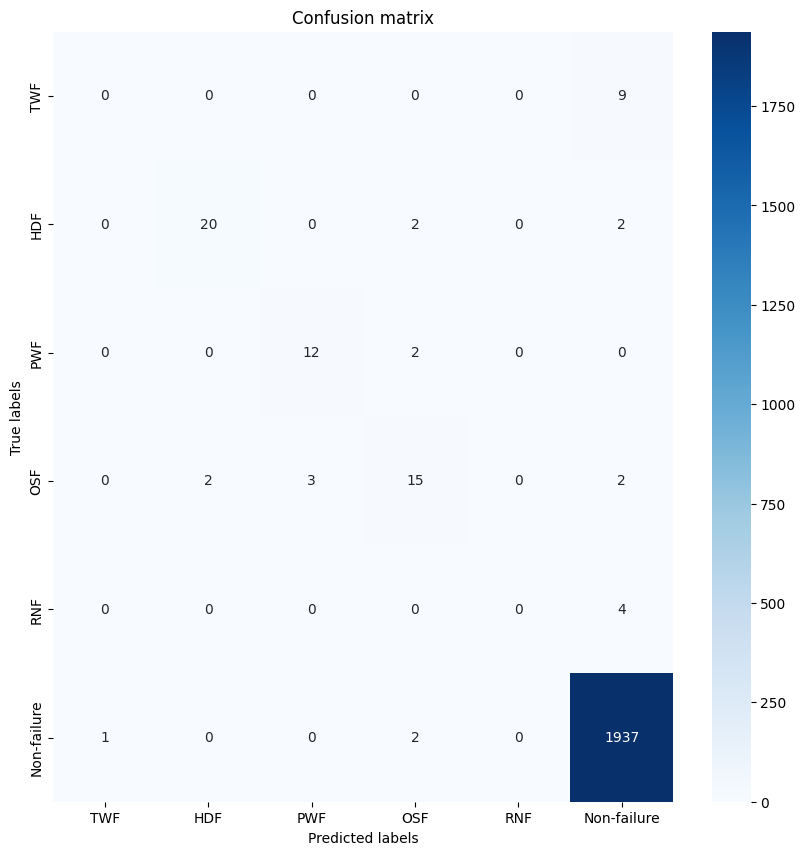

In [10]:
conf_mat = np.zeros((6, 6))

for i in range(6):
    for j in range(6):
        conf_mat[i, j] = np.sum((y_test[:, i] == 1) & (y_pred_dense[:, j] == 1))

label_names = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Non-failure']

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True,fmt=".0f", cmap='Blues',xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

In [11]:
# find acc
acc = np.sum(np.diag(conf_mat)) / np.sum(conf_mat)
print("Accuracy: ", acc)

Accuracy:  0.9855936413313463
